Decido usar este Dataset ya que estaba usando uno de Metales raros de Quandl. La unica manera de descargar esos datasets es con Import Quandl y la funcion de quandl.get('Codigo'). Me bloquearon el acceso por falta de API, lo cual es completamente nuevo para mi ya que he hecho otros requests a Quandl de la misma manera con mas datos. Despues que me bloquearon, solo tenia un dataset con muy poca informacion, eran 3692 lineas. Lo que queria predecir era el precio de acuerdo a la region, pero como aca en este dataset no hay region, usare solo el precio para predecir. Si tengo tiempo, tratare de usar otras columnas.

# Import

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import sklearn
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
from sklearn import linear_model

In [2]:
df = pd.read_csv('diamonds.csv', index_col = 0)

# Navigating through the data

In [3]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Let's take a good at the features of the dataset. We will also describe the whole dataset to show a few maybe useful insights.

In [4]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Now let's take a look at the columns types.

In [5]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

As we can see, we have 3 columns which we will have to convert into numerical values. We can do this with .values (A function of Numpy) or with get dummies. 

In [6]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

There are no null values, that is going to help us a lot.

Now, we will proceed to Create a heatmap of the dataset.

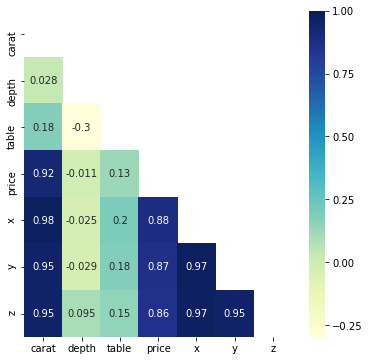

In [7]:
mask = np.zeros_like(df.corr(), dtype=np.bool)

mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(df.corr(), mask=mask, annot=True, cmap="YlGnBu")

Let's see how many unique values are there in the Object type columns.

In [8]:
display(df['cut'].unique())
display(df['color'].unique())
display(df['clarity'].unique())

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

We have a little problem. I wanted to use the get_dummies function, but, the model will not identify which is better between Ideal or Premium and so on. The same happens with the other object type features, In the color feature, E is a lower quality according to Wikipedia. (Not exactly a lower quality, it's just less rare and less expensive)

We will assign the values by hand using a dictionary and a Map function.

# Classifying data.

In [9]:
cut_dict = {'Ideal':5, 'Premium':4, 'Good':3, 'Very Good':2, 'Fair':1}
color_dict = {'D':7, 'E':6, 'F':5, 'G':4, 'H':3, 'I':2, 'J':1}
clarity_dict = {"FL": 11, "IF": 10, "VVS1": 9, "VVS2": 8, "VS1": 7, "VS2": 6, "SI1": 5, "SI2": 4, "I1": 3, "I2": 2, "I3": 1}

def cambiarValores(x, dict):
    df[x] = df[x].map(dict)
    return df[x]
cambiarValores('cut', cut_dict)
cambiarValores('color', color_dict)
cambiarValores('clarity', clarity_dict)

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,5,6,4,61.5,55.0,326,3.95,3.98,2.43
2,0.21,4,6,5,59.8,61.0,326,3.89,3.84,2.31
3,0.23,3,6,7,56.9,65.0,327,4.05,4.07,2.31
4,0.29,4,2,6,62.4,58.0,334,4.20,4.23,2.63
5,0.31,3,1,4,63.3,58.0,335,4.34,4.35,2.75


# Training the model

Now we will train the dataset with the function train_test_split from sklearn and the test size sample will be 10%. And, we will shuffle the data.

We will scale the training data of the whole dataset except for Price.

In [10]:
X = df.drop("price", axis=1).values
y = df["price"].values
X = preprocessing.scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

# Stochastic Gradient Descent Regression

In [11]:
clf = SGDRegressor(max_iter=1000)
clf.fit(X_train, y_train)
display(clf.score(X_test, y_test))

C:\Users\aleja\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.9110583324596798

In [12]:
for X,y in zip(X_test, y_test):
    display(f"Model: {clf.predict([X])[0]}, Actual: {y}")

'Model: 12498.347935599984, Actual: 15151'

'Model: 11869.333557661977, Actual: 15756'

'Model: 3262.5479632833367, Actual: 3170'

'Model: 1963.1057888231337, Actual: 1789'

'Model: 4578.45446916766, Actual: 3849'

'Model: 109.45465626958094, Actual: 579'

'Model: 3512.565952264909, Actual: 2833'

'Model: 4939.91182427095, Actual: 5375'

'Model: 457.7329199696933, Actual: 432'

'Model: 3860.4585433210837, Actual: 3084'

'Model: 1279.383483818268, Actual: 789'

'Model: 10786.145675858963, Actual: 16402'

'Model: 3781.5104970206366, Actual: 3261'

'Model: 997.0597035986798, Actual: 877'

'Model: 12848.998960825102, Actual: 12531'

'Model: 5469.482283568055, Actual: 5206'

'Model: 1421.3229475293588, Actual: 1361'

'Model: 1034.6463023494748, Actual: 882'

'Model: 2677.1597542619484, Actual: 2346'

'Model: 492.17748302746895, Actual: 663'

'Model: 58.082911115655406, Actual: 605'

'Model: 6093.304215504182, Actual: 5888'

'Model: 3458.3828850972154, Actual: 2565'

'Model: 7191.813416218236, Actual: 4373'

'Model: -234.07742819412215, Actual: 544'

'Model: 7681.194164145807, Actual: 6542'

'Model: 2323.5740323512855, Actual: 1200'

'Model: 3220.813827455334, Actual: 2858'

'Model: 5317.245246599876, Actual: 5521'

'Model: 6948.883664185718, Actual: 5412'

'Model: 236.14847592216847, Actual: 1047'

'Model: 13258.09635705881, Actual: 15673'

'Model: 851.6329879831001, Actual: 1218'

'Model: 793.5115443290028, Actual: 756'

'Model: 4090.653872060671, Actual: 3231'

'Model: 780.9081461995988, Actual: 942'

'Model: 0.3768181881500823, Actual: 524'

'Model: 1430.1424497666462, Actual: 1229'

'Model: 985.8248086100266, Actual: 698'

'Model: 1973.0442268027398, Actual: 918'

'Model: 2445.340601085224, Actual: 2100'

'Model: 1139.4163347023205, Actual: 987'

'Model: 5790.655915305024, Actual: 5927'

'Model: 7316.189269955957, Actual: 7378'

'Model: 2115.4505607854044, Actual: 2170'

'Model: -3.2614686664510373, Actual: 741'

'Model: 48.15600745277516, Actual: 833'

'Model: 5441.249453321964, Actual: 4158'

'Model: 3061.202624776742, Actual: 2363'

'Model: 2274.6148215291673, Actual: 2161'

'Model: 9794.092831406455, Actual: 10861'

'Model: 6979.497224681603, Actual: 7848'

'Model: 3345.4808446610364, Actual: 3183'

'Model: 3380.812829804216, Actual: 2812'

'Model: 3931.4566623291043, Actual: 3211'

'Model: 4229.225204311741, Actual: 3296'

'Model: 8488.122693645899, Actual: 8736'

'Model: 3788.980705838187, Actual: 2898'

'Model: 5831.141678240133, Actual: 4838'

'Model: 4484.055304725347, Actual: 3328'

'Model: 2079.509187543804, Actual: 2294'

'Model: 2817.7311190865, Actual: 2476'

'Model: 6373.087918112463, Actual: 4274'

'Model: 1105.3694447411353, Actual: 608'

'Model: 6675.676558966623, Actual: 5211'

'Model: 1307.7213337940111, Actual: 1601'

'Model: 13420.761659722953, Actual: 14057'

'Model: 6858.695709848194, Actual: 6958'

'Model: 10164.5277385326, Actual: 11233'

'Model: 2520.763191707464, Actual: 2453'

'Model: 1169.746337581374, Actual: 912'

'Model: 1348.363986537497, Actual: 915'

'Model: 3986.0405653758617, Actual: 3975'

'Model: 5056.3655807257355, Actual: 4579'

'Model: 9894.263868786851, Actual: 12756'

'Model: 14405.49098800018, Actual: 18376'

'Model: 154.76925060185113, Actual: 945'

'Model: 13718.98451692763, Actual: 16512'

'Model: -120.8632569794645, Actual: 604'

'Model: 1940.1414145361875, Actual: 1818'

'Model: 1987.3032626976378, Actual: 1980'

'Model: 1451.00357761951, Actual: 1565'

'Model: 354.0468463526472, Actual: 780'

'Model: -89.45186238433553, Actual: 695'

'Model: 5365.54676210188, Actual: 5322'

'Model: 2484.207270878977, Actual: 3011'

'Model: 5700.741227413194, Actual: 5572'

'Model: 166.6074834225924, Actual: 573'

'Model: 1742.8828623996642, Actual: 1153'

'Model: 207.86552949508132, Actual: 776'

'Model: 642.0902694891975, Actual: 487'

'Model: 10490.301612684147, Actual: 13638'

'Model: -456.35544471640605, Actual: 778'

'Model: 51.926009284446536, Actual: 625'

'Model: 2513.7986468618974, Actual: 2616'

'Model: 9625.958992471147, Actual: 8879'

'Model: 4934.750539368085, Actual: 5155'

'Model: 3363.0967498136865, Actual: 2496'

'Model: 7280.795053826427, Actual: 6288'

'Model: 7397.814287919564, Actual: 9007'

'Model: 830.9469748837387, Actual: 1764'

'Model: 2110.954261246525, Actual: 988'

'Model: 3311.0603505378967, Actual: 2626'

'Model: 1223.7592462169841, Actual: 1318'

'Model: 1736.4155557520348, Actual: 1624'

'Model: 2228.090437655734, Actual: 920'

'Model: 4449.1047867053485, Actual: 4680'

'Model: -38.609237881692025, Actual: 919'

'Model: 1426.644359817728, Actual: 1276'

'Model: 3778.3649768343416, Actual: 3688'

'Model: 889.8049647963571, Actual: 1262'

'Model: 1471.8288647576328, Actual: 2055'

'Model: 7374.714781957216, Actual: 8067'

'Model: 1014.38593720479, Actual: 692'

'Model: 5871.6070938007215, Actual: 5023'

'Model: 339.7330514884816, Actual: 802'

'Model: 1420.1910128664022, Actual: 2141'

'Model: 10318.636295995218, Actual: 10497'

'Model: 2339.754779036203, Actual: 2318'

'Model: 1165.5516083384528, Actual: 935'

'Model: 1333.0791971533095, Actual: 704'

'Model: 5080.290865010343, Actual: 3570'

'Model: 2999.6570822834146, Actual: 2369'

'Model: 1618.3966300850639, Actual: 828'

'Model: 851.648955341323, Actual: 760'

'Model: 4498.819176584806, Actual: 4291'

'Model: 9234.322135362887, Actual: 7654'

'Model: 343.31971700960867, Actual: 645'

'Model: 8279.113605391824, Actual: 8562'

'Model: 435.08839384844214, Actual: 878'

'Model: 9032.903554914568, Actual: 7188'

'Model: 9516.674089143382, Actual: 6474'

'Model: 4374.889929299422, Actual: 3556'

'Model: 566.7867205824232, Actual: 1098'

'Model: 4843.398062967091, Actual: 5019'

'Model: 349.09269115469624, Actual: 992'

'Model: 10329.759156426488, Actual: 10036'

'Model: 10920.19544808328, Actual: 15013'

'Model: 1830.2191473323433, Actual: 1781'

'Model: 3716.0042158227366, Actual: 3994'

'Model: 7680.007043392761, Actual: 5862'

'Model: 4308.358848287373, Actual: 3611'

'Model: 2127.500405509758, Actual: 1418'

'Model: 4092.0433775861316, Actual: 3936'

'Model: 13033.685988257235, Actual: 11212'

'Model: 1917.91636411537, Actual: 1793'

'Model: -942.160695885812, Actual: 646'

'Model: 8217.967654933811, Actual: 9942'

'Model: 1366.9977653422843, Actual: 1974'

'Model: 235.30078712742215, Actual: 983'

'Model: 2912.2841429144733, Actual: 1733'

'Model: 1881.682169718739, Actual: 1169'

'Model: 11498.411947854434, Actual: 13107'

'Model: 4532.509509877684, Actual: 4836'

'Model: 1430.8872198320573, Actual: 719'

'Model: 5112.139470675904, Actual: 5656'

'Model: 2911.3622678325564, Actual: 2441'

'Model: 14453.302065767424, Actual: 14452'

'Model: 2100.2507878878564, Actual: 974'

'Model: -1089.1265258701578, Actual: 573'

'Model: 10347.121530856817, Actual: 10336'

'Model: 5062.156082206655, Actual: 4540'

'Model: 2114.0295380224343, Actual: 1716'

'Model: 2318.112867473922, Actual: 2382'

'Model: 5425.1851202869675, Actual: 5865'

'Model: 12115.871555887585, Actual: 12052'

'Model: 1599.3988158884226, Actual: 1397'

'Model: 1864.16908397196, Actual: 1627'

'Model: 2620.090224959771, Actual: 1389'

'Model: 1963.8478378955726, Actual: 1721'

'Model: 897.0051906569315, Actual: 810'

'Model: 861.2854385434252, Actual: 395'

'Model: 13103.16147456961, Actual: 15278'

'Model: 1398.8633145740373, Actual: 1083'

'Model: 1114.2188697278439, Actual: 839'

'Model: 1962.4635914659536, Actual: 1696'

'Model: 7007.402739571641, Actual: 7917'

'Model: 662.9306084125601, Actual: 773'

'Model: 7636.911484542939, Actual: 7329'

'Model: 3386.092686763208, Actual: 2362'

'Model: 9259.496600036728, Actual: 9408'

'Model: 11238.308577324893, Actual: 12089'

'Model: 14524.351505235412, Actual: 12618'

'Model: -206.68677772980482, Actual: 491'

'Model: 2558.1296389506206, Actual: 1208'

'Model: 3277.163280770419, Actual: 2732'

'Model: 7784.566591775829, Actual: 8783'

'Model: 5143.6491001375225, Actual: 4398'

'Model: 11872.430455794396, Actual: 15992'

'Model: 14229.669332152815, Actual: 18795'

'Model: 3360.0779031321918, Actual: 2501'

'Model: 1223.58230399794, Actual: 569'

'Model: 4567.658671189779, Actual: 3145'

'Model: 7018.12919992386, Actual: 5329'

'Model: 452.18787539971754, Actual: 683'

'Model: 1362.7418907712754, Actual: 526'

'Model: 3066.084550732383, Actual: 2287'

'Model: 1867.2353782504456, Actual: 1019'

'Model: 8614.086321196117, Actual: 9586'

'Model: 66.77942148843067, Actual: 743'

'Model: 2682.1513642813643, Actual: 2197'

'Model: 10402.222195154034, Actual: 11711'

'Model: 878.9373981569333, Actual: 1286'

'Model: 6905.371158272193, Actual: 6464'

'Model: 263.77916061189853, Actual: 571'

'Model: 14850.08780200806, Actual: 13786'

'Model: 1361.0529817453144, Actual: 1422'

'Model: 1540.6256863329468, Actual: 990'

'Model: 676.0591393971795, Actual: 767'

'Model: 569.3732950499216, Actual: 828'

'Model: 9417.690423768949, Actual: 15185'

'Model: 372.5828476552797, Actual: 851'

'Model: 5025.772830717324, Actual: 4452'

'Model: 1026.2125266101598, Actual: 1268'

'Model: 537.8331471343363, Actual: 878'

'Model: 8987.106483534506, Actual: 11883'

'Model: 1551.094721253393, Actual: 949'

'Model: 2281.6631886669384, Actual: 1847'

'Model: 5200.575575090846, Actual: 3819'

'Model: 4166.091565865082, Actual: 3599'

'Model: 1175.1972606078812, Actual: 680'

'Model: 4373.836379360372, Actual: 4167'

'Model: 6245.27679691527, Actual: 5258'

'Model: -85.15513295763503, Actual: 776'

'Model: 12733.746905130236, Actual: 14814'

'Model: 1930.358142052607, Actual: 2383'

'Model: 2603.4065337553466, Actual: 1883'

'Model: 5610.224098542517, Actual: 4679'

'Model: 8429.548330817124, Actual: 7292'

'Model: 2212.9343136711104, Actual: 1264'

'Model: 5180.189540719564, Actual: 3965'

'Model: 5529.345490351765, Actual: 6587'

'Model: 4168.981687053315, Actual: 3062'

'Model: 4900.954832033395, Actual: 4304'

'Model: 4025.724477819956, Actual: 3084'

'Model: 576.8837422617094, Actual: 844'

'Model: 3844.596494642175, Actual: 2907'

'Model: 12477.6612967197, Actual: 15847'

'Model: 15785.546880512582, Actual: 18475'

'Model: 3192.3770274800927, Actual: 2358'

'Model: 1419.0992987547788, Actual: 2159'

'Model: 994.6994160883328, Actual: 1112'

'Model: 3874.5136630994393, Actual: 2830'

'Model: 3004.463967221538, Actual: 2502'

'Model: 1742.2764537503385, Actual: 1326'

'Model: 2273.7462156801744, Actual: 1124'

'Model: 10627.325498286038, Actual: 9845'

'Model: 4690.5492809363695, Actual: 3419'

'Model: 224.3391919255546, Actual: 827'

'Model: 1160.8956124603255, Actual: 768'

'Model: 10381.272253778872, Actual: 11818'

'Model: 14212.660575862988, Actual: 16587'

'Model: 98.9648653582185, Actual: 878'

'Model: -962.3382990111559, Actual: 576'

'Model: 5747.752459834912, Actual: 4360'

'Model: 71.75680975972227, Actual: 809'

'Model: 4342.034336703911, Actual: 4849'

'Model: -375.9013551240769, Actual: 659'

'Model: 4371.552891771869, Actual: 4420'

'Model: 2747.9344545444706, Actual: 2235'

'Model: 2197.1667826223756, Actual: 1243'

'Model: -877.721262174071, Actual: 540'

'Model: -380.2018318314367, Actual: 523'

'Model: 4643.394783684946, Actual: 4072'

'Model: 9183.36860284521, Actual: 9261'

'Model: 13842.859163526384, Actual: 10401'

'Model: 83.69905368040418, Actual: 561'

'Model: 6124.76516014417, Actual: 6399'

'Model: 978.6443773725573, Actual: 775'

'Model: 1638.8132062949226, Actual: 2098'

'Model: 9537.89348009423, Actual: 8537'

'Model: 6611.263525904555, Actual: 5170'

'Model: 6291.027862284785, Actual: 6013'

'Model: 1577.841207986865, Actual: 1007'

'Model: -78.13625880150403, Actual: 402'

'Model: 6551.252695862599, Actual: 5601'

'Model: 2555.463373734601, Actual: 1980'

'Model: 1019.2516994818916, Actual: 1235'

'Model: 5426.671284226826, Actual: 5653'

'Model: 13670.57534803066, Actual: 13956'

'Model: 2641.3758120490793, Actual: 2756'

'Model: 353.125670456448, Actual: 1092'

'Model: 2996.810246886425, Actual: 1961'

'Model: 4155.716679708914, Actual: 3832'

'Model: 15238.537280961966, Actual: 17582'

'Model: 2714.305250663495, Actual: 1221'

'Model: 1655.4944447368453, Actual: 1579'

'Model: 4793.348974888666, Actual: 4579'

'Model: 5647.658456879715, Actual: 5226'

'Model: 307.40539048856454, Actual: 626'

'Model: 1520.3037338557983, Actual: 591'

'Model: 2335.3932562537384, Actual: 1263'

'Model: 227.61383640253462, Actual: 645'

'Model: 14542.667405186297, Actual: 12639'

'Model: 4354.1175210829, Actual: 5247'

'Model: 5439.649368281698, Actual: 4586'

'Model: -881.3060403913332, Actual: 426'

'Model: 6413.410706571161, Actual: 7032'

'Model: 108.17792962383191, Actual: 756'

'Model: 6556.083792744326, Actual: 6005'

'Model: 1724.1841132616978, Actual: 891'

'Model: -373.70264899273116, Actual: 475'

'Model: -225.27075644531124, Actual: 369'

'Model: 5297.678038566264, Actual: 5437'

'Model: 2180.756065481443, Actual: 1243'

'Model: 295.7046562045962, Actual: 810'

'Model: 808.7039807337997, Actual: 972'

'Model: 10152.821570202479, Actual: 10914'

'Model: 3326.5706068989994, Actual: 2913'

'Model: 11981.182106830693, Actual: 12394'

'Model: 1934.0642562589605, Actual: 1944'

'Model: 2624.802889499547, Actual: 2264'

'Model: 1118.659877246745, Actual: 984'

'Model: -423.0815622575574, Actual: 593'

'Model: 7508.005032509853, Actual: 6887'

'Model: 1079.1672880330902, Actual: 816'

'Model: 10712.265785911019, Actual: 14779'

'Model: 10077.676668366686, Actual: 7154'

'Model: 1910.2732155186825, Actual: 1662'

'Model: 2315.0317258304417, Actual: 2445'

'Model: -301.47344193974004, Actual: 526'

'Model: 3736.686096518616, Actual: 3576'

'Model: -495.5352185734264, Actual: 505'

'Model: 941.224550957028, Actual: 1015'

'Model: 5174.414014319246, Actual: 5017'

'Model: 5399.8285474438235, Actual: 4979'

'Model: 6769.207997090322, Actual: 5728'

'Model: 644.3361351120298, Actual: 827'

'Model: 3891.788762775533, Actual: 3845'

'Model: 4041.895603033797, Actual: 2698'

'Model: 1012.5606919323673, Actual: 1176'

'Model: 1794.5243693233906, Actual: 854'

'Model: 9221.671352560174, Actual: 11946'

'Model: 3793.900754906489, Actual: 3288'

'Model: 13681.83099831402, Actual: 13500'

'Model: 8423.43276774653, Actual: 7022'

'Model: 1319.5820954330084, Actual: 1076'

'Model: -210.23267592515458, Actual: 729'

'Model: 1727.3286226150444, Actual: 863'

'Model: 151.58473308723387, Actual: 687'

'Model: 1233.1474354934412, Actual: 880'

'Model: -1150.1793341726025, Actual: 436'

'Model: 7036.662643284551, Actual: 8752'

'Model: 4795.188544798413, Actual: 3618'

'Model: 1860.9493637729015, Actual: 512'

'Model: 8987.423349728013, Actual: 5460'

'Model: 10241.66350285458, Actual: 16048'

'Model: 4789.3898164536795, Actual: 3669'

'Model: 11986.111569571209, Actual: 10137'

'Model: 10012.675242497633, Actual: 12571'

'Model: 3509.281880827041, Actual: 3445'

'Model: 1117.7652670968428, Actual: 816'

'Model: 6359.941611327917, Actual: 6905'

'Model: 406.4516484379692, Actual: 1038'

'Model: 3695.4131502784476, Actual: 3690'

'Model: 176.3835340488863, Actual: 727'

'Model: -92.74145632994805, Actual: 770'

'Model: 2220.667599414286, Actual: 1118'

'Model: 1770.5133622043927, Actual: 1656'

'Model: 1771.1020786722547, Actual: 1642'

'Model: 5827.5404866850795, Actual: 5655'

'Model: 3888.723316477307, Actual: 3616'

'Model: 3698.1396997245524, Actual: 3092'

'Model: 2881.843483225504, Actual: 1439'

'Model: 4689.587353289027, Actual: 4316'

'Model: 8039.498459965421, Actual: 9225'

'Model: 1916.9310484415926, Actual: 980'

'Model: 5445.658376904373, Actual: 3366'

'Model: 8451.295227137307, Actual: 10221'

'Model: 8750.282505614814, Actual: 8499'

'Model: 1250.292488031701, Actual: 530'

'Model: 1296.5777313667595, Actual: 764'

'Model: -1619.9588566987104, Actual: 393'

'Model: 8982.165364958038, Actual: 10631'

'Model: 2286.6519990355437, Actual: 1294'

'Model: 3336.893612612503, Actual: 2426'

'Model: 2783.75983716168, Actual: 2401'

'Model: 8571.146938403666, Actual: 12748'

'Model: 885.5021431761038, Actual: 819'

'Model: 2866.713566317038, Actual: 2717'

'Model: 3906.395748586462, Actual: 3291'

'Model: -374.82022020158, Actual: 698'

'Model: 4297.232913398386, Actual: 3806'

'Model: 792.4303858554063, Actual: 1015'

'Model: 2035.899772094781, Actual: 1709'

'Model: -680.9721544668755, Actual: 630'

'Model: 1217.0937291205728, Actual: 552'

'Model: 1675.339433950055, Actual: 1698'

'Model: 6343.419453666803, Actual: 6588'

'Model: -1501.5242722338135, Actual: 554'

'Model: 6400.024293752021, Actual: 7556'

'Model: 1817.3143953156364, Actual: 844'

'Model: 6473.135173345045, Actual: 5955'

'Model: 2394.711395329481, Actual: 1649'

'Model: 6121.903720152617, Actual: 7244'

'Model: 3512.0097819860102, Actual: 3504'

'Model: 3062.5887248703057, Actual: 2087'

'Model: 1672.671314012111, Actual: 1654'

'Model: 3882.7217730836173, Actual: 3991'

'Model: 944.526048319758, Actual: 789'

'Model: 6759.776261969984, Actual: 7275'

'Model: -364.09430286137285, Actual: 637'

'Model: 714.7033353590141, Actual: 650'

'Model: 7298.56939223623, Actual: 9796'

'Model: 10693.156394572168, Actual: 12087'

'Model: 3404.873226861013, Actual: 3105'

'Model: 2394.0766863250265, Actual: 2376'

'Model: 4589.782997583519, Actual: 4721'

'Model: 8602.178577819574, Actual: 7983'

'Model: 2975.223436359798, Actual: 2544'

'Model: 1565.2579330024496, Actual: 1082'

'Model: 4565.429979367704, Actual: 3365'

'Model: 1457.2028564207717, Actual: 1569'

'Model: -370.6170288395542, Actual: 605'

'Model: 4960.322160604243, Actual: 4900'

'Model: 3392.7921978933146, Actual: 3183'

'Model: 1910.9452316343052, Actual: 2351'

'Model: 2210.5585461310147, Actual: 1844'

'Model: 1173.0183695339306, Actual: 1316'

'Model: 636.4210243101215, Actual: 1097'

'Model: 8537.675491808217, Actual: 10814'

'Model: 15791.527041317542, Actual: 15714'

'Model: 4091.7273033822535, Actual: 3921'

'Model: -1658.5041075590361, Actual: 394'

'Model: -388.56631307969747, Actual: 572'

'Model: 6086.197306033142, Actual: 5410'

'Model: 1249.7201839098607, Actual: 871'

'Model: 4880.92124315398, Actual: 4381'

'Model: 7905.132307301, Actual: 8855'

'Model: 871.6103087902743, Actual: 687'

'Model: -498.9609114535251, Actual: 447'

'Model: 14026.894895842059, Actual: 15036'

'Model: 1221.7618002052977, Actual: 749'

'Model: 1025.421988412903, Actual: 905'

'Model: 4984.8203883234455, Actual: 4077'

'Model: 8881.091272663656, Actual: 8852'

'Model: 1666.5833518671266, Actual: 1684'

'Model: 3789.330776001477, Actual: 3533'

'Model: 2384.642791239712, Actual: 2268'

'Model: 2064.510609649442, Actual: 885'

'Model: 1482.4174783986828, Actual: 1279'

'Model: 3283.3933783597663, Actual: 2639'

'Model: 5918.050688657382, Actual: 6738'

'Model: 6410.280625397757, Actual: 6563'

'Model: -1198.7806454760048, Actual: 475'

'Model: 7299.530392515111, Actual: 9257'

'Model: 2449.0704228172203, Actual: 1002'

'Model: 1060.8003344620165, Actual: 805'

'Model: 4575.237466870456, Actual: 3789'

'Model: -264.99980783922547, Actual: 561'

'Model: 6659.218947831524, Actual: 7072'

'Model: 1722.9176287294376, Actual: 1154'

'Model: -1521.266243521638, Actual: 541'

'Model: 4423.707570657593, Actual: 3265'

'Model: 3087.0728035338393, Actual: 2683'

'Model: 6943.410963944747, Actual: 7457'

'Model: 6075.068246554692, Actual: 6666'

'Model: 101.09957273429109, Actual: 983'

'Model: 6720.792007991176, Actual: 7275'

'Model: 6450.006004337214, Actual: 5056'

'Model: 1342.864470098505, Actual: 622'

'Model: 2267.247032841469, Actual: 1100'

'Model: 2702.8842184731416, Actual: 2594'

'Model: -1594.5539295236058, Actual: 506'

'Model: 4183.6316553737215, Actual: 4078'

'Model: 3065.893763153997, Actual: 2804'

'Model: 5103.357286205811, Actual: 4199'

'Model: 3363.8522432345817, Actual: 3452'

'Model: 9026.37065553767, Actual: 10732'

'Model: 414.4122070962767, Actual: 870'

'Model: 9058.667152711663, Actual: 7936'

'Model: 1422.391040113198, Actual: 1443'

'Model: 2268.133489077218, Actual: 1029'

'Model: 5780.986898343559, Actual: 6204'

'Model: 771.3534050551061, Actual: 505'

'Model: 6398.261374380563, Actual: 6110'

'Model: 1955.9496670779881, Actual: 1813'

'Model: 2860.0520110116677, Actual: 1790'

'Model: 1500.7876583220595, Actual: 2700'

'Model: -455.9294360695485, Actual: 810'

'Model: 544.1993479226371, Actual: 726'

'Model: 8710.56538172481, Actual: 8794'

'Model: 7647.634805022714, Actual: 8334'

'Model: 3783.970425753498, Actual: 2838'

'Model: 13494.939171596325, Actual: 17166'

'Model: 6416.584269007535, Actual: 6573'

'Model: 1086.143069205937, Actual: 810'

'Model: 2408.78947260012, Actual: 2457'

'Model: 3274.3127733479682, Actual: 3593'

'Model: 5144.260306988439, Actual: 3959'

'Model: 7852.48717161075, Actual: 8687'

'Model: 1145.8208927133892, Actual: 1130'

'Model: -523.0256227370446, Actual: 475'

'Model: 6064.092487168885, Actual: 6728'

'Model: -216.4511555507397, Actual: 749'

'Model: 13906.049654346385, Actual: 15675'

'Model: 3544.6729312962534, Actual: 3447'

'Model: 3543.083018224873, Actual: 2724'

'Model: 777.4700916284091, Actual: 710'

'Model: 2006.2292835055223, Actual: 1865'

'Model: 2818.869590206238, Actual: 2269'

'Model: 962.8330859065409, Actual: 1087'

'Model: 7291.08550277504, Actual: 6308'

'Model: 2033.6078956852168, Actual: 886'

'Model: 12820.83249906058, Actual: 5203'

'Model: 90.67424104314114, Actual: 737'

'Model: 1979.5634234052918, Actual: 1372'

'Model: 3238.876873166322, Actual: 2851'

'Model: 5671.937745385241, Actual: 4698'

'Model: 2722.3392821348025, Actual: 1367'

'Model: 1356.8411367896124, Actual: 850'

'Model: 7556.971052720066, Actual: 10093'

'Model: 6981.446223809162, Actual: 7389'

'Model: 6010.245656705085, Actual: 5359'

'Model: 10755.519942271745, Actual: 10091'

'Model: 5791.324112429353, Actual: 4770'

'Model: -944.0949736875964, Actual: 462'

'Model: 5857.8154176265625, Actual: 4998'

'Model: 5109.9991713088, Actual: 4350'

'Model: 8821.300624832566, Actual: 10650'

'Model: 1434.216732796811, Actual: 1069'

'Model: 6317.072179603708, Actual: 5670'

'Model: 5266.337641550003, Actual: 4964'

'Model: 1593.961202450338, Actual: 1215'

'Model: 406.2634410112537, Actual: 828'

'Model: 512.7598293414826, Actual: 737'

'Model: 4582.347392627792, Actual: 3997'

'Model: 14334.545959350678, Actual: 15651'

'Model: 1915.8821878248816, Actual: 1094'

'Model: 10407.203858846118, Actual: 11796'

'Model: 1628.9102175569387, Actual: 1641'

'Model: 2631.499968844768, Actual: 1433'

'Model: 2733.6600776368577, Actual: 2840'

'Model: 634.0147953415922, Actual: 505'

'Model: 6156.341645895366, Actual: 4790'

'Model: -1449.9305550623367, Actual: 380'

'Model: 1828.3785947033125, Actual: 1662'

'Model: 3624.32195826864, Actual: 3378'

'Model: 4842.995886825862, Actual: 3634'

'Model: 9203.149530629962, Actual: 10468'

'Model: 5975.264853352666, Actual: 7347'

'Model: 14355.090077580411, Actual: 18257'

'Model: 1973.353475578014, Actual: 1253'

'Model: 1280.4364206148052, Actual: 982'

'Model: 11900.79666896138, Actual: 13248'

'Model: 2075.9371232911417, Actual: 1662'

'Model: 2829.9500522725043, Actual: 2117'

'Model: 631.4894169538088, Actual: 644'

'Model: 2456.1627690088717, Actual: 2762'

'Model: 11406.232317523496, Actual: 12773'

'Model: -423.89084430608546, Actual: 664'

'Model: 883.50549257886, Actual: 738'

'Model: 8089.417441159347, Actual: 6093'

'Model: 1897.150192076298, Actual: 1629'

'Model: 1453.1207542845623, Actual: 891'

'Model: 5549.2008216404465, Actual: 4752'

'Model: 13613.527918173924, Actual: 12717'

'Model: 14769.220380187078, Actual: 18002'

'Model: -280.24361606338334, Actual: 561'

'Model: 13391.400316227046, Actual: 15218'

'Model: -1003.385481571926, Actual: 475'

'Model: 1656.8333613655159, Actual: 1246'

'Model: 1586.065344919767, Actual: 895'

'Model: -425.61915687400506, Actual: 812'

'Model: 12967.910806242497, Actual: 12268'

'Model: 7545.193605861782, Actual: 8691'

'Model: 443.76293660807187, Actual: 710'

'Model: 2565.8092811164024, Actual: 2090'

'Model: -324.24836117840186, Actual: 516'

'Model: 753.91986531465, Actual: 884'

'Model: 1945.0820428730522, Actual: 1852'

'Model: 802.139694956812, Actual: 734'

'Model: 844.5462244255659, Actual: 734'

'Model: 10733.99365511368, Actual: 12648'

'Model: 2948.2539814499964, Actual: 2069'

'Model: 1854.349662619839, Actual: 1200'

'Model: 243.3935562980023, Actual: 666'

'Model: 1848.1319812332945, Actual: 886'

'Model: 5649.274524857249, Actual: 4290'

'Model: -95.17341735566379, Actual: 675'

'Model: 9427.536245976862, Actual: 10692'

'Model: 6416.9834697416645, Actual: 7715'

'Model: 4003.2353746834865, Actual: 2826'

'Model: 4436.619916053357, Actual: 4192'

'Model: 6744.434302637594, Actual: 6458'

'Model: 478.7525466463976, Actual: 845'

'Model: 3094.6236994358087, Actual: 2318'

'Model: 10947.116987239207, Actual: 13500'

'Model: 6749.657923505372, Actual: 8922'

'Model: 164.5322384604715, Actual: 777'

'Model: 8234.662727845334, Actual: 8975'

'Model: 4455.325636200378, Actual: 3049'

'Model: 10505.563977249241, Actual: 12334'

'Model: -31.509011323551476, Actual: 605'

'Model: 1168.20626806172, Actual: 1033'

'Model: 2721.169001438887, Actual: 1400'

'Model: 6931.278896647371, Actual: 7954'

'Model: 1281.0404462347333, Actual: 1040'

'Model: 2968.161574310069, Actual: 1847'

'Model: 5043.608082033757, Actual: 4363'

'Model: 3737.2868816610103, Actual: 3267'

'Model: 3398.508280858611, Actual: 2822'

'Model: 2865.882295799065, Actual: 2511'

'Model: 1802.62302586019, Actual: 2070'

'Model: 3105.7632168071354, Actual: 1865'

'Model: 9127.453246757283, Actual: 8669'

'Model: 138.73248945276418, Actual: 571'

'Model: 1925.2636976655756, Actual: 1052'

'Model: 4894.6882619561, Actual: 4392'

'Model: 11621.401187511154, Actual: 12846'

'Model: 5581.88575220198, Actual: 5259'

'Model: 2683.0513643807662, Actual: 1229'

'Model: 1670.092033898938, Actual: 2112'

'Model: -1768.4553031033638, Actual: 391'

'Model: 110.6962734131348, Actual: 854'

'Model: 1963.4166146830414, Actual: 1017'

'Model: 781.0919555101627, Actual: 676'

'Model: 624.0573069239058, Actual: 599'

'Model: 8370.391515980768, Actual: 5761'

'Model: 3029.849564287075, Actual: 2192'

'Model: 1001.7110876552879, Actual: 734'

'Model: 9986.296387949706, Actual: 12891'

'Model: 2306.583472259258, Actual: 1838'

'Model: 1652.676762714313, Actual: 961'

'Model: 4175.192884499385, Actual: 3881'

'Model: 3363.5338833880123, Actual: 2706'

'Model: 5092.208023264395, Actual: 4318'

'Model: 341.43032694706244, Actual: 802'

'Model: 14119.737495370533, Actual: 18818'

'Model: 3797.354493234568, Actual: 3182'

'Model: 4287.231662795601, Actual: 3510'

'Model: 1699.967588294683, Actual: 840'

'Model: 6552.16937389485, Actual: 5215'

'Model: 4114.681319451771, Actual: 2739'

'Model: 5986.906278247174, Actual: 5717'

'Model: -64.1092114863036, Actual: 565'

'Model: 2770.8998342367486, Actual: 2721'

'Model: 9885.254433822247, Actual: 11666'

'Model: 8622.057040331681, Actual: 12200'

'Model: 2523.489043337082, Actual: 1247'

'Model: 3214.2550972096756, Actual: 2797'

'Model: 2024.8897289722142, Actual: 1064'

'Model: 2320.751909810878, Actual: 1289'

'Model: 4875.475441300288, Actual: 4123'

'Model: 8698.301152584323, Actual: 8598'

'Model: 7451.741153970881, Actual: 8454'

'Model: 4869.881617546431, Actual: 3378'

'Model: 4956.561987927387, Actual: 4662'

'Model: -1281.9479169979868, Actual: 432'

'Model: -189.8926709685593, Actual: 579'

'Model: 1629.3292609517835, Actual: 1609'

'Model: 2465.831428803385, Actual: 2196'

'Model: 2908.078956746098, Actual: 2948'

'Model: 3886.9405342767564, Actual: 3203'

'Model: 168.71794819378374, Actual: 828'

'Model: 4603.862964043737, Actual: 4211'

'Model: 9618.525371304386, Actual: 9157'

'Model: 110.9596414967923, Actual: 876'

'Model: 10418.422190049698, Actual: 11943'

'Model: 1841.71150891449, Actual: 1170'

'Model: 9161.785270727267, Actual: 10572'

'Model: 1907.7587095417641, Actual: 1044'

'Model: 4847.742801096111, Actual: 3674'

'Model: 1636.2865680876826, Actual: 1619'

'Model: 1958.310523360181, Actual: 826'

'Model: 7028.004623105938, Actual: 5940'

'Model: 863.6826130042591, Actual: 942'

'Model: 2937.0006183739893, Actual: 1941'

'Model: 2236.908739929304, Actual: 1882'

'Model: 2853.7450117831067, Actual: 2443'

'Model: 6795.138266921047, Actual: 5598'

'Model: 1908.206277452529, Actual: 760'

'Model: 2382.1987145547473, Actual: 1717'

'Model: 726.101449335541, Actual: 480'

'Model: 13504.353605242606, Actual: 6753'

'Model: 4094.175919181325, Actual: 3418'

'Model: 2213.0657474575182, Actual: 1290'

'Model: 12413.396421590624, Actual: 17219'

'Model: 2924.4459103327026, Actual: 2431'

'Model: 3932.144739337855, Actual: 3619'

'Model: 391.32622819604967, Actual: 644'

'Model: 1436.214745317949, Actual: 868'

'Model: 3232.6055213298014, Actual: 1779'

'Model: 360.48499223840554, Actual: 1035'

'Model: 1573.410309241247, Actual: 1685'

'Model: 650.9085658183853, Actual: 801'

'Model: 5843.319729485231, Actual: 5293'

'Model: 2866.819457919335, Actual: 2459'

'Model: 608.5960260621237, Actual: 924'

'Model: 3358.9434419858135, Actual: 3007'

'Model: 11332.886336464126, Actual: 14842'

'Model: 1313.4592866697753, Actual: 586'

'Model: 23.831211188685756, Actual: 660'

'Model: 957.6104694348969, Actual: 961'

'Model: 1713.943900425185, Actual: 1559'

'Model: 3183.1438176949523, Actual: 2456'

'Model: 1937.9553013971492, Actual: 1946'

'Model: 4816.142938204767, Actual: 3347'

'Model: 8609.411797453877, Actual: 10071'

'Model: 1997.0158020267454, Actual: 1621'

'Model: 6115.22267080729, Actual: 5352'

'Model: 6074.256303283379, Actual: 5294'

'Model: 3667.7387851736394, Actual: 2683'

'Model: 11043.740733418927, Actual: 12098'

'Model: 5619.414429937304, Actual: 8330'

'Model: 8566.233483967948, Actual: 6458'

'Model: -533.9703379759794, Actual: 628'

'Model: 4703.578928797194, Actual: 2840'

'Model: 14104.07410319099, Actual: 16747'

'Model: 4626.306738683912, Actual: 2855'

'Model: 4817.745517213385, Actual: 4503'

'Model: 470.30526676708996, Actual: 900'

'Model: 1129.9348284283842, Actual: 702'

'Model: 14598.091047688355, Actual: 18153'

'Model: 1392.549746393297, Actual: 1890'

'Model: 5542.628878079783, Actual: 4583'

'Model: 2833.411941562208, Actual: 2685'

'Model: -286.8910600597401, Actual: 571'

'Model: 4361.039570433213, Actual: 4232'

'Model: 605.6776197395802, Actual: 505'

'Model: -933.0738453225094, Actual: 394'

'Model: 2180.360716965338, Actual: 1169'

'Model: 718.7366606599785, Actual: 766'

'Model: 9665.203837017496, Actual: 8283'

'Model: 2128.1525372483175, Actual: 2331'

'Model: 1972.5207076731524, Actual: 1846'

'Model: 438.04905453619585, Actual: 614'

'Model: 3922.690023034658, Actual: 3153'

'Model: 6681.115091906956, Actual: 3942'

'Model: 11958.670383278095, Actual: 15804'

'Model: 11311.983704555143, Actual: 15426'

'Model: -66.9768758185005, Actual: 556'

'Model: 10239.37325962996, Actual: 12467'

'Model: 570.6530768449779, Actual: 1242'

'Model: 13963.362195242455, Actual: 14766'

'Model: 1934.6827624461957, Actual: 1616'

'Model: 10268.313182754542, Actual: 14066'

'Model: 4490.6627742503, Actual: 4443'

'Model: 2647.3408913102066, Actual: 2364'

'Model: 3099.676889552402, Actual: 2440'

'Model: 5053.9914187773975, Actual: 5221'

'Model: -274.7848861293978, Actual: 482'

'Model: 7419.584789191027, Actual: 6577'

'Model: 1376.1888813011292, Actual: 1007'

'Model: 486.4809530337852, Actual: 776'

'Model: -70.9826585493638, Actual: 625'

'Model: 9283.298162556772, Actual: 9700'

'Model: 7035.559731450953, Actual: 6956'

'Model: -694.871786918302, Actual: 394'

'Model: 2525.904085944911, Actual: 1857'

'Model: 1819.0313836191676, Actual: 891'

'Model: 3538.0427640684393, Actual: 2777'

'Model: 13360.187211204866, Actual: 15081'

'Model: 8855.126177103257, Actual: 10886'

'Model: 7997.17031730433, Actual: 11196'

'Model: 9929.940476704527, Actual: 11302'

'Model: 2309.7476907240757, Actual: 990'

'Model: 2282.414936877124, Actual: 2230'

'Model: 1658.0073317747465, Actual: 1577'

'Model: 2320.032341689628, Actual: 1971'

'Model: 15237.427311018939, Actual: 13782'

'Model: 7571.510216919853, Actual: 8403'

'Model: 1473.66135013742, Actual: 1346'

'Model: 5863.208594689493, Actual: 6483'

'Model: 2644.817953780983, Actual: 1883'

'Model: 1076.608473931939, Actual: 956'

'Model: 1656.8552686132357, Actual: 1088'

'Model: 2366.3071293530247, Actual: 2000'

'Model: 5999.939412629985, Actual: 6324'

'Model: 16056.33679053274, Actual: 15201'

'Model: 3030.3047659129156, Actual: 2762'

'Model: 4357.037994761923, Actual: 3443'

'Model: 11899.025405173104, Actual: 16112'

'Model: 5575.996997307548, Actual: 6397'

'Model: -180.6765880181465, Actual: 526'

'Model: 9863.833835875386, Actual: 10106'

'Model: -272.0694793741595, Actual: 593'

'Model: 2690.1417486232267, Actual: 2893'

'Model: 636.114068482324, Actual: 684'

'Model: 3585.395978751286, Actual: 2720'

'Model: 13045.986453624912, Actual: 10913'

'Model: 7097.196331932293, Actual: 8626'

'Model: 3180.3714084131248, Actual: 2753'

'Model: 8550.759077166062, Actual: 11415'

'Model: 19.20888736150482, Actual: 551'

'Model: 8809.10189992372, Actual: 9979'

'Model: 6126.992670718544, Actual: 4259'

'Model: 2187.7534734026945, Actual: 1629'

'Model: 12326.033025562068, Actual: 10043'

'Model: 1489.8083193525868, Actual: 1799'

'Model: 6694.094416112276, Actual: 6779'

'Model: 1440.7936471648063, Actual: 982'

'Model: 2432.00896557392, Actual: 1959'

'Model: -1088.4816312352723, Actual: 589'

'Model: 2821.325767681006, Actual: 2374'

'Model: 6160.720286347209, Actual: 7275'

'Model: -60.31499954555238, Actual: 647'

'Model: 3762.103103011177, Actual: 3671'

'Model: 8914.874969181441, Actual: 10295'

'Model: 922.4546201102835, Actual: 853'

'Model: 143.50445863726327, Actual: 371'

'Model: 434.3844243008134, Actual: 886'

'Model: 731.5373255547584, Actual: 1154'

'Model: 5414.33483397897, Actual: 6907'

'Model: 5782.054051975447, Actual: 6230'

'Model: 10779.514356375708, Actual: 13733'

'Model: 13754.668461736775, Actual: 11198'

'Model: 2919.1866516878117, Actual: 2103'

'Model: 3874.8648603516162, Actual: 3546'

'Model: 1869.4393597248336, Actual: 1092'

'Model: 15325.602890305589, Actual: 14129'

'Model: 5353.548324162138, Actual: 5242'

'Model: 5128.272938440032, Actual: 3304'

'Model: 3596.9389569251525, Actual: 3388'

'Model: -226.05014128810672, Actual: 453'

'Model: 3656.5540652784966, Actual: 2960'

'Model: 135.6307389846188, Actual: 1299'

'Model: 1007.6161954072586, Actual: 800'

'Model: 3673.259556124091, Actual: 3762'

'Model: 14313.021466835897, Actual: 12677'

'Model: 2500.7528946350058, Actual: 1698'

'Model: 3210.2796513426792, Actual: 2530'

'Model: 264.040569620774, Actual: 707'

'Model: 2657.673501763198, Actual: 2098'

'Model: 2169.5653581310125, Actual: 1153'

'Model: 691.225098079186, Actual: 530'

'Model: 6343.003567437615, Actual: 5510'

'Model: 339.79478863942813, Actual: 709'

'Model: 3979.4552776908677, Actual: 3378'

'Model: 6297.449138242813, Actual: 5927'

'Model: 1848.5106553811052, Actual: 1656'

'Model: -704.1197052170974, Actual: 746'

'Model: 2695.1558972690827, Actual: 2883'

'Model: 625.7945442630876, Actual: 755'

'Model: 6272.280523435318, Actual: 5602'

'Model: 1374.5021283002043, Actual: 1013'

'Model: 944.0941921691347, Actual: 1040'

'Model: 353.7062355015505, Actual: 1176'

'Model: 2104.549773761156, Actual: 1814'

'Model: 6825.268443575558, Actual: 8924'

'Model: 12970.355070234898, Actual: 11189'

'Model: 4576.023808524924, Actual: 4598'

'Model: 2571.819253083438, Actual: 2070'

'Model: 14269.605475656252, Actual: 12853'

'Model: 11976.22636576755, Actual: 17194'

'Model: 1253.6869037084398, Actual: 984'

'Model: 613.7591729768906, Actual: 613'

'Model: 1818.2971217310278, Actual: 596'

'Model: 2498.662686084196, Actual: 1960'

'Model: 2461.8965761882973, Actual: 2107'

'Model: 14542.885058685577, Actual: 17658'

'Model: 8249.93772195506, Actual: 6132'

'Model: 13182.524617836487, Actual: 11825'

'Model: 2250.4235285754685, Actual: 1919'

'Model: 9437.3150404997, Actual: 13261'

'Model: 7192.389024736303, Actual: 7996'

'Model: 4634.035864610152, Actual: 3798'

'Model: 589.4164892150943, Actual: 702'

'Model: -535.5671330719324, Actual: 536'

'Model: 14853.99631647535, Actual: 15238'

'Model: 2182.1526791116794, Actual: 1604'

'Model: -1152.5356985535436, Actual: 576'

'Model: 372.0149000900815, Actual: 627'

'Model: 6152.510383339304, Actual: 6692'

'Model: 708.6157522742469, Actual: 575'

'Model: 3262.347525175489, Actual: 2724'

'Model: 10136.690165827778, Actual: 9718'

'Model: 2401.533400085563, Actual: 2225'

'Model: 14076.382079359439, Actual: 17952'

'Model: 1467.3836217928897, Actual: 1437'

'Model: 4574.280554432863, Actual: 3842'

'Model: 2279.3188835987494, Actual: 1697'

'Model: 6147.795359149064, Actual: 6316'

'Model: -39.75005040350152, Actual: 830'

'Model: 1594.8229729656246, Actual: 814'

'Model: 6964.355953187869, Actual: 7666'

'Model: 7217.926851047762, Actual: 6505'

'Model: 6499.379948588873, Actual: 8016'

'Model: 1545.6375167657316, Actual: 1007'

'Model: -96.56788860748566, Actual: 818'

'Model: 13144.507063121582, Actual: 12617'

'Model: 5460.561267385048, Actual: 5398'

'Model: 838.0637296698601, Actual: 821'

'Model: 1939.2590347409773, Actual: 918'

'Model: -441.5485272496235, Actual: 544'

'Model: 10637.304019165476, Actual: 18700'

'Model: 4121.029680174562, Actual: 3950'

'Model: 3129.7778220507907, Actual: 2642'

'Model: 401.52812132838653, Actual: 966'

'Model: 9530.240001684695, Actual: 9936'

'Model: 9552.63555484184, Actual: 8654'

'Model: 3905.2169390711983, Actual: 3945'

'Model: 1463.067953652091, Actual: 842'

'Model: 3684.416651273479, Actual: 3116'

'Model: 2655.46834404084, Actual: 2592'

'Model: 1268.4499739244952, Actual: 1450'

'Model: 4020.016443747021, Actual: 2855'

'Model: 2063.024906776163, Actual: 1056'

'Model: 6088.476545949766, Actual: 5249'

'Model: 2960.396364083608, Actual: 2533'

'Model: 693.7826046849605, Actual: 790'

'Model: 641.3123492831519, Actual: 679'

'Model: 7790.757349054717, Actual: 8795'

'Model: 6284.839854026393, Actual: 7392'

'Model: 2254.908551059717, Actual: 1294'

'Model: 9320.687462758226, Actual: 8777'

'Model: 2190.033043739424, Actual: 2123'

'Model: 4133.932668644415, Actual: 3605'

'Model: 3466.29536597447, Actual: 3248'

'Model: 548.4368900803483, Actual: 900'

'Model: -257.44552802437283, Actual: 544'

'Model: 837.166158353245, Actual: 804'

'Model: 1780.7843831572086, Actual: 2106'

'Model: 14537.899885370382, Actual: 16723'

'Model: 8963.172524580183, Actual: 6520'

'Model: 1093.3846432217838, Actual: 2003'

'Model: 1310.3845452321048, Actual: 1264'

'Model: 5208.870783368708, Actual: 4760'

'Model: 4492.49180833559, Actual: 4315'

'Model: 204.43562851883553, Actual: 714'

'Model: 5213.695474077031, Actual: 5078'

'Model: -437.44813670852363, Actual: 612'

'Model: 3078.741509197896, Actual: 2812'

'Model: -32.71921006010052, Actual: 698'

'Model: 14185.708803266054, Actual: 17893'

'Model: 1916.041972987389, Actual: 1706'

'Model: 3461.042792430657, Actual: 1547'

'Model: 1002.7343895331978, Actual: 1117'

'Model: 2303.556663186186, Actual: 1796'

'Model: 2845.4452225630275, Actual: 2527'

'Model: 2461.894162009635, Actual: 2332'

'Model: 11226.468482650602, Actual: 10317'

'Model: 1298.062825174507, Actual: 750'

'Model: 6710.620938906724, Actual: 8555'

'Model: -81.57816343720697, Actual: 956'

'Model: 2194.3274975395043, Actual: 1001'

'Model: 5241.672998659339, Actual: 4355'

'Model: 1236.9747181963576, Actual: 790'

'Model: 3955.433811519917, Actual: 2800'

'Model: 1819.1408080668666, Actual: 843'

'Model: 6052.00856954749, Actual: 5554'

'Model: 17330.65149821032, Actual: 16059'

'Model: 2551.5468421324576, Actual: 2215'

'Model: 11049.180712483094, Actual: 13578'

'Model: 7149.415542020628, Actual: 6708'

'Model: 1904.2625821277652, Actual: 1043'

'Model: 1534.777356094396, Actual: 1436'

'Model: 5390.945138822119, Actual: 5967'

'Model: -217.87967716362436, Actual: 526'

'Model: -886.2187290404272, Actual: 473'

'Model: 9743.159092797367, Actual: 9759'

'Model: 4977.557230737746, Actual: 4846'

'Model: 1681.3188355155567, Actual: 1367'

'Model: 1040.2699939231675, Actual: 1253'

'Model: -501.10227831901466, Actual: 544'

'Model: 527.067059620364, Actual: 1240'

'Model: -967.6782347214348, Actual: 532'

'Model: 7235.694745842961, Actual: 10384'

'Model: 2314.860127204647, Actual: 1235'

'Model: 2314.39967661848, Actual: 1740'

'Model: 8345.105634683421, Actual: 5722'

'Model: -244.86650133275816, Actual: 651'

'Model: 3071.943005745632, Actual: 2170'

'Model: 2172.870588714762, Actual: 1232'

'Model: 6817.3902807785325, Actual: 7303'

'Model: 6118.328242110076, Actual: 6199'

'Model: 227.368284315854, Actual: 854'

'Model: 11828.725770218884, Actual: 14354'

'Model: -344.4657795414423, Actual: 683'

'Model: 8709.71121888241, Actual: 7491'

'Model: 11698.32377214895, Actual: 13097'

'Model: 6346.354697485922, Actual: 7096'

'Model: 4242.297458423898, Actual: 3229'

'Model: 10063.793202189205, Actual: 11533'

'Model: 965.0992345045611, Actual: 1265'

'Model: -330.6362056705275, Actual: 623'

'Model: 1815.4620232742564, Actual: 1721'

'Model: 13917.6865772735, Actual: 13764'

'Model: 10755.064551772812, Actual: 9346'

'Model: 2464.0228384087713, Actual: 1915'

'Model: 5145.336971473942, Actual: 4871'

'Model: 430.77912365512384, Actual: 1159'

'Model: -129.68182039094245, Actual: 612'

'Model: -257.42520307348695, Actual: 675'

'Model: 2224.6869211251415, Actual: 1696'

'Model: 658.2060082017542, Actual: 1302'

'Model: 2673.463511823476, Actual: 2479'

'Model: 2732.0166177354745, Actual: 2027'

'Model: 3507.1749306942456, Actual: 2569'

'Model: 4375.922132911888, Actual: 3852'

'Model: 1094.7883293492177, Actual: 1090'

'Model: 1612.6360095817818, Actual: 1040'

'Model: 2970.5539192640686, Actual: 1775'

'Model: 12371.999866280043, Actual: 11133'

'Model: 2632.2253202039556, Actual: 1442'

'Model: 2497.0824424271773, Actual: 2347'

'Model: 8980.518589355772, Actual: 10232'

'Model: 3613.3212623267173, Actual: 3335'

'Model: 2046.310730604729, Actual: 1238'

'Model: -74.42018519087424, Actual: 720'

'Model: 3239.397547422798, Actual: 2777'

'Model: 5949.13256581966, Actual: 6666'

'Model: 3194.0699611288883, Actual: 2648'

'Model: 2268.8408747179797, Actual: 1000'

'Model: 1033.9886252681245, Actual: 1293'

'Model: 3652.2845634317373, Actual: 2554'

'Model: 11932.225976919195, Actual: 15797'

'Model: -292.07213840194345, Actual: 539'

'Model: 9597.145334009447, Actual: 8333'

'Model: 2203.8723662199136, Actual: 1870'

'Model: 4214.986916831701, Actual: 3353'

'Model: 32.36268174818906, Actual: 596'

'Model: 172.00061571861715, Actual: 743'

'Model: 251.88787267753105, Actual: 791'

'Model: 14958.784194372838, Actual: 14285'

'Model: 1866.9216710232845, Actual: 804'

'Model: 546.2854537902663, Actual: 710'

'Model: 4560.6131733115135, Actual: 3540'

'Model: 13531.920815782974, Actual: 15126'

'Model: 5182.726874381229, Actual: 5016'

'Model: 6082.326396482002, Actual: 5232'

'Model: 5232.059280356313, Actual: 4578'

'Model: 5025.633312917531, Actual: 4414'

'Model: 5732.52772918734, Actual: 5184'

'Model: 100.41424327709728, Actual: 589'

'Model: 7593.06181081186, Actual: 8311'

'Model: 14080.914349246308, Actual: 10182'

'Model: 6491.044972928783, Actual: 5504'

'Model: -213.81626263334056, Actual: 798'

'Model: 14520.07695014359, Actual: 15119'

'Model: 1708.7354301025543, Actual: 1163'

'Model: 8278.191871917925, Actual: 8728'

'Model: 10586.908673140639, Actual: 14844'

'Model: 14171.636990601874, Actual: 16861'

'Model: 27.266823086078603, Actual: 673'

'Model: 10138.19023392328, Actual: 10088'

'Model: 5616.468971839106, Actual: 4270'

'Model: 1456.8127346615938, Actual: 1080'

'Model: 5761.494108825572, Actual: 4997'

'Model: 13602.61055239291, Actual: 10833'

'Model: 7311.74207005951, Actual: 8776'

'Model: 1866.2023360150997, Actual: 891'

'Model: 2298.8798210141767, Actual: 1956'

'Model: 5496.938868551195, Actual: 4381'

'Model: 7133.522883400927, Actual: 5637'

'Model: 7635.809069453104, Actual: 6338'

'Model: 583.2716412856921, Actual: 504'

'Model: 15142.882765338632, Actual: 15686'

'Model: 4719.789475016569, Actual: 4216'

'Model: 1959.7708185048652, Actual: 984'

'Model: 2136.443573756852, Actual: 1046'

'Model: 4598.615925008692, Actual: 4331'

'Model: 224.31781357493264, Actual: 802'

'Model: 1238.6107222978799, Actual: 651'

'Model: 5780.956111953507, Actual: 5033'

'Model: 143.61833245914613, Actual: 552'

'Model: 1599.9474073469187, Actual: 1079'

'Model: 5232.51073260798, Actual: 3909'

'Model: 5938.625370766633, Actual: 5408'

'Model: 1116.2137389614718, Actual: 846'

'Model: 7201.421154804966, Actual: 9908'

'Model: 2533.309852026712, Actual: 3438'

'Model: 644.6727445699435, Actual: 759'

'Model: 2937.9606458413027, Actual: 2105'

'Model: 2642.092188995168, Actual: 2592'

'Model: 799.8711622896876, Actual: 730'

'Model: 118.19345162746367, Actual: 732'

'Model: 2734.4085107517467, Actual: 2593'

'Model: -445.2560175638637, Actual: 523'

'Model: -147.16387697293567, Actual: 596'

'Model: 6996.849400222021, Actual: 7369'

'Model: 7098.560520829305, Actual: 7147'

'Model: 5813.434245408656, Actual: 5040'

'Model: 9915.626778526212, Actual: 10462'

'Model: -1459.056005614113, Actual: 488'

'Model: 3796.4541087182956, Actual: 3561'

'Model: 1375.8520052736203, Actual: 772'

'Model: 6675.963222594404, Actual: 7015'

'Model: 13661.42519994198, Actual: 12554'

'Model: 2753.1552381897454, Actual: 1608'

'Model: 2087.0770105444158, Actual: 1668'

'Model: 6977.584523838381, Actual: 6317'

'Model: 2211.470479603081, Actual: 1872'

'Model: 6038.881320677401, Actual: 7178'

'Model: 3981.049699030728, Actual: 3239'

'Model: -327.6609035296178, Actual: 579'

'Model: 2381.643967248355, Actual: 957'

'Model: 1274.4281731420801, Actual: 885'

'Model: 1801.237408064626, Actual: 1170'

'Model: -645.239013232991, Actual: 505'

'Model: 12006.208217186322, Actual: 11336'

'Model: 4655.240530817017, Actual: 4771'

'Model: 7069.475568966003, Actual: 7459'

'Model: -207.83254011169356, Actual: 526'

'Model: 4184.375095640725, Actual: 4355'

'Model: 4040.1881009126855, Actual: 3291'

'Model: 4047.431443495351, Actual: 4082'

'Model: 2398.276477331314, Actual: 1716'

'Model: -386.7827352468139, Actual: 911'

'Model: -1179.9634940263823, Actual: 576'

'Model: 1445.5417456665832, Actual: 1607'

'Model: 5439.448472871189, Actual: 3794'

'Model: 8489.350752115144, Actual: 9293'

'Model: 6882.610591587842, Actual: 5889'

'Model: 4090.3449126160867, Actual: 3405'

'Model: 434.32289503973743, Actual: 706'

'Model: 8756.204251306752, Actual: 8476'

'Model: 13847.275797526807, Actual: 14323'

'Model: 4053.617367446176, Actual: 3966'

'Model: 3560.444220330749, Actual: 2954'

'Model: 4242.429258803734, Actual: 3924'

'Model: 1255.2521153406628, Actual: 1002'

'Model: 1656.5991987622283, Actual: 1020'

'Model: 3949.8343068975455, Actual: 3307'

'Model: 4184.020703747164, Actual: 3872'

'Model: 1703.500502183767, Actual: 944'

'Model: 510.33757695974873, Actual: 827'

'Model: 4520.081672615607, Actual: 2797'

'Model: 9514.669520499017, Actual: 9069'

'Model: -144.17472165883964, Actual: 652'

'Model: 823.191230175938, Actual: 692'

'Model: 12931.309469059168, Actual: 12816'

'Model: 16306.71530301551, Actual: 14042'

'Model: 6142.238438748818, Actual: 5602'

'Model: 1177.4430630400311, Actual: 802'

'Model: 2632.93142906892, Actual: 2511'

'Model: 4543.998833295434, Actual: 3990'

'Model: 5975.816364342521, Actual: 6732'

'Model: 1787.378206889226, Actual: 873'

'Model: -296.3817689287598, Actual: 426'

'Model: 10523.22216467028, Actual: 11090'

'Model: 1853.2600447918735, Actual: 1935'

'Model: 4855.250048788928, Actual: 5055'

'Model: 116.85865904795764, Actual: 844'

'Model: 1509.5356186702875, Actual: 1617'

'Model: 22553.84192665085, Actual: 18242'

'Model: 3606.4183719245602, Actual: 2975'

'Model: 422.84300591441706, Actual: 1362'

'Model: 3869.0409499714565, Actual: 2411'

'Model: 256.77517319296703, Actual: 880'

'Model: 4743.523002841355, Actual: 3844'

'Model: 2739.9767386749027, Actual: 1963'

'Model: 1420.0398440554509, Actual: 575'

'Model: 2264.6076027922118, Actual: 967'

'Model: 2533.302710247298, Actual: 1169'

'Model: 1147.9931959471783, Actual: 733'

'Model: 9252.837232340698, Actual: 9471'

'Model: 6273.775877663086, Actual: 6543'

'Model: 737.1141036599242, Actual: 626'

'Model: 2605.4034808618535, Actual: 2405'

'Model: 3876.9693173223477, Actual: 3710'

'Model: 419.98437112159763, Actual: 709'

'Model: -1368.2246181985765, Actual: 360'

'Model: 4875.155524307388, Actual: 4114'

'Model: 13567.720290732235, Actual: 14428'

'Model: 8118.40291026244, Actual: 10035'

'Model: 6106.214083991736, Actual: 5800'

'Model: 14518.835924117655, Actual: 11119'

'Model: 71.59375538518816, Actual: 876'

'Model: 2087.4150297848573, Actual: 2815'

'Model: -288.3074431316936, Actual: 492'

'Model: 1888.3042078430117, Actual: 987'

'Model: 10145.015262443061, Actual: 9857'

'Model: 5481.57076713044, Actual: 5226'

'Model: 833.2368189638737, Actual: 923'

'Model: 4654.2358720756865, Actual: 4258'

'Model: 2125.239807425719, Actual: 886'

'Model: 868.4545845198259, Actual: 692'

'Model: 3154.8867532338836, Actual: 3235'

'Model: 1033.956467520551, Actual: 666'

'Model: 26.651990213235877, Actual: 645'

'Model: 658.6381061175748, Actual: 1087'

'Model: 562.2732192790054, Actual: 1387'

'Model: 3217.863478776971, Actual: 2046'

'Model: 6991.923627487026, Actual: 6548'

'Model: 1677.2278538347614, Actual: 1576'

'Model: 2433.194253358268, Actual: 1993'

'Model: 4428.525821093725, Actual: 3755'

'Model: 4724.957073918786, Actual: 4751'

'Model: 2324.163046004568, Actual: 1056'

'Model: -166.05100205105236, Actual: 612'

'Model: 3726.203383185822, Actual: 3074'

'Model: 1903.3204206667035, Actual: 1298'

'Model: 7296.00205055608, Actual: 9090'

'Model: 1540.1058183762375, Actual: 1080'

'Model: 387.16150386253685, Actual: 828'

'Model: 12520.13078206221, Actual: 12985'

'Model: 4058.314873740506, Actual: 3499'

'Model: 148.97321477320747, Actual: 432'

'Model: 3051.1257876810673, Actual: 2707'

'Model: 5771.674971244902, Actual: 5127'

'Model: 13002.383711479106, Actual: 11276'

'Model: 1890.3932054904938, Actual: 898'

'Model: 16893.05072684241, Actual: 13563'

'Model: 10841.792361771153, Actual: 11379'

'Model: 6178.850233760329, Actual: 6947'

'Model: 4247.430598854131, Actual: 3699'

'Model: 1091.417418751575, Actual: 877'

'Model: -608.6387944115277, Actual: 784'

'Model: 257.12765113173873, Actual: 625'

'Model: 2252.751980418222, Actual: 1717'

'Model: 1115.7430691273644, Actual: 530'

'Model: 4889.802208643437, Actual: 4162'

'Model: 2480.4823627861906, Actual: 1362'

'Model: 2693.5180278026482, Actual: 2115'

'Model: 14520.129032355439, Actual: 12121'

'Model: 1966.4700257371132, Actual: 895'

'Model: 1958.1811857793878, Actual: 612'

'Model: 302.28439707492043, Actual: 625'

'Model: 1015.3722863040712, Actual: 829'

'Model: 7958.0027925980185, Actual: 9702'

'Model: 5551.71569607504, Actual: 6468'

'Model: 4213.290737260854, Actual: 3447'

'Model: 8774.51397659827, Actual: 8275'

'Model: 3547.9134831572364, Actual: 3650'

'Model: -698.8400802593023, Actual: 463'

'Model: 1183.6185941911926, Actual: 943'

'Model: 3356.9286943329503, Actual: 2696'

'Model: 4718.273386928902, Actual: 3812'

'Model: 2345.944862773038, Actual: 1333'

'Model: 2743.212222737925, Actual: 1692'

'Model: 5266.4937098158225, Actual: 4805'

'Model: 4318.665077117754, Actual: 4011'

'Model: 4622.805256254896, Actual: 4642'

'Model: 14421.775092536722, Actual: 18630'

'Model: 2975.595262399182, Actual: 2400'

'Model: 5751.861168522848, Actual: 5376'

'Model: 4510.307680626267, Actual: 3298'

'Model: 7901.302954986288, Actual: 8030'

'Model: 6261.464038646327, Actual: 5826'

'Model: 14463.607161463213, Actual: 15231'

'Model: -103.6685629024555, Actual: 754'

'Model: 936.0766611202039, Actual: 958'

'Model: 1523.1955830921938, Actual: 1429'

'Model: 4960.474759917571, Actual: 4381'

'Model: 6314.996464837128, Actual: 5659'

'Model: 4626.090450500898, Actual: 4241'

'Model: 196.024702403407, Actual: 645'

'Model: 14639.10227854411, Actual: 13642'

'Model: 5336.0462248641, Actual: 4785'

'Model: 681.7098592035368, Actual: 911'

'Model: 6237.508413936, Actual: 7982'

'Model: 5009.437568787721, Actual: 4208'

'Model: 1455.9967782372682, Actual: 796'

'Model: -1430.9563108737457, Actual: 537'

'Model: 4648.3879767377875, Actual: 4030'

'Model: 13995.51857122744, Actual: 13993'

'Model: 610.3146930913977, Actual: 1145'

'Model: 1717.2213882243423, Actual: 988'

'Model: 11147.974373739753, Actual: 15365'

'Model: 7459.289886598939, Actual: 9997'

'Model: -120.74589138978217, Actual: 534'

'Model: 1407.2681212634702, Actual: 1637'

'Model: -499.3199365451055, Actual: 574'

'Model: 5828.72689556652, Actual: 4430'

'Model: 4326.39415273452, Actual: 3376'

'Model: 5021.625859090332, Actual: 5469'

'Model: 122.19145680427937, Actual: 765'

'Model: 842.6328289373441, Actual: 1267'

'Model: 423.0696761718764, Actual: 706'

'Model: 3878.6585355709685, Actual: 4009'

'Model: 1205.3657492804386, Actual: 1060'

'Model: 1025.3086624131247, Actual: 1292'

'Model: 1113.2516052870628, Actual: 1354'

'Model: 1031.973545385129, Actual: 1033'

'Model: 515.6740840112229, Actual: 1017'

'Model: 666.1824893601479, Actual: 829'

'Model: 1634.316111367078, Actual: 1637'

'Model: -199.60298168792087, Actual: 919'

'Model: 4339.011576164582, Actual: 3720'

'Model: 1833.2443620431222, Actual: 1613'

'Model: 4952.501252628445, Actual: 4303'

'Model: 5109.363200146521, Actual: 4363'

'Model: 5501.579192226664, Actual: 5411'

'Model: 1450.5235855028404, Actual: 1552'

'Model: 3047.6957431557676, Actual: 1990'

'Model: 598.8004764834432, Actual: 847'

'Model: -1346.172117000352, Actual: 554'

'Model: 7505.690009985803, Actual: 9954'

'Model: 2396.902124509741, Actual: 2009'

'Model: 1168.8600192646395, Actual: 1363'

'Model: 1533.7493065619947, Actual: 842'

'Model: 1017.6706301428308, Actual: 730'

'Model: 15558.375959506902, Actual: 13923'

'Model: 4854.526474474276, Actual: 4372'

'Model: 6230.662325455293, Actual: 4167'

'Model: 757.6630049920864, Actual: 589'

'Model: 6288.338017908123, Actual: 5584'

'Model: 3466.8558972990204, Actual: 2756'

'Model: -14.532236050463325, Actual: 438'

'Model: 5889.939743478093, Actual: 4368'

'Model: 4052.6760394704506, Actual: 3749'

'Model: 2257.372124961551, Actual: 2112'

'Model: -1319.8046478641936, Actual: 540'

'Model: 2297.559810540457, Actual: 1868'

'Model: 305.6901487086493, Actual: 872'

'Model: -12.73376210808101, Actual: 499'

'Model: 13746.618613480547, Actual: 11820'

'Model: -940.7292631738073, Actual: 505'

'Model: 1743.8335359891084, Actual: 742'

'Model: 3333.3565513692984, Actual: 2558'

'Model: 3373.6232650165207, Actual: 2846'

'Model: 2411.7818529459055, Actual: 1276'

'Model: 4710.594166913203, Actual: 3874'

'Model: 1256.9540568542202, Actual: 1087'

'Model: 11170.56884356793, Actual: 9116'

'Model: -714.0341021274799, Actual: 397'

'Model: -44.541166385834, Actual: 579'

'Model: 2070.8974589348736, Actual: 1813'

'Model: 14546.866664159654, Actual: 14935'

'Model: 11226.452836730923, Actual: 13645'

'Model: 4443.518877326594, Actual: 4639'

'Model: 154.66483006522685, Actual: 926'

'Model: 12298.375665858388, Actual: 11722'

'Model: 2505.0350200667763, Actual: 2512'

'Model: -37.02992126183335, Actual: 923'

'Model: 4044.552504393406, Actual: 3282'

'Model: 973.5920886175609, Actual: 681'

'Model: 1624.8601984965726, Actual: 2234'

'Model: 5035.467210235924, Actual: 4586'

'Model: 2582.094316185803, Actual: 1130'

'Model: 4215.8349159884, Actual: 3312'

'Model: 581.640089255473, Actual: 768'

'Model: 849.228623690823, Actual: 1699'

'Model: 1235.6590289334008, Actual: 673'

'Model: 4952.284763747413, Actual: 4427'

'Model: -140.3271742873285, Actual: 719'

'Model: 13061.920437311277, Actual: 18768'

'Model: 1140.2748641575731, Actual: 921'

'Model: 1385.400190782104, Actual: 789'

'Model: 5858.9281721317, Actual: 6073'

'Model: 5554.664581627739, Actual: 5373'

'Model: 5948.633309527335, Actual: 6176'

'Model: 4800.810553800072, Actual: 4406'

'Model: 7589.923644444041, Actual: 10196'

'Model: 3795.6466297866723, Actual: 2873'

'Model: 4605.314045806757, Actual: 4072'

'Model: 4665.261585167282, Actual: 4333'

'Model: 2905.438647113212, Actual: 2821'

'Model: 6215.03511951319, Actual: 4944'

'Model: 2201.6671674223217, Actual: 2106'

'Model: 6569.105389926419, Actual: 7313'

'Model: 5553.902135514559, Actual: 5182'

'Model: 11370.727742358224, Actual: 9663'

'Model: -227.9945239363069, Actual: 698'

'Model: 42.99472613177841, Actual: 802'

'Model: 3471.315884985047, Actual: 2896'

'Model: 7735.597372014733, Actual: 11062'

'Model: 5012.439246347612, Actual: 5080'

'Model: 986.3157954176963, Actual: 737'

'Model: 1814.3585163583398, Actual: 979'

'Model: 277.31152252029824, Actual: 838'

'Model: 1445.6448495245863, Actual: 1262'

'Model: 2615.275951154092, Actual: 2508'

'Model: 424.9889854694611, Actual: 653'

'Model: -1384.5890590973986, Actual: 554'

'Model: 2543.7894632038087, Actual: 2152'

'Model: -126.36182877719875, Actual: 561'

'Model: 9402.873201364346, Actual: 9281'

'Model: 1896.0903290026404, Actual: 1838'

'Model: 2621.7017807822663, Actual: 2074'

'Model: 2713.4098354943744, Actual: 1963'

'Model: 1324.5374615342876, Actual: 1383'

'Model: 2573.112159528355, Actual: 2063'

'Model: -18.607530462585146, Actual: 579'

'Model: -809.7668267361087, Actual: 452'

'Model: 607.0144724861543, Actual: 730'

'Model: 9847.163917876009, Actual: 10536'

'Model: 9492.748786375785, Actual: 6511'

'Model: 4500.004601868042, Actual: 4290'

'Model: 2699.057717741566, Actual: 2227'

'Model: 688.9153913921969, Actual: 936'

'Model: 3645.7380454859294, Actual: 3640'

'Model: 168.84328638985062, Actual: 990'

'Model: 5625.418940864955, Actual: 6328'

'Model: 6472.071124161803, Actual: 6628'

'Model: 3157.944955042672, Actual: 2939'

'Model: 1093.2030293797634, Actual: 1691'

'Model: 3421.5117257258435, Actual: 3035'

'Model: 5793.620825164158, Actual: 5198'

'Model: 5840.327565492436, Actual: 6154'

'Model: 1382.0705179646247, Actual: 873'

'Model: 63.68135188295355, Actual: 854'

'Model: 13288.50335109045, Actual: 12690'

'Model: 9070.175275977086, Actual: 9611'

'Model: 2849.905876240472, Actual: 2291'

'Model: -1150.255167985696, Actual: 506'

'Model: 5135.27577985342, Actual: 4653'

'Model: 5077.912061868006, Actual: 5383'

'Model: 1381.2290823038143, Actual: 1410'

'Model: 1134.4964761954852, Actual: 1260'

'Model: 2066.9746282904357, Actual: 2056'

'Model: 5208.014012874692, Actual: 6048'

'Model: 63.09470217687431, Actual: 579'

'Model: 710.5479799167374, Actual: 842'

'Model: 1438.4853189729165, Actual: 789'

'Model: 8288.042846561184, Actual: 7441'

'Model: 3840.280446432581, Actual: 3249'

'Model: 5744.329706084197, Actual: 5880'

'Model: 118.18597776740717, Actual: 687'

'Model: 5871.328010978452, Actual: 6989'

'Model: 4686.888387373212, Actual: 4401'

'Model: 4416.055648901958, Actual: 4292'

'Model: 142.03183227772934, Actual: 776'

'Model: 7782.263397849212, Actual: 9139'

'Model: 5009.581774988469, Actual: 3831'

'Model: 1619.5351084980161, Actual: 1654'

'Model: 2938.906279710927, Actual: 1881'

'Model: 3244.63874822257, Actual: 3286'

'Model: 2943.968763784916, Actual: 2349'

'Model: 7720.04835873163, Actual: 7589'

'Model: 5561.901421794346, Actual: 4879'

'Model: -601.0937673495628, Actual: 612'

'Model: 1812.803148061514, Actual: 828'

'Model: 837.2931016076286, Actual: 984'

'Model: 2374.2866310923264, Actual: 1914'

'Model: 14278.792689641887, Actual: 16309'

'Model: 13587.170704145119, Actual: 12381'

'Model: 1290.4594076280168, Actual: 1438'

'Model: 3081.342844260406, Actual: 3154'

'Model: 2745.3211484165713, Actual: 2313'

'Model: 5173.3668077675375, Actual: 5111'

'Model: 5444.713195306869, Actual: 5515'

'Model: 2270.991358528609, Actual: 2337'

'Model: 377.18495817020766, Actual: 680'

'Model: 6898.582893762492, Actual: 5937'

'Model: 727.2068309240644, Actual: 616'

'Model: 3176.1367747079184, Actual: 2694'

'Model: 2673.3883604672646, Actual: 2388'

'Model: 1761.5188738296379, Actual: 1662'

'Model: 2687.3541748790303, Actual: 1079'

'Model: 428.9239455156835, Actual: 773'

'Model: 5694.495220028104, Actual: 5505'

'Model: 7351.171648574148, Actual: 6145'

'Model: 8424.868514631298, Actual: 9541'

'Model: 7367.148604283382, Actual: 5911'

'Model: 739.6384450838741, Actual: 1107'

'Model: -297.0706117852051, Actual: 689'

'Model: 1811.382443401803, Actual: 1629'

'Model: 7066.800117421671, Actual: 6623'

'Model: 1768.6089674779228, Actual: 799'

'Model: 57.19678869915924, Actual: 776'

'Model: 317.52172563661543, Actual: 407'

'Model: 7991.503179986966, Actual: 9478'

'Model: 2019.1067722034863, Actual: 1985'

'Model: 10274.887406484624, Actual: 14719'

'Model: 4057.638683344351, Actual: 2856'

'Model: -630.7916052235832, Actual: 574'

'Model: 2625.8000029640098, Actual: 1400'

'Model: 1976.9225168580842, Actual: 1072'

'Model: 1069.7329121238522, Actual: 499'

'Model: -349.5590760937639, Actual: 427'

'Model: 1076.671937058044, Actual: 1040'

'Model: -485.7034255807521, Actual: 700'

'Model: 482.9656757420753, Actual: 872'

'Model: 5574.683410880252, Actual: 4935'

'Model: 2954.105997657409, Actual: 2593'

'Model: 2212.9834960960306, Actual: 1694'

'Model: 1124.2819238522475, Actual: 982'

'Model: 2007.1244335858953, Actual: 2085'

'Model: -244.24203481391942, Actual: 743'

'Model: 870.6994213251423, Actual: 947'

'Model: 2223.7453249372556, Actual: 2025'

'Model: 7560.827163980881, Actual: 6387'

'Model: 452.51746659702485, Actual: 1057'

'Model: 2202.6605043796753, Actual: 1014'

'Model: 347.067673132693, Actual: 882'

'Model: 7469.600404854482, Actual: 8362'

'Model: 6513.671280928293, Actual: 5280'

'Model: 5160.580023222888, Actual: 5383'

'Model: 684.9794677476675, Actual: 942'

'Model: 670.9285595986389, Actual: 919'

'Model: 5309.900115532211, Actual: 3732'

'Model: 256.6354599724423, Actual: 810'

'Model: 14358.398200072894, Actual: 13233'

'Model: 236.6895896949677, Actual: 732'

'Model: 1336.5098341528883, Actual: 1378'

'Model: 13449.572118981807, Actual: 10416'

'Model: 325.3591203123815, Actual: 645'

'Model: 1231.9216964718844, Actual: 1397'

'Model: 5162.396888207997, Actual: 4899'

'Model: 13936.43989343679, Actual: 14900'

'Model: 2129.5415056318466, Actual: 1825'

'Model: 4215.892379031207, Actual: 4141'

'Model: 1904.370141989559, Actual: 2390'

'Model: 1431.5908813433389, Actual: 1279'

'Model: 15450.42810421103, Actual: 17820'

'Model: 6041.453209062676, Actual: 6458'

'Model: 3492.5734149793084, Actual: 3605'

'Model: 3450.8254751686463, Actual: 2921'

'Model: 4623.571714588061, Actual: 3950'

'Model: 773.3669877849434, Actual: 620'

'Model: 7865.093901994768, Actual: 9759'

'Model: 2269.9339782834077, Actual: 1932'

'Model: 2451.715048934889, Actual: 2268'

'Model: 2381.742188535699, Actual: 2123'

'Model: 2320.7941220500384, Actual: 1747'

'Model: -336.4162322316388, Actual: 675'

'Model: 6807.260462450542, Actual: 5544'

'Model: 3189.0020564101155, Actual: 2376'

'Model: 11117.002958556419, Actual: 12998'

'Model: 7408.416663642946, Actual: 7816'

'Model: 5416.787531987999, Actual: 4838'

'Model: -713.7837865747215, Actual: 507'

'Model: 832.2775806543614, Actual: 758'

'Model: 2630.6003778858285, Actual: 1962'

'Model: 5270.056540634412, Actual: 4499'

'Model: 11352.838492541841, Actual: 11199'

'Model: 5457.264973157685, Actual: 5499'

'Model: 8925.182599543783, Actual: 8735'

'Model: 7273.133597835536, Actual: 6890'

'Model: 10702.047649564116, Actual: 12991'

'Model: 680.9270597000173, Actual: 705'

'Model: 32.26171476144191, Actual: 806'

'Model: 736.5094511644661, Actual: 664'

'Model: 5284.743482153415, Actual: 4282'

'Model: 100.71632071378053, Actual: 583'

'Model: 691.944258943895, Actual: 870'

'Model: 970.6196113786914, Actual: 781'

'Model: 7691.552775904171, Actual: 5761'

'Model: 4884.117869578113, Actual: 4468'

'Model: 4854.949595070282, Actual: 4562'

'Model: -469.1628068907985, Actual: 612'

'Model: 6798.926176110226, Actual: 8774'

'Model: 1476.3030232102187, Actual: 1354'

'Model: 654.240090593853, Actual: 710'

'Model: 656.4508270445672, Actual: 838'

'Model: 13866.755416801301, Actual: 14319'

'Model: 5696.597392349772, Actual: 5393'

'Model: 1284.1730675852627, Actual: 816'

'Model: 5143.304631510169, Actual: 4961'

'Model: 480.4132046215823, Actual: 590'

'Model: 3616.85226999312, Actual: 3325'

'Model: 552.0527705697682, Actual: 911'

'Model: 957.1380250923307, Actual: 789'

'Model: 3223.5705883552896, Actual: 2559'

'Model: 2717.1735261338235, Actual: 2479'

'Model: 4064.043631620221, Actual: 3413'

'Model: -240.39180659283102, Actual: 655'

'Model: 4858.46540381955, Actual: 4916'

'Model: 10962.462275681035, Actual: 15957'

'Model: 4704.924036274007, Actual: 4298'

'Model: 579.8517402372099, Actual: 773'

'Model: 5066.284792754495, Actual: 4504'

'Model: -197.97886149392252, Actual: 650'

'Model: -19.773599968048984, Actual: 614'

'Model: 8447.36873288088, Actual: 11403'

'Model: 9792.152144341704, Actual: 11705'

'Model: 6746.925768880408, Actual: 7179'

'Model: 368.4011082045531, Actual: 756'

'Model: 14361.549377362142, Actual: 14813'

'Model: 3091.469400408816, Actual: 2308'

'Model: -278.1673877845924, Actual: 630'

'Model: 11168.277018248744, Actual: 13329'

'Model: 2684.167364965945, Actual: 1778'

'Model: 11566.092747429724, Actual: 10709'

'Model: 578.4061535205242, Actual: 1113'

'Model: 5178.722015877106, Actual: 4290'

'Model: 358.36787138724594, Actual: 556'

'Model: 4380.807401563857, Actual: 3941'

'Model: 4476.676400597093, Actual: 3719'

'Model: 8606.571965944462, Actual: 6640'

'Model: 8759.53520342329, Actual: 7859'

'Model: 539.2397525174565, Actual: 707'

'Model: 5322.669272747427, Actual: 4716'

'Model: 2388.0655376750838, Actual: 1919'

'Model: 3384.876606500365, Actual: 2679'

'Model: 1101.30200623266, Actual: 1546'

'Model: 542.700690603041, Actual: 684'

'Model: 2643.4233084181787, Actual: 1860'

'Model: 4881.445879638153, Actual: 4819'

'Model: 1485.5776702071262, Actual: 1436'

'Model: 2518.149085267127, Actual: 1228'

'Model: 3268.5816472789566, Actual: 2676'

'Model: 1122.433128571488, Actual: 899'

'Model: 4033.7712401048825, Actual: 3671'

'Model: 10695.152858684858, Actual: 9516'

'Model: 10825.859257758848, Actual: 14680'

'Model: 2092.8070536513706, Actual: 1846'

'Model: 3169.2243429122045, Actual: 3229'

'Model: -1052.9556142709307, Actual: 691'

'Model: 1520.2450713094613, Actual: 1367'

'Model: 11233.85632627533, Actual: 10107'

'Model: 716.8314361785665, Actual: 710'

'Model: 1664.9744658371146, Actual: 1010'

'Model: 248.23213512243638, Actual: 732'

'Model: 8757.640573352775, Actual: 7356'

'Model: 4846.560750128769, Actual: 3991'

'Model: 10558.79266797469, Actual: 9593'

'Model: 1990.3334619578877, Actual: 1709'

'Model: -412.41608903098495, Actual: 613'

'Model: 6190.747839276259, Actual: 4764'

'Model: -1043.8666320035145, Actual: 558'

'Model: 2472.875504491099, Actual: 2497'

'Model: 9217.420500244016, Actual: 11723'

'Model: 5707.8518932999195, Actual: 5832'

'Model: 1092.0394733928197, Actual: 1143'

'Model: 2449.1982066341907, Actual: 1801'

'Model: 3862.75485830922, Actual: 2827'

'Model: 1611.2336901065578, Actual: 802'

'Model: 474.86934894696833, Actual: 1147'

'Model: 1926.7945993331189, Actual: 895'

'Model: 781.9950915678924, Actual: 878'

'Model: 3865.1555309912774, Actual: 3107'

'Model: 6938.832969178344, Actual: 8532'

'Model: 6683.351882469266, Actual: 5996'

'Model: 2187.975022424013, Actual: 2199'

'Model: 5609.743458235525, Actual: 4827'

'Model: 9372.629881704912, Actual: 7848'

'Model: 8492.599887886125, Actual: 11003'

'Model: 483.4480304363615, Actual: 803'

'Model: 3607.0577592314357, Actual: 3082'

'Model: 6727.694781433134, Actual: 6198'

'Model: 3721.5497228112545, Actual: 2975'

'Model: 1371.8974003953435, Actual: 548'

'Model: 1609.2169321109736, Actual: 1634'

'Model: 5691.118209800189, Actual: 4973'

'Model: 592.6937059920133, Actual: 746'

'Model: -1214.7475915335372, Actual: 589'

'Model: 13218.109589793497, Actual: 14859'

'Model: 2334.7134325925554, Actual: 1684'

'Model: -72.43990762731164, Actual: 743'

'Model: 5036.382967392615, Actual: 4963'

'Model: 11205.869230699835, Actual: 10147'

'Model: -128.0604359443314, Actual: 631'

'Model: 3509.197788568492, Actual: 2513'

'Model: 1943.9111844554866, Actual: 967'

'Model: 4517.980310761243, Actual: 4182'

'Model: 868.5727318407226, Actual: 971'

'Model: 1167.1933885880903, Actual: 2093'

'Model: 13207.069476384775, Actual: 15312'

'Model: 874.9414906652473, Actual: 772'

'Model: 126.37236326210405, Actual: 876'

'Model: 10682.558268092409, Actual: 14482'

'Model: 6536.144424049656, Actual: 6998'

'Model: 846.3189460093708, Actual: 566'

'Model: 342.68600646177447, Actual: 687'

'Model: 5620.084926960222, Actual: 5646'

'Model: 995.0312474591037, Actual: 1033'

'Model: 2397.1406009013053, Actual: 1397'

'Model: 8488.291478354084, Actual: 10669'

'Model: 1212.5978752104825, Actual: 1359'

'Model: 3292.684169379694, Actual: 2345'

'Model: 7173.464343624657, Actual: 7310'

'Model: 2288.089925333107, Actual: 943'

'Model: 873.4587524466478, Actual: 667'

'Model: 5345.384385692599, Actual: 4740'

'Model: -231.79282523341772, Actual: 500'

'Model: 6585.64176778605, Actual: 5567'

'Model: -329.8571696644958, Actual: 666'

'Model: 870.7414049173262, Actual: 936'

'Model: 1013.1961163367996, Actual: 1063'

'Model: 5323.562990876477, Actual: 5312'

'Model: 3529.9113238125447, Actual: 2460'

'Model: 747.4081012204479, Actual: 707'

'Model: 5320.2622634631625, Actual: 3897'

'Model: 1485.478722630894, Actual: 1607'

'Model: 1873.3201641869546, Actual: 862'

'Model: 5924.414451148911, Actual: 5703'

'Model: 6295.59762823721, Actual: 5899'

'Model: 641.2061556121657, Actual: 957'

'Model: 172.03385732155675, Actual: 605'

'Model: 5181.144523272814, Actual: 4235'

'Model: 4933.166912451193, Actual: 5539'

'Model: 449.7389304060557, Actual: 494'

'Model: 193.9933594208983, Actual: 629'

'Model: 539.1370057696586, Actual: 684'

'Model: 3042.796357512634, Actual: 2911'

'Model: 3320.486727052794, Actual: 2369'

'Model: 4446.413734977382, Actual: 3318'

'Model: 6976.721139885634, Actual: 6602'

'Model: 1194.5732819176415, Actual: 1007'

'Model: 13291.600254489422, Actual: 12654'

'Model: -131.20426358270015, Actual: 599'

'Model: 7718.451974516576, Actual: 8701'

'Model: 8640.59456925883, Actual: 7340'

'Model: 7967.438239791347, Actual: 5449'

'Model: 4414.134970235245, Actual: 3798'

'Model: -133.5990262616442, Actual: 588'

'Model: -507.0082693696868, Actual: 648'

'Model: 1946.164215655307, Actual: 1664'

'Model: 207.40426923956056, Actual: 844'

'Model: 1147.6715783384202, Actual: 1008'

'Model: 4690.423078345159, Actual: 4121'

'Model: 1175.5257554267528, Actual: 999'

'Model: 5469.107121649766, Actual: 5132'

'Model: 2270.607575444642, Actual: 1657'

'Model: -109.57198083898948, Actual: 675'

'Model: 1975.9536660753433, Actual: 1587'

'Model: 6947.236941027393, Actual: 7861'

'Model: 2801.9601724082936, Actual: 2400'

'Model: 480.3496971113673, Actual: 658'

'Model: 13757.875301802407, Actual: 12968'

'Model: 1730.9418757752778, Actual: 2393'

'Model: 3418.0661668214916, Actual: 2569'

'Model: 2037.5897553881437, Actual: 1061'

'Model: 17242.854612029594, Actual: 13027'

'Model: 7968.482842498387, Actual: 10954'

'Model: 4959.107239839947, Actual: 4987'

'Model: 2969.8256856153007, Actual: 2359'

'Model: 1580.6890739286264, Actual: 1644'

'Model: 3.512069958444954, Actual: 516'

'Model: 110.90649474884412, Actual: 1135'

'Model: 45.06659152712109, Actual: 568'

'Model: 9244.416087550486, Actual: 11189'

'Model: -149.52011080678676, Actual: 770'

'Model: 4373.605101518398, Actual: 3262'

'Model: 7691.630204524015, Actual: 11082'

'Model: 3110.305476094597, Actual: 3547'

'Model: 3310.5026419009237, Actual: 2814'

'Model: 9135.162119842982, Actual: 7108'

'Model: 10234.605219257912, Actual: 13248'

'Model: 680.3284568818794, Actual: 1061'

'Model: 38.92748195911736, Actual: 737'

'Model: 7609.442576122632, Actual: 9116'

'Model: 6401.705219736581, Actual: 6278'

'Model: 2193.481318943417, Actual: 2474'

'Model: 1994.6520611385383, Actual: 1250'

'Model: 1105.9838573173993, Actual: 620'

'Model: 3554.8571876640076, Actual: 3376'

'Model: 1335.0051231005318, Actual: 761'

'Model: 13463.646019553678, Actual: 13790'

'Model: 801.8647357737968, Actual: 1257'

'Model: 2787.3503532560653, Actual: 1991'

'Model: 3027.8836617479724, Actual: 1580'

'Model: 4878.23723122404, Actual: 6291'

'Model: 136.9809251165484, Actual: 983'

'Model: 2585.731743091528, Actual: 1892'

'Model: 1847.4010237892917, Actual: 1884'

'Model: 1356.9161155479328, Actual: 1013'

'Model: 12674.564502812165, Actual: 9781'

'Model: 630.011306680372, Actual: 928'

'Model: 6058.946528751567, Actual: 6221'

'Model: 1251.7769808051353, Actual: 1721'

'Model: 3609.9286601127105, Actual: 3210'

'Model: 2073.463617280826, Actual: 1875'

'Model: 6108.484227112551, Actual: 6545'

'Model: 5036.955330801905, Actual: 4435'

'Model: 172.9759341004842, Actual: 969'

'Model: 2362.6933850468267, Actual: 1837'

'Model: -28.730643341918494, Actual: 452'

'Model: 4317.139711472008, Actual: 4327'

'Model: 4545.885353678003, Actual: 4688'

'Model: 6200.110824303946, Actual: 6194'

'Model: 3667.3513458841717, Actual: 4047'

'Model: 4033.550545137028, Actual: 2996'

'Model: 10780.154063245598, Actual: 9467'

'Model: 4426.149420300147, Actual: 3790'

'Model: 775.542258415745, Actual: 1389'

'Model: 94.38230538535709, Actual: 573'

'Model: 15854.406664676746, Actual: 13983'

'Model: 3511.3273430227237, Actual: 2442'

'Model: 4074.4916034366574, Actual: 2873'

'Model: 1756.952659382393, Actual: 2268'

'Model: 2344.9995611661943, Actual: 1295'

'Model: 4418.766571808706, Actual: 3537'

'Model: 4771.88288552632, Actual: 4729'

'Model: 1932.7152772937916, Actual: 1170'

'Model: 2982.2794267899585, Actual: 2981'

'Model: 0.15722528708056416, Actual: 683'

'Model: 1006.7803159897867, Actual: 1376'

'Model: 5924.515201065144, Actual: 6843'

'Model: 702.0427473036398, Actual: 665'

'Model: -254.74108294169946, Actual: 830'

'Model: 10401.819726630947, Actual: 11437'

'Model: 4999.255700801933, Actual: 4358'

'Model: -938.6255240329092, Actual: 596'

'Model: 4825.599610659967, Actual: 5019'

'Model: 781.409776754424, Actual: 951'

'Model: 3071.5763844496128, Actual: 2236'

'Model: 411.0349477878185, Actual: 621'

'Model: 8253.333193038596, Actual: 7086'

'Model: 1609.5087360123625, Actual: 1026'

'Model: 3506.366912683514, Actual: 3201'

'Model: 391.691510854821, Actual: 726'

'Model: 1526.4077860225984, Actual: 1080'

'Model: 9813.351072899572, Actual: 7740'

'Model: 1023.7428058963765, Actual: 575'

'Model: 15228.401191390167, Actual: 18791'

'Model: 529.5005258951987, Actual: 680'

'Model: 6267.971529599744, Actual: 6617'

'Model: 583.3207988523186, Actual: 906'

'Model: 1885.9213261632035, Actual: 921'

'Model: 1429.8571326848855, Actual: 1412'

'Model: 6946.638133461111, Actual: 8645'

'Model: 9.040496900547623, Actual: 544'

'Model: 5598.705749908498, Actual: 5185'

'Model: 5432.208348363342, Actual: 5026'

'Model: 2561.6841472402994, Actual: 1948'

'Model: 14478.165570822264, Actual: 12226'

'Model: 2332.0162537944116, Actual: 1273'

'Model: 6403.741132787542, Actual: 6450'

'Model: 8939.915539934791, Actual: 6342'

'Model: 4304.98031018883, Actual: 3878'

'Model: 4827.698020733433, Actual: 4197'

'Model: 3876.6947555645274, Actual: 2839'

'Model: 5644.593597951642, Actual: 6159'

'Model: 1885.6023618797585, Actual: 1717'

'Model: 9530.39568140286, Actual: 9167'

'Model: 1680.4319774720016, Actual: 921'

'Model: 10869.564544574661, Actual: 16551'

'Model: 1269.5555984871166, Actual: 875'

'Model: 5059.8897192976165, Actual: 4260'

'Model: 110.62684888709555, Actual: 1065'

'Model: 5385.4419818612205, Actual: 4508'

'Model: -1250.550458531573, Actual: 436'

'Model: 10210.887316568835, Actual: 11415'

'Model: 1391.9208724579726, Actual: 1056'

'Model: 4844.049758685572, Actual: 4892'

'Model: 994.2064524007528, Actual: 965'

'Model: 8588.751393870702, Actual: 7340'

'Model: 2121.2591906152484, Actual: 1154'

'Model: 9724.731435500049, Actual: 10973'

'Model: 6208.477650212388, Actual: 7059'

'Model: 1081.7234968591474, Actual: 1140'

'Model: 2108.1868451129944, Actual: 1843'

'Model: 968.3620275159178, Actual: 710'

'Model: 1973.4504325810385, Actual: 946'

'Model: 451.8794175774369, Actual: 838'

'Model: 12879.129947020145, Actual: 11011'

'Model: 3344.65026879642, Actual: 2749'

'Model: -63.78510220135604, Actual: 974'

'Model: 4347.737601658131, Actual: 3940'

'Model: 25.6308891426047, Actual: 700'

'Model: 2815.447363632423, Actual: 2637'

'Model: 2099.8956329827433, Actual: 1689'

'Model: 8804.398839820322, Actual: 11019'

'Model: 2815.961000854869, Actual: 2708'

'Model: 208.64367179639703, Actual: 828'

'Model: -311.5664845738311, Actual: 477'

'Model: 3961.1523310227526, Actual: 2755'

'Model: 3735.66908642791, Actual: 3301'

'Model: 2047.9525299908523, Actual: 1814'

'Model: 3007.3707373321117, Actual: 2492'

'Model: 661.0180991009465, Actual: 746'

'Model: 4987.795754068877, Actual: 3669'

'Model: 1244.6921768342804, Actual: 485'

'Model: -284.58437345252514, Actual: 729'

'Model: 1769.8724457361227, Actual: 1634'

'Model: 1970.1317726758434, Actual: 918'

'Model: 4700.888478406167, Actual: 3234'

'Model: 10781.183171618264, Actual: 12990'

'Model: 14071.671885218999, Actual: 15729'

'Model: 993.8242137201573, Actual: 805'

'Model: 2218.9372600639276, Actual: 1847'

'Model: 149.58186036773623, Actual: 601'

'Model: 2422.4751677187446, Actual: 2088'

'Model: 4304.307479839405, Actual: 4693'

'Model: -114.48327733217593, Actual: 737'

'Model: 1107.4572167113993, Actual: 1141'

'Model: 4592.892888197143, Actual: 5511'

'Model: 1110.6265773573687, Actual: 1233'

'Model: 5127.824083657602, Actual: 5540'

'Model: 6016.695672073921, Actual: 5767'

'Model: 8203.841132998838, Actual: 9547'

'Model: 1510.4824708470637, Actual: 1166'

'Model: 5062.001684405153, Actual: 5398'

'Model: 6651.529265755349, Actual: 7007'

'Model: -28.365340954909698, Actual: 743'

'Model: 1445.6279714755879, Actual: 980'

'Model: 808.002284172077, Actual: 1411'

'Model: 9577.949052427477, Actual: 10763'

'Model: -492.8131835515751, Actual: 461'

'Model: 1367.720001728328, Actual: 1890'

'Model: 1113.721422378625, Actual: 1002'

'Model: 623.3403206928456, Actual: 851'

'Model: 1695.060270936854, Actual: 1755'

'Model: 4382.710978722112, Actual: 3576'

'Model: 6360.585957176425, Actual: 5653'

'Model: 1764.410491421785, Actual: 1781'

'Model: 5956.0784527229935, Actual: 7286'

'Model: 1494.1284258847663, Actual: 1000'

'Model: 5198.348890241699, Actual: 4670'

'Model: 4548.439429947367, Actual: 4070'

'Model: 1518.0454113122378, Actual: 1687'

'Model: 918.0792404189401, Actual: 707'

'Model: -196.6413680222613, Actual: 729'

'Model: 832.13455424421, Actual: 899'

'Model: 3628.3565212982903, Actual: 2084'

'Model: 6705.217584544659, Actual: 7969'

'Model: 5549.152366132798, Actual: 3872'

'Model: 3014.1953369219827, Actual: 2048'

'Model: 3527.1847071706793, Actual: 3500'

'Model: 695.514271135884, Actual: 827'

'Model: 1370.4688020026651, Actual: 1000'

'Model: 210.70209261000718, Actual: 695'

'Model: 5.086362576772899, Actual: 749'

'Model: 5398.885670453904, Actual: 6397'

'Model: 3139.767027441979, Actual: 2610'

'Model: 337.6099663873065, Actual: 732'

'Model: 3347.8369319526923, Actual: 2751'

'Model: 1127.9723852115221, Actual: 1094'

'Model: 4975.16734717116, Actual: 4436'

'Model: 1121.4651381635867, Actual: 1282'

'Model: 751.7013815252303, Actual: 619'

'Model: 5739.922615499985, Actual: 6288'

'Model: 1145.200820470473, Actual: 730'

'Model: 940.2518245232968, Actual: 1098'

'Model: -48.77115355879596, Actual: 687'

'Model: 5287.322353671186, Actual: 4678'

'Model: 1382.4115431653113, Actual: 2001'

'Model: 4559.588595349142, Actual: 4539'

'Model: 5222.460373445253, Actual: 5640'

'Model: 3675.837753130267, Actual: 2524'

'Model: 538.1588504301244, Actual: 800'

'Model: 5771.497629111604, Actual: 6206'

'Model: 9866.957887568678, Actual: 8020'

'Model: 12807.274747153722, Actual: 11968'

'Model: 5501.940265470896, Actual: 5393'

'Model: 5996.67561232755, Actual: 4689'

'Model: 2530.9645615678664, Actual: 1356'

'Model: 3964.2431786421216, Actual: 3473'

'Model: 9178.754605299748, Actual: 8752'

'Model: 4500.955476018563, Actual: 3825'

'Model: 1163.2425922574048, Actual: 825'

'Model: 10152.649045940696, Actual: 13771'

'Model: -60.1779606769237, Actual: 561'

'Model: -318.2851340224579, Actual: 539'

'Model: 2522.287130170109, Actual: 1295'

'Model: 10140.734710934277, Actual: 11048'

'Model: 3640.398220344969, Actual: 3780'

'Model: 4995.4677178060865, Actual: 4633'

'Model: 3710.5725291114527, Actual: 2553'

'Model: 748.3742346687059, Actual: 1223'

'Model: 1284.9227834731819, Actual: 1094'

'Model: 5193.816353363762, Actual: 4213'

'Model: 3725.946239860196, Actual: 2990'

'Model: 5326.916575588662, Actual: 4724'

'Model: 6670.856578156996, Actual: 5450'

'Model: 7220.754983398358, Actual: 6871'

'Model: 6500.281486167423, Actual: 5242'

'Model: 6815.741073064557, Actual: 6320'

'Model: 2010.8305888674827, Actual: 1956'

'Model: 3827.6165876232776, Actual: 2973'

'Model: 5508.255930612791, Actual: 4586'

'Model: 6625.862273009108, Actual: 6144'

'Model: 1320.9175759016712, Actual: 958'

'Model: -734.8343955385799, Actual: 443'

'Model: 5496.858181448868, Actual: 4617'

'Model: 4380.110365895072, Actual: 3968'

'Model: 2751.8367472288573, Actual: 1779'

'Model: 5652.479827518369, Actual: 6352'

'Model: 2744.3867873163413, Actual: 1367'

'Model: 164.05149582377362, Actual: 802'

'Model: 3044.659247010017, Actual: 3330'

'Model: 8249.281068463395, Actual: 7429'

'Model: 417.34880425954316, Actual: 700'

'Model: 619.0257953596251, Actual: 484'

'Model: 995.8059736672858, Actual: 1013'

'Model: 2499.874943560273, Actual: 1809'

'Model: 6407.89938301509, Actual: 6183'

'Model: 2251.685472566424, Actual: 1639'

'Model: 1976.210001015097, Actual: 1662'

'Model: 4094.1647446570914, Actual: 3033'

'Model: 1099.5979263632935, Actual: 1338'

'Model: 14182.102807126317, Actual: 17001'

'Model: 15287.628905344518, Actual: 17068'

'Model: 740.5783936861258, Actual: 472'

'Model: 2972.2807822439313, Actual: 3255'

'Model: 9885.975445220738, Actual: 8276'

'Model: 244.59068764916947, Actual: 645'

'Model: 8689.60925877262, Actual: 7319'

'Model: 6465.234506602886, Actual: 6458'

'Model: 1772.145972572454, Actual: 1123'

'Model: 6154.440184241375, Actual: 4967'

'Model: 6043.300350991236, Actual: 5725'

'Model: 2764.424630979209, Actual: 2107'

'Model: 1413.85568024631, Actual: 961'

'Model: 58.49290303618136, Actual: 968'

'Model: 2037.7075065241918, Actual: 1795'

'Model: 3484.1808627572373, Actual: 3149'

'Model: 5478.191867083802, Actual: 5428'

'Model: 8698.758654191759, Actual: 8444'

'Model: 6527.74719505223, Actual: 5310'

'Model: 10607.20697783613, Actual: 14507'

'Model: 236.21128867717698, Actual: 828'

'Model: 56.035941923362316, Actual: 596'

'Model: -117.89790382977299, Actual: 526'

'Model: 869.39158194216, Actual: 803'

'Model: 9222.659381349466, Actual: 13015'

'Model: 3166.307442652623, Actual: 2939'

'Model: 1697.2813264079996, Actual: 990'

'Model: 2469.6545239158704, Actual: 1103'

'Model: 727.5810466151179, Actual: 796'

'Model: 14023.16175153116, Actual: 15939'

'Model: 10269.106120410419, Actual: 12840'

'Model: 4193.897016271563, Actual: 4465'

'Model: 1810.048111829556, Actual: 2273'

'Model: 4940.463348078655, Actual: 5320'

'Model: -799.3662220587648, Actual: 447'

'Model: 4799.780725449347, Actual: 5664'

'Model: 6179.962392202193, Actual: 5551'

'Model: 397.567085377339, Actual: 844'

'Model: 12438.10010790384, Actual: 13561'

'Model: 179.99130989173545, Actual: 757'

'Model: 1208.5423889092604, Actual: 1050'

'Model: 1738.2804740617162, Actual: 1399'

'Model: 4173.0517839416525, Actual: 3422'

'Model: 799.0224286287662, Actual: 907'

'Model: 3819.7440806333816, Actual: 3818'

'Model: 6926.782422817883, Actual: 7123'

'Model: 10380.610475839037, Actual: 11998'

'Model: 2579.9566271915455, Actual: 2010'

'Model: 2088.1764398045257, Actual: 1739'

'Model: 1589.3232945600334, Actual: 1408'

'Model: 4569.261615071948, Actual: 4385'

'Model: 4076.553922729839, Actual: 3482'

'Model: 7363.028856196885, Actual: 6814'

'Model: 12192.402261931253, Actual: 14414'

'Model: 14387.10458990001, Actual: 18231'

'Model: 1583.0917728005766, Actual: 895'

'Model: 2248.426398236699, Actual: 2369'

'Model: 5884.0425601515435, Actual: 4769'

'Model: 4053.754631790851, Actual: 4204'

'Model: 2740.5971955686987, Actual: 2437'

'Model: -224.3683485490219, Actual: 507'

'Model: -1111.3053722350369, Actual: 334'

'Model: 2971.7794156846376, Actual: 2459'

'Model: 730.6497076047426, Actual: 985'

'Model: 117.96658943210332, Actual: 935'

'Model: 3095.912964045703, Actual: 2803'

'Model: 3606.4266904376263, Actual: 2655'

'Model: 829.2856167136365, Actual: 997'

'Model: 1826.7501741199999, Actual: 2293'

'Model: -125.25348520116268, Actual: 975'

'Model: 1516.2226269671019, Actual: 1558'

'Model: -94.92596578028952, Actual: 719'

'Model: 9179.139271133343, Actual: 10771'

'Model: 8797.264542666204, Actual: 9744'

'Model: 1883.3281355795057, Actual: 1977'

'Model: 7479.4498006106605, Actual: 6814'

'Model: 1934.8550692796694, Actual: 1013'

'Model: 13101.461693824738, Actual: 11404'

'Model: 390.9546845876739, Actual: 844'

'Model: -1127.8177692282898, Actual: 450'

'Model: 4838.473791085205, Actual: 4939'

'Model: 2282.0503413713077, Actual: 957'

'Model: 1054.766327693826, Actual: 1238'

'Model: 245.7148898567175, Actual: 917'

'Model: 904.1614420173291, Actual: 758'

'Model: 507.8600581156302, Actual: 716'

'Model: 680.8360402243693, Actual: 904'

'Model: 1712.5817810494764, Actual: 1624'

'Model: 8796.68257571692, Actual: 5028'

'Model: 1003.135440304874, Actual: 1094'

'Model: 376.4129246999105, Actual: 1140'

'Model: 4728.071009920746, Actual: 4741'

'Model: 4851.55870497161, Actual: 4561'

'Model: 607.7809611640278, Actual: 975'

'Model: 1193.0241282701554, Actual: 848'

'Model: 2802.8267092967667, Actual: 1400'

'Model: 6309.576813573927, Actual: 7485'

'Model: 14804.508126695313, Actual: 15850'

'Model: -1146.6421691274736, Actual: 429'

'Model: 2257.441918587988, Actual: 1723'

'Model: 1682.3463446859855, Actual: 1662'

'Model: 3909.987291178982, Actual: 3170'

'Model: 850.8843179623418, Actual: 734'

'Model: 8193.874455345383, Actual: 7767'

'Model: 2758.5689005266204, Actual: 3119'

'Model: -1341.4046670420103, Actual: 573'

'Model: 3512.400674128725, Actual: 3340'

'Model: 55.56222219253823, Actual: 605'

'Model: 144.5894653139003, Actual: 522'

'Model: 280.9556178360335, Actual: 882'

'Model: 1961.4902636875943, Actual: 1624'

'Model: 5158.498681365931, Actual: 4751'

'Model: 2687.370840588912, Actual: 2306'

'Model: -13.95972885008041, Actual: 765'

'Model: 9499.738499973479, Actual: 11166'

'Model: 4566.997470240269, Actual: 3983'

'Model: 12233.237854976607, Actual: 14787'

'Model: 1321.9256155325847, Actual: 1927'

'Model: 2284.8062714427933, Actual: 2973'

'Model: 727.7511448645682, Actual: 823'

'Model: 3379.297335797468, Actual: 2697'

'Model: 7355.888687352628, Actual: 8794'

'Model: 5440.273522346595, Actual: 5999'

'Model: 10630.141511250127, Actual: 12342'

'Model: 1902.9008035009742, Actual: 1818'

'Model: 296.6521242270792, Actual: 577'

'Model: 6741.341219596467, Actual: 5452'

'Model: 4097.332739357415, Actual: 3690'

'Model: 4432.345376368953, Actual: 3613'

'Model: 512.2574348755111, Actual: 445'

'Model: 1481.9519340734687, Actual: 1649'

'Model: 5164.361818282124, Actual: 5188'

'Model: 3325.282813017431, Actual: 2318'

'Model: 3269.983022291968, Actual: 2646'

'Model: 1128.6901595454983, Actual: 1087'

'Model: 9395.007835481265, Actual: 9236'

'Model: 3056.281905038214, Actual: 2202'

'Model: 1565.3095194959214, Actual: 1140'

'Model: 5489.076330448881, Actual: 3972'

'Model: 2471.95813560466, Actual: 2020'

'Model: 690.026385398598, Actual: 478'

'Model: 9382.446744435214, Actual: 8467'

'Model: 7499.079542913971, Actual: 8064'

'Model: 536.0046228435494, Actual: 773'

'Model: 3711.048678829843, Actual: 3251'

'Model: 1951.3504915347378, Actual: 835'

'Model: 4695.805084556027, Actual: 3011'

'Model: 4842.409472086006, Actual: 4561'

'Model: 1369.9036515274142, Actual: 789'

'Model: -871.0418519630266, Actual: 540'

'Model: 85.59331613137192, Actual: 732'

'Model: 8196.15237073819, Actual: 7715'

'Model: 4270.231749776587, Actual: 4158'

'Model: 1311.8693290348451, Actual: 771'

'Model: 1891.1096319605188, Actual: 1796'

'Model: 680.5705657316962, Actual: 553'

'Model: 15218.593736093302, Actual: 17730'

'Model: 944.9926271846916, Actual: 723'

'Model: 790.7847962366291, Actual: 758'

'Model: 408.99449751485145, Actual: 449'

'Model: 9516.430110283422, Actual: 9057'

'Model: 4081.269335500071, Actual: 3816'

'Model: 426.3094263328794, Actual: 992'

'Model: -588.8331365330932, Actual: 628'

'Model: 8906.68287843664, Actual: 8446'

'Model: 2394.0551163660766, Actual: 1300'

'Model: -304.89186526469985, Actual: 464'

'Model: 14458.059073304943, Actual: 18759'

'Model: 10706.96513999661, Actual: 13001'

'Model: 9883.857728740468, Actual: 7302'

'Model: 7719.372925006854, Actual: 7092'

'Model: 1095.4440252343202, Actual: 1063'

'Model: 1816.0350516349117, Actual: 2141'

'Model: 2945.0003469769167, Actual: 2629'

'Model: -369.66846165913284, Actual: 526'

'Model: -326.643660650956, Actual: 698'

'Model: 7248.595150116752, Actual: 7037'

'Model: 2362.092832326158, Actual: 1099'

'Model: 1826.5763848231782, Actual: 1420'

'Model: 14344.136231932971, Actual: 13675'

'Model: 10037.402668475905, Actual: 11746'

'Model: 11428.04142895498, Actual: 17455'

'Model: 1529.1154020472568, Actual: 1619'

'Model: 3841.4094068353024, Actual: 3653'

'Model: 2363.553221005745, Actual: 1851'

'Model: 4542.476782597791, Actual: 4939'

'Model: 9956.559727769574, Actual: 12389'

'Model: 611.6420144252911, Actual: 725'

'Model: 1680.1875859078682, Actual: 1012'

'Model: 309.33955930969523, Actual: 1061'

'Model: 9208.947306677424, Actual: 10916'

'Model: 3998.0767397687996, Actual: 3820'

'Model: 613.1078668071464, Actual: 567'

'Model: 1522.3970233599712, Actual: 492'

'Model: 731.7382543929066, Actual: 1237'

'Model: 5317.459456385114, Actual: 5301'

'Model: -136.60455063080417, Actual: 573'

'Model: 12042.843125787811, Actual: 14266'

'Model: 1456.894673148859, Actual: 1598'

'Model: 5116.555192806178, Actual: 5018'

'Model: 2281.787014130346, Actual: 1207'

'Model: 98.3732951349748, Actual: 1088'

'Model: 1064.605656492819, Actual: 1240'

'Model: 3841.980928222159, Actual: 3111'

'Model: 242.32865967870293, Actual: 608'

'Model: 2602.948796653176, Actual: 2651'

'Model: 4348.222891131483, Actual: 3647'

'Model: 3271.821969091491, Actual: 2753'

'Model: 1596.832626541297, Actual: 894'

'Model: 6063.381831164821, Actual: 5666'

'Model: 2012.5849549016334, Actual: 1105'

'Model: 10182.4029213671, Actual: 8515'

'Model: 6603.599911284986, Actual: 7134'

'Model: 14204.933569146215, Actual: 16479'

'Model: 1309.0017241172486, Actual: 1660'

'Model: 5651.443828334612, Actual: 4879'

'Model: 36.61972291659731, Actual: 515'

'Model: 5743.3457961124295, Actual: 6159'

'Model: 828.5410251737717, Actual: 972'

'Model: 3893.1808682723918, Actual: 2678'

'Model: 5801.465172493439, Actual: 6368'

'Model: 912.7224114569835, Actual: 1002'

'Model: 4005.8437143003825, Actual: 3746'

'Model: 3881.133464245469, Actual: 2933'

'Model: 923.9221123043167, Actual: 1013'

'Model: 2620.2245304791127, Actual: 1616'

'Model: 7507.110675040549, Actual: 10752'

'Model: 618.316133649545, Actual: 1107'

'Model: -789.3733728295811, Actual: 470'

'Model: 5317.654840152074, Actual: 4730'

'Model: 10803.484807447046, Actual: 13873'

'Model: 7196.087668553897, Actual: 6098'

'Model: 1511.2861131487407, Actual: 1046'

'Model: 1118.37668103134, Actual: 881'

'Model: 2591.030831655832, Actual: 1726'

'Model: -1589.1271824338219, Actual: 523'

'Model: 10539.43160792776, Actual: 12459'

'Model: 5639.984832645496, Actual: 5880'

'Model: 3482.7949706854984, Actual: 2975'

'Model: -730.133643627375, Actual: 523'

'Model: 4128.9325925578005, Actual: 4144'

'Model: 5817.011444012674, Actual: 4816'

'Model: 5403.421900937411, Actual: 5491'

'Model: 350.03897856417416, Actual: 844'

'Model: 5682.664365972954, Actual: 5005'

'Model: 8803.543976951609, Actual: 5170'

'Model: 3846.377191955836, Actual: 3754'

'Model: 2304.6764792137683, Actual: 1741'

'Model: 1572.073376917083, Actual: 963'

'Model: 2112.525362233516, Actual: 1100'

'Model: 1166.9321924594951, Actual: 1238'

'Model: -455.2921617939701, Actual: 471'

'Model: 6525.1196991256775, Actual: 4472'

'Model: 3230.413655558884, Actual: 2232'

'Model: 3306.4365665845175, Actual: 2043'

'Model: 13557.830861209288, Actual: 17760'

'Model: -1048.8820614086017, Actual: 449'

'Model: 5682.589711344931, Actual: 2809'

'Model: 4250.405826680485, Actual: 3401'

'Model: 2441.4092746322103, Actual: 1780'

'Model: 2100.6889530684202, Actual: 2394'

'Model: 2161.0030569828077, Actual: 988'

'Model: 2936.436296672333, Actual: 1787'

'Model: 5847.032826824079, Actual: 6177'

'Model: 6447.727310862854, Actual: 7409'

'Model: 10243.046501997685, Actual: 12100'

'Model: 7080.822226183241, Actual: 6733'

'Model: -204.21299655935218, Actual: 621'

'Model: 8220.719490966347, Actual: 10933'

'Model: 900.4879553962373, Actual: 665'

'Model: -288.92135045435134, Actual: 502'

'Model: 15485.297525215297, Actual: 16769'

'Model: 699.9419092693879, Actual: 733'

'Model: 3194.955021916395, Actual: 3127'

'Model: 1702.2405665563729, Actual: 1731'

'Model: 3592.638241352496, Actual: 3459'

'Model: 2186.333006224677, Actual: 1690'

'Model: 1638.584337528895, Actual: 1080'

'Model: -1002.4379482952509, Actual: 394'

'Model: 137.32734033348333, Actual: 625'

'Model: 8450.255949216942, Actual: 7441'

'Model: 2584.39933538037, Actual: 1245'

'Model: 2086.0307558591485, Actual: 2376'

'Model: 1696.1710639085427, Actual: 1624'

'Model: 14747.80014215787, Actual: 13373'

'Model: 10101.047028147423, Actual: 13135'

'Model: 7072.700876610443, Actual: 9815'

'Model: 3785.16170294638, Actual: 3448'

'Model: 690.0791763838615, Actual: 810'

'Model: -155.96217826552765, Actual: 393'

'Model: 2380.059526959662, Actual: 2330'

'Model: 2907.7224119999833, Actual: 2206'

'Model: 3712.144158862093, Actual: 3265'

'Model: 10492.045540899764, Actual: 14386'

'Model: 10021.328095909432, Actual: 13828'

'Model: 14451.453656259218, Actual: 18458'

'Model: 3927.1912074477464, Actual: 3218'

'Model: 4996.816279772713, Actual: 4845'

'Model: 598.234085847821, Actual: 1035'

'Model: 2464.9832166757865, Actual: 2304'

'Model: 1030.978263311877, Actual: 805'

'Model: 770.1078605370913, Actual: 707'

'Model: -686.7725219616204, Actual: 612'

'Model: 4224.864442632742, Actual: 3599'

'Model: 6847.324308069725, Actual: 8905'

'Model: 3946.168555747459, Actual: 3158'

'Model: 3307.198845917937, Actual: 2211'

'Model: 683.8559633993514, Actual: 1363'

'Model: 5155.624239069913, Actual: 4224'

'Model: 15880.52504535894, Actual: 17062'

'Model: 4692.0058263885585, Actual: 4452'

'Model: 5218.64839141568, Actual: 5010'

'Model: 44.45290431507192, Actual: 776'

'Model: 7809.273598360274, Actual: 9016'

'Model: 632.3468129601288, Actual: 626'

'Model: 5193.784623004805, Actual: 4479'

'Model: -1255.6037857452293, Actual: 450'

'Model: 2351.536949164314, Actual: 2557'

'Model: -1637.4800184249098, Actual: 418'

'Model: 1094.0889204284827, Actual: 680'

'Model: -526.6132472278823, Actual: 870'

'Model: 1986.6453435602384, Actual: 1850'

'Model: 534.8632585195019, Actual: 1113'

'Model: 1727.456044499489, Actual: 1243'

'Model: 2101.123017441648, Actual: 1207'

'Model: 4725.906705235164, Actual: 4068'

'Model: 592.0153841269621, Actual: 869'

'Model: 1011.4832471848413, Actual: 1244'

'Model: 4961.689275788392, Actual: 4705'

'Model: -869.6827900560065, Actual: 438'

'Model: -12.406600349722794, Actual: 631'

'Model: 10395.385935369686, Actual: 11159'

'Model: 981.2871765332566, Actual: 698'

'Model: 591.1682180493053, Actual: 504'

'Model: 5213.966852021116, Actual: 3678'

'Model: 4619.414052151349, Actual: 4928'

'Model: 5583.446623486952, Actual: 5499'

'Model: 5709.483648634617, Actual: 5821'

'Model: 545.2233032550589, Actual: 1116'

'Model: 2119.050169855979, Actual: 2228'

'Model: 1377.782110565824, Actual: 910'

'Model: 11368.15790462455, Actual: 17203'

'Model: 1007.4733810361681, Actual: 596'

'Model: 293.2441717430602, Actual: 983'

'Model: 4494.8598171525455, Actual: 3074'

'Model: 7031.679715061366, Actual: 6702'

'Model: 7554.206023028919, Actual: 8863'

'Model: 4088.146025964626, Actual: 4201'

'Model: 1859.377660971532, Actual: 1053'

'Model: 6974.815070807885, Actual: 5214'

'Model: 3693.687210427305, Actual: 3052'

'Model: 3281.364895822548, Actual: 2846'

'Model: 9482.776334886177, Actual: 10277'

'Model: 6689.952427740758, Actual: 5443'

'Model: 1996.6753967061388, Actual: 1056'

'Model: 4845.8416265625365, Actual: 4843'

'Model: 3613.8254800409636, Actual: 2832'

'Model: -22.708724782554782, Actual: 743'

'Model: 1922.4636194689401, Actual: 1452'

'Model: 895.4481028783375, Actual: 1040'

'Model: 10491.10385049908, Actual: 11855'

'Model: 2304.2142994248416, Actual: 957'

'Model: 4623.787513985868, Actual: 3312'

'Model: 1756.4906959346845, Actual: 1105'

'Model: 5015.823834278628, Actual: 4222'

'Model: 2697.309867042194, Actual: 2919'

'Model: -428.4762392054663, Actual: 898'

'Model: 2283.7178169157405, Actual: 1043'

'Model: 1037.8414832963508, Actual: 1374'

'Model: 2020.0444377758718, Actual: 1254'

'Model: 3044.49472300305, Actual: 1582'

'Model: 2651.899042038919, Actual: 2203'

'Model: 1217.4658397119692, Actual: 1961'

'Model: -97.95143139581887, Actual: 612'

'Model: 1425.405259637901, Actual: 977'

'Model: 1573.0582477937933, Actual: 635'

'Model: 6757.893295852118, Actual: 4907'

'Model: 5224.899415668937, Actual: 5484'

'Model: 13.030593081022289, Actual: 584'

'Model: 3586.1167737567857, Actual: 2347'

'Model: 12751.723236983456, Actual: 12403'

'Model: 2760.889205138547, Actual: 2714'

'Model: 4342.073979217443, Actual: 2816'

'Model: 3886.261349315673, Actual: 3171'

'Model: 8782.105957392749, Actual: 8920'

'Model: 6371.58613858149, Actual: 4071'

'Model: 1058.495934480106, Actual: 889'

'Model: 5167.203179483689, Actual: 4418'

'Model: 11723.285055908902, Actual: 15959'

'Model: 816.9692463808642, Actual: 1338'

'Model: 4367.062562392213, Actual: 4319'

'Model: 9908.471818577938, Actual: 11602'

'Model: 3271.906276156512, Actual: 2863'

'Model: 253.71206018291969, Actual: 706'

'Model: 4467.931027750387, Actual: 4559'

'Model: 6577.832356560727, Actual: 6652'

'Model: 1976.6355179998136, Actual: 1097'

'Model: 6193.004023726093, Actual: 7528'

'Model: 10843.65275139586, Actual: 15819'

'Model: 2006.893206782064, Actual: 1349'

'Model: -364.1540522154637, Actual: 477'

'Model: 1909.1163448788432, Actual: 1577'

'Model: 6984.771916156312, Actual: 4570'

'Model: 3531.2887503553297, Actual: 3001'

'Model: 463.5089449428774, Actual: 705'

'Model: 301.7096293798504, Actual: 854'

'Model: -572.7357235532481, Actual: 689'

'Model: 1306.3758673972861, Actual: 1371'

'Model: 2087.0563257512567, Actual: 1657'

'Model: 2228.9322821132587, Actual: 2450'

'Model: 1895.590673846876, Actual: 891'

'Model: 258.9113347073171, Actual: 854'

'Model: 127.25224221006101, Actual: 633'

'Model: 5143.6189730153565, Actual: 5260'

'Model: 5921.495375138498, Actual: 6335'

'Model: 18438.147101483468, Actual: 16589'

'Model: 692.818378841961, Actual: 705'

'Model: 2765.9181932091205, Actual: 2768'

'Model: 5093.039134928746, Actual: 4021'

'Model: 6014.634020946469, Actual: 6787'

'Model: 2038.029218402326, Actual: 1179'

'Model: 7856.6624061152215, Actual: 11511'

'Model: -348.22858487277153, Actual: 666'

'Model: 2647.7274850920735, Actual: 2553'

'Model: 2229.9148313047695, Actual: 2243'

'Model: 2654.3737660941606, Actual: 1748'

'Model: 1858.5454500926608, Actual: 1163'

'Model: 6915.177411548009, Actual: 6132'

'Model: 1746.2452333967753, Actual: 986'

'Model: -388.7214477618645, Actual: 720'

'Model: 5040.6824753346145, Actual: 4253'

'Model: 6286.902512257792, Actual: 5261'

'Model: 2496.5150602239755, Actual: 1857'

'Model: 4235.137844858031, Actual: 4210'

'Model: 2408.2814269350392, Actual: 2475'

'Model: 1408.77855683404, Actual: 1388'

'Model: 8926.97172630552, Actual: 8911'

'Model: 5749.744104050688, Actual: 5154'

'Model: 61.33205710909169, Actual: 743'

'Model: 2289.9234530308267, Actual: 2711'

'Model: -143.91079121085613, Actual: 898'

'Model: 2486.245141652287, Actual: 1739'

'Model: 1959.2329332130157, Actual: 1665'

'Model: 14660.064125810622, Actual: 13421'

'Model: 1955.8138666176735, Actual: 1662'

'Model: 8078.911494332667, Actual: 6717'

'Model: 5517.220135593898, Actual: 5469'

'Model: 3034.9258925514723, Actual: 2871'

'Model: 4221.194057821705, Actual: 2701'

'Model: 9557.283682898884, Actual: 8271'

'Model: 272.38047535612804, Actual: 603'

'Model: 1448.767966898377, Actual: 1007'

'Model: -178.85990608626525, Actual: 675'

'Model: 556.2966890927664, Actual: 1053'

'Model: -211.70349582856397, Actual: 778'

'Model: 3813.9422130060625, Actual: 2907'

'Model: 4824.55696735408, Actual: 4646'

'Model: 136.922117823417, Actual: 810'

'Model: 2570.4484756932557, Actual: 2553'

'Model: 2815.915616705917, Actual: 2843'

'Model: 423.977247357941, Actual: 685'

'Model: 4394.96574664296, Actual: 3962'

'Model: 10529.723633457194, Actual: 14375'

'Model: -225.81536824290106, Actual: 537'

'Model: 1752.9696818051661, Actual: 1963'

'Model: 923.7235188843833, Actual: 1255'

'Model: -220.81564096283455, Actual: 531'

'Model: 2394.961657268365, Actual: 1787'

'Model: 4295.786139557386, Actual: 3211'

'Model: 4237.774048469298, Actual: 3751'

'Model: -1564.8610715813484, Actual: 377'

'Model: 4145.713269836953, Actual: 3323'

'Model: 4924.000338564048, Actual: 5179'

'Model: 504.66491652378227, Actual: 625'

'Model: 393.58096410804865, Actual: 589'

'Model: 737.8244122881165, Actual: 949'

'Model: -570.0878408436538, Actual: 576'

'Model: 320.1825187227628, Actual: 810'

'Model: 2331.2054317215006, Actual: 957'

'Model: 2528.3384969580347, Actual: 1919'

'Model: 6976.613966345505, Actual: 6172'

'Model: 1008.8133424767166, Actual: 724'

'Model: 700.2911482135619, Actual: 607'

'Model: 9665.80018260669, Actual: 8170'

'Model: 1758.697249857683, Actual: 1361'

'Model: 3585.14878680187, Actual: 3010'

'Model: 3822.8984991546777, Actual: 3646'

'Model: 5567.272758962905, Actual: 5650'

'Model: 1498.6110145479915, Actual: 1668'

'Model: 15350.327504276054, Actual: 18371'

'Model: 109.82412830813928, Actual: 756'

'Model: -666.3926395732205, Actual: 422'

'Model: 3369.7566675226, Actual: 2496'

'Model: -462.56424686771334, Actual: 653'

'Model: 5082.400333716444, Actual: 4435'

'Model: 3030.2928126397946, Actual: 2672'

'Model: 4805.509298909938, Actual: 5072'

'Model: -174.63539534499523, Actual: 561'

'Model: 3328.858768463473, Actual: 3180'

'Model: 3936.877328502234, Actual: 3348'

'Model: 2087.8810821826355, Actual: 1754'

'Model: -84.18615429068632, Actual: 520'

'Model: 2449.188980857889, Actual: 1776'

'Model: 1906.737569206318, Actual: 1689'

'Model: 5663.89833238677, Actual: 5718'

'Model: 190.61799782863682, Actual: 828'

'Model: 396.1936576241337, Actual: 1111'

'Model: 12270.873041117913, Actual: 15100'

'Model: -419.9874275887896, Actual: 429'

'Model: 13942.943678767475, Actual: 17609'

'Model: 13010.242581451686, Actual: 13387'

'Model: 7499.571395639046, Actual: 5768'

'Model: 3760.2457362685036, Actual: 3980'

'Model: 5699.830518334993, Actual: 4986'

'Model: 6057.075908735325, Actual: 6600'

'Model: 4686.151876549391, Actual: 3913'

'Model: 5658.252372441956, Actual: 5165'

'Model: 1966.135186696781, Actual: 1235'

'Model: 5625.2388706770025, Actual: 5590'

'Model: -63.509858643210464, Actual: 616'

'Model: 7436.435983709706, Actual: 7395'

'Model: 1536.829139820472, Actual: 814'

'Model: -195.87856516879492, Actual: 936'

'Model: 471.732150539935, Actual: 608'

'Model: 2336.410062750898, Actual: 1263'

'Model: 2573.1471909664047, Actual: 2319'

'Model: 1263.4528380543939, Actual: 1013'

'Model: 5608.630012340397, Actual: 5184'

'Model: 5490.532044884371, Actual: 5396'

'Model: 790.0176988581306, Actual: 828'

'Model: 1663.654892210749, Actual: 2063'

'Model: 3657.4817989645762, Actual: 2874'

'Model: 2359.798957624607, Actual: 2229'

'Model: 346.5571064621686, Actual: 904'

'Model: 10749.572434210477, Actual: 9961'

'Model: 7493.843296128878, Actual: 7911'

'Model: -331.10749258886335, Actual: 544'

'Model: 696.7882420133951, Actual: 819'

'Model: 7272.588435537353, Actual: 7974'

'Model: 3664.174677067458, Actual: 3210'

'Model: 4852.1767213821095, Actual: 4381'

'Model: 87.61419345054355, Actual: 544'

'Model: 6347.401020334373, Actual: 8138'

'Model: 2192.4957525516784, Actual: 2352'

'Model: 2651.6346056905563, Actual: 1925'

'Model: 10418.730345477663, Actual: 12603'

'Model: 1922.7552727111881, Actual: 979'

'Model: 3652.119071041174, Actual: 5000'

'Model: 6463.843153836917, Actual: 6512'

'Model: 9561.115166154537, Actual: 9948'

'Model: 7820.368083483172, Actual: 5107'

'Model: 2013.138194545237, Actual: 1698'

'Model: -1028.364265571333, Actual: 389'

'Model: 4668.690774912021, Actual: 4228'

'Model: 1955.0289765706175, Actual: 1726'

'Model: 3341.548837928194, Actual: 3062'

'Model: 2175.9092739083626, Actual: 901'

'Model: 2905.547925051303, Actual: 2550'

'Model: 7676.730307073526, Actual: 8870'

'Model: 7533.427976077421, Actual: 6784'

'Model: 9447.157512858397, Actual: 8291'

'Model: 1208.5828966647118, Actual: 1056'

'Model: 5993.527210430593, Actual: 5378'

'Model: 11257.882576897997, Actual: 5688'

'Model: -34.717322794993834, Actual: 583'

'Model: 5900.784678257976, Actual: 5211'

'Model: 11351.756012595939, Actual: 16570'

'Model: 522.2436073047811, Actual: 956'

'Model: 1398.4668055353854, Actual: 789'

'Model: 4705.450136111843, Actual: 4485'

'Model: 9211.14384169894, Actual: 11073'

'Model: -590.5045170207486, Actual: 447'

'Model: 1424.2179661258392, Actual: 779'

'Model: 975.9071384346616, Actual: 1944'

'Model: 2619.1372119200005, Actual: 1963'

'Model: 4682.181652466434, Actual: 4707'

'Model: -1211.9991124966182, Actual: 484'

'Model: 258.01145823136403, Actual: 625'

'Model: 15.704305200326871, Actual: 990'

'Model: 2382.6706101109385, Actual: 2386'

'Model: 2419.6676444109235, Actual: 957'

'Model: 477.4337553156206, Actual: 911'

'Model: 4622.88789610749, Actual: 3987'

'Model: 1494.7816975790952, Actual: 815'

'Model: 3456.8431585363664, Actual: 2595'

'Model: 1200.722775241943, Actual: 1114'

'Model: 1087.120620050223, Actual: 1450'

'Model: 2401.9159371936594, Actual: 1608'

'Model: 15566.261445359632, Actual: 17051'

'Model: 147.89013014659395, Actual: 755'

'Model: 1164.282106038645, Actual: 904'

'Model: 1847.2295820239874, Actual: 1636'

'Model: 5557.6280942109715, Actual: 3588'

'Model: 1579.381673142358, Actual: 905'

'Model: -354.9742048920507, Actual: 675'

'Model: -1028.7405071275734, Actual: 446'

'Model: 5385.075113045951, Actual: 4116'

'Model: 2768.2673307083855, Actual: 1871'

'Model: 657.7254824369711, Actual: 1332'

'Model: 7958.888470462607, Actual: 7225'

'Model: 6479.672116807777, Actual: 7234'

'Model: 1409.6505641053654, Actual: 1097'

'Model: 2951.3579663573178, Actual: 2934'

'Model: 3559.0920578679215, Actual: 2782'

'Model: 9097.512398801142, Actual: 7987'

'Model: 2952.107206853935, Actual: 2110'

'Model: 4199.654909400724, Actual: 4375'

'Model: 4542.627645933395, Actual: 3915'

'Model: 6272.26206028131, Actual: 6112'

'Model: 9630.824400967867, Actual: 8550'

'Model: 750.695707014128, Actual: 942'

'Model: 3364.6741032975124, Actual: 3592'

'Model: 7034.285745618392, Actual: 5285'

'Model: 13954.031982733472, Actual: 16881'

'Model: 5733.397575181038, Actual: 6346'

'Model: 5870.218269018016, Actual: 5576'

'Model: 10328.245966842209, Actual: 11856'

'Model: 214.11444961255802, Actual: 949'

'Model: 3225.155187954863, Actual: 3024'

'Model: 4990.134077550628, Actual: 4878'

'Model: 357.6438419774772, Actual: 601'

'Model: 10542.858628382448, Actual: 14106'

'Model: 6490.148707767858, Actual: 7836'

'Model: 1692.3792990674178, Actual: 1727'

'Model: 1283.3710732170139, Actual: 958'

'Model: 413.14883849662283, Actual: 603'

'Model: -301.0378431676454, Actual: 720'

'Model: 3508.5718939561198, Actual: 2380'

'Model: 4788.569986153789, Actual: 4117'

'Model: 1268.3155781408586, Actual: 753'

'Model: -994.1654819664109, Actual: 326'

'Model: 3015.4449697414675, Actual: 2318'

'Model: 3889.3041254570517, Actual: 3971'

'Model: 5840.945680120813, Actual: 6290'

'Model: 8367.420826557507, Actual: 5914'

'Model: 1133.0218243015638, Actual: 799'

'Model: 2605.3767832774206, Actual: 1389'

'Model: 6037.321032007865, Actual: 7175'

'Model: 12227.421758483888, Actual: 18102'

'Model: 2881.649025295014, Actual: 2723'

'Model: 7158.661856984051, Actual: 7318'

'Model: 8033.156614333275, Actual: 11491'

'Model: 1722.99545379363, Actual: 1408'

'Model: -847.7100118176068, Actual: 505'

'Model: 1897.9737346070763, Actual: 880'

'Model: 5514.431555990588, Actual: 5239'

'Model: 2291.8566200145624, Actual: 2347'

'Model: 2729.8703074601617, Actual: 1916'

'Model: 1878.0659070995853, Actual: 1753'

'Model: 4269.917546900552, Actual: 3842'

'Model: 285.31348051045234, Actual: 533'

'Model: 5974.066097351621, Actual: 6176'

'Model: 5319.6250866952805, Actual: 3864'

'Model: 13800.078478866199, Actual: 17084'

'Model: 3050.2706522125663, Actual: 2479'

'Model: 10338.999044840619, Actual: 12968'

'Model: 4496.522139229667, Actual: 3355'

'Model: 9858.687029204877, Actual: 10349'

'Model: 13334.713139572865, Actual: 15543'

'Model: 13353.207287174639, Actual: 16287'

'Model: -1667.727997502272, Actual: 408'

'Model: 1158.8565501025478, Actual: 552'

'Model: 14236.328941365442, Actual: 15185'

'Model: 13484.530172820258, Actual: 14298'

'Model: 3157.9809107574356, Actual: 2562'

'Model: 1436.2325169259452, Actual: 949'

'Model: 6688.364508824456, Actual: 5015'

'Model: 2566.62658401887, Actual: 2230'

'Model: 1804.1114899234885, Actual: 854'

'Model: 1030.6481592854952, Actual: 787'

'Model: 2779.9381216453985, Actual: 2781'

'Model: -648.368688730543, Actual: 373'

'Model: 9817.811143194866, Actual: 9467'

'Model: 16266.683283675713, Actual: 16564'

'Model: 1801.4972124174014, Actual: 1922'

'Model: 1687.1999919251434, Actual: 1079'

'Model: 199.04875531457537, Actual: 649'

'Model: 661.6786057402123, Actual: 571'

'Model: 2561.385451858657, Actual: 2390'

'Model: 2732.30812833039, Actual: 2419'

'Model: 4134.3524575107995, Actual: 3888'

'Model: 1874.2701839497622, Actual: 1789'

'Model: 16782.78206184973, Actual: 16994'

'Model: 3296.9697979278003, Actual: 2596'

'Model: 8344.107064953387, Actual: 8679'

'Model: 3032.1492330697847, Actual: 1884'

'Model: 6088.052958298059, Actual: 4746'

'Model: -68.07035884211973, Actual: 747'

'Model: 1227.9779538762991, Actual: 1063'

'Model: 7978.383884135563, Actual: 9304'

'Model: 2027.4261618317908, Actual: 1949'

'Model: 2021.1973749092854, Actual: 954'

'Model: 2917.69583718147, Actual: 2777'

'Model: 1606.1653534168554, Actual: 1166'

'Model: 5316.602892163593, Actual: 3415'

'Model: -36.4161236998998, Actual: 565'

'Model: 3578.832888616994, Actual: 2608'

'Model: 1155.0857900490482, Actual: 1917'

'Model: 419.6210021520528, Actual: 755'

'Model: 6773.735167232415, Actual: 4548'

'Model: 52.06202929473784, Actual: 625'

'Model: -776.5205133445379, Actual: 452'

'Model: 1582.236780522448, Actual: 1368'

'Model: 2244.211709120277, Actual: 1838'

'Model: 4403.830433146013, Actual: 4209'

'Model: 6438.339997827519, Actual: 7074'

'Model: 4225.773789625926, Actual: 3347'

'Model: 4806.581316795367, Actual: 4672'

'Model: 4456.760001531452, Actual: 4816'

'Model: 11640.508937311197, Actual: 18777'

'Model: 3696.027929882103, Actual: 3131'

'Model: 3260.5138583584076, Actual: 3434'

'Model: 6743.796119066177, Actual: 8448'

'Model: 6845.581738930664, Actual: 9463'

'Model: 5.871403773274324, Actual: 336'

'Model: -255.04491880633486, Actual: 583'

'Model: 8637.69371444697, Actual: 8254'

'Model: 2669.5564282527507, Actual: 2262'

'Model: 2321.2278053542536, Actual: 1263'

'Model: 6357.440748235484, Actual: 7294'

'Model: -494.30022222869866, Actual: 683'

'Model: 1377.1864838909887, Actual: 1304'

'Model: -86.3927179911293, Actual: 689'

'Model: 1616.9593306581623, Actual: 854'

'Model: 13937.517573629684, Actual: 13986'

'Model: 3827.040265026366, Actual: 2887'

'Model: 12062.567290207906, Actual: 13949'

'Model: -1283.8576320114216, Actual: 421'

'Model: 4957.670284411561, Actual: 5254'

'Model: 3777.335658404336, Actual: 3648'

'Model: -284.3312595960542, Actual: 900'

'Model: 1691.5819061736238, Actual: 1579'

'Model: 209.68842258833183, Actual: 814'

'Model: 60.74574630283905, Actual: 683'

'Model: 1237.614405744238, Actual: 1443'

'Model: 9664.037641253075, Actual: 8216'

'Model: 4998.161393487894, Actual: 5028'

'Model: 11822.737276189579, Actual: 13951'

'Model: 10607.829308821676, Actual: 12823'

'Model: 7398.3757960010935, Actual: 5103'

'Model: 5044.772282202253, Actual: 4740'

'Model: 212.65469526656534, Actual: 754'

'Model: 5616.416312175799, Actual: 5534'

'Model: 957.269510979726, Actual: 810'

'Model: 394.78238409919686, Actual: 561'

'Model: 2129.155258570094, Actual: 984'

'Model: 16787.388589135324, Actual: 14801'

'Model: 2661.85162728657, Actual: 2167'

'Model: 363.19414767429225, Actual: 629'

'Model: 4757.0393289665735, Actual: 4147'

'Model: 13884.705445944364, Actual: 17892'

'Model: 3861.4961146039614, Actual: 3107'

'Model: 4483.1525371841535, Actual: 4642'

'Model: 2098.5461419247013, Actual: 1618'

'Model: 3562.500355654946, Actual: 3478'

'Model: 2218.7019003847117, Actual: 2159'

'Model: 1638.5232458653845, Actual: 1864'

'Model: 6658.92846292797, Actual: 8216'

'Model: 322.1521098969438, Actual: 450'

'Model: 7744.976545965314, Actual: 9377'

'Model: 2022.9536388139895, Actual: 1890'

'Model: 1497.076189325081, Actual: 620'

'Model: 2384.6853272584535, Actual: 2054'

'Model: 1164.128858660345, Actual: 465'

'Model: 4831.150355973565, Actual: 4890'

'Model: 2522.4307421855483, Actual: 2363'

'Model: 9695.527127206708, Actual: 10447'

'Model: 3154.3394007171387, Actual: 2669'

'Model: 5045.661467072901, Actual: 4975'

'Model: 1668.6000899060036, Actual: 1687'

'Model: 1715.4345107140816, Actual: 1399'

'Model: 6461.479746277266, Actual: 5699'

'Model: 235.88834447373165, Actual: 658'

'Model: 617.8966220447728, Actual: 377'

'Model: 5679.097185898107, Actual: 5532'

'Model: 6138.788446325861, Actual: 5694'

'Model: 5833.943456253417, Actual: 5013'

'Model: 5580.177621635076, Actual: 5288'

'Model: 7578.543268616426, Actual: 10305'

'Model: -613.0788279350991, Actual: 432'

'Model: 3083.170891918466, Actual: 2360'

'Model: 7139.944211931842, Actual: 8008'

'Model: 8287.841008314335, Actual: 7855'

'Model: 2065.3136386266297, Actual: 1073'

'Model: 14430.544739991128, Actual: 15701'

'Model: 3908.9792797950904, Actual: 2835'

'Model: 1051.2696111956934, Actual: 524'

'Model: 257.7913568881627, Actual: 596'

'Model: 5612.315522143719, Actual: 4656'

'Model: 130.52538635343535, Actual: 579'

'Model: 1132.3310397174673, Actual: 842'

'Model: -237.64447014926554, Actual: 672'

'Model: 6472.424827865794, Actual: 4900'

'Model: 4154.542251688378, Actual: 3515'

'Model: 2005.3621754883773, Actual: 936'

'Model: 80.53461847294557, Actual: 717'

'Model: 348.1306382741718, Actual: 919'

'Model: 5745.67733194627, Actual: 5190'

'Model: 1793.2661556450157, Actual: 826'

'Model: 10368.046930623508, Actual: 9341'

'Model: 5582.634087227872, Actual: 6036'

'Model: 2578.950224412253, Actual: 1319'

'Model: 5549.588501454276, Actual: 4124'

'Model: 1638.9051382833027, Actual: 2268'

'Model: 7994.8127874238835, Actual: 9339'

'Model: 4585.911535230472, Actual: 4486'

'Model: 5927.07981116103, Actual: 5504'

'Model: 7580.872951667192, Actual: 7042'

'Model: 1775.3652291623816, Actual: 1449'

'Model: 7247.263770298327, Actual: 6537'

'Model: 6041.032199210343, Actual: 7336'

'Model: 4107.414217170231, Actual: 3332'

'Model: 3604.3921830168356, Actual: 3219'

'Model: 4971.443046397292, Actual: 4975'

'Model: 14859.885360079155, Actual: 18128'

'Model: 6225.3856625458775, Actual: 7260'

'Model: 527.1240067472318, Actual: 652'

'Model: 1235.2393245541416, Actual: 591'

'Model: 1625.315108070126, Actual: 1671'

'Model: 763.9331362635185, Actual: 863'

'Model: 4049.429232289841, Actual: 3931'

'Model: 12.421260464366696, Actual: 1348'

'Model: 10832.521944442036, Actual: 14889'

'Model: 2367.6338031923597, Actual: 1874'

'Model: 2229.0934461035217, Actual: 1847'

'Model: 10251.509798686418, Actual: 12342'

'Model: 12159.198126630632, Actual: 10765'

'Model: 2805.027979838237, Actual: 1893'

'Model: 5923.248022017132, Actual: 4742'

'Model: 1442.6133799106533, Actual: 548'

'Model: 9315.12291992279, Actual: 10473'

'Model: 3401.442476093744, Actual: 2897'

'Model: 87.09756672588355, Actual: 524'

'Model: 8947.929905534891, Actual: 8301'

'Model: 2812.2285618369006, Actual: 2999'

'Model: 5695.784620473652, Actual: 5032'

'Model: 4302.144285168916, Actual: 3918'

'Model: 4840.095578936245, Actual: 4040'

'Model: 877.6774133830827, Actual: 972'

'Model: 4183.971366955693, Actual: 3484'

'Model: 1184.6610090207696, Actual: 1250'

'Model: 3925.2118302366307, Actual: 2818'

'Model: 6167.909013132874, Actual: 4071'

'Model: 3598.551827676784, Actual: 3073'

'Model: 3987.977252014835, Actual: 4155'

'Model: 4827.991023457511, Actual: 4466'

'Model: 2618.3797183491506, Actual: 1400'

'Model: 9154.406624211442, Actual: 10078'

'Model: 3071.8871368291, Actual: 3012'

'Model: 6646.268238519306, Actual: 7296'

'Model: 4313.897872982789, Actual: 3850'

'Model: 4877.257008134309, Actual: 3562'

'Model: 14804.452503893812, Actual: 13703'

'Model: 2062.707747892283, Actual: 1998'

'Model: 2620.365010731103, Actual: 1359'

'Model: 1851.9306521798126, Actual: 1753'

'Model: 4297.190780111734, Actual: 3859'

'Model: -281.8571069912532, Actual: 584'

'Model: 10809.745989418101, Actual: 13298'

'Model: 3092.2964248784774, Actual: 2905'

'Model: 1132.7576925645499, Actual: 1548'

'Model: 2024.8981808937424, Actual: 2733'

'Model: 2568.5374955430366, Actual: 1892'

'Model: 1219.6144180436895, Actual: 492'

'Model: -315.3752658410049, Actual: 709'

'Model: 6947.5404119940795, Actual: 7917'

'Model: 106.15723853833242, Actual: 402'

'Model: 2993.5230509687085, Actual: 2043'

'Model: 5710.05171523125, Actual: 5299'

'Model: 3026.7812860728345, Actual: 2742'

'Model: -1373.3518002585788, Actual: 433'

'Model: 755.5614283631921, Actual: 1169'

'Model: 10964.245495964951, Actual: 10635'

'Model: 2790.65441907478, Actual: 1806'

'Model: -330.96056855997995, Actual: 486'

'Model: 5296.715541391195, Actual: 4509'

'Model: 270.89724563288473, Actual: 919'

'Model: 1137.8575973910856, Actual: 1293'

'Model: -125.79859051519406, Actual: 773'

'Model: 1972.9084449726422, Actual: 1059'

'Model: 1399.547247831526, Actual: 1574'

'Model: -1353.0429483010312, Actual: 452'

'Model: 1079.9458146165362, Actual: 832'

'Model: -666.0008743694398, Actual: 477'

'Model: 7711.084753461824, Actual: 9650'

'Model: 9443.217219347422, Actual: 11132'

'Model: 5242.825411434176, Actual: 4755'

'Model: 630.9696291899545, Actual: 552'

'Model: 9485.373329231774, Actual: 10316'

'Model: -630.2710275670515, Actual: 414'

'Model: 4695.992797319988, Actual: 4851'

'Model: -136.36587286552685, Actual: 468'

'Model: 5935.085069041419, Actual: 6517'

'Model: 4294.8812301458565, Actual: 3428'

'Model: 2892.610643174781, Actual: 1304'

'Model: 1844.4584489016047, Actual: 2411'

'Model: 7646.0659928220475, Actual: 8877'

'Model: 4852.738217069001, Actual: 4414'

'Model: 1821.8496558619913, Actual: 971'

'Model: -181.26254177240116, Actual: 729'

'Model: 2768.7988651386413, Actual: 2633'

'Model: -790.0187763585755, Actual: 452'

'Model: 6031.653372488442, Actual: 6043'

'Model: 3806.4335025809, Actual: 3856'

'Model: 3245.8266663930494, Actual: 2084'

'Model: 3030.0018493042835, Actual: 1713'

'Model: 297.6085034711791, Actual: 419'

'Model: 6205.718086827112, Actual: 5236'

'Model: 388.4213098746768, Actual: 872'

'Model: 2687.710455141985, Actual: 1700'

'Model: 814.0748285461564, Actual: 811'

'Model: 910.8913007578858, Actual: 808'

'Model: 939.7565322025412, Actual: 710'

'Model: 5106.290882584173, Actual: 4823'

'Model: 2106.3945405703016, Actual: 1271'

'Model: 4525.389511245452, Actual: 4989'

'Model: 6201.069781307848, Actual: 6516'

'Model: 5479.182201056828, Actual: 5606'

'Model: -175.12335060567602, Actual: 499'

'Model: 4135.7838786528455, Actual: 2859'

'Model: 3967.417491060646, Actual: 2947'

'Model: 9952.827999313984, Actual: 8930'

'Model: 7329.380545396438, Actual: 8002'

'Model: 3645.4072731273436, Actual: 2911'

'Model: 7937.5202155762545, Actual: 10949'

'Model: 9307.243243227338, Actual: 9450'

'Model: 3453.1625427554304, Actual: 3175'

'Model: 5390.107403913478, Actual: 5624'

'Model: -1560.9784637143302, Actual: 432'

'Model: 1636.7053556224864, Actual: 943'

'Model: 5851.621441936039, Actual: 6022'

'Model: 272.83662994128235, Actual: 552'

'Model: 7688.382696113991, Actual: 7092'

'Model: 2405.652402136616, Actual: 1245'

'Model: 9707.299902631019, Actual: 11956'

'Model: 1528.986627075018, Actual: 1791'

'Model: 1365.8737158216104, Actual: 1569'

'Model: 10257.792410496364, Actual: 10338'

'Model: 4255.127403136414, Actual: 3967'

'Model: 196.95780867499616, Actual: 625'

'Model: 10556.48090221865, Actual: 14844'

'Model: 1209.9632804472471, Actual: 1577'

'Model: 1626.8332495876957, Actual: 990'

'Model: 9121.849189035764, Actual: 11023'

'Model: 623.0714236185122, Actual: 511'

'Model: 435.3426205192468, Actual: 1070'

'Model: 3294.7568294543553, Actual: 2953'

'Model: 1033.0099558533343, Actual: 1167'

'Model: 1976.808792457736, Actual: 1589'

'Model: 3278.959234126156, Actual: 2104'

'Model: 239.29926087321746, Actual: 625'

'Model: 2225.1184658880848, Actual: 2409'

'Model: 4826.9577299551975, Actual: 4497'

'Model: 8356.609354605924, Actual: 9407'

'Model: 3677.972428886048, Actual: 2846'

'Model: 147.00455917622367, Actual: 686'

'Model: 3581.2369211420064, Actual: 3056'

'Model: 1880.6243940220684, Actual: 1753'

'Model: 2382.3862763513057, Actual: 2423'

'Model: 3122.632324543657, Actual: 2816'

'Model: 3428.083873117793, Actual: 2652'

'Model: 312.61665227596995, Actual: 904'

'Model: 2560.4155035201393, Actual: 1133'

'Model: 2102.698307766948, Actual: 1238'

'Model: 8666.121697560458, Actual: 11089'

'Model: 4577.521579505416, Actual: 4516'

'Model: 3348.8245542465256, Actual: 2691'

'Model: 5449.9058727047595, Actual: 4186'

'Model: 79.65631583214054, Actual: 719'

'Model: 5115.972026399386, Actual: 5226'

'Model: 1663.073191557974, Actual: 1429'

'Model: 938.1573866685862, Actual: 1308'

'Model: 10255.083689050358, Actual: 6135'

'Model: 9148.613984604915, Actual: 8981'

'Model: 5212.746976720267, Actual: 5312'

'Model: -1247.9058153072747, Actual: 469'

'Model: 4199.0281410952675, Actual: 4135'

'Model: 12365.315938550833, Actual: 17343'

'Model: 7087.152891489285, Actual: 5444'

'Model: 7113.006735483637, Actual: 6858'

'Model: -1317.3924711351274, Actual: 459'

'Model: 4877.195868851656, Actual: 4338'

'Model: 13310.446792827337, Actual: 15666'

'Model: 6075.034445035686, Actual: 6368'

'Model: 1160.3943335298827, Actual: 708'

'Model: 978.4129153183276, Actual: 1292'

'Model: 3173.103876637484, Actual: 2499'

'Model: 629.7043225059656, Actual: 911'

'Model: 4613.065746818939, Actual: 2862'

'Model: -633.998515248958, Actual: 644'

'Model: 1802.754223180133, Actual: 1662'

'Model: 3755.204883501874, Actual: 3780'

'Model: 306.9734907201537, Actual: 756'

'Model: 579.9990280366742, Actual: 693'

'Model: -1376.2733938800848, Actual: 380'

'Model: 348.049364275254, Actual: 1008'

'Model: 403.34741035707475, Actual: 589'

'Model: 1092.9276894257482, Actual: 956'

'Model: 1285.6152478439312, Actual: 707'

'Model: 416.5691103701238, Actual: 1446'

'Model: 1672.2186633666465, Actual: 1031'

'Model: 6813.555352076127, Actual: 7687'

'Model: 4216.82846352773, Actual: 4805'

'Model: 524.0222842259586, Actual: 992'

'Model: 157.0769262504582, Actual: 828'

'Model: 2125.7485520619475, Actual: 1238'

'Model: 2892.9746546344873, Actual: 1843'

'Model: 543.8870914778008, Actual: 716'

'Model: 2578.6661696172, Actual: 1950'

'Model: 6078.272413177312, Actual: 6360'

'Model: 750.5787705965618, Actual: 716'

'Model: 4818.714590181952, Actual: 3997'

'Model: 4823.007937993363, Actual: 4700'

'Model: 2527.1612385429144, Actual: 2396'

'Model: 13919.868714470238, Actual: 17422'

'Model: 1293.190477627359, Actual: 1080'

'Model: 729.2524065912221, Actual: 942'

'Model: 3702.6750956481674, Actual: 3223'

'Model: 4580.3826280130015, Actual: 4921'

'Model: 3193.803825638292, Actual: 2276'

'Model: 1300.7238584129832, Actual: 798'

'Model: 238.030672104122, Actual: 828'

'Model: 53.378555311904165, Actual: 414'

'Model: -1420.12351437302, Actual: 1080'

'Model: 459.29747400308224, Actual: 658'

'Model: 1860.030781298708, Actual: 1764'

'Model: 1963.210531830083, Actual: 2301'

'Model: 4323.237466804677, Actual: 3146'

'Model: 149.07116276736406, Actual: 854'

'Model: -882.4310261745213, Actual: 765'

'Model: -439.81750406908304, Actual: 675'

'Model: 3515.022634413152, Actual: 2511'

'Model: 11507.40673176671, Actual: 11711'

'Model: 7369.638083467027, Actual: 8964'

'Model: 2059.153135516128, Actual: 780'

'Model: 980.9581422039914, Actual: 1013'

'Model: 456.0792210183654, Actual: 1149'

'Model: 9660.150765975077, Actual: 10886'

'Model: 4618.777480656458, Actual: 2964'

'Model: 6593.504604973383, Actual: 6066'

'Model: 428.558662856914, Actual: 928'

'Model: 168.53163901054768, Actual: 583'

'Model: 6020.49047318991, Actual: 5501'

'Model: 70.1978538994963, Actual: 818'

'Model: 15704.865803942917, Actual: 17151'

'Model: 2571.632942659854, Actual: 2776'

'Model: 3823.257351616125, Actual: 4395'

'Model: 3112.597341898939, Actual: 2677'

'Model: 9330.874910035624, Actual: 9169'

'Model: 1909.1037499026702, Actual: 2096'

'Model: 4592.635060820914, Actual: 4516'

'Model: 7305.7913143824935, Actual: 7526'

'Model: 10741.137255930485, Actual: 11043'

'Model: 4601.718148881415, Actual: 4144'

'Model: 9726.940870640814, Actual: 11574'

'Model: 16746.14116041386, Actual: 18823'

'Model: 10292.57347551563, Actual: 9698'

'Model: 1945.4454387338335, Actual: 1580'

'Model: 2040.320700215368, Actual: 2109'

'Model: 3082.047633771317, Actual: 2717'

'Model: -298.5100488287044, Actual: 525'

'Model: 5877.296286319072, Actual: 4909'

'Model: 865.00053842037, Actual: 972'

'Model: 2776.357173696709, Actual: 1963'

'Model: 5094.041432120879, Actual: 4899'

'Model: 4503.56781542161, Actual: 4306'

'Model: 2311.1556049550645, Actual: 1949'

'Model: 1678.6173327606334, Actual: 779'

'Model: 8979.66749843933, Actual: 10929'

'Model: 4331.855466484503, Actual: 3489'

'Model: 5136.960480535965, Actual: 4541'

'Model: 1151.9370624467047, Actual: 852'

'Model: 316.5250333503973, Actual: 911'

'Model: 8440.567190718684, Actual: 9471'

'Model: 15808.838670657915, Actual: 16300'

'Model: 3393.2128470212247, Actual: 2197'

'Model: 11158.754036425686, Actual: 12392'

'Model: 1979.9666993257758, Actual: 1710'

'Model: 3319.745722283682, Actual: 3154'

'Model: 2540.3484948169876, Actual: 1795'

'Model: 4758.470768591704, Actual: 4533'

'Model: 2710.153822724556, Actual: 1755'

'Model: 5888.186793891207, Actual: 6604'

'Model: 2034.3841056023523, Actual: 1786'

'Model: -51.82612714058041, Actual: 605'

'Model: 2784.8516275364573, Actual: 2829'

'Model: 3758.116027687687, Actual: 3635'

'Model: 131.83951599706916, Actual: 666'

'Model: 3006.1035878141147, Actual: 2716'

'Model: 189.74931320088444, Actual: 880'

'Model: 5704.600072157857, Actual: 6356'

'Model: -743.983095779764, Actual: 937'

'Model: 1482.7611148533538, Actual: 1031'

'Model: 1392.97777964961, Actual: 1384'

'Model: 9140.250817361022, Actual: 6458'

'Model: 862.9548301406867, Actual: 1098'

'Model: -144.1919620130525, Actual: 673'

'Model: 4812.245949466, Actual: 4416'

'Model: 2074.9231615647636, Actual: 2396'

'Model: 4711.448972693328, Actual: 4617'

'Model: 10172.15310950515, Actual: 9229'

'Model: 482.19451393466125, Actual: 478'

'Model: 1360.439884882438, Actual: 1574'

'Model: 4989.021077176945, Actual: 4064'

'Model: 1217.9153449111845, Actual: 1354'

'Model: 2215.685421646945, Actual: 958'

'Model: 1281.7558157993785, Actual: 1203'

'Model: 4752.6026994982385, Actual: 3823'

'Model: 6066.924365917033, Actual: 6425'

'Model: 2600.518837039584, Actual: 2359'

'Model: 1145.2562706418448, Actual: 756'

'Model: 2305.250522829837, Actual: 2092'

'Model: 1723.9080750259714, Actual: 1548'

'Model: 14670.42617996463, Actual: 14870'

'Model: 5063.497184229096, Actual: 3801'

'Model: 1110.2648036283063, Actual: 1442'

'Model: 814.245093465785, Actual: 786'

'Model: 4748.352116526772, Actual: 4693'

'Model: 4887.308096042334, Actual: 4798'

'Model: 1929.306163516038, Actual: 1200'

'Model: 1425.145551075751, Actual: 1147'

'Model: 10026.41419802744, Actual: 8736'

'Model: 1721.2860997093198, Actual: 954'

'Model: -735.1146975760357, Actual: 435'

'Model: 1972.9849004326973, Actual: 1580'

'Model: 4344.439595810947, Actual: 4638'

'Model: 1200.0742093045237, Actual: 982'

'Model: 1473.907208840858, Actual: 949'

'Model: 1771.267679017757, Actual: 1551'

'Model: 16352.790119450397, Actual: 16025'

'Model: 5885.4666091071385, Actual: 6213'

'Model: 8349.638308215879, Actual: 6987'

'Model: 914.8248098467584, Actual: 1428'

'Model: 10427.871415716192, Actual: 10399'

'Model: 14310.732401962778, Actual: 13996'

'Model: 4272.857134887164, Actual: 4749'

'Model: -1378.4940249642277, Actual: 488'

'Model: 5013.414562366963, Actual: 4851'

'Model: 4985.465127029958, Actual: 4538'

'Model: 5705.784246967772, Actual: 4323'

'Model: 3367.3659795375806, Actual: 2803'

'Model: -516.341728864365, Actual: 507'

'Model: 4013.219924359395, Actual: 3656'

'Model: 15457.87734561408, Actual: 16957'

'Model: 1305.7814485759823, Actual: 1179'

'Model: 1870.1996631785637, Actual: 1712'

'Model: 6429.735562814545, Actual: 6459'

'Model: 19629.365641721615, Actual: 16239'

'Model: 3028.9795301990875, Actual: 2220'

'Model: 8391.8550270103, Actual: 9904'

'Model: 5776.443476583068, Actual: 5542'

'Model: 2458.908268578384, Actual: 2170'

'Model: 1982.4148570215664, Actual: 918'

'Model: 497.89358239248713, Actual: 872'

'Model: 731.6039420031802, Actual: 825'

'Model: -46.34546151390714, Actual: 470'

'Model: -133.49446062127572, Actual: 788'

'Model: 974.815271154499, Actual: 673'

'Model: 1072.0442347548737, Actual: 933'

'Model: 170.74601786897483, Actual: 789'

'Model: -34.82900293729517, Actual: 709'

'Model: 5512.944913774391, Actual: 5525'

'Model: 5729.256183121329, Actual: 4679'

'Model: 894.1032237706982, Actual: 1265'

'Model: 2004.9015055820303, Actual: 1014'

'Model: 3049.61339575771, Actual: 2019'

'Model: 4498.417143313346, Actual: 4283'

'Model: 6590.355822945314, Actual: 5914'

'Model: 3603.7435942085194, Actual: 2885'

'Model: 2015.0484691590655, Actual: 1142'

'Model: 201.32544604017858, Actual: 854'

'Model: 570.1816241205452, Actual: 900'

'Model: 12793.94249581061, Actual: 10490'

'Model: 2264.9530161578537, Actual: 1935'

'Model: -637.4629490096722, Actual: 612'

'Model: -20.21352959638898, Actual: 746'

'Model: -1172.600960646938, Actual: 558'

'Model: 5158.970560908958, Actual: 4899'

'Model: 1382.0702321162157, Actual: 1895'

'Model: 17216.25630053598, Actual: 16274'

'Model: 5733.194587574255, Actual: 4878'

'Model: 8289.433323167104, Actual: 10439'

'Model: 5634.572761182942, Actual: 4223'

'Model: 14355.930612659373, Actual: 18535'

'Model: 5507.670455925992, Actual: 5102'

'Model: 5926.657959358569, Actual: 4877'

'Model: 4035.3546529684286, Actual: 3742'

'Model: 10347.878987689823, Actual: 10817'

'Model: 2518.2877709686054, Actual: 1683'

'Model: 7276.265395059439, Actual: 7320'

'Model: 5442.133916048287, Actual: 5315'

'Model: 3271.4933860809215, Actual: 2861'

'Model: 4909.571113449732, Actual: 4623'

'Model: 2453.8541800089884, Actual: 1911'

'Model: 4797.11407241737, Actual: 4978'

'Model: 2125.4418617505917, Actual: 2376'

'Model: 5075.407864591604, Actual: 4077'

'Model: 5910.149175888113, Actual: 6326'

'Model: 2039.4592756085517, Actual: 1838'

'Model: 3496.073534410527, Actual: 3163'

'Model: 1220.6546770815676, Actual: 1239'

'Model: 6024.369544509604, Actual: 6579'

'Model: -313.70351878788733, Actual: 698'

'Model: 5965.745442514322, Actual: 4382'

'Model: 1449.3239650961505, Actual: 1069'

'Model: 15399.984239948993, Actual: 13884'

'Model: 8269.094692161698, Actual: 9243'

'Model: 1324.2399885644631, Actual: 824'

'Model: -764.2911431019083, Actual: 648'

'Model: 8240.979441471933, Actual: 7747'

'Model: 9002.065647707586, Actual: 10368'

'Model: 2931.110011389945, Actual: 2290'

'Model: 2527.7273907972494, Actual: 2198'

'Model: 9818.574631491967, Actual: 11743'

'Model: 4650.050958135896, Actual: 3312'

'Model: 3841.748921622306, Actual: 2870'

'Model: 92.21631263104837, Actual: 709'

'Model: 581.427176635791, Actual: 984'

'Model: 5665.376738254302, Actual: 6024'

'Model: 558.5687322464178, Actual: 746'

'Model: 4686.428620556577, Actual: 5281'

'Model: 11850.129987910703, Actual: 18780'

'Model: 2035.0355569232634, Actual: 1123'

'Model: 2282.6987337681603, Actual: 1207'

'Model: 4122.760461848064, Actual: 3890'

'Model: 4886.141475591505, Actual: 5141'

'Model: 2552.984182329356, Actual: 2196'

'Model: 7909.749487808744, Actual: 8633'

'Model: 9786.738070719124, Actual: 9030'

'Model: 4965.518800703797, Actual: 4356'

'Model: -273.7180180729838, Actual: 864'

'Model: 505.62686813566324, Actual: 745'

'Model: 11102.10869866013, Actual: 11168'

'Model: 783.5999125451035, Actual: 693'

'Model: 4793.620105078491, Actual: 4256'

'Model: 12701.907455760273, Actual: 17073'

'Model: 1033.1064525808924, Actual: 554'

'Model: 1908.6736690423993, Actual: 1656'

'Model: 1016.6241681301494, Actual: 810'

'Model: 7678.664515429726, Actual: 5610'

'Model: 5443.582429772708, Actual: 4478'

'Model: 8670.156554103734, Actual: 6064'

'Model: 1248.2127305558593, Actual: 1827'

'Model: 5176.3009425898235, Actual: 4911'

'Model: 8800.106763781476, Actual: 9891'

'Model: 7353.944754354074, Actual: 6738'

'Model: 14448.220148072058, Actual: 17849'

'Model: 5404.94325478867, Actual: 5405'

'Model: -872.6584435894893, Actual: 593'

'Model: 535.5158566531209, Actual: 869'

'Model: 14674.524979079586, Actual: 13811'

'Model: 1021.5407094897009, Actual: 669'

'Model: 4689.856896890317, Actual: 3632'

'Model: 1731.7081562979615, Actual: 781'

'Model: 3626.005911302677, Actual: 3555'

'Model: 2017.3340416624571, Actual: 2159'

'Model: -0.9727878926755693, Actual: 641'

'Model: 2154.731149909312, Actual: 1084'

'Model: 2447.556663233846, Actual: 1671'

'Model: 1757.1816018082777, Actual: 1654'

'Model: 9720.939508818912, Actual: 12466'

'Model: 6069.211223511236, Actual: 5100'

'Model: 2463.5743158537935, Actual: 2313'

'Model: 1745.4615391691145, Actual: 1415'

'Model: 10199.774444881987, Actual: 13010'

'Model: 6927.073876600072, Actual: 8339'

'Model: 725.0196997195335, Actual: 855'

'Model: 6278.316940142331, Actual: 4406'

'Model: 622.0502392716089, Actual: 1111'

'Model: 356.3530924336442, Actual: 1409'

'Model: 743.8440425933359, Actual: 907'

'Model: 688.5847202751115, Actual: 978'

'Model: 357.1118268565933, Actual: 969'

'Model: 1586.4262795348468, Actual: 920'

'Model: 1627.6299164303532, Actual: 1752'

'Model: 5346.43506479692, Actual: 5616'

'Model: 1829.4351021716357, Actual: 849'

'Model: 8099.915708666018, Actual: 8449'

'Model: 5505.625287999644, Actual: 5085'

'Model: 2085.928112333084, Actual: 1875'

'Model: 2689.2762658316997, Actual: 2318'

'Model: 883.2169640716293, Actual: 1332'

'Model: 704.0005557633131, Actual: 636'

'Model: 1120.6795392960867, Actual: 871'

'Model: 2245.1394240150144, Actual: 1422'

'Model: 1057.359509852448, Actual: 1190'

'Model: 2588.790250702483, Actual: 2407'

'Model: 6958.476602271208, Actual: 7107'

'Model: 10585.817783664186, Actual: 13228'

'Model: -1411.3748325468687, Actual: 357'

'Model: 2312.764059487218, Actual: 1187'

'Model: 1683.714514690243, Actual: 2131'

'Model: 4868.080829033554, Actual: 4956'

'Model: -101.07632507756716, Actual: 612'

'Model: 1557.3496802530326, Actual: 863'

'Model: 6751.5589414945325, Actual: 7953'

'Model: -492.6678248698008, Actual: 473'

'Model: 3315.4705016531534, Actual: 4016'

'Model: 9282.154215209568, Actual: 8969'

'Model: 591.7616923315304, Actual: 626'

'Model: 3753.121883446295, Actual: 3457'

'Model: 2477.377789688435, Actual: 2308'

'Model: -823.0158536315057, Actual: 574'

'Model: 9500.130550463213, Actual: 9716'

'Model: 13266.228076217747, Actual: 14603'

'Model: 8949.812787045577, Actual: 7979'

'Model: -1267.989222199487, Actual: 513'

'Model: 8714.7466806954, Actual: 10221'

'Model: 873.4414194893689, Actual: 936'

'Model: 5606.121949562764, Actual: 4113'

'Model: -144.74856927636029, Actual: 882'

'Model: 340.38755604045855, Actual: 1152'

'Model: 28.748962375270366, Actual: 756'

'Model: 13799.686008288518, Actual: 14775'

'Model: 4739.691618462049, Actual: 3977'

'Model: 10127.572337411653, Actual: 12958'

'Model: 1021.3815297112692, Actual: 1040'

'Model: 1771.076026661397, Actual: 1689'

'Model: 236.91888400300058, Actual: 720'

'Model: 1728.3411951149683, Actual: 1609'

'Model: 892.5584534422101, Actual: 734'

'Model: -128.75274212810064, Actual: 629'

'Model: 1963.8935341070128, Actual: 1200'

'Model: 5706.787687061177, Actual: 6271'

'Model: 554.1991883981432, Actual: 754'

'Model: 1616.5249594647885, Actual: 1407'

'Model: 5699.69961934591, Actual: 4654'

'Model: 564.5790618683604, Actual: 598'

'Model: 42.37301593018856, Actual: 640'

'Model: 259.9067326702807, Actual: 605'

'Model: 5429.386483726954, Actual: 4963'

'Model: 4365.358278924433, Actual: 3025'

'Model: 1662.7727438073944, Actual: 1662'

'Model: -797.8293313834347, Actual: 407'

'Model: 9319.712287577437, Actual: 7738'

'Model: 10382.156675705632, Actual: 12985'

'Model: 3665.3891715756154, Actual: 2788'

'Model: 2809.5382838026735, Actual: 2511'

'Model: 6231.932404582507, Actual: 7587'

'Model: 4721.215444456887, Actual: 4092'

'Model: 13429.129908324838, Actual: 10887'

'Model: 3682.287039664983, Actual: 3519'

'Model: 2660.3276456801623, Actual: 3089'

'Model: 3247.6204836235333, Actual: 2386'

'Model: 7592.2410602463115, Actual: 6541'

'Model: 707.5182378332333, Actual: 555'

'Model: 1942.5053485019318, Actual: 956'

'Model: 10955.693452866228, Actual: 15000'

'Model: 4916.00341380386, Actual: 5855'

'Model: 2972.4170261393383, Actual: 1681'

'Model: 1909.4415128995684, Actual: 1637'

'Model: 8245.400024418392, Actual: 7139'

'Model: 4098.337896814395, Actual: 4412'

'Model: 4064.35157785864, Actual: 3352'

'Model: 3235.417772102328, Actual: 2509'

'Model: 1566.8163621239169, Actual: 1423'

'Model: 303.30540412481696, Actual: 683'

'Model: -96.32694382650061, Actual: 423'

'Model: 4198.732294058802, Actual: 2790'

'Model: 6013.010543178485, Actual: 6910'

'Model: 1037.1576915041605, Actual: 1089'

'Model: 4599.59233077344, Actual: 4389'

'Model: 356.1016494192818, Actual: 879'

'Model: 9124.914255301956, Actual: 8893'

'Model: 1167.0895659092625, Actual: 805'

'Model: 13685.030834888708, Actual: 14130'

'Model: 3181.4116139014086, Actual: 2208'

'Model: 2218.037761664189, Actual: 2116'

'Model: 5033.619787117637, Actual: 3990'

'Model: -137.0509338332704, Actual: 840'

'Model: -137.1003418526684, Actual: 367'

'Model: 13998.271828045286, Actual: 14615'

'Model: 2999.786179762229, Actual: 1354'

'Model: 5078.896775894658, Actual: 3224'

'Model: 4296.082862778332, Actual: 3723'

'Model: 1115.7817473800942, Actual: 1271'

'Model: -392.39513401180557, Actual: 876'

'Model: 4362.204152530315, Actual: 3278'

'Model: 2707.460341887305, Actual: 2258'

'Model: 6963.896464521264, Actual: 7762'

'Model: 5850.531946046226, Actual: 4710'

'Model: -298.3006957670368, Actual: 529'

'Model: 4652.065647371263, Actual: 4155'

'Model: 6463.367713962005, Actual: 6912'

'Model: 4640.606367845159, Actual: 3789'

'Model: 2301.263268238762, Actual: 1672'

'Model: 6779.191241451135, Actual: 6250'

'Model: 1262.4654064850015, Actual: 705'

'Model: 5894.979608376643, Actual: 6163'

'Model: 784.7255508132589, Actual: 942'

'Model: 3090.0087696772507, Actual: 2756'

'Model: 6307.230655666084, Actual: 6593'

'Model: 502.40319707747176, Actual: 710'

'Model: 3521.265790544614, Actual: 2905'

'Model: 10132.510573323485, Actual: 11790'

'Model: 1214.154213917689, Actual: 1155'

'Model: -77.87643309417945, Actual: 873'

'Model: 830.4342741994783, Actual: 942'

'Model: 4039.349276695792, Actual: 3179'

'Model: 204.6183112895228, Actual: 727'

'Model: 7233.380724936927, Actual: 8340'

'Model: 3615.8034021916806, Actual: 3137'

'Model: 3421.7906370271885, Actual: 2249'

'Model: 1754.85479991383, Actual: 988'

'Model: 12945.335504725721, Actual: 11314'

'Model: 4743.549942247139, Actual: 4218'

'Model: 4192.37466376467, Actual: 4225'

'Model: 2372.03675835416, Actual: 2160'

'Model: 6223.938799487027, Actual: 6132'

'Model: 3427.2560169200656, Actual: 3455'

'Model: 3728.421514672965, Actual: 2726'

'Model: 12936.051323299176, Actual: 10528'

'Model: 6042.001061071998, Actual: 4277'

'Model: -751.796385855805, Actual: 596'

'Model: 4045.2413254670614, Actual: 4082'

'Model: 3941.272005749341, Actual: 3222'

'Model: 1297.30689012629, Actual: 1438'

'Model: 1966.0061652938434, Actual: 954'

'Model: 5173.143017512036, Actual: 4656'

'Model: 1292.1797534469747, Actual: 1013'

'Model: 14139.654048788889, Actual: 16665'

'Model: 2609.5762497191017, Actual: 2515'

'Model: 1895.9587721956907, Actual: 2232'

'Model: 7018.877366744828, Actual: 7416'

'Model: 3060.214841826739, Actual: 2812'

'Model: 294.18472127541645, Actual: 1019'

'Model: 4146.707712609374, Actual: 2577'

'Model: 607.9251370357915, Actual: 710'

'Model: 5133.447426382005, Actual: 4668'

'Model: -115.55542959033892, Actual: 492'

'Model: 3129.7106877074934, Actual: 2676'

'Model: 2372.485776584381, Actual: 1240'

'Model: 4572.801800340034, Actual: 3509'

'Model: 402.2489959349914, Actual: 625'

'Model: 2551.802454214572, Actual: 2706'

'Model: 1641.6871942183957, Actual: 2107'

'Model: 2447.0523767627237, Actual: 2386'

'Model: 9771.951908145238, Actual: 11484'

'Model: 899.5647306668911, Actual: 560'

'Model: 792.3320873623147, Actual: 994'

'Model: 1038.3861924098255, Actual: 855'

'Model: 13457.815889951635, Actual: 13849'

'Model: 5087.812354889176, Actual: 4733'

'Model: 5258.16207875397, Actual: 4948'

'Model: -240.4590059053271, Actual: 431'

'Model: 2306.3358912130843, Actual: 1696'

'Model: 9697.056421122206, Actual: 11269'

'Model: 7085.251305266396, Actual: 5540'

'Model: 4191.967588525424, Actual: 4195'

'Model: 2934.916368613537, Actual: 2205'

'Model: 1267.7018969315022, Actual: 1607'

'Model: 5855.477190916349, Actual: 2699'

'Model: -657.0074772316939, Actual: 491'

'Model: 1496.0381408982007, Actual: 1000'

'Model: -559.149682295616, Actual: 533'

'Model: 1352.962257844535, Actual: 799'

'Model: 1040.514969311233, Actual: 982'

'Model: 521.9826961003255, Actual: 683'

'Model: 5606.163157620266, Actual: 6352'

'Model: 8978.468361803734, Actual: 7357'

'Model: 18421.337184238382, Actual: 14775'

'Model: 1395.9987284740077, Actual: 982'

'Model: -438.1035272220861, Actual: 628'

'Model: 3688.304609570595, Actual: 3800'

'Model: 1415.5708913201856, Actual: 926'

'Model: 5556.390395846504, Actual: 4128'

'Model: -133.07529750357435, Actual: 476'

'Model: 5386.728963903932, Actual: 5216'

'Model: 107.9438250631747, Actual: 737'

'Model: 8976.723889103807, Actual: 12059'

'Model: 832.6549052836231, Actual: 734'

'Model: 2564.471041075857, Actual: 1063'

'Model: 5287.749477744077, Actual: 4758'

'Model: 3774.2177256107534, Actual: 3357'

'Model: 3801.34015537967, Actual: 3198'

'Model: 4426.841441197962, Actual: 4641'

'Model: 2436.137346451697, Actual: 2368'

'Model: 964.0322285722682, Actual: 968'

'Model: 6022.968741405486, Actual: 6808'

'Model: 2652.9975421936833, Actual: 2016'

'Model: 6926.836825324615, Actual: 4032'

'Model: 164.80952410447617, Actual: 828'

'Model: -335.77543703145966, Actual: 462'

'Model: 5784.458596617759, Actual: 5849'

'Model: 5501.8815998258415, Actual: 4838'

'Model: -117.58720942837544, Actual: 973'

'Model: 5870.8223393289645, Actual: 5285'

'Model: 210.11095924228675, Actual: 524'

'Model: 2504.8330050677814, Actual: 1877'

'Model: 6066.951203239343, Actual: 4948'

'Model: 4008.853757523626, Actual: 2992'

'Model: 77.39464039728637, Actual: 516'

'Model: 2218.245532097325, Actual: 1953'

'Model: 2580.4110430769824, Actual: 1961'

'Model: 5757.867280375199, Actual: 7726'

'Model: 4314.9454161444455, Actual: 3674'

'Model: 342.2406814308956, Actual: 872'

'Model: 5134.587997728631, Actual: 4143'

'Model: 5837.461124233372, Actual: 4660'

'Model: 1665.7808896185538, Actual: 2122'

'Model: 4463.889201804794, Actual: 4995'

'Model: -1341.0554977770407, Actual: 418'

'Model: 903.106843523497, Actual: 1175'

'Model: 3472.9717237117125, Actual: 3012'

'Model: 38.64627819825046, Actual: 660'

'Model: 3782.461182512288, Actual: 3258'

'Model: 1532.7008191361037, Actual: 1114'

'Model: 2357.3406010957888, Actual: 1679'

'Model: 4994.538128471281, Actual: 4292'

'Model: 5019.798799375242, Actual: 5664'

'Model: 5561.813231513457, Actual: 4193'

'Model: 447.87117659814567, Actual: 898'

'Model: 14776.079567871562, Actual: 16425'

'Model: 1504.1085255709322, Actual: 1926'

'Model: 2520.3634893353046, Actual: 2016'

'Model: 5717.300872779144, Actual: 7098'

'Model: 10970.730935608899, Actual: 9229'

'Model: 2590.0170272427185, Actual: 2405'

'Model: 1772.1536206723727, Actual: 1619'

'Model: 1322.4696604144356, Actual: 1387'

'Model: 4603.637505614281, Actual: 4703'

'Model: 651.6432854431746, Actual: 1171'

'Model: 5670.60630910241, Actual: 6294'

'Model: 390.3581402481623, Actual: 878'

'Model: 289.81040626382855, Actual: 851'

'Model: -1034.6593240980474, Actual: 450'

'Model: 3127.015369824566, Actual: 2040'

'Model: 6650.413065455481, Actual: 7306'

'Model: 5949.572246099424, Actual: 4861'

'Model: 3503.3641322366184, Actual: 2804'

'Model: 1432.4370067852874, Actual: 821'

'Model: 3842.346237188309, Actual: 3750'

'Model: -95.74035731110007, Actual: 468'

'Model: 432.41280683548257, Actual: 626'

'Model: 330.7707830082527, Actual: 666'

'Model: 862.4838244084372, Actual: 772'

'Model: 4987.99568759207, Actual: 4338'

'Model: 278.2727056991871, Actual: 732'

'Model: 3464.264711010003, Actual: 3105'

'Model: 10347.780616353659, Actual: 15377'

'Model: 4504.495492457823, Actual: 4685'

'Model: 5851.276928399962, Actual: 3763'

'Model: 6185.793603660211, Actual: 6531'

'Model: 1528.7980524123823, Actual: 1050'

'Model: 2934.4951927962925, Actual: 1439'

'Model: 3956.723163834041, Actual: 3787'

'Model: 3205.6757994978516, Actual: 2966'

'Model: 5381.903528670513, Actual: 4902'

'Model: 2161.595838238264, Actual: 1869'

'Model: 365.90818946522904, Actual: 802'

'Model: 8677.696122387824, Actual: 8408'

'Model: 2008.1507541377177, Actual: 1043'

'Model: 759.2967729404522, Actual: 702'

'Model: 23662.32616401876, Actual: 12210'

'Model: 9515.323215875018, Actual: 12745'

'Model: 3063.891226849958, Actual: 2913'

'Model: 4427.403580851035, Actual: 3993'

'Model: 5890.451851065026, Actual: 5940'

'Model: 9430.951818758333, Actual: 9513'

'Model: 12398.651164470251, Actual: 6381'

'Model: 5077.762605641001, Actual: 4847'

'Model: 4366.086302280219, Actual: 4836'

'Model: 1760.7663966550595, Actual: 1376'

'Model: 2786.659390588151, Actual: 2142'

'Model: 3228.5849246908792, Actual: 3468'

'Model: 5417.539309714651, Actual: 5484'

'Model: 5797.062421147351, Actual: 5386'

'Model: 3758.1928231442616, Actual: 2839'

'Model: 1165.7501655926922, Actual: 1208'

'Model: 1592.0700836261722, Actual: 1436'

'Model: 2792.546403006443, Actual: 2553'

'Model: 6116.127706348843, Actual: 6628'

'Model: 5548.44268661272, Actual: 5833'

'Model: 1278.7843708804444, Actual: 1264'

'Model: 6088.124967700726, Actual: 5096'

'Model: 2198.993509597918, Actual: 1819'

'Model: 1642.639312863941, Actual: 876'

'Model: 215.77074032334622, Actual: 703'

'Model: 1933.5832653668072, Actual: 918'

'Model: 6454.45692934079, Actual: 5899'

'Model: 5477.699038336275, Actual: 5759'

'Model: -12.045643289624422, Actual: 743'

'Model: 2801.8564333994555, Actual: 2111'

'Model: 6378.843936230857, Actual: 5646'

'Model: -444.0998031858726, Actual: 942'

'Model: -1567.1048055854126, Actual: 432'

'Model: 2398.0780568846258, Actual: 2001'

'Model: 4086.901988104336, Actual: 3992'

'Model: 5984.343962797317, Actual: 6465'

'Model: 9973.088986458635, Actual: 10224'

'Model: 1130.691031953596, Actual: 1546'

'Model: -867.0293269723534, Actual: 574'

'Model: 713.4673745630625, Actual: 851'

'Model: -600.0714944715446, Actual: 855'

'Model: 2350.6413871372642, Actual: 2159'

'Model: 3560.5834783563805, Actual: 3053'

'Model: 1784.9098005514516, Actual: 828'

'Model: 5215.940514421901, Actual: 4682'

'Model: 3738.6719074010293, Actual: 3041'

'Model: 1712.6547366638065, Actual: 1155'

'Model: 13222.76876050112, Actual: 15092'

'Model: 951.4816276911401, Actual: 788'

'Model: 4637.353165773243, Actual: 4046'

'Model: 2331.853359379354, Actual: 1044'

'Model: 221.22587906024773, Actual: 605'

'Model: 4962.441859774181, Actual: 4467'

'Model: 1645.5600666007535, Actual: 799'

'Model: 404.8175864410896, Actual: 844'

'Model: 2736.7400338408934, Actual: 1433'

'Model: 7401.053625823305, Actual: 9274'

'Model: 7425.768380574209, Actual: 7503'

'Model: 395.122931343898, Actual: 827'

'Model: -686.9435837510619, Actual: 523'

'Model: 2995.6118463223324, Actual: 2206'

'Model: 4749.731929713064, Actual: 5664'

'Model: 2843.4609135354494, Actual: 2346'

'Model: 169.53933624510864, Actual: 828'

'Model: 5128.393872069688, Actual: 4423'

'Model: 2093.731622092395, Actual: 1800'

'Model: 6127.316344216299, Actual: 6659'

'Model: 10190.695856252456, Actual: 8739'

'Model: 359.5383983702045, Actual: 1035'

'Model: -398.4173127444037, Actual: 490'

'Model: 4322.054039858232, Actual: 3154'

'Model: 2769.0042329331677, Actual: 2283'

'Model: -97.38510664062551, Actual: 743'

'Model: 1510.2660324124226, Actual: 816'

'Model: 2044.6642489193484, Actual: 2316'

'Model: 1123.9338380269323, Actual: 1050'

'Model: 1867.0507392424079, Actual: 2056'

'Model: 6726.284072704606, Actual: 4368'

'Model: 3461.4266976446966, Actual: 3340'

'Model: 4423.004293234003, Actual: 4386'

'Model: 1027.1601797907115, Actual: 1890'

'Model: 1152.1792738696563, Actual: 1316'

'Model: 1369.9158559487764, Actual: 835'

'Model: 9031.034757148976, Actual: 7368'

'Model: 573.7608517806925, Actual: 992'

'Model: 3618.8542766182554, Actual: 3730'

'Model: 7383.8696911816405, Actual: 8943'

'Model: 3596.627988629782, Actual: 3145'

'Model: 7200.15658478181, Actual: 6814'

'Model: 294.1070323350468, Actual: 680'

'Model: 1537.3337073826674, Actual: 1817'

'Model: 253.95533032647108, Actual: 645'

'Model: 857.8664142280368, Actual: 867'

'Model: 1625.7118834528615, Actual: 1385'

'Model: 4579.247768959431, Actual: 4246'

'Model: 1022.0705398408036, Actual: 530'

'Model: 3284.313126321243, Actual: 2217'

'Model: 6349.718973209013, Actual: 5791'

'Model: 2959.573463245725, Actual: 1923'

'Model: 4584.3387374625, Actual: 3524'

'Model: 304.5291545076002, Actual: 533'

'Model: 3816.8784518936545, Actual: 3019'

'Model: 5074.274855907761, Actual: 4891'

'Model: 5202.033709648896, Actual: 5538'

'Model: 4069.9212130590904, Actual: 2788'

'Model: 10092.785524054092, Actual: 11795'

'Model: 15092.931566143161, Actual: 14490'

'Model: 9685.650144652278, Actual: 8190'

'Model: -1088.0916019561164, Actual: 447'

'Model: 5834.790215884505, Actual: 6288'

'Model: 518.1559703619532, Actual: 548'

'Model: 7288.048918647251, Actual: 10562'

'Model: 10569.15412933563, Actual: 10483'

'Model: 10336.028236499482, Actual: 8568'

'Model: -1450.5971060374468, Actual: 692'

'Model: 5359.615451114228, Actual: 4861'

'Model: 2126.8031649483783, Actual: 1825'

'Model: 5951.627988565619, Actual: 6951'

'Model: -669.6230797824601, Actual: 403'

'Model: -1101.9852854498577, Actual: 465'

'Model: -401.132634860518, Actual: 648'

'Model: 4459.880406352916, Actual: 3752'

'Model: 2182.836876633624, Actual: 1235'

'Model: 9370.116954630685, Actual: 10466'

'Model: 2234.873121260044, Actual: 2428'

'Model: 1314.7188378721999, Actual: 764'

'Model: 9699.759588959989, Actual: 11188'

'Model: 7593.881665988359, Actual: 7216'

'Model: 7881.551915712131, Actual: 10685'

'Model: -370.11199715151633, Actual: 698'

'Model: 918.0781583747907, Actual: 1276'

'Model: 5279.209246969617, Actual: 4441'

'Model: 484.01773969524993, Actual: 854'

'Model: 2386.100459703807, Actual: 2480'

'Model: 1881.792530600573, Actual: 2107'

'Model: 8776.502066429284, Actual: 9784'

'Model: 10623.310880004203, Actual: 9471'

'Model: 3622.39751781486, Actual: 3770'

'Model: 9413.813376434591, Actual: 9298'

'Model: 4863.048440221084, Actual: 3742'

'Model: 306.02618210813944, Actual: 622'

'Model: 0.2541177837711075, Actual: 776'

'Model: 3975.213583754222, Actual: 3334'

'Model: 10056.96286126175, Actual: 11113'

'Model: 3662.641240041591, Actual: 3827'

'Model: 2671.635625220505, Actual: 1934'

'Model: 2463.3044501795, Actual: 2482'

'Model: 1875.9920587938104, Actual: 1778'

'Model: 3580.9776134940776, Actual: 2691'

'Model: 2661.3764505100166, Actual: 2515'

'Model: 2432.235667129169, Actual: 1734'

'Model: 2482.0970961436506, Actual: 957'

'Model: 7007.027468889051, Actual: 6874'

'Model: 1078.434739624552, Actual: 775'

'Model: 3729.4875919906112, Actual: 3045'

'Model: 858.1562431349207, Actual: 1002'

'Model: 4235.42703866534, Actual: 3489'

'Model: 2349.0974900414662, Actual: 1668'

'Model: 4420.43642715214, Actual: 4337'

'Model: -461.08034229982604, Actual: 505'

'Model: 9570.333347850396, Actual: 7486'

'Model: 9213.727375377144, Actual: 7459'

'Model: 3368.363588448816, Actual: 2861'

'Model: 5368.105901104776, Actual: 6065'

'Model: 6084.873247278298, Actual: 5768'

'Model: 8563.47463903376, Actual: 7495'

'Model: 809.7814406082712, Actual: 525'

'Model: 1182.8879275466952, Actual: 752'

'Model: 11258.574111346203, Actual: 12459'

'Model: 10353.601578851041, Actual: 11078'

'Model: 753.0812231726809, Actual: 670'

'Model: 463.1425006133777, Actual: 1197'

'Model: 1701.537327744184, Actual: 1653'

'Model: -537.2322188513272, Actual: 503'

'Model: 8348.01030169817, Actual: 13994'

'Model: 152.8360672646736, Actual: 1000'

'Model: 4996.658228907438, Actual: 4968'

'Model: 3846.038871930185, Actual: 3253'

'Model: 9542.681320208681, Actual: 13653'

'Model: 5445.59892070808, Actual: 5212'

'Model: 4336.7636284679675, Actual: 4327'

'Model: 2367.9730186701972, Actual: 1724'

'Model: 1452.9530647116653, Actual: 498'

'Model: 2915.6945596496116, Actual: 2125'

'Model: -213.05850761626152, Actual: 586'

'Model: 6311.203517974847, Actual: 5882'

'Model: 10401.72357930804, Actual: 10497'

'Model: 5626.175344908113, Actual: 5396'

'Model: 990.0732176650495, Actual: 692'

'Model: 2772.414160904059, Actual: 2496'

'Model: 6685.001381481014, Actual: 6639'

'Model: 7629.67709862144, Actual: 6157'

'Model: 2168.616090939783, Actual: 1845'

'Model: 1758.5570453934747, Actual: 478'

'Model: 6178.272979207992, Actual: 6066'

'Model: 1502.5115397187706, Actual: 526'

'Model: 3461.4942650083303, Actual: 3282'

'Model: 2272.1331426585375, Actual: 2377'

'Model: -270.21171677012717, Actual: 561'

'Model: 758.8160814935127, Actual: 1130'

'Model: 3431.429307085112, Actual: 2402'

'Model: 14050.53836183259, Actual: 14790'

'Model: 3399.155923230511, Actual: 3115'

'Model: 896.8546266627382, Actual: 1077'

'Model: 8603.154018268415, Actual: 10317'

'Model: 9707.74312424747, Actual: 9275'

'Model: 763.1443990772786, Actual: 800'

'Model: 1372.4634030058205, Actual: 1628'

'Model: 2779.9459722058377, Actual: 1925'

'Model: 5454.873560432444, Actual: 4936'

'Model: 893.17787005843, Actual: 1295'

'Model: 6699.348119206492, Actual: 3899'

'Model: 6557.8405372335, Actual: 4423'

'Model: 2912.8574344428953, Actual: 2474'

'Model: -245.45071435684895, Actual: 507'

'Model: 2082.4513365045323, Actual: 1750'

'Model: 1111.25289621119, Actual: 1316'

'Model: 5131.087606385752, Actual: 4398'

'Model: 819.2842224343076, Actual: 924'

'Model: 775.0603433417205, Actual: 1121'

'Model: 1881.6937409183759, Actual: 1095'

'Model: 31.518589262861042, Actual: 776'

'Model: 6414.090167718563, Actual: 7597'

'Model: 7324.531498350995, Actual: 4838'

'Model: 1492.5144549576048, Actual: 806'

'Model: 107.93969905644326, Actual: 689'

'Model: 9797.525262527353, Actual: 8550'

'Model: 1543.891343310851, Actual: 1166'

'Model: 2200.966895627328, Actual: 1872'

'Model: 2133.7107159657676, Actual: 1164'

'Model: 1903.5850321486923, Actual: 1746'

'Model: 5917.691431722585, Actual: 5147'

'Model: 4007.871432407768, Actual: 3176'

'Model: 1388.4442241703587, Actual: 929'

'Model: 5866.474959373675, Actual: 6177'

'Model: 9789.326342266504, Actual: 11650'

'Model: 6275.241366096188, Actual: 7068'

'Model: -156.23589023232444, Actual: 596'

'Model: 2129.0536731160314, Actual: 1235'

'Model: 522.8335438010781, Actual: 714'

'Model: 9146.70486603217, Actual: 10378'

'Model: 4435.009144880792, Actual: 4264'

'Model: 6313.732391847681, Actual: 5346'

'Model: 2222.7384037296506, Actual: 1432'

'Model: 12673.316413416116, Actual: 7024'

'Model: 2258.158912003777, Actual: 1124'

'Model: 1174.9611264848236, Actual: 569'

'Model: -829.8526918767466, Actual: 462'

'Model: 1925.9938203317336, Actual: 1722'

'Model: 5776.684042639244, Actual: 6962'

'Model: 11155.040962587174, Actual: 9193'

'Model: 11591.606142844392, Actual: 17667'

'Model: 1912.6851133581545, Actual: 1760'

'Model: 95.32183927673123, Actual: 605'

'Model: 1183.1540596382051, Actual: 789'

'Model: 7404.459128548175, Actual: 6661'

'Model: 1861.87386741077, Actual: 1725'

'Model: 9014.094903418176, Actual: 9735'

'Model: 8392.050489657526, Actual: 9086'

'Model: 8545.052571960194, Actual: 6763'

'Model: 144.28572757247548, Actual: 674'

'Model: 725.5704715657339, Actual: 1337'

'Model: 4607.202572604422, Actual: 4355'

'Model: 2956.1124055386863, Actual: 2679'

'Model: 330.51034718051187, Actual: 620'

'Model: 7036.535535149438, Actual: 4666'

'Model: 3326.8899289706487, Actual: 1981'

'Model: 584.6727453087087, Actual: 746'

'Model: -244.48026902462152, Actual: 523'

'Model: -1095.639052975518, Actual: 435'

'Model: 3794.827514610681, Actual: 2741'

'Model: -1238.6927697580213, Actual: 574'

'Model: 3206.6354594026016, Actual: 2717'

'Model: 2011.1888071397887, Actual: 1553'

'Model: 2480.2730097245276, Actual: 1229'

'Model: 4390.119115506157, Actual: 4004'

'Model: 1243.2398937227408, Actual: 1357'

'Model: 226.96437965991254, Actual: 739'

'Model: 4431.955662221799, Actual: 3981'

'Model: -504.85494262312386, Actual: 683'

'Model: 1008.8852319131802, Actual: 811'

'Model: 5696.176086917274, Actual: 6241'

'Model: 5960.394828894778, Actual: 5430'

'Model: 1979.7993930151265, Actual: 947'

'Model: 10770.108370282298, Actual: 10880'

'Model: 9705.835180142316, Actual: 8779'

'Model: 10377.520812349452, Actual: 14234'

'Model: 10998.757005891313, Actual: 11091'

'Model: -806.1571631265269, Actual: 432'

'Model: 1594.219607660687, Actual: 1076'

'Model: 2369.8401286587114, Actual: 1297'

'Model: 10205.59707854077, Actual: 13853'

'Model: 2236.510764625861, Actual: 914'

'Model: -1739.2706151241146, Actual: 499'

'Model: 8541.253962476385, Actual: 10748'

'Model: 6553.228546103068, Actual: 8279'

'Model: 9928.086403782301, Actual: 14095'

'Model: 2255.119950610331, Actual: 1667'

'Model: -22.545918591571535, Actual: 662'

'Model: 5058.5128883409925, Actual: 3965'

'Model: 4818.176553098339, Actual: 5019'

'Model: 560.3440245202423, Actual: 1218'

'Model: 1461.5500038424348, Actual: 802'

'Model: 2987.5560770339357, Actual: 2443'

'Model: 1341.5335535959534, Actual: 1320'

'Model: 3511.2222068408687, Actual: 2923'

'Model: 4517.647037932818, Actual: 4685'

'Model: 6748.016312196865, Actual: 7477'

'Model: 12745.325964961696, Actual: 8828'

'Model: -1115.8354306107003, Actual: 450'

'Model: 688.2996188150141, Actual: 886'

'Model: -79.42404929482291, Actual: 1000'

'Model: 10367.34241754033, Actual: 14372'

'Model: 3571.7698146107814, Actual: 2912'

'Model: 3772.131479518173, Actual: 3090'

'Model: 938.0877316573687, Actual: 1363'

'Model: 4604.977219334944, Actual: 3584'

'Model: 1904.726536969293, Actual: 1437'

'Model: 7934.01176179525, Actual: 6316'

'Model: 3037.8435898097496, Actual: 2751'

'Model: 6838.819373525446, Actual: 9040'

'Model: 3381.530805430671, Actual: 3382'

'Model: 7756.863330247763, Actual: 9918'

'Model: 4859.334646574075, Actual: 4028'

'Model: 1402.9840187645968, Actual: 1046'

'Model: 84.94562162703596, Actual: 419'

'Model: 93.31316637892178, Actual: 689'

'Model: 346.86705893457156, Actual: 844'

'Model: 2219.2582185930046, Actual: 1195'

'Model: 2227.5794028573, Actual: 1359'

'Model: 906.0613820053445, Actual: 1389'

'Model: 2151.5147622924524, Actual: 974'

'Model: 1727.0219283551878, Actual: 1612'

'Model: 2262.2676642556016, Actual: 1915'

'Model: 15587.839812284969, Actual: 10913'

'Model: 2205.506546806294, Actual: 1173'

'Model: 3133.423323803069, Actual: 2854'

'Model: 3985.914306191016, Actual: 2813'

'Model: 13446.411692035155, Actual: 13212'

'Model: 3908.9967202383395, Actual: 3920'

'Model: 1785.7038341242642, Actual: 1314'

'Model: 1086.486112718715, Actual: 961'

'Model: 1992.1975598516337, Actual: 2348'

'Model: 4760.743995760186, Actual: 4233'

'Model: 2612.1686858418734, Actual: 1960'

'Model: 2117.098195774096, Actual: 1749'

'Model: -67.43687729861131, Actual: 765'

'Model: 8150.9387426690255, Actual: 7288'

'Model: 6109.605994820362, Actual: 7511'

'Model: 1148.5272039854708, Actual: 999'

'Model: 6928.401831241441, Actual: 5562'

'Model: 2407.4219614457443, Actual: 2251'

'Model: 1814.462660780464, Actual: 895'

'Model: 7319.389567336773, Actual: 6140'

'Model: 4831.716177735489, Actual: 3763'

'Model: 391.31932342705204, Actual: 844'

'Model: 4771.342869038973, Actual: 4773'

'Model: 955.9633471267562, Actual: 706'

'Model: 567.9545668441583, Actual: 878'

'Model: 11754.880072360416, Actual: 13221'

'Model: 1009.3527448572827, Actual: 975'

'Model: 7652.188923862809, Actual: 7291'

'Model: 2831.5567241661875, Actual: 2616'

'Model: 1560.4772638274576, Actual: 1698'

'Model: 287.56830797063094, Actual: 610'

'Model: 4974.674976195267, Actual: 4165'

'Model: 3106.976165758715, Actual: 2896'

'Model: 1146.4498411840204, Actual: 789'

'Model: 2267.685590660599, Actual: 2066'

'Model: 1380.9158799365255, Actual: 1590'

'Model: 10073.31335035061, Actual: 11640'

'Model: 2067.779643549242, Actual: 1715'

'Model: 13204.402799684074, Actual: 12349'

'Model: 2389.941495092082, Actual: 2054'

'Model: 10109.545212500441, Actual: 11406'

'Model: -1248.911863009197, Actual: 558'

'Model: 6267.171099820229, Actual: 6931'

'Model: -909.2065777077078, Actual: 576'

'Model: 188.67145459185986, Actual: 625'

'Model: 3347.2321921501584, Actual: 3730'

'Model: 335.72968204107474, Actual: 589'

'Model: 13941.617561921888, Actual: 14574'

'Model: -248.1733426494293, Actual: 502'

'Model: 3456.1683271583956, Actual: 2990'

'Model: 2191.0623848338864, Actual: 1755'

'Model: 4209.307266411165, Actual: 3947'

'Model: 4571.345508768877, Actual: 4416'

'Model: 1593.1008191139908, Actual: 1654'

'Model: 4463.9886490502395, Actual: 3136'

'Model: 2023.8406380206154, Actual: 1679'

'Model: 10004.519144133195, Actual: 8836'

'Model: -511.77929585531274, Actual: 492'

'Model: 270.07916625536654, Actual: 798'

'Model: 1685.7826040935088, Actual: 1209'

'Model: -1238.3267992100918, Actual: 445'

'Model: 1717.5172525895641, Actual: 1661'

'Model: 5692.686252108019, Actual: 4764'

'Model: 6200.8161893778615, Actual: 5567'

'Model: 5351.547194441835, Actual: 4476'

'Model: 1358.6629379998126, Actual: 1395'

'Model: 3516.620086474913, Actual: 2988'

'Model: 1542.660266563832, Actual: 1364'

'Model: 2979.9242665028764, Actual: 2767'

'Model: 2151.397310344256, Actual: 1637'

'Model: 5659.777412002188, Actual: 6177'

'Model: 3823.711696483921, Actual: 3431'

'Model: 2395.3182809808245, Actual: 1596'

'Model: 1664.9969646283103, Actual: 887'

'Model: 1467.6361677403384, Actual: 1007'

'Model: 458.28836037783594, Actual: 1023'

'Model: 1174.0728738015227, Actual: 1094'

'Model: 1133.3961736740116, Actual: 1795'

'Model: 5558.403750332914, Actual: 4453'

'Model: 5877.700595187949, Actual: 4969'

'Model: 4797.0622621084185, Actual: 3881'

'Model: 219.00668304014016, Actual: 743'

'Model: 2427.730790738835, Actual: 2104'

'Model: 268.1924964042437, Actual: 579'

'Model: 2542.2876398381386, Actual: 2655'

'Model: 5781.6551127132125, Actual: 4710'

'Model: 1881.5458008614435, Actual: 1806'

'Model: 5446.995873022246, Actual: 4719'

'Model: 8135.488864253429, Actual: 5370'

'Model: 332.5255854347938, Actual: 854'

'Model: 2482.685387563288, Actual: 1766'

'Model: 10832.911421463912, Actual: 14481'

'Model: 4089.6254550779972, Actual: 3506'

'Model: 7905.973903642314, Actual: 7799'

'Model: 22621.176949002238, Actual: 18242'

'Model: 5236.628003066134, Actual: 4695'

'Model: 1734.1281175643148, Actual: 1712'

'Model: 1148.2730203834444, Actual: 816'

'Model: 193.89720065691836, Actual: 798'

'Model: -160.48333587136813, Actual: 631'

'Model: 614.2616543624463, Actual: 814'

'Model: 1208.508919283658, Actual: 839'

'Model: -16.820515853529287, Actual: 802'

'Model: 417.17955081029913, Actual: 687'

'Model: 1311.224434719174, Actual: 1129'

'Model: 4976.36900987279, Actual: 5123'

'Model: 11040.854051808095, Actual: 10553'

'Model: 901.7241359002523, Actual: 1008'

'Model: 2194.7377996765235, Actual: 2100'

'Model: 6086.307886160172, Actual: 5384'

'Model: 4887.687882463563, Actual: 4312'

'Model: 2006.128807072988, Actual: 994'

'Model: 5327.206577222319, Actual: 5002'

'Model: 9703.241740224126, Actual: 10036'

'Model: 5083.660372681008, Actual: 3689'

'Model: 10830.238575649959, Actual: 11560'

'Model: 5587.222962258448, Actual: 5429'

'Model: 12414.530846220332, Actual: 17041'

'Model: 1866.1661631851157, Actual: 1656'

'Model: -541.4584603979256, Actual: 413'

'Model: 6395.503657764907, Actual: 4346'

'Model: 1147.1615019936426, Actual: 1033'

'Model: -1086.9488052407878, Actual: 446'

'Model: 718.1977412441229, Actual: 619'

'Model: 804.73112873318, Actual: 718'

'Model: 5724.539875740265, Actual: 5675'

'Model: -489.5403883004983, Actual: 876'

'Model: 3397.2516119162647, Actual: 2426'

'Model: 8982.840567078629, Actual: 7207'

'Model: 2813.163157678913, Actual: 2370'

'Model: 2931.80229503814, Actual: 2048'

'Model: -324.3964257906182, Actual: 900'

'Model: -1028.9672164331605, Actual: 612'

'Model: 6111.396194937094, Actual: 6237'

'Model: 4356.638816167574, Actual: 4899'

'Model: 3310.0486823080055, Actual: 3387'

'Model: 6583.23604755988, Actual: 5979'

'Model: 2071.3445468463483, Actual: 974'

'Model: 10137.445706817538, Actual: 9781'

'Model: 4075.5916462942578, Actual: 3896'

'Model: 13434.709247557148, Actual: 15888'

'Model: 440.05311778953865, Actual: 525'

'Model: 6617.543283208575, Actual: 6026'

'Model: 13495.878299485408, Actual: 14167'

'Model: 64.43597869645737, Actual: 647'

'Model: 1053.9244470845392, Actual: 1220'

'Model: 2711.21360756634, Actual: 2654'

'Model: 7370.879944143409, Actual: 9516'

'Model: -286.3746742903695, Actual: 698'

'Model: 5636.344608483643, Actual: 6330'

'Model: 2143.2711606411735, Actual: 1550'

'Model: 3045.048340260001, Actual: 2680'

'Model: 269.52017084336694, Actual: 992'

'Model: 9309.849938400752, Actual: 8688'

'Model: 6767.2893621031435, Actual: 6449'

'Model: 2127.4382762692567, Actual: 1695'

'Model: 3696.5976922785553, Actual: 3998'

'Model: 8335.248518191573, Actual: 6291'

'Model: 529.076794476734, Actual: 552'

'Model: 16135.975753927883, Actual: 17676'

'Model: 2943.126181453381, Actual: 2601'

'Model: 5436.187543516639, Actual: 6027'

'Model: -343.658891709033, Actual: 1031'

'Model: 2874.1284086061305, Actual: 2636'

'Model: -218.45323041395113, Actual: 579'

'Model: 2442.1921120313164, Actual: 1201'

'Model: 1519.3960254927565, Actual: 2028'

'Model: 9518.98680665523, Actual: 9620'

'Model: 376.59797195512374, Actual: 658'

'Model: 1913.061907282641, Actual: 1888'

'Model: 4895.151991707826, Actual: 4570'

'Model: 333.2295557000325, Actual: 694'

'Model: 10922.888012284811, Actual: 12810'

'Model: 3590.623073344742, Actual: 2525'

'Model: 3914.942422772098, Actual: 3483'

'Model: 4784.484958512383, Actual: 3581'

'Model: 480.7099438372902, Actual: 608'

'Model: 1897.8619419427052, Actual: 1662'

'Model: 2927.930153222337, Actual: 2318'

'Model: 6847.738309424965, Actual: 7849'

'Model: 51.896267157661896, Actual: 596'

'Model: 2107.6033007449387, Actual: 2185'

'Model: 1226.8123660794408, Actual: 597'

'Model: 1401.2429536180593, Actual: 1352'

'Model: 16877.498581302458, Actual: 17923'

'Model: 374.88735254909716, Actual: 1061'

'Model: 805.5190585021032, Actual: 1128'

'Model: 4553.306952125714, Actual: 4155'

'Model: 9385.497621322882, Actual: 9515'

'Model: 1578.5837288829175, Actual: 995'

'Model: 17572.47887438924, Actual: 14975'

'Model: 6532.288087714762, Actual: 6772'

'Model: 11899.696304799225, Actual: 16068'

'Model: 4267.5062110510635, Actual: 2694'

'Model: -1060.3975850643674, Actual: 573'

'Model: 3189.0527024464645, Actual: 2723'

'Model: 4396.850817469561, Actual: 4025'

'Model: 4268.355283623064, Actual: 5712'

'Model: -25.435435733857503, Actual: 526'

'Model: 1801.8167839766202, Actual: 1049'

'Model: 2316.2751540361896, Actual: 1630'

'Model: 2140.452841073154, Actual: 1911'

'Model: 4676.582188385859, Actual: 4067'

'Model: 5891.970237931333, Actual: 5677'

'Model: 4898.706321565709, Actual: 3301'

'Model: 1625.5154835281528, Actual: 802'

'Model: 639.8404536203361, Actual: 878'

'Model: 126.16375528847584, Actual: 945'

'Model: 1587.5641448517108, Actual: 774'

'Model: -957.592708771952, Actual: 594'

'Model: 1663.3595799878576, Actual: 650'

'Model: 5898.924024297303, Actual: 6614'

'Model: -65.96540110728711, Actual: 717'

'Model: 3180.9288292219817, Actual: 2726'

'Model: 9765.805891105294, Actual: 14663'

'Model: 3743.4789958043025, Actual: 3215'

'Model: 6204.379463620356, Actual: 5252'

'Model: 5290.495175021458, Actual: 4861'

'Model: 914.1759936959284, Actual: 752'

'Model: 218.64364788985085, Actual: 942'

'Model: 5443.705918914759, Actual: 4875'

'Model: 5341.037851617221, Actual: 5741'

'Model: 13400.332849028004, Actual: 9850'

'Model: 13169.724219235632, Actual: 12308'

'Model: -783.1335231997373, Actual: 765'

'Model: 4328.205864810301, Actual: 4171'

'Model: 659.0368471219258, Actual: 1173'

'Model: 651.5643343449783, Actual: 496'

'Model: 5469.2433376297995, Actual: 4260'

'Model: 10485.14237254256, Actual: 10030'

'Model: 3231.351454862827, Actual: 2998'

'Model: 5882.067651705324, Actual: 7229'

'Model: 1903.636961122925, Actual: 1052'

'Model: 5692.952757390348, Actual: 5068'

'Model: 2167.046272896984, Actual: 1834'

'Model: 6077.297013528029, Actual: 6182'

'Model: 11976.056915285591, Actual: 13882'

'Model: -215.45977051860973, Actual: 487'

'Model: 6132.722864224748, Actual: 7107'

'Model: 5882.87737882299, Actual: 5040'

'Model: 18331.497855555328, Actual: 17893'

'Model: 1238.541349026335, Actual: 1124'

'Model: 4678.285583947936, Actual: 4487'

'Model: 28.831582288142727, Actual: 579'

'Model: 1778.9843622234207, Actual: 863'

'Model: 3711.364713571147, Actual: 2682'

'Model: 1248.6637494096653, Actual: 786'

'Model: 462.1195965434895, Actual: 658'

'Model: 5696.863897632102, Actual: 4816'

'Model: 1737.6028843949498, Actual: 943'

'Model: 1994.4542980329177, Actual: 984'

'Model: 1957.1970579288184, Actual: 1781'

'Model: 9709.536374179388, Actual: 9513'

'Model: 5345.866586325915, Actual: 4555'

'Model: -1348.6420432446275, Actual: 432'

'Model: 5449.375439170966, Actual: 5840'

'Model: -179.04173160786468, Actual: 526'

'Model: 10032.507944087338, Actual: 10309'

'Model: 7052.354613393257, Actual: 5690'

'Model: 2230.797871548891, Actual: 1809'

'Model: 367.40039450430186, Actual: 756'

'Model: 3772.08543268668, Actual: 3445'

'Model: 7089.919343128946, Actual: 6145'

'Model: 2860.038471827904, Actual: 3057'

'Model: 6411.9718637930955, Actual: 5290'

'Model: 6533.6597871512995, Actual: 6002'

'Model: 2435.402000797467, Actual: 1993'

'Model: 1291.1367849769563, Actual: 958'

'Model: 9190.731731162423, Actual: 6988'

'Model: 85.93408275014826, Actual: 1076'

'Model: 3553.660531231161, Actual: 3201'

'Model: 2075.084648862708, Actual: 2297'

'Model: 6353.856365206495, Actual: 7047'

'Model: 748.5249122674177, Actual: 1196'

'Model: 1191.09283763663, Actual: 1605'

'Model: -993.1574962981476, Actual: 447'

'Model: 158.48234779350332, Actual: 891'

'Model: 5480.9618205304805, Actual: 5674'

'Model: 1960.0184925800668, Actual: 1781'

'Model: -1878.4261443909782, Actual: 480'

'Model: 1458.938593512491, Actual: 1031'

'Model: 2264.323579581728, Actual: 1098'

'Model: 2347.405142284777, Actual: 1133'

'Model: 6245.284097577869, Actual: 5717'

'Model: 5152.6975924259095, Actual: 5306'

'Model: 640.6836751310339, Actual: 1181'

'Model: 852.4047260204252, Actual: 716'

'Model: 2137.966574312082, Actual: 1689'

'Model: 4794.987835639187, Actual: 4989'

'Model: -780.2943790762884, Actual: 500'

'Model: 6708.8940490801615, Actual: 4937'

'Model: 9469.264102358, Actual: 7577'

'Model: 11234.998445633399, Actual: 15164'

'Model: 57.34070500328653, Actual: 571'

'Model: -129.35625899757315, Actual: 776'

'Model: 11431.729321654497, Actual: 11843'

'Model: -151.70219920808177, Actual: 720'

'Model: 11594.992146025128, Actual: 17076'

'Model: 381.4615029092374, Actual: 1170'

'Model: 1253.6524256314542, Actual: 977'

'Model: 759.9866429972626, Actual: 791'

'Model: 2705.843485172096, Actual: 2647'

'Model: 5896.731080787687, Actual: 5850'

'Model: 2835.3201938032353, Actual: 2117'

'Model: 737.2972608900768, Actual: 984'

'Model: 10022.962764454081, Actual: 16091'

'Model: 5148.677938122704, Actual: 4958'

'Model: -262.82690152145733, Actual: 956'

'Model: 2221.4035323265216, Actual: 901'

'Model: 687.6685991515606, Actual: 739'

'Model: 4985.803701763907, Actual: 4989'

'Model: 12630.400040527482, Actual: 11792'

'Model: 12766.430599675878, Actual: 8640'

'Model: 2251.4317752311654, Actual: 1294'

'Model: 5403.382461615454, Actual: 3796'

'Model: -1382.610458416968, Actual: 554'

'Model: 14439.225248034363, Actual: 16819'

'Model: 5151.662214744911, Actual: 4243'

'Model: 10077.53510878452, Actual: 13360'

'Model: 1866.325511142957, Actual: 1092'

'Model: 3992.354666620755, Actual: 2906'

'Model: 1642.291188960663, Actual: 987'

'Model: 764.7088337285727, Actual: 1154'

'Model: 799.0466118299369, Actual: 889'

'Model: 1107.4523151431345, Actual: 949'

'Model: 4372.519025868819, Actual: 4624'

'Model: 2050.5934640488786, Actual: 2184'

'Model: 1090.4449858434132, Actual: 758'

'Model: 8365.416134714229, Actual: 5914'

'Model: 2141.0611113155855, Actual: 1814'

'Model: 319.37109449337504, Actual: 605'

'Model: 8931.996076233361, Actual: 7155'

'Model: 1362.1441554069597, Actual: 1195'

'Model: 14344.054015018592, Actual: 14111'

'Model: 765.2483918980197, Actual: 858'

'Model: 2233.6651991151184, Actual: 1597'

'Model: 572.2702691470681, Actual: 827'

'Model: 795.1274999237089, Actual: 642'

'Model: 4481.451728904505, Actual: 4309'

'Model: 2674.465641279654, Actual: 1645'

'Model: 6095.95826520835, Actual: 5012'

'Model: 4648.784583474076, Actual: 4200'

'Model: 2390.6122596170244, Actual: 2161'

'Model: 10017.227323868397, Actual: 10827'

'Model: 6753.941882197487, Actual: 7001'

'Model: 2005.5454143172465, Actual: 1111'

'Model: 704.1565866290639, Actual: 616'

'Model: 1885.9193007499932, Actual: 859'

'Model: 1205.9040326645363, Actual: 1013'

'Model: 2031.5293724788596, Actual: 1847'

'Model: 5832.52872207975, Actual: 5702'

'Model: 2364.002630207954, Actual: 2005'

'Model: 1491.8494067402157, Actual: 478'

'Model: 4270.73109406747, Actual: 2748'

'Model: 804.4434226825069, Actual: 663'

'Model: 3385.5565178352654, Actual: 3217'

'Model: 5863.174137414907, Actual: 6936'

'Model: 716.1781956918153, Actual: 884'

'Model: 3436.7390649650015, Actual: 2933'

'Model: 482.19796063246577, Actual: 771'

'Model: 642.2172946506225, Actual: 530'

'Model: 4760.72741048092, Actual: 4200'

'Model: 4284.602923596124, Actual: 4785'

'Model: 5373.276665208761, Actual: 5416'

'Model: 14455.582420983876, Actual: 16896'

'Model: 6651.5231741992475, Actual: 8042'

'Model: 5178.404841288382, Actual: 4369'

'Model: 4801.073362224535, Actual: 4178'

'Model: 4798.458922500911, Actual: 4459'

'Model: 304.9347164665046, Actual: 702'

'Model: 1427.1707742228919, Actual: 859'

'Model: -238.02838276234343, Actual: 648'

'Model: 5203.103291618039, Actual: 4478'

'Model: -175.66874295187972, Actual: 711'

'Model: 13883.373528349653, Actual: 14889'

'Model: 5340.663902220089, Actual: 3992'

'Model: 5521.974059114025, Actual: 5167'

'Model: 1058.5399774191387, Actual: 1428'

'Model: 298.7644817019195, Actual: 969'

'Model: 495.7827594605119, Actual: 827'

'Model: 7227.634791193763, Actual: 5028'

'Model: 14612.798903409392, Actual: 13767'

'Model: -193.4007321753479, Actual: 698'

'Model: 13988.730901188508, Actual: 17447'

'Model: 14556.43874611105, Actual: 15765'

'Model: 7165.778784386471, Actual: 6701'

'Model: 5925.434610695591, Actual: 6126'

'Model: 3006.3681017164627, Actual: 2558'

'Model: 1308.2919293533769, Actual: 678'

'Model: 855.7903953469963, Actual: 722'

'Model: 1270.235472162447, Actual: 829'

'Model: -216.1788251777616, Actual: 675'

'Model: 3640.2481799429706, Actual: 3217'

'Model: 5314.423064286186, Actual: 4719'

'Model: 2186.7551684857317, Actual: 1607'

'Model: 6011.135074153421, Actual: 6558'

'Model: 322.35304367200933, Actual: 464'

'Model: 3623.436563442441, Actual: 4155'

'Model: 13187.32477514946, Actual: 13480'

'Model: 2876.489502616541, Actual: 2060'

'Model: 330.5854698178009, Actual: 666'

'Model: 4314.762214442714, Actual: 3921'

'Model: 4059.349589836982, Actual: 3850'

'Model: 539.2289817908995, Actual: 792'

'Model: 1033.4796783568395, Actual: 1276'

'Model: 143.43245011932413, Actual: 625'

'Model: 3024.0309512738786, Actual: 1884'

'Model: 2014.4705776669741, Actual: 1733'

'Model: 2050.19721163718, Actual: 2277'

'Model: 7063.1020978732595, Actual: 7479'

'Model: 2436.361668162015, Actual: 2337'

'Model: 14149.788603186491, Actual: 7019'

'Model: 5391.5634440709355, Actual: 3696'

'Model: 1233.4492618964928, Actual: 885'

'Model: 7105.800619476977, Actual: 9474'

'Model: -787.6680844162629, Actual: 593'

'Model: 5286.4767578542305, Actual: 6279'

'Model: 411.8110646759278, Actual: 589'

'Model: 488.38561529452454, Actual: 863'

'Model: 2914.6634479921076, Actual: 3034'

'Model: 7875.569763752708, Actual: 6442'

'Model: 5483.9096710581825, Actual: 5978'

'Model: 5844.476292177404, Actual: 5285'

'Model: -1265.6143507339084, Actual: 1415'

'Model: -1245.7747089050008, Actual: 446'

'Model: 1851.6615873804108, Actual: 1448'

'Model: -384.38101725101933, Actual: 367'

'Model: 3344.3242069919324, Actual: 2452'

'Model: -307.69112300707184, Actual: 698'

'Model: 4757.435701186579, Actual: 4265'

'Model: 6929.761489937474, Actual: 6945'

'Model: 6385.566699000377, Actual: 5880'

'Model: 5176.492815651163, Actual: 5795'

'Model: 5252.977656233999, Actual: 5936'

'Model: 1376.1293395576754, Actual: 766'

'Model: 11754.358603245986, Actual: 10429'

'Model: 10473.468644132081, Actual: 11523'

'Model: 4184.015617929049, Actual: 4313'

'Model: 1187.5045551209969, Actual: 1363'

'Model: -1955.1424052858065, Actual: 339'

'Model: 11064.812640653237, Actual: 11976'

'Model: 5021.185947519102, Actual: 3450'

'Model: 883.3855399340928, Actual: 1130'

'Model: 1233.374237262055, Actual: 1654'

'Model: 10763.316235148923, Actual: 14386'

'Model: 17199.53795467867, Actual: 14648'

'Model: 1615.7845239850267, Actual: 1401'

'Model: 906.6227214908372, Actual: 752'

'Model: 3363.5521486011266, Actual: 2351'

'Model: 3213.649720281843, Actual: 2804'

'Model: 14260.342970313235, Actual: 16874'

'Model: 2414.065096816121, Actual: 910'

'Model: 1793.3111305227994, Actual: 1346'

'Model: 5773.617155795861, Actual: 3655'

'Model: 1519.2025561220667, Actual: 1114'

'Model: 3221.7349708133333, Actual: 2722'

'Model: -1083.1883638566578, Actual: 558'

'Model: 3660.5738962888163, Actual: 3127'

'Model: 14047.192667689294, Actual: 11851'

'Model: 3015.399906468119, Actual: 2018'

'Model: 358.9346825497737, Actual: 940'

'Model: 3480.53426726599, Actual: 2875'

'Model: 1009.7481737268918, Actual: 1298'

'Model: 13599.632891466379, Actual: 17357'

'Model: 4043.3972889732268, Actual: 3810'

'Model: 884.7774855215753, Actual: 965'

'Model: 2629.493032966465, Actual: 2528'

'Model: 922.4401855384576, Actual: 1176'

'Model: 3557.1465946525996, Actual: 3772'

'Model: 1977.9189131166354, Actual: 2252'

'Model: 2236.5289154273714, Actual: 1778'

'Model: 6381.88096966533, Actual: 7602'

'Model: 5368.598141809251, Actual: 5601'

'Model: 569.2028080350192, Actual: 723'

'Model: 2879.658727989707, Actual: 2320'

'Model: 5521.688887757324, Actual: 5291'

'Model: 1334.874172551375, Actual: 1295'

'Model: -801.1949418658432, Actual: 608'

'Model: 4550.92090748847, Actual: 4269'

'Model: 1894.5353775144222, Actual: 1662'

'Model: 2820.524521393997, Actual: 1845'

'Model: 5790.013802703015, Actual: 5325'

'Model: 3476.617432346788, Actual: 2993'

'Model: 14476.043294024545, Actual: 15007'

'Model: 1633.6514420706617, Actual: 1607'

'Model: 4037.076921544006, Actual: 3783'

'Model: 1116.7836080936963, Actual: 1426'

'Model: 2161.7903401479653, Actual: 1131'

'Model: 991.0650958838924, Actual: 1421'

'Model: 2554.241685992237, Actual: 1389'

'Model: 388.1697126809586, Actual: 745'

'Model: 416.477660909336, Actual: 1093'

'Model: 5535.336659862839, Actual: 5915'

'Model: 3272.0532016897596, Actual: 2841'

'Model: 10029.077869073179, Actual: 9895'

'Model: 2035.8350186086964, Actual: 1692'

'Model: 5271.066593372374, Actual: 5088'

'Model: 7075.132671861245, Actual: 8110'

'Model: 4748.501824020685, Actual: 3826'

'Model: 1378.3755468989661, Actual: 1195'

'Model: 5935.243225491003, Actual: 6128'

'Model: 6369.488506661882, Actual: 7351'

'Model: 6331.056800974378, Actual: 5707'

'Model: -428.7521363314181, Actual: 1019'

'Model: 1684.7224324103472, Actual: 1591'

'Model: 10816.353203541135, Actual: 14185'

'Model: 5536.731395849025, Actual: 5163'

'Model: 5724.272579384826, Actual: 4312'

'Model: 8104.970354148188, Actual: 6152'

'Model: 1244.9142813861754, Actual: 1902'

'Model: 8983.249002112218, Actual: 7424'

'Model: 3477.7924209047046, Actual: 3011'

'Model: 2026.3197331718861, Actual: 1551'

'Model: 5847.449390819804, Actual: 6075'

'Model: 1919.6935533709177, Actual: 2238'

'Model: 5720.781708825007, Actual: 5836'

'Model: -1502.6692522184176, Actual: 949'

'Model: 1182.4264291109803, Actual: 490'

'Model: 8907.04042115785, Actual: 8574'

'Model: 204.54294052699015, Actual: 666'

'Model: 5546.574437470251, Actual: 5057'

'Model: 4155.731682246341, Actual: 3413'

'Model: 426.24449684981755, Actual: 803'

'Model: 3388.0621631056592, Actual: 2513'

'Model: 2273.3537948496996, Actual: 1173'

'Model: 5798.019004901035, Actual: 4330'

'Model: 2379.986099609805, Actual: 2342'

'Model: 12321.136417109057, Actual: 16985'

'Model: 4906.301976700448, Actual: 3900'

'Model: 3223.0582185140233, Actual: 2512'

'Model: 5027.447574591475, Actual: 4549'

'Model: 8738.851326582133, Actual: 8056'

'Model: 679.1881463136815, Actual: 1213'

'Model: 6481.2791745917, Actual: 6573'

'Model: 7828.215284080212, Actual: 12031'

'Model: 10520.680004388512, Actual: 11942'

'Model: 2294.1456818472807, Actual: 1819'

'Model: 385.30375689144785, Actual: 948'

'Model: 2979.0410762425226, Actual: 2680'

'Model: 7201.087531064028, Actual: 8596'

'Model: 10718.528211567671, Actual: 11427'

'Model: 2086.6981156968386, Actual: 1689'

'Model: 1145.0420607277233, Actual: 698'

'Model: 5022.8463100290755, Actual: 4608'

'Model: 4603.355160143462, Actual: 3897'

'Model: 0.34254399595238283, Actual: 357'

'Model: 14263.583098548777, Actual: 13370'

'Model: 836.1961683308941, Actual: 1255'

'Model: 7064.871915502068, Actual: 5865'

'Model: 8205.480420506541, Actual: 15928'

'Model: 1558.0360324087887, Actual: 1880'

'Model: 3525.9799440092265, Actual: 2396'

'Model: 12313.864967073838, Actual: 16316'

'Model: 273.1822295720458, Actual: 580'

'Model: 3008.7230552251385, Actual: 2341'

'Model: -80.82107695857485, Actual: 672'

'Model: 10668.10408122946, Actual: 14426'

'Model: 1824.3174132027689, Actual: 895'

'Model: 3703.7985669516743, Actual: 3427'

'Model: 4562.1840962132055, Actual: 4783'

'Model: 5898.515194072388, Actual: 4711'

'Model: 1820.3221826708782, Actual: 880'

'Model: 1933.0636640380037, Actual: 1753'

'Model: 3421.668613912582, Actual: 2475'

'Model: 9436.185742018697, Actual: 12736'

'Model: 1051.392694249706, Actual: 964'

'Model: 9783.498331669221, Actual: 9028'

'Model: 10377.951707663025, Actual: 7847'

'Model: 6691.437652830065, Actual: 5863'

'Model: 16913.781285220964, Actual: 16237'

'Model: 4027.704674477869, Actual: 4081'

'Model: 4620.278486069889, Actual: 4320'

'Model: 720.9264836004404, Actual: 734'

'Model: 772.7404902277244, Actual: 599'

'Model: 11061.210309872084, Actual: 15185'

'Model: 1029.081945726994, Actual: 1438'

'Model: 1777.0760288038023, Actual: 766'

'Model: 2221.663832400011, Actual: 1778'

'Model: 3058.896140849485, Actual: 1586'

'Model: 4063.20780953519, Actual: 4029'

'Model: 5051.508434316002, Actual: 4842'

'Model: -394.8458162993211, Actual: 754'

'Model: -178.88257617096497, Actual: 561'

'Model: 6053.27802764865, Actual: 6471'

'Model: 1985.5828645370027, Actual: 1250'

'Model: 7555.203136781978, Actual: 4470'

'Model: 3270.896830314578, Actual: 2096'

'Model: 3807.4910704011454, Actual: 3581'

'Model: 7125.325595566402, Actual: 7136'

'Model: 3616.1094613943606, Actual: 3387'

'Model: 284.84823847336384, Actual: 561'

'Model: 2116.4055717275664, Actual: 1752'

'Model: -179.35205727108678, Actual: 644'

'Model: 4446.031163616621, Actual: 3750'

'Model: 14792.690490390836, Actual: 8442'

'Model: 10823.38897047451, Actual: 11512'

'Model: 3033.3600593980846, Actual: 3250'

'Model: 1106.2279752899044, Actual: 853'

'Model: 1815.6139893524123, Actual: 986'

'Model: 1529.6022532605002, Actual: 689'

'Model: 13807.411389407658, Actual: 16128'

'Model: 1905.8952694012116, Actual: 1566'

'Model: 389.6075633824976, Actual: 827'

'Model: 5841.891681553002, Actual: 4720'

'Model: 953.4585065456031, Actual: 816'

'Model: 6309.644391276939, Actual: 6129'

'Model: 7304.51155458489, Actual: 7000'

'Model: 937.2239827918411, Actual: 1446'

'Model: 223.8617578773169, Actual: 658'

'Model: 8098.271380656057, Actual: 9119'

'Model: -333.5599646985729, Actual: 689'

'Model: 6406.581655090089, Actual: 7847'

'Model: 2405.409705656142, Actual: 2489'

'Model: 13446.43583409159, Actual: 13850'

'Model: 6427.486152383513, Actual: 5932'

'Model: 5865.714951105312, Actual: 4301'

'Model: -750.7679711602668, Actual: 516'

'Model: 1377.4169926589943, Actual: 1326'

'Model: 4423.556853386448, Actual: 4426'

'Model: 4946.905220778185, Actual: 4458'

'Model: 2273.498684648149, Actual: 1847'

'Model: 5380.857157474284, Actual: 4764'

'Model: 1686.1945395093144, Actual: 1030'

'Model: 2516.5002015813698, Actual: 2274'

'Model: 3152.402506346195, Actual: 2476'

'Model: -83.66262000526376, Actual: 709'

'Model: 2436.008727091847, Actual: 2391'

'Model: 10289.302225028145, Actual: 13720'

'Model: 5371.238023061764, Actual: 4565'

'Model: 12279.309337715087, Actual: 12396'

'Model: 10085.840748574863, Actual: 11613'

'Model: 485.09528735057256, Actual: 680'

'Model: 892.9950598240657, Actual: 972'

'Model: 4523.103226942358, Actual: 3722'

'Model: 1543.6457564703105, Actual: 749'

'Model: 7025.447222775225, Actual: 7312'

'Model: 13602.61055239291, Actual: 10833'

'Model: 1094.295676906991, Actual: 1076'

'Model: 2484.0719452080393, Actual: 1741'

'Model: 3500.3333606473484, Actual: 3431'

'Model: 2027.1968111299225, Actual: 1200'

'Model: 5276.443337708771, Actual: 5438'

'Model: 2488.7008812779627, Actual: 1957'

'Model: 4906.835276019711, Actual: 4536'

'Model: 6076.292148830735, Actual: 5698'

'Model: -320.41224879868605, Actual: 518'

'Model: 4135.923792377478, Actual: 4723'

'Model: 2028.8460245845058, Actual: 1908'

'Model: 3396.2066244649827, Actual: 3267'

'Model: -510.08196901335305, Actual: 608'

'Model: 5215.885823573078, Actual: 4594'

'Model: 2600.4939029030247, Actual: 2129'

'Model: 5477.519364084574, Actual: 4381'

'Model: 2406.7525719889836, Actual: 2242'

'Model: 564.784393759578, Actual: 1076'

'Model: 2071.1621347042324, Actual: 1052'

'Model: 3229.8212568933473, Actual: 3624'

'Model: -410.56615058083025, Actual: 698'

'Model: 10916.804574198806, Actual: 14157'

'Model: 11296.07540251478, Actual: 12098'

'Model: 9153.107584824578, Actual: 11417'

'Model: 12.433974013177703, Actual: 669'

'Model: 15640.16977708536, Actual: 18432'

'Model: 5302.071348935984, Actual: 4570'

'Model: 3599.5867658280786, Actual: 3198'

'Model: 3324.761458417675, Actual: 2131'

'Model: 2831.1662577306024, Actual: 2306'

'Model: 5664.401859187116, Actual: 6122'

'Model: 4454.596366177053, Actual: 4037'

'Model: 1377.86758482583, Actual: 1654'

'Model: 9794.693682076186, Actual: 7903'

'Model: 5046.981302198036, Actual: 4620'

'Model: 2233.236694546428, Actual: 1801'

'Model: 664.5466496816371, Actual: 480'

'Model: 7358.225378943193, Actual: 7666'

'Model: -118.60267265326547, Actual: 373'

'Model: 886.9299806444656, Actual: 661'

'Model: 2589.7266617751575, Actual: 2016'

'Model: 2770.4058090107355, Actual: 2317'

'Model: 4062.1405748240904, Actual: 4355'

'Model: 12001.045073899608, Actual: 15797'

'Model: 4397.784324902976, Actual: 4559'

'Model: 9852.944770458043, Actual: 10514'

'Model: 431.1171087041607, Actual: 699'

'Model: 10585.291778200335, Actual: 7409'

'Model: 7156.44200888353, Actual: 7454'

'Model: -45.5578181441324, Actual: 765'

'Model: 5988.02189068642, Actual: 4873'

'Model: -331.748648330934, Actual: 628'

'Model: 19711.446753318385, Actual: 17801'

'Model: 2885.6788815285963, Actual: 3104'

'Model: 6433.054961257743, Actual: 7260'

'Model: 3056.4862430555736, Actual: 2821'

'Model: 2206.9399352519904, Actual: 2016'

'Model: 6081.692049629419, Actual: 5632'

'Model: 1193.6400378559197, Actual: 961'

'Model: 647.5147017354939, Actual: 1252'

'Model: -433.5189794399521, Actual: 526'

'Model: 505.5558124097138, Actual: 726'

'Model: 15263.824846350886, Actual: 18275'

'Model: 1194.3038755286643, Actual: 837'

'Model: -173.9191692750137, Actual: 719'

'Model: 1139.2856556341999, Actual: 1033'

'Model: 9506.020582349827, Actual: 5979'

'Model: 2101.483129098634, Actual: 1238'

'Model: 1364.0601762448073, Actual: 1294'

'Model: 7954.812890577277, Actual: 10915'

'Model: 4857.836241782797, Actual: 3966'

'Model: 5477.588231255103, Actual: 4044'

'Model: 2906.2678472290127, Actual: 3242'

'Model: 4989.89018283748, Actual: 4347'

'Model: 497.47366140388294, Actual: 900'

'Model: 4821.774692685898, Actual: 3524'

'Model: 7110.252045350137, Actual: 6603'

'Model: 1391.484838017253, Actual: 1080'

'Model: -480.67919060705754, Actual: 628'

'Model: 957.0232703076813, Actual: 1332'

'Model: 2523.6145225875916, Actual: 1975'

'Model: 5465.296205859847, Actual: 3669'

'Model: 13848.020195810033, Actual: 15095'

'Model: 2931.6870892351653, Actual: 2095'

'Model: 11508.925470185157, Actual: 13376'

'Model: 5866.104665381349, Actual: 5816'

'Model: 4582.373019676568, Actual: 2803'

'Model: 7953.312364394155, Actual: 9656'

'Model: 7647.456167391829, Actual: 5676'

'Model: 113.0904245351503, Actual: 625'

'Model: 5066.057482090972, Actual: 5024'

'Model: 5259.313178536613, Actual: 4700'

'Model: 6543.044312528653, Actual: 6068'

'Model: 6353.702811710087, Actual: 4798'

'Model: 4364.7991363645915, Actual: 4536'

'Model: -396.1579393431348, Actual: 855'

'Model: 3193.098000671739, Actual: 3229'

'Model: 5868.894801986384, Actual: 6618'

'Model: 1042.4877237717792, Actual: 994'

'Model: 2232.056814004808, Actual: 1842'

'Model: 11152.795384379784, Actual: 16409'

'Model: 5712.035168146432, Actual: 4827'

'Model: 7156.955096441412, Actual: 7506'

'Model: 112.28854637582299, Actual: 982'

'Model: 9117.130335254842, Actual: 7319'

'Model: 7438.123720121581, Actual: 10797'

'Model: 3596.5603051414305, Actual: 3193'

'Model: 2387.4266214102727, Actual: 1939'

'Model: 1578.4914211341302, Actual: 948'

'Model: 8776.816630605183, Actual: 8888'

'Model: 5462.036693768502, Actual: 4766'

'Model: 546.5183339414903, Actual: 608'

'Model: 13436.311540266943, Actual: 14498'

'Model: 7063.458005912808, Actual: 7900'

'Model: 613.5129359094408, Actual: 1097'

'Model: 3744.3929854673706, Actual: 3154'

'Model: -111.3456159535067, Actual: 561'

'Model: 3933.816035849941, Actual: 2738'

'Model: 1453.9059672156377, Actual: 710'

'Model: 9576.427902806623, Actual: 10668'

'Model: 908.4910266635943, Actual: 1397'

'Model: 12.816391832476711, Actual: 876'

'Model: 2814.6098485470966, Actual: 2721'

'Model: 4746.061466265254, Actual: 3692'

'Model: 887.0040122803807, Actual: 1295'

'Model: 5735.250329721724, Actual: 5497'

'Model: 2443.9838321256784, Actual: 2376'

'Model: 2016.9230018384867, Actual: 853'

'Model: 7779.861786040934, Actual: 8769'

'Model: 9593.452582379456, Actual: 14430'

'Model: -329.4239698156407, Actual: 526'

'Model: 660.0436399118839, Actual: 1143'

'Model: 1341.1971863772114, Actual: 1435'

'Model: 8707.146847583557, Actual: 7453'

'Model: 5624.343892677752, Actual: 6640'

'Model: -51.617044707490095, Actual: 732'

'Model: 2642.7109208056436, Actual: 2345'

'Model: 9189.515316091853, Actual: 10226'

'Model: 2865.695283337496, Actual: 2494'

'Model: 1796.435560328901, Actual: 1192'

'Model: 2913.7619392796737, Actual: 2394'

'Model: 5946.511387177, Actual: 5078'

'Model: 14046.644340237097, Actual: 15651'

'Model: 6660.729354595296, Actual: 8847'

'Model: 883.1351702002689, Actual: 811'

'Model: 5180.338899974249, Actual: 4798'

'Model: 3242.9554391547176, Actual: 3246'

'Model: -1248.9887858227003, Actual: 448'

'Model: 3573.7635136705585, Actual: 3555'

'Model: 2794.461506126121, Actual: 2405'

'Model: 5293.311602491021, Actual: 4892'

'Model: 10882.088314800438, Actual: 9199'

'Model: 12319.637414095534, Actual: 15385'

'Model: 6650.464485593178, Actual: 4704'

'Model: -694.1317381354665, Actual: 855'

'Model: 7.825318232233258, Actual: 544'

'Model: 1522.1399803445534, Actual: 1800'

'Model: -366.8209782349886, Actual: 445'

'Model: 1906.0180614391165, Actual: 1627'

'Model: 5230.183476231773, Actual: 4244'

'Model: 10866.24362599905, Actual: 15239'

'Model: 1423.9111605259482, Actual: 1080'

'Model: 5859.288500068456, Actual: 6330'

'Model: 2901.8743600267135, Actual: 2419'

'Model: 8578.982506962413, Actual: 10304'

'Model: 6816.450263140556, Actual: 6684'

'Model: 8195.973955277404, Actual: 9035'

'Model: -191.44399121405877, Actual: 698'

'Model: -128.47699981117512, Actual: 743'

'Model: 621.1802000060134, Actual: 540'

'Model: 1205.2921625712702, Actual: 852'

'Model: 371.11591280331504, Actual: 945'

'Model: 5264.452209940606, Actual: 4751'

'Model: 5289.4779575284465, Actual: 4543'

'Model: 4972.607703747404, Actual: 5418'

'Model: 6135.4474009684245, Actual: 4140'

'Model: 1277.651580943621, Actual: 921'

'Model: 2500.472410752427, Actual: 1959'

'Model: 6603.165414869683, Actual: 6776'

'Model: 10707.097456345604, Actual: 10749'

'Model: -425.44390361793194, Actual: 840'

'Model: -563.0370935448755, Actual: 663'

'Model: 710.8919582183448, Actual: 1311'

'Model: -11.002219971755949, Actual: 601'

'Model: 3755.6771706707614, Actual: 3404'

'Model: 1002.2908494926114, Actual: 1293'

'Model: 12783.350315795167, Actual: 6002'

'Model: 412.89562707313553, Actual: 847'

'Model: 1438.1548691915486, Actual: 458'

'Model: 1894.734583460825, Actual: 787'

'Model: 5182.642653873572, Actual: 6108'

'Model: 3873.8042742897032, Actual: 2750'

'Model: 2762.602841892387, Actual: 2694'

'Model: 1241.5068699333892, Actual: 1572'

'Model: 11108.54222329481, Actual: 16669'

'Model: 1188.7585390753425, Actual: 1735'

'Model: 7755.195752111666, Actual: 8724'

'Model: -635.8949520364977, Actual: 489'

'Model: 3973.190588858291, Actual: 2782'

'Model: 5594.284482863053, Actual: 4985'

'Model: 5784.895629529091, Actual: 5071'

'Model: 6036.874727021701, Actual: 6548'

'Model: 1650.2453164417466, Actual: 1376'

'Model: 3011.488610235892, Actual: 2673'

'Model: 12263.614636814618, Actual: 10730'

'Model: 1135.7819925435601, Actual: 1432'

'Model: -58.11199270246652, Actual: 587'

'Model: 1736.7083983311759, Actual: 1668'

'Model: 3810.961133690189, Actual: 2939'

'Model: -999.1783781190634, Actual: 462'

'Model: 7808.155662005274, Actual: 10204'

'Model: 5225.190001712595, Actual: 5747'

'Model: -413.33145002162655, Actual: 526'

'Model: 14618.015808281998, Actual: 13098'

'Model: 6327.620175102309, Actual: 5316'

'Model: 5182.648870236645, Actual: 4775'

'Model: 3389.946880188604, Actual: 2918'

'Model: 2158.596409373304, Actual: 1935'

'Model: -4.644995736494366, Actual: 556'

'Model: 14796.315709274917, Actual: 16956'

'Model: -369.196968925241, Actual: 537'

'Model: 9587.950344976663, Actual: 9891'

'Model: 12417.749603631746, Actual: 15992'

'Model: 6354.660154132822, Actual: 5699'

'Model: -238.33292426295247, Actual: 462'

'Model: 888.3662172015761, Actual: 827'

'Model: 7046.02758204838, Actual: 5720'

'Model: 7724.151196319443, Actual: 11167'

'Model: -592.8781297621781, Actual: 421'

'Model: 3838.32331913579, Actual: 3718'

'Model: 1872.4234075888212, Actual: 1668'

'Model: 4472.640442904225, Actual: 3192'

'Model: 4868.411895960368, Actual: 3980'

'Model: 3729.375093315824, Actual: 2728'

'Model: 388.1739742473246, Actual: 684'

'Model: 4452.075247397679, Actual: 4368'

'Model: 6637.970113294549, Actual: 6863'

'Model: 4668.181222765181, Actual: 4384'

'Model: 5687.487791340658, Actual: 5997'

'Model: 2224.793100922456, Actual: 2164'

'Model: 9286.095655335248, Actual: 7592'

'Model: -49.38467086190758, Actual: 631'

'Model: 1413.8425713803426, Actual: 786'

'Model: 17689.35315245171, Actual: 12883'

'Model: 6960.906953361351, Actual: 7797'

'Model: 3027.502697820966, Actual: 2613'

'Model: 4697.025997230417, Actual: 3853'

'Model: 5199.43079581439, Actual: 4887'

'Model: -533.002702824886, Actual: 633'

'Model: -181.46347061054803, Actual: 667'

'Model: 7049.73177647967, Actual: 9002'

'Model: -28.188945163798508, Actual: 576'

'Model: -15.069802725035515, Actual: 984'

'Model: -216.78920665142687, Actual: 505'

'Model: -154.97565114074132, Actual: 561'

'Model: 234.96454496984325, Actual: 518'

'Model: 4535.800129758882, Actual: 4914'

'Model: 3579.0519483650246, Actual: 2879'

'Model: 768.9596243708643, Actual: 640'

'Model: 9689.92376132285, Actual: 9704'

'Model: 6224.008240720572, Actual: 6466'

'Model: 1778.577512625729, Actual: 814'

'Model: 470.892009226528, Actual: 1401'

'Model: 11644.652592993876, Actual: 9974'

'Model: 5498.565743142075, Actual: 4032'

'Model: 4680.583655076493, Actual: 4397'

'Model: 1343.5942483250087, Actual: 810'

'Model: 4814.626702348006, Actual: 3801'

'Model: 9837.141027826885, Actual: 11039'

'Model: 888.5169708599774, Actual: 945'

'Model: 3617.460130027678, Actual: 2936'

'Model: 2011.417897248689, Actual: 1631'

'Model: 1142.159376109546, Actual: 848'

'Model: -78.67802985445496, Actual: 470'

'Model: 3619.566496318137, Actual: 3250'

'Model: 937.5050705297003, Actual: 1002'

'Model: 6494.983823452166, Actual: 6689'

'Model: 6081.03035598353, Actual: 6871'

'Model: 9614.327252916537, Actual: 15767'

'Model: 1884.3918302343873, Actual: 1966'

'Model: 2886.7477532871417, Actual: 2082'

'Model: 1893.0682145644885, Actual: 838'

'Model: 1779.9581481469809, Actual: 1620'

'Model: 2834.158007184005, Actual: 2239'

'Model: 973.7093607190427, Actual: 886'

'Model: 731.0301790677945, Actual: 773'

'Model: 818.0677465356293, Actual: 1343'

'Model: -1201.3442069583098, Actual: 486'

'Model: 2188.845904966224, Actual: 2391'

'Model: 553.9452745074386, Actual: 680'

'Model: 4296.260926326014, Actual: 2655'

'Model: -438.16619347837786, Actual: 507'

'Model: 6426.9636790754885, Actual: 6968'

'Model: 2305.0742762543605, Actual: 2860'

'Model: 267.2927105592189, Actual: 694'

'Model: 1486.9560519861443, Actual: 868'

'Model: 2110.5151994663174, Actual: 1179'

'Model: 11123.31104084675, Actual: 14361'

'Model: 13121.541978862278, Actual: 6532'

'Model: -211.60195159419163, Actual: 743'

'Model: 7339.749062813249, Actual: 7230'

'Model: 2612.642333981222, Actual: 1272'

'Model: 4634.962751009105, Actual: 4204'

'Model: 6595.743082597286, Actual: 5044'

'Model: 4593.98632599947, Actual: 3260'

'Model: 11567.437815845493, Actual: 12686'

'Model: 4575.258055899886, Actual: 4125'

'Model: 8006.971956371415, Actual: 11480'

'Model: 2167.064380683616, Actual: 2053'

'Model: 426.79687689606135, Actual: 589'

'Model: 2841.7030960330517, Actual: 2516'

'Model: 2504.720437289833, Actual: 1211'

'Model: 11094.688630544137, Actual: 13477'

'Model: 1799.1342277466433, Actual: 1720'

'Model: 618.4281903067676, Actual: 723'

'Model: 2792.2984695108, Actual: 2549'

'Model: 565.761431095928, Actual: 969'

'Model: 5173.699372820182, Actual: 4478'

'Model: 8544.271723572472, Actual: 7589'

'Model: 3874.376275126841, Actual: 2823'

'Model: 7645.6665561947975, Actual: 8796'

'Model: 1826.826571814241, Actual: 982'

'Model: 1998.1016639553864, Actual: 1895'

'Model: 2348.350093790824, Actual: 2672'

'Model: 2673.9390836868574, Actual: 1289'

'Model: 10414.663307676241, Actual: 8758'

'Model: 1179.711551695702, Actual: 883'

'Model: 3224.442357901494, Actual: 2706'

'Model: 6395.115440150395, Actual: 7951'

'Model: 5726.504347970456, Actual: 5535'

'Model: 8187.156452437351, Actual: 8611'

'Model: 5072.032829968789, Actual: 4381'

'Model: 5536.751044790487, Actual: 5853'

'Model: -743.0946192500996, Actual: 477'

'Model: 2623.457751097255, Actual: 2314'

'Model: 9981.790723490827, Actual: 10339'

'Model: 14334.653879049336, Actual: 15627'

'Model: 2597.5595394629668, Actual: 2083'

'Model: 2104.762643301149, Actual: 1813'

'Model: 4423.2746536032955, Actual: 3352'

'Model: 2991.618093805211, Actual: 1433'

'Model: 5042.774273629617, Actual: 4686'

'Model: 255.72977503535776, Actual: 487'

'Model: 3658.971037750095, Actual: 3885'

'Model: -467.1531750492941, Actual: 974'

'Model: 4170.258209132907, Actual: 3950'

'Model: 2062.9763129693692, Actual: 1759'

'Model: 2006.2151721965104, Actual: 1691'

'Model: 3585.7660784721506, Actual: 2926'

'Model: 1899.8585654119602, Actual: 1689'

'Model: 3283.2225633348594, Actual: 2487'

'Model: 3546.2639653711603, Actual: 2451'

'Model: -764.6967641562051, Actual: 594'

'Model: 11051.86217370873, Actual: 10934'

'Model: 1241.0252955441342, Actual: 789'

'Model: 5451.297275139642, Actual: 5407'

'Model: 5141.729993817036, Actual: 5028'

'Model: 3828.8227323063998, Actual: 3879'

'Model: 3078.8495555092395, Actual: 2143'

'Model: 9426.268409005399, Actual: 3105'

'Model: 2044.6690746774464, Actual: 961'

'Model: 6281.127019585121, Actual: 6713'

'Model: -876.5140199423458, Actual: 462'

'Model: 3222.3562875512716, Actual: 1949'

'Model: 4465.00846016579, Actual: 3758'

'Model: 1382.3017335101636, Actual: 1318'

'Model: 3499.9626361208725, Actual: 3478'

'Model: 292.42708924172575, Actual: 1107'

'Model: -79.92243874648057, Actual: 663'

'Model: 4078.553447925324, Actual: 3246'

'Model: 5658.951539740216, Actual: 6424'

'Model: 5236.230778031073, Actual: 5645'

'Model: 6349.065858884186, Actual: 5927'

'Model: 58.237819084840794, Actual: 773'

'Model: 4152.4286309329955, Actual: 3326'

'Model: 597.1161370839982, Actual: 1092'

'Model: 1816.3576705935016, Actual: 1595'

'Model: 5460.040713515731, Actual: 4950'

'Model: 4820.954631807345, Actual: 3609'

'Model: 4521.784103222108, Actual: 2376'

'Model: 420.35988958284315, Actual: 844'

'Model: -141.6968505874338, Actual: 409'

'Model: 1209.2829571815864, Actual: 485'

'Model: 952.444440732746, Actual: 665'

'Model: 3748.8425942085523, Actual: 2858'

'Model: 426.44292581529135, Actual: 658'

'Model: 5312.238163089791, Actual: 3392'

'Model: 6480.094007341366, Actual: 5744'

'Model: 3001.7085237712236, Actual: 1580'

'Model: 6011.621319395437, Actual: 6606'

'Model: 1295.510617773532, Actual: 1094'

'Model: 6309.18858023765, Actual: 6110'

'Model: -725.4541884680766, Actual: 581'

'Model: 4.13267482437459, Actual: 802'

'Model: 5824.909588144526, Actual: 5443'

'Model: -1631.7173077834477, Actual: 394'

'Model: 3759.571198255317, Actual: 3243'

'Model: 402.27495589179125, Actual: 1061'

'Model: -173.9979733249529, Actual: 770'

'Model: 4926.56808630313, Actual: 4208'

'Model: 518.9800306862862, Actual: 709'

'Model: 130.36632629480437, Actual: 679'

'Model: 11025.374456325046, Actual: 15619'

'Model: 5636.893011245427, Actual: 5515'

'Model: 3355.194342105656, Actual: 2726'

'Model: 63.913829586317206, Actual: 938'

'Model: 2307.9425996844902, Actual: 1644'

'Model: 3459.089325164239, Actual: 3053'

'Model: 1860.571387733416, Actual: 1650'

'Model: 2825.0682964608113, Actual: 2635'

'Model: 2449.93221693969, Actual: 1675'

'Model: 1315.264191326246, Actual: 982'

'Model: -906.4347223472041, Actual: 447'

'Model: 1981.1617351639998, Actual: 1656'

'Model: 6704.161445581922, Actual: 7679'

'Model: 7463.109109590136, Actual: 7473'

'Model: 2054.302683518272, Actual: 1754'

'Model: 2526.740903288255, Actual: 2370'

'Model: 705.5993322610225, Actual: 829'

'Model: 274.077348211506, Actual: 756'

'Model: -503.985136477756, Actual: 683'

'Model: 5073.151167775471, Actual: 4829'

'Model: 13905.941524761576, Actual: 16733'

'Model: 1269.0526000749069, Actual: 1076'

'Model: 518.4021537338022, Actual: 684'

'Model: 14313.336701066193, Actual: 15908'

'Model: 4834.676478135963, Actual: 3785'

'Model: 7628.260023281306, Actual: 5773'

'Model: 74.80760011449456, Actual: 709'

'Model: 6174.5801155861955, Actual: 6088'

'Model: 10232.875751230098, Actual: 13077'

'Model: 11058.296831371872, Actual: 5617'

'Model: 4310.023974277257, Actual: 3361'

'Model: 2044.421430530805, Actual: 1698'

'Model: 2899.537935350895, Actual: 2211'

'Model: 15189.399221683841, Actual: 18034'

'Model: 6318.754713683763, Actual: 7528'

'Model: 7385.799913148676, Actual: 9215'

'Model: 1614.052273723616, Actual: 1031'

'Model: 6480.361029677818, Actual: 7399'

'Model: 3574.1306484345128, Actual: 3521'

'Model: 5019.260183602625, Actual: 5378'

'Model: 2617.5113246752635, Actual: 2657'

'Model: 4300.0172447380055, Actual: 4103'

'Model: 2191.3246860970485, Actual: 2300'

'Model: 9520.716884864942, Actual: 11153'

'Model: 353.4292620994729, Actual: 666'

'Model: 5289.735030098573, Actual: 3670'

'Model: 9155.96872705259, Actual: 12237'

'Model: 304.840983603146, Actual: 1163'

'Model: 6377.1106623617825, Actual: 8090'

'Model: 4040.4145090122006, Actual: 3032'

'Model: 11204.824535737549, Actual: 15792'

'Model: -1524.964256319383, Actual: 540'

'Model: 2810.411637207393, Actual: 2335'

'Model: 4462.31489420185, Actual: 4133'

'Model: 1836.5794531821857, Actual: 1656'

'Model: 264.3629372544847, Actual: 658'

'Model: 14957.153635905262, Actual: 16547'

'Model: 531.9963467334046, Actual: 960'

'Model: 3212.1198110543864, Actual: 2956'

'Model: 5061.676340370776, Actual: 4158'

'Model: 1125.5033030712498, Actual: 951'

'Model: -1637.1265064153895, Actual: 418'

'Model: -759.8829160742353, Actual: 449'

'Model: 1698.720197443853, Actual: 868'

'Model: 14189.453997802659, Actual: 13320'

'Model: 4951.320883684188, Actual: 4434'

'Model: 1401.5737683593197, Actual: 1315'

'Model: 2996.2488694250374, Actual: 2177'

'Model: 10176.903339144033, Actual: 12359'

'Model: 139.56645197454645, Actual: 926'

'Model: -718.3548545472349, Actual: 492'

'Model: 2485.7349798909036, Actual: 2340'

'Model: 1708.9068683215746, Actual: 997'

'Model: 1956.2899514817532, Actual: 1806'

'Model: 2799.3007339044216, Actual: 2385'

'Model: 1086.6634973178834, Actual: 1386'

'Model: 319.50556024786556, Actual: 706'

'Model: 1181.0513037655369, Actual: 1080'

'Model: 1347.732633855731, Actual: 492'

'Model: 649.6267720708802, Actual: 707'

'Model: 1648.0694395205, Actual: 609'

'Model: 8885.184359181392, Actual: 8736'

'Model: 1107.2330276136063, Actual: 692'

'Model: -65.82343430113269, Actual: 522'

'Model: -63.28402766250065, Actual: 544'

'Model: 6366.684847146602, Actual: 6713'

'Model: 3718.6346374012396, Actual: 3090'

'Model: 639.7468808017998, Actual: 489'

'Model: 3476.983642760269, Actual: 3376'

'Model: 1018.5611674953243, Actual: 1066'

'Model: 839.6759320329434, Actual: 1314'

'Model: 5563.4125640989105, Actual: 5040'

'Model: 535.5502888651513, Actual: 702'

'Model: 14245.691673902864, Actual: 16256'

'Model: 269.86380784704625, Actual: 854'

'Model: 2214.8963836971525, Actual: 1263'

'Model: 697.3523964958608, Actual: 663'

'Model: 11561.361543992716, Actual: 14447'

'Model: -135.64638612582303, Actual: 688'

'Model: 1913.7905514179045, Actual: 2548'

'Model: 1600.5110411594164, Actual: 1153'

'Model: 5359.9226000778735, Actual: 4717'

'Model: -539.1424861359747, Actual: 521'

'Model: 8932.82127631401, Actual: 10070'

'Model: 4186.878964449568, Actual: 4159'

'Model: 13978.6993992114, Actual: 16544'

'Model: 2678.358234810722, Actual: 1279'

'Model: 1880.4464403318411, Actual: 1819'

'Model: 2440.2757645455, Actual: 2918'

'Model: 1888.9481390232463, Actual: 1207'

'Model: 1521.357009408507, Actual: 1007'

'Model: 2091.3683552456505, Actual: 2139'

'Model: 1060.5357566371981, Actual: 1176'

'Model: 2969.232087433944, Actual: 3122'

'Model: 12754.855452489282, Actual: 11110'

'Model: 6797.834658479627, Actual: 7920'

'Model: 2496.590785921158, Actual: 1939'

'Model: 8857.784817582375, Actual: 8951'

'Model: 9929.346326986099, Actual: 7190'

'Model: 1334.3220059348241, Actual: 1403'

'Model: 2121.052452480176, Actual: 2009'

'Model: 2695.710676557187, Actual: 2070'

'Model: 589.0074836571016, Actual: 942'

'Model: -130.87298163306195, Actual: 923'

'Model: 790.6939988562553, Actual: 643'

'Model: 1415.0175616201382, Actual: 1318'

'Model: 4463.124513776907, Actual: 3192'

'Model: -1419.4423163610645, Actual: 540'

'Model: -327.8936048446776, Actual: 544'

'Model: 5949.478296765963, Actual: 5837'

'Model: 7802.019508359091, Actual: 6546'

'Model: 1282.3468669368349, Actual: 1307'

'Model: 3162.7790684311317, Actual: 2795'

'Model: 310.26089696056215, Actual: 854'

'Model: 5096.835201441932, Actual: 5260'

'Model: 6262.319641685499, Actual: 7177'

'Model: 9543.937387224412, Actual: 7737'

'Model: 3978.432655534401, Actual: 3566'

'Model: 131.33454841696266, Actual: 605'

'Model: 1940.9343642387262, Actual: 1558'

'Model: -207.38854678936514, Actual: 617'

'Model: 538.32891060161, Actual: 706'

'Model: 8305.699821316193, Actual: 9757'

'Model: 837.2142293544671, Actual: 773'

'Model: -493.43173733654567, Actual: 521'

'Model: 1276.6341444065101, Actual: 646'

'Model: 5808.883216237662, Actual: 5219'

'Model: 6544.366789715595, Actual: 6560'

'Model: 3309.8168876671107, Actual: 2388'

'Model: 790.5517907756021, Actual: 684'

'Model: 1147.7366950561454, Actual: 977'

'Model: 6993.574526388418, Actual: 5631'

'Model: 4209.595769724612, Actual: 4056'

'Model: 2358.492796637285, Actual: 1851'

'Model: 9796.167375305564, Actual: 11247'

'Model: -90.89263948275129, Actual: 743'

'Model: 9576.544743771046, Actual: 11465'

'Model: 325.13098729808553, Actual: 876'

'Model: 4800.179948371228, Actual: 4611'

'Model: 6229.772242533659, Actual: 5700'

'Model: 974.8339562932092, Actual: 942'

'Model: 4575.351014911608, Actual: 4051'

'Model: -1885.6010524532621, Actual: 497'

'Model: 1333.279434556015, Actual: 622'

'Model: 5785.521213520012, Actual: 6589'

'Model: 1942.23025826542, Actual: 815'

'Model: 5063.991460287616, Actual: 4295'

'Model: 1346.026376020906, Actual: 751'

'Model: 161.83270240686988, Actual: 561'

'Model: 5997.642045604784, Actual: 5918'

'Model: 198.57747581202693, Actual: 854'

'Model: -151.6535279082227, Actual: 631'

'Model: 1546.9649907730523, Actual: 1574'

'Model: 4354.432408973621, Actual: 4135'

'Model: 8739.143098041619, Actual: 7991'

'Model: 744.0102580070666, Actual: 942'

'Model: 4112.515281197019, Actual: 3666'

'Model: 2026.8382463677044, Actual: 1659'

'Model: 5725.623002542743, Actual: 5561'

'Model: 5442.999671367235, Actual: 5433'

'Model: 1273.832914985163, Actual: 939'

'Model: -807.8817655963367, Actual: 612'

'Model: 6088.79664277578, Actual: 4958'

'Model: 4120.446940413142, Actual: 2800'

'Model: 7507.849371984845, Actual: 8265'

'Model: 9622.58508482267, Actual: 9562'

'Model: 2108.554256625803, Actual: 2147'

'Model: 14167.417279147554, Actual: 13550'

'Model: 6265.280668344494, Actual: 6505'

'Model: 5820.472849759546, Actual: 5560'

'Model: 3798.9749916047076, Actual: 4084'

'Model: 6422.7366901808555, Actual: 5018'

'Model: 1975.934386711263, Actual: 2120'

'Model: 5578.745928445055, Actual: 5922'

'Model: 1394.8904349121217, Actual: 774'

'Model: 1176.9564953126824, Actual: 799'

'Model: 6090.266965789935, Actual: 4847'

'Model: 3130.770999758326, Actual: 1987'

'Model: 5228.546060595819, Actual: 5799'

'Model: 3343.29871206109, Actual: 2891'

'Model: 6965.930951503682, Actual: 7589'

'Model: 115.7859365855411, Actual: 720'

'Model: 6744.425126144726, Actual: 5556'

'Model: 2968.6429177512796, Actual: 2106'

'Model: 3208.003015417854, Actual: 2319'

'Model: 4271.74780912702, Actual: 3888'

'Model: 297.1284937392179, Actual: 914'

'Model: 4931.886724937336, Actual: 4566'

'Model: 217.95967752314436, Actual: 658'

'Model: 1076.844157564482, Actual: 1308'

'Model: 712.8367313291888, Actual: 670'

'Model: 1633.8200739582858, Actual: 814'

'Model: 5173.916729420901, Actual: 4900'

'Model: -460.22813923443573, Actual: 526'

'Model: 5644.374831167066, Actual: 5347'

'Model: 7855.256958709415, Actual: 8079'

'Model: 7399.749590333737, Actual: 6963'

'Model: 7332.690958644886, Actual: 6458'

'Model: 10121.330262820196, Actual: 11719'

'Model: 4997.876074014117, Actual: 5666'

'Model: 230.8944746994066, Actual: 731'

'Model: 9008.951119066443, Actual: 10342'

'Model: -310.7209949200551, Actual: 568'

'Model: 1906.669961174746, Actual: 1694'

'Model: 2423.031504268135, Actual: 2965'

'Model: 7180.6911196444125, Actual: 6639'

'Model: 189.7498714747917, Actual: 1001'

'Model: 2810.876280487091, Actual: 2329'

'Model: 2217.0949126544147, Actual: 2401'

'Model: 3662.5439263331546, Actual: 2536'

'Model: 1048.9418149905277, Actual: 1348'

'Model: 6091.267425864182, Actual: 6628'

'Model: 2100.566055789225, Actual: 1232'

'Model: 1504.8090880979962, Actual: 906'

'Model: 4939.280167887489, Actual: 4682'

'Model: 6460.313738258814, Actual: 5699'

'Model: 1749.275762385059, Actual: 1947'

'Model: -1233.3448842836879, Actual: 449'

'Model: 6193.870064459876, Actual: 5058'

'Model: 11110.72262567109, Actual: 11152'

'Model: 19629.365641721615, Actual: 16239'

'Model: 2567.727963830106, Actual: 1200'

'Model: 15474.163813723153, Actual: 14266'

'Model: 13382.532368457589, Actual: 14558'

'Model: 4527.399131326731, Actual: 4873'

'Model: 3727.608291622746, Actual: 2773'

'Model: 5376.147604548563, Actual: 5195'

'Model: 678.4846330109649, Actual: 847'

'Model: 2418.0279279308334, Actual: 2051'

'Model: 10334.680737581642, Actual: 14220'

'Model: 3492.935101748786, Actual: 2719'

'Model: 3943.743778120927, Actual: 3450'

'Model: 11824.21825618132, Actual: 15829'

'Model: 4962.15529671655, Actual: 4801'

'Model: 2035.1916849623656, Actual: 1207'

'Model: 666.1022927120448, Actual: 969'

'Model: 3104.6942947766775, Actual: 2220'

'Model: 2342.0167091526846, Actual: 2202'

'Model: 1155.5213260397009, Actual: 921'

'Model: 5093.528523862828, Actual: 5292'

'Model: 352.6040782756695, Actual: 589'

'Model: -154.04356248227168, Actual: 720'

'Model: 3232.1449577578996, Actual: 2386'

'Model: -77.31710386292752, Actual: 631'

'Model: 2707.8487923257007, Actual: 2279'

'Model: 2692.685320787401, Actual: 2527'

'Model: 5729.09066154114, Actual: 6271'

'Model: 138.28774099161956, Actual: 765'

'Model: 2197.530225500033, Actual: 1814'

'Model: 172.7759825817693, Actual: 487'

'Model: 4325.09255458044, Actual: 4158'

'Model: 1940.3232994265143, Actual: 2405'

'Model: 2582.365708378031, Actual: 2596'

'Model: 3323.871076186872, Actual: 2074'

'Model: 10664.15395910513, Actual: 14674'

'Model: 1485.8492344163328, Actual: 1077'

'Model: 9569.756762356315, Actual: 7416'

'Model: 3294.496618737469, Actual: 2907'

'Model: -153.4112024446904, Actual: 816'

'Model: 2215.1264084504264, Actual: 1743'

'Model: 7273.5702975332615, Actual: 6012'

'Model: 2196.0159304172935, Actual: 1851'

'Model: 1234.0521280761886, Actual: 877'

'Model: 177.6032938605108, Actual: 516'

'Model: 4722.88012194646, Actual: 3898'

'Model: 11115.35478113054, Actual: 12645'

'Model: 2139.076971880475, Actual: 1158'

'Model: 486.0356802475526, Actual: 876'

'Model: 9310.95047530799, Actual: 9552'

'Model: 4942.974127686626, Actual: 4214'

'Model: 2246.919787205345, Actual: 1193'

'Model: 10153.56033219428, Actual: 13945'

'Model: 7066.56969335106, Actual: 5504'

'Model: -204.40427894762524, Actual: 453'

'Model: 787.2805526094435, Actual: 738'

'Model: 2490.100343716304, Actual: 1914'

'Model: 4192.930346696689, Actual: 3276'

'Model: -456.0091669237636, Actual: 855'

'Model: 3123.2019813584475, Actual: 2322'

'Model: 2028.248868415133, Actual: 2042'

'Model: 10078.972193924455, Actual: 10374'

'Model: 3674.615735283471, Actual: 3985'

'Model: 2261.997576357153, Actual: 1882'

'Model: 5422.094718012411, Actual: 6062'

'Model: 2328.080538039754, Actual: 1028'

'Model: 6120.741285754793, Actual: 5801'

'Model: 1774.309440653762, Actual: 1837'

'Model: 5710.092350027645, Actual: 4536'

'Model: 4017.096158381632, Actual: 3818'

'Model: 2800.371646831981, Actual: 2001'

'Model: 2516.6113607959383, Actual: 1358'

'Model: 144.6417969168133, Actual: 1129'

'Model: 10412.314947894982, Actual: 10869'

'Model: 3639.9168351506305, Actual: 4163'

'Model: 10131.34953201981, Actual: 12462'

'Model: 507.9033332197132, Actual: 575'

'Model: 2524.5969742702373, Actual: 2054'

'Model: 3719.1353013200346, Actual: 2442'

'Model: 4837.129229153672, Actual: 5522'

'Model: 437.6169353622595, Actual: 581'

'Model: 2670.9297639196566, Actual: 1987'

'Model: 3672.9825022613127, Actual: 3871'

'Model: -136.1356405182505, Actual: 729'

'Model: 2416.3052190759026, Actual: 1853'

'Model: 1219.9023207122127, Actual: 917'

'Model: 4463.770240394144, Actual: 3910'

'Model: 5204.034899854349, Actual: 4832'

'Model: 189.49284264318612, Actual: 625'

'Model: 2167.160974530625, Actual: 1116'

'Model: 11108.453245328546, Actual: 7644'

'Model: 2433.284657216679, Actual: 1356'

'Model: 2395.8349962482425, Actual: 1067'

'Model: 5037.500548289681, Actual: 3634'

'Model: 13831.60790779729, Actual: 12637'

'Model: 5076.823729425178, Actual: 6133'

'Model: 3553.631297064395, Actual: 3246'

'Model: -798.1618662179953, Actual: 421'

'Model: 4630.969003798473, Actual: 4560'

'Model: 2295.3294304333012, Actual: 1294'

'Model: 3877.5665020679216, Actual: 4073'

'Model: 870.1498859485769, Actual: 907'

'Model: 643.5616751067587, Actual: 1175'

'Model: 3215.8094598785997, Actual: 2565'

'Model: -588.2496895605682, Actual: 555'

'Model: 7319.668496775967, Actual: 5308'

'Model: 3386.1234849823095, Actual: 3793'

'Model: 5518.520641385472, Actual: 5411'

'Model: 1657.5785313550855, Actual: 2258'

'Model: 1781.8924257177073, Actual: 1687'

'Model: 15596.484327541304, Actual: 16041'

'Model: 4910.578952881382, Actual: 3296'

'Model: 4391.604516466706, Actual: 3545'

'Model: 14267.35071166002, Actual: 18374'

'Model: 2272.504959481548, Actual: 1914'

'Model: 8209.146837202232, Actual: 8818'

'Model: 3781.724798670029, Actual: 2812'

'Model: 7852.413181470254, Actual: 5987'

'Model: 3635.0526795093333, Actual: 3802'

'Model: 1006.9229965861887, Actual: 722'

'Model: 5703.420117533551, Actual: 5911'

'Model: 1957.0283412731862, Actual: 1631'

'Model: 6447.992978143155, Actual: 6025'

'Model: 4666.11990130779, Actual: 4692'

'Model: 4604.910451292801, Actual: 3858'

'Model: -896.1399629544248, Actual: 576'

'Model: 2951.930388918575, Actual: 2593'

'Model: 8798.780596589078, Actual: 10378'

'Model: 3816.00296991057, Actual: 4081'

'Model: -560.9271433979493, Actual: 491'

'Model: 13658.203935227357, Actual: 15116'

'Model: 14042.115356070524, Actual: 14083'

'Model: 3594.246843147135, Actual: 3002'

'Model: 1167.9620463094916, Actual: 730'

'Model: 4934.051475969453, Actual: 4956'

'Model: 9900.525443066897, Actual: 12038'

'Model: 5181.151123522793, Actual: 4234'

'Model: 8938.338038202422, Actual: 7797'

'Model: 4316.843335741886, Actual: 3852'

'Model: 9115.227499828186, Actual: 10080'

'Model: 2352.682576954373, Actual: 1207'

'Model: 2438.1042547610314, Actual: 2271'

'Model: 2399.191735892475, Actual: 1096'

'Model: 176.47783876803896, Actual: 732'

'Model: 1441.6200071166732, Actual: 769'

'Model: 1674.0108385221515, Actual: 1668'

'Model: 4480.610402036762, Actual: 4688'

'Model: 758.7312492743795, Actual: 678'

'Model: 1005.0127223446711, Actual: 1087'

'Model: 6129.889616973568, Actual: 6680'

'Model: 5910.294066999216, Actual: 5175'

'Model: 1791.2688281629594, Actual: 766'

'Model: 854.0483602507447, Actual: 465'

'Model: 1969.0694159513005, Actual: 2184'

'Model: 1179.8926697871007, Actual: 1295'

'Model: 5559.308166442479, Actual: 4299'

'Model: 11438.111780042487, Actual: 11559'

'Model: 249.7115771044232, Actual: 828'

'Model: 529.6805262994899, Actual: 1959'

'Model: 1303.207254140421, Actual: 1343'

'Model: 7296.050143882325, Actual: 4704'

'Model: 6627.130092104865, Actual: 6654'

'Model: 6318.6124924464275, Actual: 5488'

'Model: 4107.7361481647695, Actual: 3638'

'Model: 5720.579338529205, Actual: 6267'

'Model: 1089.2631289708943, Actual: 526'

'Model: 2146.80525883187, Actual: 1123'

'Model: 5997.838913071024, Actual: 5955'

'Model: 6034.858474754479, Actual: 5159'

'Model: 4955.77618963442, Actual: 4707'

'Model: 1121.138362783474, Actual: 1443'

'Model: 10405.593676736507, Actual: 8994'

'Model: -743.9491183572718, Actual: 440'

'Model: 2300.8798617986013, Actual: 1911'

'Model: 1755.6783064073925, Actual: 1803'

'Model: 1668.5429955965665, Actual: 2049'

'Model: -1352.8650034526836, Actual: 506'

'Model: 1100.26484219322, Actual: 761'

'Model: 2445.308347827474, Actual: 2312'

'Model: 40.4305552647279, Actual: 589'

'Model: 1439.103276416908, Actual: 1080'

'Model: -140.5302150743246, Actual: 720'

'Model: 2287.6328153110826, Actual: 2016'

'Model: 466.56939917566024, Actual: 900'

'Model: 6643.460754044589, Actual: 7602'

'Model: 5664.6136550514575, Actual: 4463'

'Model: 1839.393933050289, Actual: 887'

'Model: 2548.670574552992, Actual: 2458'

'Model: 1647.0497311547851, Actual: 901'

'Model: 14432.88044208695, Actual: 17179'

'Model: 12823.457468662287, Actual: 6315'

'Model: 1258.7705886552276, Actual: 875'

'Model: 1484.1168681719173, Actual: 769'

'Model: 3762.751071324138, Actual: 4492'

'Model: 4830.19864334415, Actual: 4515'

'Model: 1318.5115809215904, Actual: 1908'

'Model: -12.951340951266502, Actual: 552'

'Model: 2141.9865910968238, Actual: 1935'

'Model: 1657.3373664583887, Actual: 965'

'Model: 668.6441051837774, Actual: 680'

'Model: 56.67355495511265, Actual: 456'

'Model: 1837.7126588404349, Actual: 779'

'Model: 4686.368244745601, Actual: 4218'

'Model: 4901.883017658938, Actual: 4476'

'Model: 2859.7527351440344, Actual: 2113'

'Model: 4729.222281655633, Actual: 4190'

'Model: 820.7546500259814, Actual: 879'

'Model: 9538.111529997794, Actual: 9891'

'Model: -885.7229870646033, Actual: 863'

'Model: 2319.998060573146, Actual: 2365'

'Model: 5646.404412051326, Actual: 5051'

'Model: 2793.9293966069795, Actual: 2333'

'Model: 10380.541887924388, Actual: 10905'

'Model: 3766.7080700837514, Actual: 1964'

'Model: 5349.804161241604, Actual: 5871'

'Model: 1458.7964376181712, Actual: 1103'

'Model: -1540.985388408605, Actual: 408'

'Model: 17546.115659819836, Actual: 8711'

'Model: 14603.13582935675, Actual: 15987'

'Model: 5364.670105190071, Actual: 5784'

'Model: 3992.7973957419567, Actual: 3878'

'Model: 2128.1525372483175, Actual: 2137'

'Model: 6405.006626445375, Actual: 3144'

'Model: 982.9971629527508, Actual: 1399'

'Model: 1954.68300760966, Actual: 1806'

'Model: 3762.3167511095853, Actual: 4213'

'Model: 2383.742454961678, Actual: 2232'

'Model: 4717.96132499637, Actual: 4497'

'Model: 5711.675555480768, Actual: 6804'

'Model: 12641.325808563757, Actual: 11554'

'Model: 4157.995194684132, Actual: 4082'

'Model: 3414.6653762177066, Actual: 2821'

'Model: 6598.597298216873, Actual: 6932'

'Model: 2827.8361813215015, Actual: 1827'

'Model: 505.9053120329977, Actual: 576'

'Model: 9539.606509095192, Actual: 6377'

'Model: 1415.8857060417467, Actual: 1567'

'Model: -119.25912906901931, Actual: 720'

'Model: 1640.4797773270739, Actual: 1678'

'Model: 14128.547444977019, Actual: 11903'

'Model: 906.5119000784721, Actual: 1219'

'Model: -479.06776753686154, Actual: 622'

'Model: 1684.1860814104289, Actual: 838'

'Model: 6096.97433415018, Actual: 5000'

'Model: 2466.0591783937034, Actual: 2385'

'Model: 549.4876136593948, Actual: 621'

'Model: 522.037585276596, Actual: 632'

'Model: 1776.2690113561412, Actual: 1624'

'Model: 4594.309475153885, Actual: 4241'

'Model: 4752.683679727412, Actual: 4796'

'Model: 869.7076082471222, Actual: 1814'

'Model: 2819.319980801447, Actual: 2812'

'Model: 4988.1015296997275, Actual: 4855'

'Model: 5573.740778781686, Actual: 5453'

'Model: 2217.4501379928934, Actual: 1400'

'Model: 852.3023661998795, Actual: 961'

'Model: 10517.53842516906, Actual: 14038'

'Model: 5073.383918365342, Actual: 4538'

'Model: 1131.6819655202917, Actual: 912'

'Model: 835.059776068028, Actual: 687'

'Model: 8675.330394383811, Actual: 8073'

'Model: 3455.008731041438, Actual: 3300'

'Model: 614.2998696223999, Actual: 928'

'Model: 554.5051473013159, Actual: 1026'

'Model: -677.0174297939266, Actual: 485'

'Model: 2727.3928679303676, Actual: 2245'

'Model: 5611.747219758515, Actual: 5573'

'Model: 3502.748674794183, Actual: 2890'

'Model: 187.15865978882766, Actual: 589'

'Model: 5627.554420578984, Actual: 4155'

'Model: 600.842780628227, Actual: 548'

'Model: 1407.7729706435189, Actual: 566'

'Model: 696.8537269202852, Actual: 1385'

'Model: 1640.0867407370347, Actual: 1572'

We can observe the model actual accuracy by sample. In some tests it even suggest we pay for us to get rid of the diamond. We will assume it was a radioactive diamond, good job machine.

# Support Vector Machines

We'll be using the Support Vector Regression and the kernel will be set up to be Linear.

In [13]:
clf2 = svm.SVR(kernel='linear')

clf2.fit(X_train, y_train)
display(clf2.score(X_test, y_test))

0.8670520133910619

In [14]:
for X,y in zip(X_test, y_test):
    display(f"Model: {clf2.predict([X])[0]}, Actual: {y}")

'Model: 10457.330328392858, Actual: 15151'

'Model: 10048.614541282883, Actual: 15756'

'Model: 3178.7979304766973, Actual: 3170'

'Model: 2091.870472260485, Actual: 1789'

'Model: 4783.50905819005, Actual: 3849'

'Model: 240.30306837994203, Actual: 579'

'Model: 2930.0083959596677, Actual: 2833'

'Model: 5032.837775204645, Actual: 5375'

'Model: 144.21800513011567, Actual: 432'

'Model: 3849.9370553775516, Actual: 3084'

'Model: 797.1002925662078, Actual: 789'

'Model: 8968.306632803004, Actual: 16402'

'Model: 4244.762067598049, Actual: 3261'

'Model: 992.8578292310913, Actual: 877'

'Model: 11328.425311465031, Actual: 12531'

'Model: 4994.434449281112, Actual: 5206'

'Model: 1648.5648366391963, Actual: 1361'

'Model: 1007.6014821209228, Actual: 882'

'Model: 2834.772998091974, Actual: 2346'

'Model: 505.9239329408488, Actual: 663'

'Model: 142.27480498812292, Actual: 605'

'Model: 5612.461836605806, Actual: 5888'

'Model: 3311.6899290238835, Actual: 2565'

'Model: 6740.190738494842, Actual: 4373'

'Model: 43.69470719936726, Actual: 544'

'Model: 6962.9302211409695, Actual: 6542'

'Model: 1547.374002769945, Actual: 1200'

'Model: 3531.7394085018914, Actual: 2858'

'Model: 5157.061837160313, Actual: 5521'

'Model: 6399.2531916793805, Actual: 5412'

'Model: 950.4247317794202, Actual: 1047'

'Model: 11467.180109100456, Actual: 15673'

'Model: 1431.3447196464867, Actual: 1218'

'Model: 655.2731261935569, Actual: 756'

'Model: 3802.0415041196015, Actual: 3231'

'Model: 505.21978634275274, Actual: 942'

'Model: 228.97110222322044, Actual: 524'

'Model: 1765.0933355325474, Actual: 1229'

'Model: 700.7030702409652, Actual: 698'

'Model: 1235.7714253199993, Actual: 918'

'Model: 2609.331222982386, Actual: 2100'

'Model: 1212.9300908489272, Actual: 987'

'Model: 5345.070426010776, Actual: 5927'

'Model: 6621.606242013833, Actual: 7378'

'Model: 2520.6176932133903, Actual: 2170'

'Model: 465.2324330708884, Actual: 741'

'Model: 400.48831564238026, Actual: 833'

'Model: 5298.514229004856, Actual: 4158'

'Model: 3110.5582891733984, Actual: 2363'

'Model: 2562.390632463129, Actual: 2161'

'Model: 8524.248618214311, Actual: 10861'

'Model: 5808.98025783589, Actual: 7848'

'Model: 3544.5480216877063, Actual: 3183'

'Model: 3097.464077024875, Actual: 2812'

'Model: 3484.9285697070723, Actual: 3211'

'Model: 4210.752833226561, Actual: 3296'

'Model: 7843.7451741141285, Actual: 8736'

'Model: 3522.6849570636996, Actual: 2898'

'Model: 5701.87247933415, Actual: 4838'

'Model: 3796.0981841030234, Actual: 3328'

'Model: 2460.5629398732326, Actual: 2294'

'Model: 2732.0348792350833, Actual: 2476'

'Model: 5950.56190544894, Actual: 4274'

'Model: 420.2372303727834, Actual: 608'

'Model: 6302.852795303208, Actual: 5211'

'Model: 1454.005035506405, Actual: 1601'

'Model: 11455.181917723796, Actual: 14057'

'Model: 6248.764896020581, Actual: 6958'

'Model: 8591.5630199148, Actual: 11233'

'Model: 2806.3964022890104, Actual: 2453'

'Model: 1032.9499551201943, Actual: 912'

'Model: 1298.9048616024074, Actual: 915'

'Model: 4013.0360626351603, Actual: 3975'

'Model: 4461.977837128292, Actual: 4579'

'Model: 8505.151885865498, Actual: 12756'

'Model: 11900.86357267472, Actual: 18376'

'Model: 525.197658960969, Actual: 945'

'Model: 11808.773554447667, Actual: 16512'

'Model: 399.58400386961785, Actual: 604'

'Model: 2382.435251608682, Actual: 1818'

'Model: 1772.6177873715426, Actual: 1980'

'Model: 1520.9271274768075, Actual: 1565'

'Model: 348.16847474566885, Actual: 780'

'Model: 100.93536423809473, Actual: 695'

'Model: 4947.158258038673, Actual: 5322'

'Model: 2811.8642711873194, Actual: 3011'

'Model: 5262.303454110517, Actual: 5572'

'Model: 172.94286013985766, Actual: 573'

'Model: 1380.9309906931603, Actual: 1153'

'Model: 255.90276096263324, Actual: 776'

'Model: 297.3857475581749, Actual: 487'

'Model: 8854.86210047188, Actual: 13638'

'Model: 254.7443616701271, Actual: 778'

'Model: 146.43179814293353, Actual: 625'

'Model: 2913.364099622223, Actual: 2616'

'Model: 8400.89994655323, Actual: 8879'

'Model: 4506.180717608116, Actual: 5155'

'Model: 2727.2836816236895, Actual: 2496'

'Model: 6484.809157328204, Actual: 6288'

'Model: 6311.908166976545, Actual: 9007'

'Model: 1814.7416081802542, Actual: 1764'

'Model: 1535.6140193606282, Actual: 988'

'Model: 3449.5836729792463, Actual: 2626'

'Model: 1440.801546792054, Actual: 1318'

'Model: 1678.1294175922421, Actual: 1624'

'Model: 1293.3976345973442, Actual: 920'

'Model: 4526.386655331128, Actual: 4680'

'Model: 400.55381068914085, Actual: 919'

'Model: 1513.865692134219, Actual: 1276'

'Model: 3837.0947666000516, Actual: 3688'

'Model: 1462.7357813597127, Actual: 1262'

'Model: 2124.6290216959105, Actual: 2055'

'Model: 6576.657097985888, Actual: 8067'

'Model: 649.4325641515657, Actual: 692'

'Model: 4985.569526805135, Actual: 5023'

'Model: 355.23622711194093, Actual: 802'

'Model: 2097.548493426214, Actual: 2141'

'Model: 8794.328482171255, Actual: 10497'

'Model: 2825.9054169714727, Actual: 2318'

'Model: 1062.2217116789857, Actual: 935'

'Model: 775.9222755132096, Actual: 704'

'Model: 5361.9010378331, Actual: 3570'

'Model: 3022.6045457767887, Actual: 2369'

'Model: 860.2726329909883, Actual: 828'

'Model: 871.8379368145047, Actual: 760'

'Model: 4528.765020491124, Actual: 4291'

'Model: 8457.302296686463, Actual: 7654'

'Model: 350.29851928354356, Actual: 645'

'Model: 7427.981696305207, Actual: 8562'

'Model: 340.69918005700856, Actual: 878'

'Model: 8239.817287863381, Actual: 7188'

'Model: 8790.193119850326, Actual: 6474'

'Model: 3956.68065085787, Actual: 3556'

'Model: 1156.827129263992, Actual: 1098'

'Model: 3919.431555602574, Actual: 5019'

'Model: 695.3685479746609, Actual: 992'

'Model: 8740.23601100643, Actual: 10036'

'Model: 9001.997144653356, Actual: 15013'

'Model: 1791.3167275539356, Actual: 1781'

'Model: 4003.3957662885396, Actual: 3994'

'Model: 7088.828272197181, Actual: 5862'

'Model: 4539.647230020812, Actual: 3611'

'Model: 1748.4976487793954, Actual: 1418'

'Model: 3891.3942637134096, Actual: 3936'

'Model: 11244.273037823292, Actual: 11212'

'Model: 1760.761217164582, Actual: 1793'

'Model: -22.68544972847667, Actual: 646'

'Model: 6981.3559188115905, Actual: 9942'

'Model: 2115.6710061016815, Actual: 1974'

'Model: 542.900623038156, Actual: 983'

'Model: 2206.1040708813475, Actual: 1733'

'Model: 2120.4391432747343, Actual: 1169'

'Model: 9418.37965815427, Actual: 13107'

'Model: 4558.674261766738, Actual: 4836'

'Model: 782.9646315314753, Actual: 719'

'Model: 4497.208547603281, Actual: 5656'

'Model: 2941.0108260155694, Actual: 2441'

'Model: 12383.321905255361, Actual: 14452'

'Model: 1374.3857486317197, Actual: 974'

'Model: -394.46252816302285, Actual: 573'

'Model: 8939.76544741265, Actual: 10336'

'Model: 4739.889222867335, Actual: 4540'

'Model: 1841.2385280436142, Actual: 1716'

'Model: 2810.191896279961, Actual: 2382'

'Model: 4915.793012202147, Actual: 5865'

'Model: 10187.842883517944, Actual: 12052'

'Model: 1825.5277858865384, Actual: 1397'

'Model: 1738.14438291563, Actual: 1627'

'Model: 1852.1141679359675, Actual: 1389'

'Model: 1883.2552211587852, Actual: 1721'

'Model: 1014.2662803226226, Actual: 810'

'Model: 286.6786018082421, Actual: 395'

'Model: 10795.194654829802, Actual: 15278'

'Model: 1058.2927271743201, Actual: 1083'

'Model: 977.025480354037, Actual: 839'

'Model: 2372.3641083556577, Actual: 1696'

'Model: 6094.503890506618, Actual: 7917'

'Model: 853.7278479472257, Actual: 773'

'Model: 6341.5568673019925, Actual: 7329'

'Model: 2551.0201560955506, Actual: 2362'

'Model: 8174.178786494283, Actual: 9408'

'Model: 9605.390428782699, Actual: 12089'

'Model: 12132.405010648068, Actual: 12618'

'Model: -125.79878786482232, Actual: 491'

'Model: 1413.0106254305, Actual: 1208'

'Model: 3087.618139292564, Actual: 2732'

'Model: 6755.204872140387, Actual: 8783'

'Model: 4822.353990286506, Actual: 4398'

'Model: 9659.565545931255, Actual: 15992'

'Model: 12075.992743364997, Actual: 18795'

'Model: 2514.553895168541, Actual: 2501'

'Model: 1019.3731947917895, Actual: 569'

'Model: 3885.8191465478017, Actual: 3145'

'Model: 6320.985935971905, Actual: 5329'

'Model: 672.7919211718245, Actual: 683'

'Model: 551.1602864556867, Actual: 526'

'Model: 2947.5159692755087, Actual: 2287'

'Model: 1406.1228094968187, Actual: 1019'

'Model: 7257.824882491192, Actual: 9586'

'Model: 337.7034898715383, Actual: 743'

'Model: 2193.2395932285895, Actual: 2197'

'Model: 8994.37407015225, Actual: 11711'

'Model: 1409.2327309067518, Actual: 1286'

'Model: 6020.226439249086, Actual: 6464'

'Model: 232.95240515734667, Actual: 571'

'Model: 12439.284584695935, Actual: 13786'

'Model: 1621.7923829472652, Actual: 1422'

'Model: 993.1624492424094, Actual: 990'

'Model: 621.7942582020551, Actual: 767'

'Model: 530.700552050108, Actual: 828'

'Model: 7536.088065788799, Actual: 15185'

'Model: 462.08962170159566, Actual: 851'

'Model: 4752.426975208692, Actual: 4452'

'Model: 1358.1064848976653, Actual: 1268'

'Model: 423.1652476133836, Actual: 878'

'Model: 7297.478700834143, Actual: 11883'

'Model: 1238.7784681316666, Actual: 949'

'Model: 2126.3489183042816, Actual: 1847'

'Model: 4889.901156134017, Actual: 3819'

'Model: 4417.812280236888, Actual: 3599'

'Model: 417.9633449183443, Actual: 680'

'Model: 3669.0127434973183, Actual: 4167'

'Model: 5586.906621904674, Actual: 5258'

'Model: 96.60281899498523, Actual: 776'

'Model: 10662.180347191847, Actual: 14814'

'Model: 2396.741986484045, Actual: 2383'

'Model: 2390.216404747879, Actual: 1883'

'Model: 5091.045624465511, Actual: 4679'

'Model: 7850.492701487278, Actual: 7292'

'Model: 1738.6766904078638, Actual: 1264'

'Model: 4781.517896385495, Actual: 3965'

'Model: 5061.842812740741, Actual: 6587'

'Model: 3531.381164256216, Actual: 3062'

'Model: 4398.635228977547, Actual: 4304'

'Model: 3947.67355007257, Actual: 3084'

'Model: 939.1767749069054, Actual: 844'

'Model: 3079.942601113982, Actual: 2907'

'Model: 10373.276028661518, Actual: 15847'

'Model: 13179.075830220921, Actual: 18475'

'Model: 3370.055633142577, Actual: 2358'

'Model: 2174.5966516369626, Actual: 2159'

'Model: 888.9957576513216, Actual: 1112'

'Model: 3933.0972252677543, Actual: 2830'

'Model: 2435.762401295531, Actual: 2502'

'Model: 1459.4676903958584, Actual: 1326'

'Model: 1616.3049270351598, Actual: 1124'

'Model: 9331.698989511859, Actual: 9845'

'Model: 4416.245099912856, Actual: 3419'

'Model: 352.1076935463984, Actual: 827'

'Model: 1012.5293648785291, Actual: 768'

'Model: 8989.85092047089, Actual: 11818'

'Model: 12036.912600936634, Actual: 16587'

'Model: 503.99182833028453, Actual: 878'

'Model: -269.16974869300066, Actual: 576'

'Model: 5475.439691000087, Actual: 4360'

'Model: 640.4523397152843, Actual: 809'

'Model: 4334.482885756939, Actual: 4849'

'Model: 281.61109239909274, Actual: 659'

'Model: 4221.754472486927, Actual: 4420'

'Model: 2828.754312528047, Actual: 2235'

'Model: 1626.2184663683763, Actual: 1243'

'Model: 33.16800075606943, Actual: 540'

'Model: 9.771558327615821, Actual: 523'

'Model: 4620.617807939285, Actual: 4072'

'Model: 8219.851477130022, Actual: 9261'

'Model: 11795.994344624767, Actual: 10401'

'Model: 268.7563174118659, Actual: 561'

'Model: 5283.068108741103, Actual: 6399'

'Model: 582.909084041994, Actual: 775'

'Model: 2241.511631902412, Actual: 2098'

'Model: 8444.011152082483, Actual: 8537'

'Model: 6277.991568111558, Actual: 5170'

'Model: 5933.188742317485, Actual: 6013'

'Model: 1324.3029904893497, Actual: 1007'

'Model: -258.635315757575, Actual: 402'

'Model: 6231.215040021194, Actual: 5601'

'Model: 2076.4776000848206, Actual: 1980'

'Model: 1469.8042839540017, Actual: 1235'

'Model: 4693.342558888845, Actual: 5653'

'Model: 11783.714102632504, Actual: 13956'

'Model: 2739.075277811561, Actual: 2756'

'Model: 1026.3761976706928, Actual: 1092'

'Model: 2545.175100844358, Actual: 1961'

'Model: 4366.916833972026, Actual: 3832'

'Model: 12725.046645368027, Actual: 17582'

'Model: 1882.8541131579348, Actual: 1221'

'Model: 1985.6523499681753, Actual: 1579'

'Model: 4595.203054810445, Actual: 4579'

'Model: 5680.565298148149, Actual: 5226'

'Model: 312.4659430680763, Actual: 626'

'Model: 751.4071538067774, Actual: 591'

'Model: 1668.4102190770432, Actual: 1263'

'Model: 281.1043139288131, Actual: 645'

'Model: 12056.253775426765, Actual: 12639'

'Model: 4443.069480046367, Actual: 5247'

'Model: 5514.070904839989, Actual: 4586'

'Model: -469.7472607004902, Actual: 426'

'Model: 5515.781435454771, Actual: 7032'

'Model: 181.57166049827765, Actual: 756'

'Model: 6164.714185679937, Actual: 6005'

'Model: 1043.3583478918495, Actual: 891'

'Model: -94.23948920831117, Actual: 475'

'Model: -304.62584332685356, Actual: 369'

'Model: 4894.563545319951, Actual: 5437'

'Model: 1614.8290676677914, Actual: 1243'

'Model: 458.70939261489957, Actual: 810'

'Model: 580.0555151941267, Actual: 972'

'Model: 8838.904528687906, Actual: 10914'

'Model: 3004.6060137708937, Actual: 2913'

'Model: 10082.861154920693, Actual: 12394'

'Model: 2514.2680471777594, Actual: 1944'

'Model: 2715.989650258315, Actual: 2264'

'Model: 1134.6701340569002, Actual: 984'

'Model: -119.41700942412126, Actual: 593'

'Model: 6568.352244572308, Actual: 6887'

'Model: 718.6963588118897, Actual: 816'

'Model: 8974.91611653199, Actual: 14779'

'Model: 8923.024879019416, Actual: 7154'

'Model: 1762.0891137437702, Actual: 1662'

'Model: 2526.6678137972567, Actual: 2445'

'Model: -96.46959568838247, Actual: 526'

'Model: 3919.519154348631, Actual: 3576'

'Model: -72.62020466590411, Actual: 505'

'Model: 941.7153178828489, Actual: 1015'

'Model: 4982.292381506388, Actual: 5017'

'Model: 5413.886856806142, Actual: 4979'

'Model: 6492.440743948815, Actual: 5728'

'Model: 580.017333515706, Actual: 827'

'Model: 3962.1761642941574, Actual: 3845'

'Model: 3996.873705432284, Actual: 2698'

'Model: 1498.1799675003058, Actual: 1176'

'Model: 1120.062803160817, Actual: 854'

'Model: 7817.628183124466, Actual: 11946'

'Model: 4106.345171395968, Actual: 3288'

'Model: 11798.227880540959, Actual: 13500'

'Model: 7847.964376606432, Actual: 7022'

'Model: 1194.7027162881427, Actual: 1076'

'Model: 291.7418921991739, Actual: 729'

'Model: 1048.1121614807744, Actual: 863'

'Model: 564.0056919553231, Actual: 687'

'Model: 1195.9172877972328, Actual: 880'

'Model: -448.37191751185173, Actual: 436'

'Model: 5780.586386420211, Actual: 8752'

'Model: 3904.0380442384203, Actual: 3618'

'Model: 848.1146793628327, Actual: 512'

'Model: 8065.533998632132, Actual: 5460'

'Model: 8669.838351040537, Actual: 16048'

'Model: 5030.630415298706, Actual: 3669'

'Model: 10532.875484053344, Actual: 10137'

'Model: 8631.47234967309, Actual: 12571'

'Model: 3683.4103430512264, Actual: 3445'

'Model: 703.0129755294879, Actual: 816'

'Model: 5705.866349370433, Actual: 6905'

'Model: 1121.3910227700148, Actual: 1038'

'Model: 4128.824582255323, Actual: 3690'

'Model: 503.9855948412819, Actual: 727'

'Model: 271.2867652702862, Actual: 770'

'Model: 1739.2092684491972, Actual: 1118'

'Model: 1681.246466776755, Actual: 1656'

'Model: 1876.4172864826091, Actual: 1642'

'Model: 5234.800876998236, Actual: 5655'

'Model: 4391.364579202104, Actual: 3616'

'Model: 3192.7245562607036, Actual: 3092'

'Model: 2002.7966375232681, Actual: 1439'

'Model: 4702.605747880845, Actual: 4316'

'Model: 6819.781328026149, Actual: 9225'

'Model: 1375.417031787379, Actual: 980'

'Model: 5329.6771529654225, Actual: 3366'

'Model: 7133.367186491923, Actual: 10221'

'Model: 8043.573230890343, Actual: 8499'

'Model: 449.5719212565623, Actual: 530'

'Model: 813.9311457973818, Actual: 764'

'Model: -690.8110579057038, Actual: 393'

'Model: 7632.577985474426, Actual: 10631'

'Model: 1808.0286461526744, Actual: 1294'

'Model: 2506.3832926236237, Actual: 2426'

'Model: 2995.817859378815, Actual: 2401'

'Model: 6872.95819601314, Actual: 12748'

'Model: 621.197225788048, Actual: 819'

'Model: 2863.325198117106, Actual: 2717'

'Model: 3533.2622513333476, Actual: 3291'

'Model: -89.98802284018711, Actual: 698'

'Model: 4057.2361721232464, Actual: 3806'

'Model: 863.9551073751554, Actual: 1015'

'Model: 1858.8135886246396, Actual: 1709'

'Model: -9.48410643657553, Actual: 630'

'Model: 466.46055101786715, Actual: 552'

'Model: 1777.8024724790457, Actual: 1698'

'Model: 6036.123599231221, Actual: 6588'

'Model: -536.1577825013073, Actual: 554'

'Model: 5443.8425841356575, Actual: 7556'

'Model: 1082.8676737058358, Actual: 844'

'Model: 6025.019043306251, Actual: 5955'

'Model: 1966.914884499373, Actual: 1649'

'Model: 5351.34656758975, Actual: 7244'

'Model: 3171.506235350149, Actual: 3504'

'Model: 2536.082472855591, Actual: 2087'

'Model: 1625.3941196748813, Actual: 1654'

'Model: 4155.953524209761, Actual: 3991'

'Model: 807.5545502955938, Actual: 789'

'Model: 5976.103859985931, Actual: 7275'

'Model: 347.78646247040433, Actual: 637'

'Model: 210.512640729778, Actual: 650'

'Model: 6253.509783254742, Actual: 9796'

'Model: 9116.014924451287, Actual: 12087'

'Model: 3411.7606640743784, Actual: 3105'

'Model: 2570.925283088472, Actual: 2376'

'Model: 4383.443100273506, Actual: 4721'

'Model: 7451.292995945121, Actual: 7983'

'Model: 3240.445134048239, Actual: 2544'

'Model: 1197.9926726064004, Actual: 1082'

'Model: 3813.1923940380407, Actual: 3365'

'Model: 1514.4497170036325, Actual: 1569'

'Model: 99.02145738848958, Actual: 605'

'Model: 4823.270750883524, Actual: 4900'

'Model: 3328.671773509956, Actual: 3183'

'Model: 2461.2830139386206, Actual: 2351'

'Model: 1888.4377697001787, Actual: 1844'

'Model: 1331.064150782407, Actual: 1316'

'Model: 1090.4163906705098, Actual: 1097'

'Model: 7394.417826820312, Actual: 10814'

'Model: 13143.433334527388, Actual: 15714'

'Model: 4062.7051722876577, Actual: 3921'

'Model: -724.9281885924347, Actual: 394'

'Model: 136.68426824671587, Actual: 572'

'Model: 5339.805132688956, Actual: 5410'

'Model: 1055.4459252856523, Actual: 871'

'Model: 4332.8077606559, Actual: 4381'

'Model: 6818.71497802321, Actual: 8855'

'Model: 622.9472215776173, Actual: 687'

'Model: -258.1900148300074, Actual: 447'

'Model: 11971.922301718849, Actual: 15036'

'Model: 761.9360218227162, Actual: 749'

'Model: 1057.3429899560106, Actual: 905'

'Model: 4732.95572099811, Actual: 4077'

'Model: 8124.824818539656, Actual: 8852'

'Model: 1659.2091185039544, Actual: 1684'

'Model: 3527.5010023973055, Actual: 3533'

'Model: 2594.6390623127163, Actual: 2268'

'Model: 1283.4107299716693, Actual: 885'

'Model: 1522.2230076695673, Actual: 1279'

'Model: 2432.458958624121, Actual: 2639'

'Model: 5283.354888455554, Actual: 6738'

'Model: 5694.349406107563, Actual: 6563'

'Model: -403.75101430766017, Actual: 475'

'Model: 6100.51178781018, Actual: 9257'

'Model: 1415.7236085236532, Actual: 1002'

'Model: 723.128498831878, Actual: 805'

'Model: 4460.93874975504, Actual: 3789'

'Model: 51.691293668542585, Actual: 561'

'Model: 6104.618789968974, Actual: 7072'

'Model: 1379.9644419880824, Actual: 1154'

'Model: -391.9717144336546, Actual: 541'

'Model: 4529.010105429686, Actual: 3265'

'Model: 2990.3771701885726, Actual: 2683'

'Model: 5929.100850264595, Actual: 7457'

'Model: 5280.060330769415, Actual: 6666'

'Model: 537.9708711794046, Actual: 983'

'Model: 5777.921637528921, Actual: 7275'

'Model: 5877.704728798952, Actual: 5056'

'Model: 754.2254477335027, Actual: 622'

'Model: 1720.315974571066, Actual: 1100'

'Model: 2852.1859867914545, Actual: 2594'

'Model: -728.6864781357699, Actual: 506'

'Model: 4396.504609182584, Actual: 4078'

'Model: 2883.246805091375, Actual: 2804'

'Model: 4803.072102597738, Actual: 4199'

'Model: 3629.2534432561056, Actual: 3452'

'Model: 7700.592470683474, Actual: 10732'

'Model: 687.0703877802443, Actual: 870'

'Model: 8082.078286260502, Actual: 7936'

'Model: 1520.0362552657366, Actual: 1443'

'Model: 1532.9695189104618, Actual: 1029'

'Model: 5128.011580982434, Actual: 6204'

'Model: 192.10780051215443, Actual: 505'

'Model: 5795.9339402705045, Actual: 6110'

'Model: 1913.5452434967517, Actual: 1813'

'Model: 2931.5378061340734, Actual: 1790'

'Model: 2241.006978248412, Actual: 2700'

'Model: 273.62525164204726, Actual: 810'

'Model: 586.3591167171498, Actual: 726'

'Model: 7996.72240759835, Actual: 8794'

'Model: 6622.864715292342, Actual: 8334'

'Model: 3406.157122694073, Actual: 2838'

'Model: 11607.15546696815, Actual: 17166'

'Model: 6063.925358282519, Actual: 6573'

'Model: 1022.8876699961547, Actual: 810'

'Model: 2854.338700470944, Actual: 2457'

'Model: 3560.9196927621388, Actual: 3593'

'Model: 4803.619837843868, Actual: 3959'

'Model: 6742.791358248842, Actual: 8687'

'Model: 1429.6210162945567, Actual: 1130'

'Model: -159.86660864348642, Actual: 475'

'Model: 5467.929456034241, Actual: 6728'

'Model: 279.9928530435668, Actual: 749'

'Model: 11757.745067477648, Actual: 15675'

'Model: 3709.9276004983835, Actual: 3447'

'Model: 3275.8818815627315, Actual: 2724'

'Model: 454.2808190391379, Actual: 710'

'Model: 1959.9660542651716, Actual: 1865'

'Model: 2339.8693043596304, Actual: 2269'

'Model: 1167.3566364196017, Actual: 1087'

'Model: 6735.741414949764, Actual: 6308'

'Model: 1185.1736987940699, Actual: 886'

'Model: 11332.678539121485, Actual: 5203'

'Model: 437.8358461127741, Actual: 737'

'Model: 1635.3474166733183, Actual: 1372'

'Model: 3286.5894111042935, Actual: 2851'

'Model: 5267.965663764918, Actual: 4698'

'Model: 1891.6103167722893, Actual: 1367'

'Model: 1070.299415072427, Actual: 850'

'Model: 6276.58502944875, Actual: 10093'

'Model: 6317.100467455944, Actual: 7389'

'Model: 5521.589489308926, Actual: 5359'

'Model: 9462.143046804535, Actual: 10091'

'Model: 5761.933653367152, Actual: 4770'

'Model: -373.5800984559296, Actual: 462'

'Model: 5537.817428849008, Actual: 4998'

'Model: 4551.834924517144, Actual: 4350'

'Model: 7280.641534101835, Actual: 10650'

'Model: 1129.4065652235759, Actual: 1069'

'Model: 6118.013224215951, Actual: 5670'

'Model: 5143.972464478409, Actual: 4964'

'Model: 1563.1734616876945, Actual: 1215'

'Model: 421.96921503862495, Actual: 828'

'Model: 629.3727032855991, Actual: 737'

'Model: 4230.644148985594, Actual: 3997'

'Model: 12018.34860761711, Actual: 15651'

'Model: 1248.6079911158804, Actual: 1094'

'Model: 9075.086502696642, Actual: 11796'

'Model: 2021.8648952582646, Actual: 1641'

'Model: 1941.3773342708841, Actual: 1433'

'Model: 2778.1936183416465, Actual: 2840'

'Model: 125.78302288632904, Actual: 505'

'Model: 5564.988338860301, Actual: 4790'

'Model: -574.142193758772, Actual: 380'

'Model: 1791.0047203994047, Actual: 1662'

'Model: 4178.511276194608, Actual: 3378'

'Model: 4682.457945841099, Actual: 3634'

'Model: 8232.907148498882, Actual: 10468'

'Model: 5272.709755478336, Actual: 7347'

'Model: 12000.443238654494, Actual: 18257'

'Model: 1615.2801273527355, Actual: 1253'

'Model: 1054.4055365565723, Actual: 982'

'Model: 9622.521200699111, Actual: 13248'

'Model: 2028.6362308113928, Actual: 1662'

'Model: 2871.923921553401, Actual: 2117'

'Model: 542.573350423826, Actual: 644'

'Model: 2704.8941572297786, Actual: 2762'

'Model: 9653.408453310343, Actual: 12773'

'Model: 269.26711338615814, Actual: 664'

'Model: 857.7296978954155, Actual: 738'

'Model: 7288.509115901548, Actual: 6093'

'Model: 1744.7195548276627, Actual: 1629'

'Model: 1304.8720366505195, Actual: 891'

'Model: 5581.721025467322, Actual: 4752'

'Model: 11673.35036264853, Actual: 12717'

'Model: 12390.195334268868, Actual: 18002'

'Model: 44.481122198713365, Actual: 561'

'Model: 11568.23004138068, Actual: 15218'

'Model: -400.0417583991639, Actual: 475'

'Model: 1683.6733191196188, Actual: 1246'

'Model: 1090.880000700648, Actual: 895'

'Model: 198.3534128547185, Actual: 812'

'Model: 11375.365270988863, Actual: 12268'

'Model: 6625.28583138525, Actual: 8691'

'Model: 247.38909221564882, Actual: 710'

'Model: 2282.2582324989835, Actual: 2090'

'Model: -34.34345126740118, Actual: 516'

'Model: 812.4200622542926, Actual: 884'

'Model: 1817.9665969787407, Actual: 1852'

'Model: 508.84561853607056, Actual: 734'

'Model: 522.0094119877826, Actual: 734'

'Model: 8996.893253092518, Actual: 12648'

'Model: 2911.434212483906, Actual: 2069'

'Model: 1446.1595605316734, Actual: 1200'

'Model: 502.35254569514836, Actual: 666'

'Model: 1044.9998761605416, Actual: 886'

'Model: 5450.75687991893, Actual: 4290'

'Model: 150.8577953240433, Actual: 675'

'Model: 8266.15601660288, Actual: 10692'

'Model: 5525.136931681583, Actual: 7715'

'Model: 4137.073063745915, Actual: 2826'

'Model: 4713.652254739017, Actual: 4192'

'Model: 5949.130003687014, Actual: 6458'

'Model: 554.9866900204834, Actual: 845'

'Model: 2590.368584362279, Actual: 2318'

'Model: 9038.948082528797, Actual: 13500'

'Model: 5646.102157328285, Actual: 8922'

'Model: 628.443232119826, Actual: 777'

'Model: 6982.734193478888, Actual: 8975'

'Model: 3560.3547615749007, Actual: 3049'

'Model: 9060.391808742665, Actual: 12334'

'Model: 84.84889762993816, Actual: 605'

'Model: 847.7808182507142, Actual: 1033'

'Model: 1768.1432045763281, Actual: 1400'

'Model: 5917.702770764912, Actual: 7954'

'Model: 903.7695578168718, Actual: 1040'

'Model: 2398.7608274373624, Actual: 1847'

'Model: 4711.89207711535, Actual: 4363'

'Model: 3788.0964229797023, Actual: 3267'

'Model: 3086.660458707169, Actual: 2822'

'Model: 2820.937054075088, Actual: 2511'

'Model: 2313.042648947592, Actual: 2070'

'Model: 2358.1821625156936, Actual: 1865'

'Model: 8136.5202536509105, Actual: 8669'

'Model: 156.57795832088277, Actual: 571'

'Model: 1229.386307819168, Actual: 1052'

'Model: 4422.807898109691, Actual: 4392'

'Model: 9541.48738886508, Actual: 12846'

'Model: 4754.751314966788, Actual: 5259'

'Model: 1733.4603906402651, Actual: 1229'

'Model: 2265.78075373914, Actual: 2112'

'Model: -703.0778946529799, Actual: 391'

'Model: 272.18676829172045, Actual: 854'

'Model: 1410.8635673885824, Actual: 1017'

'Model: 584.2493943085133, Actual: 676'

'Model: 470.67062458480723, Actual: 599'

'Model: 7290.430525998409, Actual: 5761'

'Model: 2581.335382710047, Actual: 2192'

'Model: 638.3099999665242, Actual: 734'

'Model: 8368.760760910474, Actual: 12891'

'Model: 1976.341806397951, Actual: 1838'

'Model: 1333.9491850637874, Actual: 961'

'Model: 4064.0456067365067, Actual: 3881'

'Model: 3242.4235839509784, Actual: 2706'

'Model: 4375.9376489600145, Actual: 4318'

'Model: 368.84095442826947, Actual: 802'

'Model: 11775.616074414931, Actual: 18818'

'Model: 3334.1303830400375, Actual: 3182'

'Model: 3655.2813425949294, Actual: 3510'

'Model: 1028.1102613615371, Actual: 840'

'Model: 6449.209739470128, Actual: 5215'

'Model: 3574.641669287503, Actual: 2739'

'Model: 5900.890489634586, Actual: 5717'

'Model: 59.28902017621067, Actual: 565'

'Model: 2987.2765384536497, Actual: 2721'

'Model: 8533.206894280804, Actual: 11666'

'Model: 6895.303765483412, Actual: 12200'

'Model: 1557.1621843470705, Actual: 1247'

'Model: 3025.657097187636, Actual: 2797'

'Model: 1452.2684604537967, Actual: 1064'

'Model: 1555.2704410400677, Actual: 1289'

'Model: 5007.68769412462, Actual: 4123'

'Model: 7960.142792379338, Actual: 8598'

'Model: 6478.0207062842455, Actual: 8454'

'Model: 4029.4087075004923, Actual: 3378'

'Model: 4841.2089657726265, Actual: 4662'

'Model: -546.8823121741325, Actual: 432'

'Model: 85.46618154701673, Actual: 579'

'Model: 2117.7484014008032, Actual: 1609'

'Model: 2586.9852594749427, Actual: 2196'

'Model: 3469.192358605491, Actual: 2948'

'Model: 3341.392743947526, Actual: 3203'

'Model: 288.80048843551776, Actual: 828'

'Model: 4241.0536585539685, Actual: 4211'

'Model: 8325.885083813511, Actual: 9157'

'Model: 506.40125516740454, Actual: 876'

'Model: 8898.9857433012, Actual: 11943'

'Model: 1400.6167081748645, Actual: 1170'

'Model: 7486.89856396735, Actual: 10572'

'Model: 1249.6846397007198, Actual: 1044'

'Model: 4666.564948432468, Actual: 3674'

'Model: 1659.9394649042633, Actual: 1619'

'Model: 1107.3149340017399, Actual: 826'

'Model: 6465.932552888742, Actual: 5940'

'Model: 544.8852660468556, Actual: 942'

'Model: 2527.1822564709432, Actual: 1941'

'Model: 1949.0486610147636, Actual: 1882'

'Model: 2914.9716306550954, Actual: 2443'

'Model: 6160.630145206319, Actual: 5598'

'Model: 992.7385387689064, Actual: 760'

'Model: 1977.4302626284907, Actual: 1717'

'Model: 435.8448658106413, Actual: 480'

'Model: 11507.1474021325, Actual: 6753'

'Model: 4101.961130687661, Actual: 3418'

'Model: 1536.9340432192507, Actual: 1290'

'Model: 10250.076602062649, Actual: 17219'

'Model: 3103.572550235851, Actual: 2431'

'Model: 3925.299315943079, Actual: 3619'

'Model: 445.2392872299106, Actual: 644'

'Model: 983.4859280479127, Actual: 868'

'Model: 2743.289505943114, Actual: 1779'

'Model: 984.7262898286544, Actual: 1035'

'Model: 1769.0151986065773, Actual: 1685'

'Model: 614.7758841889863, Actual: 801'

'Model: 5263.719961888492, Actual: 5293'

'Model: 2774.1172774067018, Actual: 2459'

'Model: 712.1642634657633, Actual: 924'

'Model: 3199.028104343509, Actual: 3007'

'Model: 9225.47249761297, Actual: 14842'

'Model: 750.8907606945586, Actual: 586'

'Model: 122.88184855281042, Actual: 660'

'Model: 1032.5393045880164, Actual: 961'

'Model: 1638.0762842933689, Actual: 1559'

'Model: 2504.068616358365, Actual: 2456'

'Model: 1875.7153092304914, Actual: 1946'

'Model: 3920.3565231430744, Actual: 3347'

'Model: 7441.806175948519, Actual: 10071'

'Model: 1846.2000131480452, Actual: 1621'

'Model: 5512.047655854568, Actual: 5352'

'Model: 5382.808521976234, Actual: 5294'

'Model: 4137.901015316644, Actual: 2683'

'Model: 9238.146431252992, Actual: 12098'

'Model: 5053.153054138445, Actual: 8330'

'Model: 7853.782167157285, Actual: 6458'

'Model: -86.8835522253271, Actual: 628'

'Model: 4369.570164177151, Actual: 2840'

'Model: 11925.692768084402, Actual: 16747'

'Model: 4527.645751748089, Actual: 2855'

'Model: 4668.402651169932, Actual: 4503'

'Model: 415.527798922225, Actual: 900'

'Model: 822.8487217215243, Actual: 702'

'Model: 12202.119135316952, Actual: 18153'

'Model: 2088.017987907788, Actual: 1890'

'Model: 5049.500123712134, Actual: 4583'

'Model: 2788.595694395567, Actual: 2685'

'Model: 184.4654864330887, Actual: 571'

'Model: 4153.547928577498, Actual: 4232'

'Model: 129.9987649004188, Actual: 505'

'Model: -323.2474484532322, Actual: 394'

'Model: 1591.4256187816911, Actual: 1169'

'Model: 813.4059427704042, Actual: 766'

'Model: 8433.0916374876, Actual: 8283'

'Model: 2494.27201958602, Actual: 2331'

'Model: 2498.9394676815346, Actual: 1846'

'Model: 446.8769988632707, Actual: 614'

'Model: 3375.5293354343457, Actual: 3153'

'Model: 6412.92927743765, Actual: 3942'

'Model: 10018.674921114274, Actual: 15804'

'Model: 9536.280014672222, Actual: 15426'

'Model: 172.38548439697752, Actual: 556'

'Model: 8243.836516786689, Actual: 12467'

'Model: 1185.5049321918536, Actual: 1242'

'Model: 11892.4721013321, Actual: 14766'

'Model: 1998.5481190103433, Actual: 1616'

'Model: 8717.190727693798, Actual: 14066'

'Model: 4211.342763498798, Actual: 4443'

'Model: 2786.278525039923, Actual: 2364'

'Model: 3118.735028913006, Actual: 2440'

'Model: 4807.6940522466775, Actual: 5221'

'Model: -158.10049824843236, Actual: 482'

'Model: 6954.383106732583, Actual: 6577'

'Model: 1206.272382334264, Actual: 1007'

'Model: 410.8857922605939, Actual: 776'

'Model: 86.4622207699158, Actual: 625'

'Model: 8295.393214148025, Actual: 9700'

'Model: 6324.26398849705, Actual: 6956'

'Model: -320.7949574878453, Actual: 394'

'Model: 2128.990662939652, Actual: 1857'

'Model: 1134.4189566597888, Actual: 891'

'Model: 3182.3812162013855, Actual: 2777'

'Model: 11438.430384781124, Actual: 15081'

'Model: 7442.703976079247, Actual: 10886'

'Model: 6407.900974618378, Actual: 11196'

'Model: 8423.070367393317, Actual: 11302'

'Model: 1385.8185447382011, Actual: 990'

'Model: 2154.080941553285, Actual: 2230'

'Model: 1610.085483503478, Actual: 1577'

'Model: 2654.4973128529637, Actual: 1971'

'Model: 12966.876246101248, Actual: 13782'

'Model: 6566.306188303952, Actual: 8403'

'Model: 1703.3145633325405, Actual: 1346'

'Model: 5319.9024787155795, Actual: 6483'

'Model: 2194.6309843452264, Actual: 1883'

'Model: 985.3225368186445, Actual: 956'

'Model: 1383.487655570701, Actual: 1088'

'Model: 2660.9723007241455, Actual: 2000'

'Model: 5502.8413041550575, Actual: 6324'

'Model: 13378.759264614135, Actual: 15201'

'Model: 2918.776712672254, Actual: 2762'

'Model: 3756.689294679842, Actual: 3443'

'Model: 9858.982331457639, Actual: 16112'

'Model: 5124.689736162429, Actual: 6397'

'Model: 25.73324557019305, Actual: 526'

'Model: 8759.569368603652, Actual: 10106'

'Model: -43.429137668745625, Actual: 593'

'Model: 3067.0729929299646, Actual: 2893'

'Model: 450.42511883652014, Actual: 684'

'Model: 2639.5923628560195, Actual: 2720'

'Model: 11210.902439731955, Actual: 10913'

'Model: 6026.359686659484, Actual: 8626'

'Model: 3092.684505963753, Actual: 2753'

'Model: 7059.420796669396, Actual: 11415'

'Model: 309.96146969790925, Actual: 551'

'Model: 7570.923748147976, Actual: 9979'

'Model: 5790.181988487779, Actual: 4259'

'Model: 2236.1498544736014, Actual: 1629'

'Model: 10619.660516099037, Actual: 10043'

'Model: 2172.394454259598, Actual: 1799'

'Model: 5884.004066719106, Actual: 6779'

'Model: 1231.6291698140958, Actual: 982'

'Model: 2728.1859148658336, Actual: 1959'

'Model: -263.43383570379956, Actual: 589'

'Model: 2794.438160968722, Actual: 2374'

'Model: 5547.8292053274445, Actual: 7275'

'Model: 481.9400199944548, Actual: 647'

'Model: 3503.9003234958755, Actual: 3671'

'Model: 7348.301014072673, Actual: 10295'

'Model: 770.4457432448844, Actual: 853'

'Model: 17.241291228481714, Actual: 371'

'Model: 745.1809557714555, Actual: 886'

'Model: 1292.7692118827908, Actual: 1154'

'Model: 4981.021609560492, Actual: 6907'

'Model: 4883.409065207018, Actual: 6230'

'Model: 9083.979164437244, Actual: 13733'

'Model: 11719.619712857113, Actual: 11198'

'Model: 2530.10545268736, Actual: 2103'

'Model: 3951.40796680378, Actual: 3546'

'Model: 1315.0296579125875, Actual: 1092'

'Model: 13041.53573747041, Actual: 14129'

'Model: 4613.922006602644, Actual: 5242'

'Model: 4743.2120919505505, Actual: 3304'

'Model: 3749.0500126731995, Actual: 3388'

'Model: -240.81112124752235, Actual: 453'

'Model: 3180.671821547814, Actual: 2960'

'Model: 742.8591694442198, Actual: 1299'

'Model: 644.2115135629133, Actual: 800'

'Model: 3812.410740663084, Actual: 3762'

'Model: 12015.356221907361, Actual: 12677'

'Model: 2286.0615892074297, Actual: 1698'

'Model: 3102.229327014373, Actual: 2530'

'Model: 542.3551438178697, Actual: 707'

'Model: 2193.5043717453323, Actual: 2098'

'Model: 1628.9121150063663, Actual: 1153'

'Model: 152.92407054091154, Actual: 530'

'Model: 6004.234837060737, Actual: 5510'

'Model: 361.7038628916803, Actual: 709'

'Model: 2782.6226666157418, Actual: 3378'

'Model: 5566.505939751438, Actual: 5927'

'Model: 1711.7039231216736, Actual: 1656'

'Model: 71.03965048937926, Actual: 746'

'Model: 3285.28533259586, Actual: 2883'

'Model: 780.9473965568736, Actual: 755'

'Model: 6053.1518265436225, Actual: 5602'

'Model: 828.0595759566181, Actual: 1013'

'Model: 1053.396034996777, Actual: 1040'

'Model: 972.7025129402382, Actual: 1176'

'Model: 2036.2166485385515, Actual: 1814'

'Model: 5738.408348545277, Actual: 8924'

'Model: 11277.838020987652, Actual: 11189'

'Model: 4691.853328724699, Actual: 4598'

'Model: 2128.781321695872, Actual: 2070'

'Model: 12339.79874288321, Actual: 12853'

'Model: 9980.987011268906, Actual: 17194'

'Model: 1224.4257521981763, Actual: 984'

'Model: 447.7834473227613, Actual: 613'

'Model: 914.2862471178828, Actual: 596'

'Model: 2078.0356494756898, Actual: 1960'

'Model: 2715.101182099045, Actual: 2107'

'Model: 12096.507578150591, Actual: 17658'

'Model: 7699.139436338876, Actual: 6132'

'Model: 11442.805254275554, Actual: 11825'

'Model: 1969.1389471962038, Actual: 1919'

'Model: 7871.740270642014, Actual: 13261'

'Model: 6453.6214327090565, Actual: 7996'

'Model: 3775.7745119816814, Actual: 3798'

'Model: 459.324509469192, Actual: 702'

'Model: -92.91338607469834, Actual: 536'

'Model: 12692.22650980702, Actual: 15238'

'Model: 1833.8729376750036, Actual: 1604'

'Model: -378.58469570076886, Actual: 576'

'Model: 345.6382163532726, Actual: 627'

'Model: 5369.577106705921, Actual: 6692'

'Model: 229.25536215180546, Actual: 575'

'Model: 3099.592654116406, Actual: 2724'

'Model: 8565.928700862358, Actual: 9718'

'Model: 2046.563536911989, Actual: 2225'

'Model: 11893.122118902913, Actual: 17952'

'Model: 1805.2835103851069, Actual: 1437'

'Model: 3857.1898429324174, Actual: 3842'

'Model: 1933.4573967335534, Actual: 1697'

'Model: 5471.227674194622, Actual: 6316'

'Model: 558.7634955855824, Actual: 830'

'Model: 942.236479496346, Actual: 814'

'Model: 5836.451648283672, Actual: 7666'

'Model: 6378.743410497903, Actual: 6505'

'Model: 5577.879562084731, Actual: 8016'

'Model: 1309.2793261062948, Actual: 1007'

'Model: 382.1420374509862, Actual: 818'

'Model: 11303.95029554619, Actual: 12617'

'Model: 5047.226078350407, Actual: 5398'

'Model: 823.0304184463034, Actual: 821'

'Model: 1114.5116580822723, Actual: 918'

'Model: -118.07105152613394, Actual: 544'

'Model: 8427.085892653551, Actual: 18700'

'Model: 3990.4567483425, Actual: 3950'

'Model: 3089.442096434787, Actual: 2642'

'Model: 673.5330318994716, Actual: 966'

'Model: 8222.456328411561, Actual: 9936'

'Model: 8392.437043839473, Actual: 8654'

'Model: 3886.244421749405, Actual: 3945'

'Model: 965.382075257949, Actual: 842'

'Model: 3755.0981103227364, Actual: 3116'

'Model: 2699.553118394852, Actual: 2592'

'Model: 1501.6094383274158, Actual: 1450'

'Model: 4374.623897249555, Actual: 2855'

'Model: 1534.9011739737323, Actual: 1056'

'Model: 6053.277954909445, Actual: 5249'

'Model: 3019.029036224157, Actual: 2533'

'Model: 841.9641998793481, Actual: 790'

'Model: 425.8680825126544, Actual: 679'

'Model: 6733.89218761554, Actual: 8795'

'Model: 5457.566637604616, Actual: 7392'

'Model: 1739.014852144761, Actual: 1294'

'Model: 8437.449086521974, Actual: 8777'

'Model: 2258.8461809951023, Actual: 2123'

'Model: 3705.156391721853, Actual: 3605'

'Model: 2912.9800801999577, Actual: 3248'

'Model: 453.70278759303665, Actual: 900'

'Model: -43.50550331121485, Actual: 544'

'Model: 558.4879373643253, Actual: 804'

'Model: 2264.3390471370944, Actual: 2106'

'Model: 12422.38598556909, Actual: 16723'

'Model: 7651.987753440404, Actual: 6520'

'Model: 1967.5486264511783, Actual: 2003'

'Model: 1420.3128172000602, Actual: 1264'

'Model: 4797.26948481127, Actual: 4760'

'Model: 4534.167659473733, Actual: 4315'

'Model: 336.2614377392274, Actual: 714'

'Model: 5090.6174351758755, Actual: 5078'

'Model: 14.294741420610535, Actual: 612'

'Model: 2435.863673417875, Actual: 2812'

'Model: 160.10960011197403, Actual: 698'

'Model: 12041.880630535426, Actual: 17893'

'Model: 1833.0534276194783, Actual: 1706'

'Model: 3895.232494606041, Actual: 1547'

'Model: 865.8733354764536, Actual: 1117'

'Model: 2040.419772146661, Actual: 1796'

'Model: 2897.8304222167208, Actual: 2527'

'Model: 2601.4901085049282, Actual: 2332'

'Model: 9557.77793592523, Actual: 10317'

'Model: 894.2789921411477, Actual: 750'

'Model: 5574.625552135373, Actual: 8555'

'Model: 929.2328203032243, Actual: 956'

'Model: 1446.5491108095043, Actual: 1001'

'Model: 4861.494895666853, Actual: 4355'

'Model: 871.0942496920784, Actual: 790'

'Model: 3355.2241971421, Actual: 2800'

'Model: 1238.0665550300023, Actual: 843'

'Model: 5768.380920835694, Actual: 5554'

'Model: 14396.172516311435, Actual: 16059'

'Model: 2665.8570269116094, Actual: 2215'

'Model: 9398.368320396157, Actual: 13578'

'Model: 6359.805467088763, Actual: 6708'

'Model: 1405.5567071015284, Actual: 1043'

'Model: 1484.2406651510114, Actual: 1436'

'Model: 4961.996368575602, Actual: 5967'

'Model: -69.82914008817488, Actual: 526'

'Model: -346.0955145394528, Actual: 473'

'Model: 8450.218333656483, Actual: 9759'

'Model: 4761.363405815695, Actual: 4846'

'Model: 1922.0710900160507, Actual: 1367'

'Model: 1767.0291248491676, Actual: 1253'

'Model: -113.830840017235, Actual: 544'

'Model: 731.4935732978302, Actual: 1240'

'Model: -109.40715147682431, Actual: 532'

'Model: 6002.396330639953, Actual: 10384'

'Model: 1726.4351443147502, Actual: 1235'

'Model: 1962.55168197693, Actual: 1740'

'Model: 7291.588104169794, Actual: 5722'

'Model: -10.180273763085552, Actual: 651'

'Model: 2514.893446056362, Actual: 2170'

'Model: 1670.5559687795026, Actual: 1232'

'Model: 5627.583014631219, Actual: 7303'

'Model: 5838.781893702773, Actual: 6199'

'Model: 345.05215050454217, Actual: 854'

'Model: 9861.402611753372, Actual: 14354'

'Model: 325.5981870984356, Actual: 683'

'Model: 8028.959742138513, Actual: 7491'

'Model: 10020.010003177218, Actual: 13097'

'Model: 5458.1909982793695, Actual: 7096'

'Model: 3546.009304627586, Actual: 3229'

'Model: 8492.722220188123, Actual: 11533'

'Model: 1501.643993049861, Actual: 1265'

'Model: 31.65964417132136, Actual: 623'

'Model: 1800.6975170849146, Actual: 1721'

'Model: 11741.24801171819, Actual: 13764'

'Model: 9204.8334112425, Actual: 9346'

'Model: 2291.3972328215586, Actual: 1915'

'Model: 5076.642593011067, Actual: 4871'

'Model: 1136.4329382532796, Actual: 1159'

'Model: 69.49501268353833, Actual: 612'

'Model: -20.20316763338269, Actual: 675'

'Model: 2105.368191331092, Actual: 1696'

'Model: 1107.7259679754434, Actual: 1302'

'Model: 2763.1371067684668, Actual: 2479'

'Model: 2273.8508565811126, Actual: 2027'

'Model: 2917.3019740840114, Actual: 2569'

'Model: 4422.833564882337, Actual: 3852'

'Model: 1288.6326724166533, Actual: 1090'

'Model: 1352.8634070638855, Actual: 1040'

'Model: 2326.018901048994, Actual: 1775'

'Model: 10279.223068579024, Actual: 11133'

'Model: 1853.2571167547487, Actual: 1442'

'Model: 2768.3887291871624, Actual: 2347'

'Model: 8127.255936209464, Actual: 10232'

'Model: 3883.3058502316367, Actual: 3335'

'Model: 1537.8595003640194, Actual: 1238'

'Model: 203.97395519838074, Actual: 720'

'Model: 3050.7302516253553, Actual: 2777'

'Model: 5213.1445467884605, Actual: 6666'

'Model: 3029.351816421883, Actual: 2648'

'Model: 1243.1462350829283, Actual: 1000'

'Model: 1255.254490373687, Actual: 1293'

'Model: 3032.2117220718737, Actual: 2554'

'Model: 10061.733688369532, Actual: 15797'

'Model: 90.38004101013348, Actual: 539'

'Model: 8628.850655695423, Actual: 8333'

'Model: 1945.4347250278056, Actual: 1870'

'Model: 3829.7210678356532, Actual: 3353'

'Model: 274.4134779364422, Actual: 596'

'Model: 375.6862190012762, Actual: 743'

'Model: 665.5394862570906, Actual: 791'

'Model: 12766.021842245882, Actual: 14285'

'Model: 1066.9268114346987, Actual: 804'

'Model: 289.05046160258325, Actual: 710'

'Model: 4266.890278760896, Actual: 3540'

'Model: 11582.753258875855, Actual: 15126'

'Model: 4908.00453621408, Actual: 5016'

'Model: 5890.848057160334, Actual: 5232'

'Model: 5163.553349089346, Actual: 4578'

'Model: 4802.083750249112, Actual: 4414'

'Model: 5736.172122955016, Actual: 5184'

'Model: 178.87811262474725, Actual: 589'

'Model: 6208.0036746853375, Actual: 8311'

'Model: 12090.062007358098, Actual: 10182'

'Model: 6202.334800752606, Actual: 5504'

'Model: 299.4319727145398, Actual: 798'

'Model: 12253.776600014986, Actual: 15119'

'Model: 1365.3024740589485, Actual: 1163'

'Model: 7298.021806610825, Actual: 8728'

'Model: 8918.201094551085, Actual: 14844'

'Model: 12009.126210980481, Actual: 16861'

'Model: 126.23678968038394, Actual: 673'

'Model: 8599.905302722778, Actual: 10088'

'Model: 5474.364484899658, Actual: 4270'

'Model: 980.3594350480867, Actual: 1080'

'Model: 5385.435989683849, Actual: 4997'

'Model: 11602.370261077736, Actual: 10833'

'Model: 6149.6082108906985, Actual: 8776'

'Model: 1136.2929161384682, Actual: 891'

'Model: 2033.3142269271395, Actual: 1956'

'Model: 4988.915174295053, Actual: 4381'

'Model: 6556.782755093316, Actual: 5637'

'Model: 6925.073680411404, Actual: 6338'

'Model: 297.2840939564312, Actual: 504'

'Model: 7562.866580864358, Actual: 15686'

'Model: 3371.2640126587175, Actual: 4216'

'Model: 1267.0973683500442, Actual: 984'

'Model: 1278.3227177191816, Actual: 1046'

'Model: 4704.994633097817, Actual: 4331'

'Model: 325.1771156441532, Actual: 802'

'Model: 701.0381860701241, Actual: 651'

'Model: 5479.494700465809, Actual: 5033'

'Model: 141.9461958723623, Actual: 552'

'Model: 1277.6572073246143, Actual: 1079'

'Model: 4902.581873177223, Actual: 3909'

'Model: 5535.281084544727, Actual: 5408'

'Model: 933.2699672127828, Actual: 846'

'Model: 5885.814215720189, Actual: 9908'

'Model: 2813.9212786815515, Actual: 3438'

'Model: 667.7055681795873, Actual: 759'

'Model: 2530.9278621051476, Actual: 2105'

'Model: 2671.4224546409646, Actual: 2592'

'Model: 605.1454577969575, Actual: 730'

'Model: 163.89647896578526, Actual: 732'

'Model: 3196.518499542329, Actual: 2593'

'Model: 139.43730466297848, Actual: 523'

'Model: 190.19992460918456, Actual: 596'

'Model: 6108.685770424014, Actual: 7369'

'Model: 6319.45413615262, Actual: 7147'

'Model: 5685.6628273130955, Actual: 5040'

'Model: 8782.217364484044, Actual: 10462'

'Model: -516.5263532699196, Actual: 488'

'Model: 3240.3400531396833, Actual: 3561'

'Model: 892.9368653611714, Actual: 772'

'Model: 5731.229774401863, Actual: 7015'

'Model: 11807.238250368726, Actual: 12554'

'Model: 1907.3166261425117, Actual: 1608'

'Model: 1826.576969246857, Actual: 1668'

'Model: 6165.429613464852, Actual: 6317'

'Model: 2000.6463544070366, Actual: 1872'

'Model: 5336.918453370541, Actual: 7178'

'Model: 3572.616983684317, Actual: 3239'

'Model: 29.015571682088193, Actual: 579'

'Model: 1467.4790523060133, Actual: 957'

'Model: 741.366094570581, Actual: 885'

'Model: 1338.1693496500925, Actual: 1170'

'Model: -153.54797388842735, Actual: 505'

'Model: 10326.517778000061, Actual: 11336'

'Model: 4653.080257109632, Actual: 4771'

'Model: 6111.786053585729, Actual: 7459'

'Model: 26.7192398563825, Actual: 526'

'Model: 4273.019313428873, Actual: 4355'

'Model: 3621.008068203664, Actual: 3291'

'Model: 4043.5685611198082, Actual: 4082'

'Model: 1999.6261464499437, Actual: 1716'

'Model: 464.5275236663365, Actual: 911'

'Model: -429.7352011744879, Actual: 576'

'Model: 1653.9059307330976, Actual: 1607'

'Model: 5468.239421173168, Actual: 3794'

'Model: 7411.112848809051, Actual: 9293'

'Model: 6357.817591044165, Actual: 5889'

'Model: 4270.261392595827, Actual: 3405'

'Model: 503.6218725889448, Actual: 706'

'Model: 7634.173497677888, Actual: 8476'

'Model: 11770.091336463833, Actual: 14323'

'Model: 3767.76813590509, Actual: 3966'

'Model: 3215.7431147377133, Actual: 2954'

'Model: 4095.8909812848897, Actual: 3924'

'Model: 835.1304474589601, Actual: 1002'

'Model: 1090.9906610017838, Actual: 1020'

'Model: 3465.7763695233957, Actual: 3307'

'Model: 4006.630694030152, Actual: 3872'

'Model: 1117.4347152616824, Actual: 944'

'Model: 512.990402214954, Actual: 827'

'Model: 4480.303755800101, Actual: 2797'

'Model: 8373.78199809265, Actual: 9069'

'Model: 71.68531867076035, Actual: 652'

'Model: 522.601377807322, Actual: 692'

'Model: 11041.101976331673, Actual: 12816'

'Model: 13625.009971920168, Actual: 14042'

'Model: 5980.790877971273, Actual: 5602'

'Model: 807.9644151320808, Actual: 802'

'Model: 2756.1115268622275, Actual: 2511'

'Model: 4188.7348880380605, Actual: 3990'

'Model: 5184.094159180762, Actual: 6732'

'Model: 1337.7767960894698, Actual: 873'

'Model: -95.68244065763929, Actual: 426'

'Model: 9083.710344867952, Actual: 11090'

'Model: 1957.6550829797327, Actual: 1935'

'Model: 4739.5434129474925, Actual: 5055'

'Model: 164.98301300215144, Actual: 844'

'Model: 1743.3004033639218, Actual: 1617'

'Model: 18354.87092670489, Actual: 18242'

'Model: 3482.468963822133, Actual: 2975'

'Model: 1636.4027682273395, Actual: 1362'

'Model: 3101.3807378540323, Actual: 2411'

'Model: 391.033031917711, Actual: 880'

'Model: 4831.67767012058, Actual: 3844'

'Model: 2322.9828347818066, Actual: 1963'

'Model: 602.3201172001432, Actual: 575'

'Model: 1455.517934157096, Actual: 967'

'Model: 1757.7394996008145, Actual: 1169'

'Model: 536.5456130284133, Actual: 733'

'Model: 8309.134030988855, Actual: 9471'

'Model: 5486.848055438328, Actual: 6543'

'Model: 648.2363119105075, Actual: 626'

'Model: 2671.963569662551, Actual: 2405'

'Model: 3376.424569658169, Actual: 3710'

'Model: 320.9863660781075, Actual: 709'

'Model: -691.5384211376695, Actual: 360'

'Model: 3812.1726307250583, Actual: 4114'

'Model: 11781.53517232836, Actual: 14428'

'Model: 6919.070510574351, Actual: 10035'

'Model: 5350.820339815372, Actual: 5800'

'Model: 12293.287078189329, Actual: 11119'

'Model: 505.13129405686004, Actual: 876'

'Model: 2465.721455695096, Actual: 2815'

'Model: -2.471682444429007, Actual: 492'

'Model: 1583.3048840286663, Actual: 987'

'Model: 8835.448185424619, Actual: 9857'

'Model: 5029.378667040977, Actual: 5226'

'Model: 684.6120272031144, Actual: 923'

'Model: 3822.531842131031, Actual: 4258'

'Model: 1225.5660720794494, Actual: 886'

'Model: 700.9287073507166, Actual: 692'

'Model: 3261.6766792615026, Actual: 3235'

'Model: 585.2830113136906, Actual: 666'

'Model: 143.63122214276018, Actual: 645'

'Model: 902.3187838242357, Actual: 1087'

'Model: 1081.4155762550258, Actual: 1387'

'Model: 3883.290980595913, Actual: 2046'

'Model: 6495.105899964608, Actual: 6548'

'Model: 1702.9381366549508, Actual: 1576'

'Model: 2129.257457102315, Actual: 1993'

'Model: 3828.07043948364, Actual: 3755'

'Model: 4641.168072027631, Actual: 4751'

'Model: 1574.961674841248, Actual: 1056'

'Model: 64.07868154582593, Actual: 612'

'Model: 3520.4102101730937, Actual: 3074'

'Model: 1588.4373114485031, Actual: 1298'

'Model: 6307.4305536326865, Actual: 9090'

'Model: 1005.5237182210794, Actual: 1080'

'Model: 399.5025917368671, Actual: 828'

'Model: 10560.729497899138, Actual: 12985'

'Model: 3247.3867148370127, Actual: 3499'

'Model: 28.87629245734479, Actual: 432'

'Model: 2989.8425361483814, Actual: 2707'

'Model: 5379.279416184842, Actual: 5127'

'Model: 11374.824077799047, Actual: 11276'

'Model: 1191.8881476029305, Actual: 898'

'Model: 14262.730563606121, Actual: 13563'

'Model: 9059.048754738636, Actual: 11379'

'Model: 5542.551560106665, Actual: 6947'

'Model: 4045.7929245359646, Actual: 3699'

'Model: 1045.068363812472, Actual: 877'

'Model: 184.0326525703058, Actual: 784'

'Model: 256.40494185059924, Actual: 625'

'Model: 1917.3967206686673, Actual: 1717'

'Model: 332.96789264089375, Actual: 530'

'Model: 4749.436211256021, Actual: 4162'

'Model: 1697.1803177011686, Actual: 1362'

'Model: 2273.208820701484, Actual: 2115'

'Model: 12297.947277388728, Actual: 12121'

'Model: 1110.9774700656976, Actual: 895'

'Model: 1025.325279750637, Actual: 612'

'Model: 319.45504881515217, Actual: 625'

'Model: 772.7897661333263, Actual: 829'

'Model: 6929.187814343866, Actual: 9702'

'Model: 5050.147054094747, Actual: 6468'

'Model: 4115.8231176426325, Actual: 3447'

'Model: 7798.514533683261, Actual: 8275'

'Model: 3814.587614810124, Actual: 3650'

'Model: -109.49624429634514, Actual: 463'

'Model: 1183.0364330543052, Actual: 943'

'Model: 2725.078900288994, Actual: 2696'

'Model: 3877.4907332011994, Actual: 3812'

'Model: 1621.3522472536667, Actual: 1333'

'Model: 2599.1686979604247, Actual: 1692'

'Model: 4869.439216820125, Actual: 4805'

'Model: 4133.112371020063, Actual: 4011'

'Model: 4623.967899921952, Actual: 4642'

'Model: 12016.485502566044, Actual: 18630'

'Model: 2866.2194363201234, Actual: 2400'

'Model: 5687.896510520232, Actual: 5376'

'Model: 3860.7542370409815, Actual: 3298'

'Model: 7287.7706773266855, Actual: 8030'

'Model: 5935.651854251933, Actual: 5826'

'Model: 12140.500520463433, Actual: 15231'

'Model: 469.70583384097927, Actual: 754'

'Model: 953.8601055240401, Actual: 958'

'Model: 1611.767302133264, Actual: 1429'

'Model: 4396.805558445865, Actual: 4381'

'Model: 5501.940334179386, Actual: 5659'

'Model: 4256.021268887523, Actual: 4241'

'Model: 287.5788879167162, Actual: 645'

'Model: 12654.19734482333, Actual: 13642'

'Model: 5334.491819224231, Actual: 4785'

'Model: 432.59636509924167, Actual: 911'

'Model: 5443.794655355028, Actual: 7982'

'Model: 4775.49635456742, Actual: 4208'

'Model: 973.6328802227504, Actual: 796'

'Model: -552.7851924523666, Actual: 537'

'Model: 3781.3288291172425, Actual: 4030'

'Model: 11982.87966932368, Actual: 13993'

'Model: 1043.9470225566774, Actual: 1145'

'Model: 1061.7230164406533, Actual: 988'

'Model: 9247.703517407188, Actual: 15365'

'Model: 6137.051790468309, Actual: 9997'

'Model: 200.4003316221001, Actual: 534'

'Model: 1639.288100272075, Actual: 1637'

'Model: -194.34438245221827, Actual: 574'

'Model: 5580.736351893562, Actual: 4430'

'Model: 3589.3722694886687, Actual: 3376'

'Model: 4903.194532579977, Actual: 5469'

'Model: 361.06271072838126, Actual: 765'

'Model: 1248.405439452427, Actual: 1267'

'Model: 514.2530812378063, Actual: 706'

'Model: 3708.224848130205, Actual: 4009'

'Model: 865.5782201870234, Actual: 1060'

'Model: 1535.8192814570136, Actual: 1292'

'Model: 1285.5514584723546, Actual: 1354'

'Model: 747.7020484813352, Actual: 1033'

'Model: 779.5499509484471, Actual: 1017'

'Model: 576.0188357149082, Actual: 829'

'Model: 1794.7281696279279, Actual: 1637'

'Model: 496.9695490361564, Actual: 919'

'Model: 3851.948356791688, Actual: 3720'

'Model: 1979.9902262577857, Actual: 1613'

'Model: 4396.5713363681825, Actual: 4303'

'Model: 4952.567597542487, Actual: 4363'

'Model: 4964.853405139202, Actual: 5411'

'Model: 1898.7064739186935, Actual: 1552'

'Model: 2476.5278444046025, Actual: 1990'

'Model: 843.1008117075503, Actual: 847'

'Model: -466.02717574813005, Actual: 554'

'Model: 6642.168604178774, Actual: 9954'

'Model: 2119.470947501112, Actual: 2009'

'Model: 1558.889006504872, Actual: 1363'

'Model: 961.439891475015, Actual: 842'

'Model: 735.4424251798391, Actual: 730'

'Model: 13179.929361676372, Actual: 13923'

'Model: 4646.8827744481005, Actual: 4372'

'Model: 5826.955114838788, Actual: 4167'

'Model: 634.4797289873422, Actual: 589'

'Model: 6057.419313855907, Actual: 5584'

'Model: 3222.3931393543157, Actual: 2756'

'Model: -74.13592507514295, Actual: 438'

'Model: 5784.388546796072, Actual: 4368'

'Model: 4419.149830208301, Actual: 3749'

'Model: 2091.214243924128, Actual: 2112'

'Model: -552.1768467474749, Actual: 540'

'Model: 2004.557325309226, Actual: 1868'

'Model: 277.8659357681431, Actual: 872'

'Model: 64.38767847635745, Actual: 499'

'Model: 11844.79517746481, Actual: 11820'

'Model: -125.19841676901342, Actual: 505'

'Model: 1304.7955096634805, Actual: 742'

'Model: 3089.922391719938, Actual: 2558'

'Model: 3288.254296966774, Actual: 2846'

'Model: 1514.6291632657799, Actual: 1276'

'Model: 3847.9772527796945, Actual: 3874'

'Model: 1324.9414326936817, Actual: 1087'

'Model: 9762.151331129688, Actual: 9116'

'Model: -357.61913115088373, Actual: 397'

'Model: 123.74306858536693, Actual: 579'

'Model: 1833.7814070029167, Actual: 1813'

'Model: 12334.243364190512, Actual: 14935'

'Model: 9723.907157329233, Actual: 13645'

'Model: 4298.79448263233, Actual: 4639'

'Model: 589.0574937378847, Actual: 926'

'Model: 10436.63410188559, Actual: 11722'

'Model: 2140.056092098972, Actual: 2512'

'Model: 464.1391402464178, Actual: 923'

'Model: 4056.1709003691376, Actual: 3282'

'Model: 905.0595023955425, Actual: 681'

'Model: 2307.6453118565537, Actual: 2234'

'Model: 4863.450492464831, Actual: 4586'

'Model: 1413.3670481239374, Actual: 1130'

'Model: 3669.302805039094, Actual: 3312'

'Model: 712.6374680090667, Actual: 768'

'Model: 1857.3135100379673, Actual: 1699'

'Model: 729.788475098263, Actual: 673'

'Model: 4771.494957881767, Actual: 4427'

'Model: 423.1000630594517, Actual: 719'

'Model: 10676.597211189372, Actual: 18768'

'Model: 1112.518486089361, Actual: 921'

'Model: 814.5727071997399, Actual: 789'

'Model: 5155.843896167706, Actual: 6073'

'Model: 4527.887313426829, Actual: 5373'

'Model: 5323.8595132615665, Actual: 6176'

'Model: 4788.052518054168, Actual: 4406'

'Model: 6357.864687642216, Actual: 10196'

'Model: 4196.4992453408395, Actual: 2873'

'Model: 4537.448209981026, Actual: 4072'

'Model: 4571.314908675132, Actual: 4333'

'Model: 2923.18242323667, Actual: 2821'

'Model: 5913.435594995015, Actual: 4944'

'Model: 2477.178390397445, Actual: 2106'

'Model: 6118.328313371096, Actual: 7313'

'Model: 5119.97313969611, Actual: 5182'

'Model: 9943.530927576752, Actual: 9663'

'Model: 64.52571017872879, Actual: 698'

'Model: 161.2545041651183, Actual: 802'

'Model: 3286.350104553716, Actual: 2896'

'Model: 6194.086270685582, Actual: 11062'

'Model: 4543.126293103922, Actual: 5080'

'Model: 603.565492406708, Actual: 737'

'Model: 1360.9848257056956, Actual: 979'

'Model: 591.4988436958524, Actual: 838'

'Model: 1355.1160767991473, Actual: 1262'

'Model: 3085.2073037078176, Actual: 2508'

'Model: 654.3088738052202, Actual: 653'

'Model: -504.9353673030705, Actual: 554'

'Model: 2734.037612993093, Actual: 2152'

'Model: 124.78022681198672, Actual: 561'

'Model: 8211.205917987216, Actual: 9281'

'Model: 1769.1226269409888, Actual: 1838'

'Model: 2573.0879545829125, Actual: 2074'

'Model: 2306.9221587168904, Actual: 1963'

'Model: 1446.9453192165693, Actual: 1383'

'Model: 2495.7605171643963, Actual: 2063'

'Model: 211.60239719023502, Actual: 579'

'Model: -217.7475060361062, Actual: 452'

'Model: 483.4503206855875, Actual: 730'

'Model: 8660.271367711952, Actual: 10536'

'Model: 8407.088204403186, Actual: 6511'

'Model: 4640.715663901543, Actual: 4290'

'Model: 2450.8129219024827, Actual: 2227'

'Model: 566.7630223887932, Actual: 936'

'Model: 4050.518659659156, Actual: 3640'

'Model: 692.4547934492084, Actual: 990'

'Model: 5077.110855411746, Actual: 6328'

'Model: 5914.354570740004, Actual: 6628'

'Model: 3292.4849994207934, Actual: 2939'

'Model: 1881.8561675847104, Actual: 1691'

'Model: 3218.8458855926183, Actual: 3035'

'Model: 5159.624839156222, Actual: 5198'

'Model: 5151.692605998787, Actual: 6154'

'Model: 1142.2271179244926, Actual: 873'

'Model: 257.9417145641323, Actual: 854'

'Model: 11509.983870090893, Actual: 12690'

'Model: 8133.879731159707, Actual: 9611'

'Model: 2348.225675714876, Actual: 2291'

'Model: -480.08040670986975, Actual: 506'

'Model: 4862.740384587682, Actual: 4653'

'Model: 4861.161161614016, Actual: 5383'

'Model: 1619.8971115879149, Actual: 1410'

'Model: 1485.819738956112, Actual: 1260'

'Model: 2431.0208280975176, Actual: 2056'

'Model: 4944.613424112025, Actual: 6048'

'Model: 187.1357749029712, Actual: 579'

'Model: 792.5692948545206, Actual: 842'

'Model: 907.0661165281872, Actual: 789'

'Model: 7694.217676360246, Actual: 7441'

'Model: 3483.4165365012277, Actual: 3249'

'Model: 5103.80062371509, Actual: 5880'

'Model: 442.5252836690902, Actual: 687'

'Model: 5257.495478767005, Actual: 6989'

'Model: 4370.732952242672, Actual: 4401'

'Model: 4613.642710040388, Actual: 4292'

'Model: 171.77092069624723, Actual: 776'

'Model: 6652.7498183193065, Actual: 9139'

'Model: 3969.4361725423905, Actual: 3831'

'Model: 1553.3826305950442, Actual: 1654'

'Model: 2384.8843297161934, Actual: 1881'

'Model: 3720.4566684993133, Actual: 3286'

'Model: 2877.0244060998393, Actual: 2349'

'Model: 6676.457363854949, Actual: 7589'

'Model: 5153.71112898152, Actual: 4879'

'Model: -118.6916265259274, Actual: 612'

'Model: 1059.6474623771915, Actual: 828'

'Model: 723.3551537031321, Actual: 984'

'Model: 2133.782832270803, Actual: 1914'

'Model: 12111.126767928472, Actual: 16309'

'Model: 11860.19748866749, Actual: 12381'

'Model: 1421.3872779886156, Actual: 1438'

'Model: 3716.219796229308, Actual: 3154'

'Model: 2548.1892839909106, Actual: 2313'

'Model: 4974.973019718446, Actual: 5111'

'Model: 5017.690219893813, Actual: 5515'

'Model: 2604.944182537797, Actual: 2337'

'Model: 290.97034144162217, Actual: 680'

'Model: 6406.406218721308, Actual: 5937'

'Model: 444.80224555900577, Actual: 616'

'Model: 3046.058572324167, Actual: 2694'

'Model: 2777.9861843444214, Actual: 2388'

'Model: 1695.3733915333398, Actual: 1662'

'Model: 1589.3784387680787, Actual: 1079'

'Model: 432.26124927006185, Actual: 773'

'Model: 5053.126041080182, Actual: 5505'

'Model: 6979.176584952826, Actual: 6145'

'Model: 7043.167055686332, Actual: 9541'

'Model: 6360.483168414096, Actual: 5911'

'Model: 897.616399424684, Actual: 1107'

'Model: 157.93377401347743, Actual: 689'

'Model: 1704.6289343411854, Actual: 1629'

'Model: 6076.895734391951, Actual: 6623'

'Model: 1061.9575089299315, Actual: 799'

'Model: 152.0963995526722, Actual: 776'

'Model: 96.5223191497821, Actual: 407'

'Model: 6885.396347137063, Actual: 9478'

'Model: 1829.0717282629487, Actual: 1985'

'Model: 8707.345078046512, Actual: 14719'

'Model: 4192.803222972137, Actual: 2856'

'Model: -276.1913047971484, Actual: 574'

'Model: 1931.9484622189902, Actual: 1400'

'Model: 1464.1505100931945, Actual: 1072'

'Model: 321.38321339131744, Actual: 499'

'Model: -2.7237390957284333, Actual: 427'

'Model: 1043.9166103285024, Actual: 1040'

'Model: 254.93475245722766, Actual: 700'

'Model: 384.2622086793517, Actual: 872'

'Model: 5386.334601061628, Actual: 4935'

'Model: 2834.578616952853, Actual: 2593'

'Model: 2129.8786206104933, Actual: 1694'

'Model: 1022.3608808925887, Actual: 982'

'Model: 1828.8935169161996, Actual: 2085'

'Model: 114.3674466531138, Actual: 743'

'Model: 896.7795781889158, Actual: 947'

'Model: 2750.0001591792684, Actual: 2025'

'Model: 7319.105607439374, Actual: 6387'

'Model: 1182.7127034726877, Actual: 1057'

'Model: 1373.4935354157856, Actual: 1014'

'Model: 624.986291523564, Actual: 882'

'Model: 6622.918248563672, Actual: 8362'

'Model: 5801.984864023963, Actual: 5280'

'Model: 4821.691800711289, Actual: 5383'

'Model: 452.64240268655976, Actual: 942'

'Model: 850.3618998086254, Actual: 919'

'Model: 5434.78523941664, Actual: 3732'

'Model: 436.15209014547645, Actual: 810'

'Model: 12267.300477200668, Actual: 13233'

'Model: 233.1446646984, Actual: 732'

'Model: 1332.2135300778214, Actual: 1378'

'Model: 11462.636073203936, Actual: 10416'

'Model: 338.07291281750895, Actual: 645'

'Model: 1408.694980079074, Actual: 1397'

'Model: 4819.39948719754, Actual: 4899'

'Model: 11868.654011619681, Actual: 14900'

'Model: 1945.5537507781262, Actual: 1825'

'Model: 4083.4364491400265, Actual: 4141'

'Model: 2292.055320540567, Actual: 2390'

'Model: 1456.7418480746437, Actual: 1279'

'Model: 12930.499667607786, Actual: 17820'

'Model: 5421.791011046114, Actual: 6458'

'Model: 3735.853561349825, Actual: 3605'

'Model: 3119.0055867452656, Actual: 2921'

'Model: 3887.3191396534025, Actual: 3950'

'Model: 344.48637675612645, Actual: 620'

'Model: 6816.307113910146, Actual: 9759'

'Model: 1898.6920362703017, Actual: 1932'

'Model: 2663.113612779633, Actual: 2268'

'Model: 2558.7556217851165, Actual: 2123'

'Model: 2155.3738565534213, Actual: 1747'

'Model: -16.868141947238655, Actual: 675'

'Model: 6126.1380553358285, Actual: 5544'

'Model: 2432.9080672860305, Actual: 2376'

'Model: 9704.953031252417, Actual: 12998'

'Model: 6617.32885597365, Actual: 7816'

'Model: 5461.272864734548, Actual: 4838'

'Model: -132.05845920625825, Actual: 507'

'Model: 555.995729495919, Actual: 758'

'Model: 2282.9840112877164, Actual: 1962'

'Model: 4855.5848549465045, Actual: 4499'

'Model: 9774.503280118795, Actual: 11199'

'Model: 4946.053841616964, Actual: 5499'

'Model: 8122.092003171846, Actual: 8735'

'Model: 6107.644267854482, Actual: 6890'

'Model: 9126.964187722915, Actual: 12991'

'Model: 813.201620449554, Actual: 705'

'Model: 1135.8540887144022, Actual: 806'

'Model: 426.21929475914703, Actual: 664'

'Model: 4933.037407592849, Actual: 4282'

'Model: 188.98192608442378, Actual: 583'

'Model: 739.3504005103487, Actual: 870'

'Model: 653.6266934597793, Actual: 781'

'Model: 6837.835924350853, Actual: 5761'

'Model: 4686.284268766367, Actual: 4468'

'Model: 4451.189125852371, Actual: 4562'

'Model: -121.50588412010893, Actual: 612'

'Model: 5790.720519054119, Actual: 8774'

'Model: 1446.8809357243758, Actual: 1354'

'Model: 389.0450405808633, Actual: 710'

'Model: 759.8922920507139, Actual: 838'

'Model: 11756.214820756213, Actual: 14319'

'Model: 5294.6413233857775, Actual: 5393'

'Model: 818.3096338839691, Actual: 816'

'Model: 4783.71274437307, Actual: 4961'

'Model: 400.9773601144607, Actual: 590'

'Model: 3273.6079301928953, Actual: 3325'

'Model: 356.016527524248, Actual: 911'

'Model: 605.7638431581036, Actual: 789'

'Model: 3025.5561155047194, Actual: 2559'

'Model: 2788.060769808563, Actual: 2479'

'Model: 3580.6178767910837, Actual: 3413'

'Model: 289.57148674724067, Actual: 655'

'Model: 3560.882151545597, Actual: 4916'

'Model: 9041.257059385005, Actual: 15957'

'Model: 4371.820249253907, Actual: 4298'

'Model: 760.3090622509817, Actual: 773'

'Model: 4729.738167922314, Actual: 4504'

'Model: 100.88047713178594, Actual: 650'

'Model: 11.658121477393706, Actual: 614'

'Model: 6868.257031738711, Actual: 11403'

'Model: 7913.463088674719, Actual: 11705'

'Model: 5942.160702196739, Actual: 7179'

'Model: 335.0791226285937, Actual: 756'

'Model: 11909.902955681937, Actual: 14813'

'Model: 2970.9138868952705, Actual: 2308'

'Model: -102.72061366471553, Actual: 630'

'Model: 9367.3161054431, Actual: 13329'

'Model: 1835.7040021981793, Actual: 1778'

'Model: 10237.870169553977, Actual: 10709'

'Model: 871.0140521744529, Actual: 1113'

'Model: 4886.99360987538, Actual: 4290'

'Model: 323.70198145425456, Actual: 556'

'Model: 4210.990392075115, Actual: 3941'

'Model: 3686.0163048430763, Actual: 3719'

'Model: 7967.290734061033, Actual: 6640'

'Model: 8021.433703983222, Actual: 7859'

'Model: 407.40498351093675, Actual: 707'

'Model: 4131.8328291822645, Actual: 4716'

'Model: 2045.6312525921535, Actual: 1919'

'Model: 2794.176243690273, Actual: 2679'

'Model: 1404.9046461343091, Actual: 1546'

'Model: 384.3552799495369, Actual: 684'

'Model: 2097.7295409333765, Actual: 1860'

'Model: 4808.32524082048, Actual: 4819'

'Model: 1543.9147179006611, Actual: 1436'

'Model: 1757.9575900380937, Actual: 1228'

'Model: 3048.044429903317, Actual: 2676'

'Model: 1078.8211992742295, Actual: 899'

'Model: 4291.24638508355, Actual: 3671'

'Model: 9203.942354508867, Actual: 9516'

'Model: 8999.108612204936, Actual: 14680'

'Model: 2688.390425639448, Actual: 1846'

'Model: 3072.331971741697, Actual: 3229'

'Model: 4.6477158446459725, Actual: 691'

'Model: 1816.2932600595823, Actual: 1367'

'Model: 9958.384483739474, Actual: 10107'

'Model: 442.0361787098832, Actual: 710'

'Model: 1264.4139936628103, Actual: 1010'

'Model: 280.5242593283874, Actual: 732'

'Model: 8029.672587525472, Actual: 7356'

'Model: 4665.8290213669925, Actual: 3991'

'Model: 8941.914572561634, Actual: 9593'

'Model: 1947.0853533797972, Actual: 1709'

'Model: 351.6620837798714, Actual: 613'

'Model: 6067.751034652539, Actual: 4764'

'Model: -368.70265735739895, Actual: 558'

'Model: 2697.937582885435, Actual: 2497'

'Model: 7486.974715117416, Actual: 11723'

'Model: 5058.01350454344, Actual: 5832'

'Model: 1257.7796163627931, Actual: 1143'

'Model: 2235.112021529667, Actual: 1801'

'Model: 3357.656540060079, Actual: 2827'

'Model: 953.6258781969386, Actual: 802'

'Model: 1073.754610684426, Actual: 1147'

'Model: 1095.420136651579, Actual: 895'

'Model: 541.5846659220088, Actual: 878'

'Model: 3579.769247816722, Actual: 3107'

'Model: 5793.692982003769, Actual: 8532'

'Model: 6140.4754578828515, Actual: 5996'

'Model: 2884.327926572592, Actual: 2199'

'Model: 5375.564874878615, Actual: 4827'

'Model: 8314.835520201206, Actual: 7848'

'Model: 7162.949586954255, Actual: 11003'

'Model: 461.07381100770544, Actual: 803'

'Model: 3809.8370593357226, Actual: 3082'

'Model: 6181.214016574845, Actual: 6198'

'Model: 3703.183165370579, Actual: 2975'

'Model: 567.9370058810578, Actual: 548'

'Model: 1853.5759541151417, Actual: 1634'

'Model: 5629.329301209762, Actual: 4973'

'Model: 622.188569472467, Actual: 746'

'Model: -308.2327078367721, Actual: 589'

'Model: 10684.556628565242, Actual: 14859'

'Model: 2149.217303883337, Actual: 1684'

'Model: 179.59691580855133, Actual: 743'

'Model: 4536.936839804282, Actual: 4963'

'Model: 9202.212189964277, Actual: 10147'

'Model: 109.29531160897795, Actual: 631'

'Model: 3336.156174600293, Actual: 2513'

'Model: 1501.424498057659, Actual: 967'

'Model: 4336.848485890413, Actual: 4182'

'Model: 1229.5654011154738, Actual: 971'

'Model: 2058.6678045337458, Actual: 2093'

'Model: 11377.197493183938, Actual: 15312'

'Model: 839.2811922080477, Actual: 772'

'Model: 522.0698956579781, Actual: 876'

'Model: 8976.348003450275, Actual: 14482'

'Model: 5713.433312406169, Actual: 6998'

'Model: 430.08701738849504, Actual: 566'

'Model: 582.7287030130742, Actual: 687'

'Model: 5065.9193917098455, Actual: 5646'

'Model: 728.875305567291, Actual: 1033'

'Model: 1732.3880917268275, Actual: 1397'

'Model: 7236.189839779869, Actual: 10669'

'Model: 1567.8438875035147, Actual: 1359'

'Model: 2782.631701037114, Actual: 2345'

'Model: 6169.545917048294, Actual: 7310'

'Model: 1379.0627545222283, Actual: 943'

'Model: 444.04633117246385, Actual: 667'

'Model: 5146.91976368216, Actual: 4740'

'Model: -88.26226905513977, Actual: 500'

'Model: 5973.443599466318, Actual: 5567'

'Model: 289.31737409710877, Actual: 666'

'Model: 659.3330730518546, Actual: 936'

'Model: 1182.0254514009794, Actual: 1063'

'Model: 5039.295315206936, Actual: 5312'

'Model: 2480.2833155245216, Actual: 2460'

'Model: 556.6678748735258, Actual: 707'

'Model: 5068.13012280137, Actual: 3897'

'Model: 1669.4621731574834, Actual: 1607'

'Model: 1068.5459235124622, Actual: 862'

'Model: 5916.006977494935, Actual: 5703'

'Model: 5941.058322080489, Actual: 5899'

'Model: 697.9471593924759, Actual: 957'

'Model: 179.874805703761, Actual: 605'

'Model: 5100.828161249603, Actual: 4235'

'Model: 3895.56784069363, Actual: 5539'

'Model: 512.6009422026691, Actual: 494'

'Model: 521.252363261905, Actual: 629'

'Model: 347.94837672694894, Actual: 684'

'Model: 2976.983741134158, Actual: 2911'

'Model: 2486.55404717875, Actual: 2369'

'Model: 3811.715703731145, Actual: 3318'

'Model: 6178.67797722015, Actual: 6602'

'Model: 1105.7333744254338, Actual: 1007'

'Model: 11610.246445412813, Actual: 12654'

'Model: 285.25613658033717, Actual: 599'

'Model: 6703.239907601215, Actual: 8701'

'Model: 7925.2347399469945, Actual: 7340'

'Model: 7207.436942019776, Actual: 5449'

'Model: 4105.538911437128, Actual: 3798'

'Model: 327.24122076979893, Actual: 588'

'Model: -31.640851229704367, Actual: 648'

'Model: 2006.7788019238037, Actual: 1664'

'Model: 192.58617572140702, Actual: 844'

'Model: 1182.50179901412, Actual: 1008'

'Model: 4639.241067031367, Actual: 4121'

'Model: 1077.8987856586073, Actual: 999'

'Model: 4967.406468338844, Actual: 5132'

'Model: 2607.1087257835097, Actual: 1657'

'Model: 88.938221143168, Actual: 675'

'Model: 1833.9444843530882, Actual: 1587'

'Model: 5790.06259356669, Actual: 7861'

'Model: 2824.238335634354, Actual: 2400'

'Model: 304.4743197537082, Actual: 658'

'Model: 11702.213747771155, Actual: 12968'

'Model: 2343.944449268898, Actual: 2393'

'Model: 2719.161143778613, Actual: 2569'

'Model: 1244.340542389105, Actual: 1061'

'Model: 14509.384614949908, Actual: 13027'

'Model: 6238.812701664661, Actual: 10954'

'Model: 4886.47762589553, Actual: 4987'

'Model: 3301.034255915529, Actual: 2359'

'Model: 1726.1881164794163, Actual: 1644'

'Model: 106.59967755620846, Actual: 516'

'Model: 969.7865912899333, Actual: 1135'

'Model: 118.06783400196764, Actual: 568'

'Model: 8216.990242205964, Actual: 11189'

'Model: 233.39568031728595, Actual: 770'

'Model: 4093.0301464893364, Actual: 3262'

'Model: 6126.443075484964, Actual: 11082'

'Model: 3054.781908373423, Actual: 3547'

'Model: 3235.1380816450223, Actual: 2814'

'Model: 8214.405437891826, Actual: 7108'

'Model: 8700.848911677145, Actual: 13248'

'Model: 900.9212778041624, Actual: 1061'

'Model: 426.7273301221153, Actual: 737'

'Model: 6490.380103552846, Actual: 9116'

'Model: 5665.159167523607, Actual: 6278'

'Model: 2706.070380115635, Actual: 2474'

'Model: 1611.1618940673447, Actual: 1250'

'Model: 561.687974970082, Actual: 620'

'Model: 3196.2344918605745, Actual: 3376'

'Model: 913.1057350551823, Actual: 761'

'Model: 11618.808936723126, Actual: 13790'

'Model: 1637.4672143150633, Actual: 1257'

'Model: 2601.0205046050733, Actual: 1991'

'Model: 2156.939058858542, Actual: 1580'

'Model: 4557.448076708993, Actual: 6291'

'Model: 469.46980049933063, Actual: 983'

'Model: 2192.5286372671826, Actual: 1892'

'Model: 1719.6124066804223, Actual: 1884'

'Model: 808.5079954600751, Actual: 1013'

'Model: 11217.108293817539, Actual: 9781'

'Model: 519.3695233662502, Actual: 928'

'Model: 5263.72042605651, Actual: 6221'

'Model: 1454.7572990679428, Actual: 1721'

'Model: 3744.323431651419, Actual: 3210'

'Model: 1886.7257202806977, Actual: 1875'

'Model: 5406.9593410317975, Actual: 6545'

'Model: 5080.116337678582, Actual: 4435'

'Model: 580.1374248300176, Actual: 969'

'Model: 2017.7810217165547, Actual: 1837'

'Model: -119.42779691571741, Actual: 452'

'Model: 4439.455609974865, Actual: 4327'

'Model: 4670.333232534958, Actual: 4688'

'Model: 5707.163945015933, Actual: 6194'

'Model: 4086.8801400488305, Actual: 4047'

'Model: 3980.4104027388826, Actual: 2996'

'Model: 9242.091477012356, Actual: 9467'

'Model: 4541.750216142336, Actual: 3790'

'Model: 1287.098258438697, Actual: 1389'

'Model: 161.4889966543874, Actual: 573'

'Model: 13249.845634157318, Actual: 13983'

'Model: 2788.8855794399137, Actual: 2442'

'Model: 4241.175841326879, Actual: 2873'

'Model: 2258.3030534960885, Actual: 2268'

'Model: 1708.1229858233582, Actual: 1295'

'Model: 3871.8884621754714, Actual: 3537'

'Model: 4377.828700838006, Actual: 4729'

'Model: 1399.6208636676138, Actual: 1170'

'Model: 3535.7621433079703, Actual: 2981'

'Model: 419.9576304325428, Actual: 683'

'Model: 1517.318904838076, Actual: 1376'

'Model: 5212.888259553978, Actual: 6843'

'Model: 494.0227479478099, Actual: 665'

'Model: 350.9106252197603, Actual: 830'

'Model: 9067.303808873723, Actual: 11437'

'Model: 4450.643903725149, Actual: 4358'

'Model: -8.586515515282827, Actual: 596'

'Model: 3908.7248018892237, Actual: 5019'

'Model: 814.3241690395707, Actual: 951'

'Model: 2539.531184691945, Actual: 2236'

'Model: 302.19247035424723, Actual: 621'

'Model: 7061.960983787705, Actual: 7086'

'Model: 1083.0378204496606, Actual: 1026'

'Model: 3143.908149637642, Actual: 3201'

'Model: 456.0388819551922, Actual: 726'

'Model: 963.6280406989831, Actual: 1080'

'Model: 8612.998336789893, Actual: 7740'

'Model: 486.11047805469343, Actual: 575'

'Model: 12772.7142260916, Actual: 18791'

'Model: 378.718082785515, Actual: 680'

'Model: 5686.095999164846, Actual: 6617'

'Model: 631.0157893621222, Actual: 906'

'Model: 1305.7570139408117, Actual: 921'

'Model: 1580.0900435967824, Actual: 1412'

'Model: 5914.598708512394, Actual: 8645'

'Model: 175.7442873281948, Actual: 544'

'Model: 5016.109669792841, Actual: 5185'

'Model: 4896.5838006600825, Actual: 5026'

'Model: 2206.4949170360783, Actual: 1948'

'Model: 12369.957714599957, Actual: 12226'

'Model: 1794.4439350422613, Actual: 1273'

'Model: 6012.471467850506, Actual: 6450'

'Model: 8137.947623626321, Actual: 6342'

'Model: 4394.0619915097195, Actual: 3878'

'Model: 4630.823189372934, Actual: 4197'

'Model: 3443.3394615176558, Actual: 2839'

'Model: 5069.896375190539, Actual: 6159'

'Model: 2368.497209610102, Actual: 1717'

'Model: 8660.44259421271, Actual: 9167'

'Model: 1017.2695448955228, Actual: 921'

'Model: 9053.65850777397, Actual: 16551'

'Model: 1106.3888931138558, Actual: 875'

'Model: 4812.774636875879, Actual: 4260'

'Model: 928.8844649393077, Actual: 1065'

'Model: 5346.771410876963, Actual: 4508'

'Model: -460.81759709680136, Actual: 436'

'Model: 8889.896965042411, Actual: 11415'

'Model: 1256.055913357994, Actual: 1056'

'Model: 4447.181860813086, Actual: 4892'

'Model: 761.3561541508352, Actual: 965'

'Model: 7911.509724318626, Actual: 7340'

'Model: 1600.1610859468992, Actual: 1154'

'Model: 8379.052836789397, Actual: 10973'

'Model: 5457.860399351079, Actual: 7059'

'Model: 2091.019698901814, Actual: 1140'

'Model: 2688.5994254508805, Actual: 1843'

'Model: 573.7642493477265, Actual: 710'

'Model: 1280.8803070130848, Actual: 946'

'Model: 770.2354345756567, Actual: 838'

'Model: 11303.722279228918, Actual: 11011'

'Model: 3157.3336861551797, Actual: 2749'

'Model: 554.0032035763697, Actual: 974'

'Model: 4433.225836800303, Actual: 3940'

'Model: 438.686672456839, Actual: 700'

'Model: 2923.8075517431207, Actual: 2637'

'Model: 1890.1728790430002, Actual: 1689'

'Model: 7240.915733874532, Actual: 11019'

'Model: 2879.9959925587923, Actual: 2708'

'Model: 282.9181000403046, Actual: 828'

'Model: 41.61702142990316, Actual: 477'

'Model: 3378.6481297465225, Actual: 2755'

'Model: 3342.74936544008, Actual: 3301'

'Model: 1984.4999952356675, Actual: 1814'

'Model: 2933.800730740321, Actual: 2492'

'Model: 678.9433492145026, Actual: 746'

'Model: 5196.954040566142, Actual: 3669'

'Model: 450.14229415828686, Actual: 485'

'Model: 220.84343469010992, Actual: 729'

'Model: 1855.2625310743954, Actual: 1634'

'Model: 1227.475280771369, Actual: 918'

'Model: 4668.007087069487, Actual: 3234'

'Model: 9308.047673910944, Actual: 12990'

'Model: 11854.110269840588, Actual: 15729'

'Model: 697.7325423502484, Actual: 805'

'Model: 2039.004661611717, Actual: 1847'

'Model: 168.42870972610308, Actual: 601'

'Model: 2618.0783212638207, Actual: 2088'

'Model: 4435.809344701763, Actual: 4693'

'Model: 442.2412661303847, Actual: 737'

'Model: 1275.0533790922973, Actual: 1141'

'Model: 4522.406504191104, Actual: 5511'

'Model: 1778.317067042355, Actual: 1233'

'Model: 4571.02443473957, Actual: 5540'

'Model: 5177.53237832714, Actual: 5767'

'Model: 7094.629440315679, Actual: 9547'

'Model: 2197.3678541887507, Actual: 1166'

'Model: 4897.802299654366, Actual: 5398'

'Model: 5628.071522811585, Actual: 7007'

'Model: 173.0648205244438, Actual: 743'

'Model: 975.3125952816727, Actual: 980'

'Model: 1186.2026507640558, Actual: 1411'

'Model: 8354.674129649058, Actual: 10763'

'Model: -159.7316808817659, Actual: 461'

'Model: 2072.0912745955357, Actual: 1890'

'Model: 781.9218229363623, Actual: 1002'

'Model: 591.4833228366624, Actual: 851'

'Model: 1798.586915937862, Actual: 1755'

'Model: 3636.591401477109, Actual: 3576'

'Model: 6063.491243617533, Actual: 5653'

'Model: 1748.0728112391212, Actual: 1781'

'Model: 5425.872631087271, Actual: 7286'

'Model: 1130.2976219572502, Actual: 1000'

'Model: 5134.540334311978, Actual: 4670'

'Model: 4374.187941605223, Actual: 4070'

'Model: 1601.5822960284593, Actual: 1687'

'Model: 639.2786650819703, Actual: 707'

'Model: 288.4563785061023, Actual: 729'

'Model: 910.3249910443133, Actual: 899'

'Model: 3127.880342798593, Actual: 2084'

'Model: 5745.94368411877, Actual: 7969'

'Model: 5246.605492855861, Actual: 3872'

'Model: 2723.0403534199745, Actual: 2048'

'Model: 3691.8127379621938, Actual: 3500'

'Model: 892.8166931182864, Actual: 827'

'Model: 1074.9360112599697, Actual: 1000'

'Model: 290.3944771202978, Actual: 695'

'Model: 145.50403753865976, Actual: 749'

'Model: 4989.590112578972, Actual: 6397'

'Model: 2993.7309851716823, Actual: 2610'

'Model: 260.6941225322503, Actual: 732'

'Model: 3952.3580325000853, Actual: 2751'

'Model: 867.8893351574743, Actual: 1094'

'Model: 4714.483226457265, Actual: 4436'

'Model: 1404.8483852094178, Actual: 1282'

'Model: 641.5474259648495, Actual: 619'

'Model: 5118.5816200553545, Actual: 6288'

'Model: 808.2917031994402, Actual: 730'

'Model: 1365.2202890266144, Actual: 1098'

'Model: 489.68800795397146, Actual: 687'

'Model: 4949.320265527763, Actual: 4678'

'Model: 2172.1125053121896, Actual: 2001'

'Model: 4595.814986310681, Actual: 4539'

'Model: 4525.1721158016635, Actual: 5640'

'Model: 2726.1812428606695, Actual: 2524'

'Model: 614.8214434700717, Actual: 800'

'Model: 5294.562282382286, Actual: 6206'

'Model: 8612.388421430922, Actual: 8020'

'Model: 11238.306199005932, Actual: 11968'

'Model: 5212.556511369083, Actual: 5393'

'Model: 5420.454185893539, Actual: 4689'

'Model: 1774.9090575059865, Actual: 1356'

'Model: 3901.8450161521487, Actual: 3473'

'Model: 8209.7159298022, Actual: 8752'

'Model: 4311.3879360576175, Actual: 3825'

'Model: 759.3541395194566, Actual: 825'

'Model: 8698.92656866317, Actual: 13771'

'Model: 163.51794083086543, Actual: 561'

'Model: 89.63498723675957, Actual: 539'

'Model: 1764.0522368468041, Actual: 1295'

'Model: 8761.775576761058, Actual: 11048'

'Model: 4121.244508050742, Actual: 3780'

'Model: 4801.562923719048, Actual: 4633'

'Model: 2960.7953100341865, Actual: 2553'

'Model: 1146.5467713525609, Actual: 1223'

'Model: 993.9106194568271, Actual: 1094'

'Model: 4883.439614734927, Actual: 4213'

'Model: 2879.4041730857025, Actual: 2990'

'Model: 4701.888221977, Actual: 4724'

'Model: 6413.964275893194, Actual: 5450'

'Model: 6454.523322229807, Actual: 6871'

'Model: 6031.535976462739, Actual: 5242'

'Model: 6328.779776566885, Actual: 6320'

'Model: 1920.7246588898008, Actual: 1956'

'Model: 3310.9648084582877, Actual: 2973'

'Model: 5421.015439239429, Actual: 4586'

'Model: 5959.042428928977, Actual: 6144'

'Model: 1171.9207011253793, Actual: 958'

'Model: -222.9199260511432, Actual: 443'

'Model: 5509.390289423526, Actual: 4617'

'Model: 4158.27690403973, Actual: 3968'

'Model: 2192.7007816982177, Actual: 1779'

'Model: 5039.863203159293, Actual: 6352'

'Model: 1901.9627037910234, Actual: 1367'

'Model: 198.09208975640786, Actual: 802'

'Model: 2912.375468224619, Actual: 3330'

'Model: 7366.845708293979, Actual: 7429'

'Model: 622.8822750578561, Actual: 700'

'Model: 154.82708105604524, Actual: 484'

'Model: 641.2321527580029, Actual: 1013'

'Model: 2330.3898647746414, Actual: 1809'

'Model: 6101.213210427897, Actual: 6183'

'Model: 2110.6788300976295, Actual: 1639'

'Model: 1833.445970712016, Actual: 1662'

'Model: 2950.738833845578, Actual: 3033'

'Model: 1428.9946449723611, Actual: 1338'

'Model: 12094.868254951707, Actual: 17001'

'Model: 12754.342679822155, Actual: 17068'

'Model: 182.001251939319, Actual: 472'

'Model: 3386.4334235386978, Actual: 3255'

'Model: 8564.858293274876, Actual: 8276'

'Model: 283.4527340804516, Actual: 645'

'Model: 7711.787982914472, Actual: 7319'

'Model: 6108.508587906952, Actual: 6458'

'Model: 1355.4991027929482, Actual: 1123'

'Model: 6102.120474727859, Actual: 4967'

'Model: 5883.29384376088, Actual: 5725'

'Model: 2356.384071478786, Actual: 2107'

'Model: 978.6614619653287, Actual: 961'

'Model: 594.0482142329502, Actual: 968'

'Model: 2145.5292498324498, Actual: 1795'

'Model: 3677.374783535408, Actual: 3149'

'Model: 5300.208686162103, Actual: 5428'

'Model: 7876.038396835382, Actual: 8444'

'Model: 6532.957712320589, Actual: 5310'

'Model: 8978.88654070487, Actual: 14507'

'Model: 303.39088965803694, Actual: 828'

'Model: 238.6506038329817, Actual: 596'

'Model: 53.50688582542671, Actual: 526'

'Model: 975.8485621723894, Actual: 803'

'Model: 7391.439463310371, Actual: 13015'

'Model: 3053.7310859509334, Actual: 2939'

'Model: 1075.052925583996, Actual: 990'

'Model: 1608.4518861708907, Actual: 1103'

'Model: 747.2931433733675, Actual: 796'

'Model: 11885.055590020755, Actual: 15939'

'Model: 8771.380580870866, Actual: 12840'

'Model: 4499.486669562507, Actual: 4465'

'Model: 2300.5312348550497, Actual: 2273'

'Model: 4765.212498392782, Actual: 5320'

'Model: -196.49070802908227, Actual: 447'

'Model: 4700.4450661337605, Actual: 5664'

'Model: 5399.132181032122, Actual: 5551'

'Model: 301.26018603440525, Actual: 844'

'Model: 10590.206361235767, Actual: 13561'

'Model: 236.52206205360562, Actual: 757'

'Model: 1053.33626847614, Actual: 1050'

'Model: 1708.489802142513, Actual: 1399'

'Model: 3198.026296284525, Actual: 3422'

'Model: 590.1139890699328, Actual: 907'

'Model: 4217.707238162943, Actual: 3818'

'Model: 6184.597397583433, Actual: 7123'

'Model: 8906.905754980367, Actual: 11998'

'Model: 2265.515065651558, Actual: 2010'

'Model: 2021.6765199052822, Actual: 1739'

'Model: 1585.956666597536, Actual: 1408'

'Model: 4275.943398704126, Actual: 4385'

'Model: 3795.9319807136567, Actual: 3482'

'Model: 6549.078626542296, Actual: 6814'

'Model: 10296.75875666202, Actual: 14414'

'Model: 12086.933592440226, Actual: 18231'

'Model: 938.9500921320691, Actual: 895'

'Model: 2630.9183851958123, Actual: 2369'

'Model: 5421.975241561303, Actual: 4769'

'Model: 4198.708482247642, Actual: 4204'

'Model: 2753.2218022473194, Actual: 2437'

'Model: -47.613808066388174, Actual: 507'

'Model: -473.99646900467314, Actual: 334'

'Model: 2877.3823568745947, Actual: 2459'

'Model: 1086.0050627066212, Actual: 985'

'Model: 749.6400505250258, Actual: 935'

'Model: 2997.878726108952, Actual: 2803'

'Model: 3318.016231907902, Actual: 2655'

'Model: 1138.5177868313517, Actual: 997'

'Model: 2488.2868637519623, Actual: 2293'

'Model: 789.0901730927385, Actual: 975'

'Model: 1808.2174784065141, Actual: 1558'

'Model: 432.99335602147266, Actual: 719'

'Model: 7755.017815932362, Actual: 10771'

'Model: 7286.726673029456, Actual: 9744'

'Model: 2369.4981486810457, Actual: 1977'

'Model: 6549.919486698951, Actual: 6814'

'Model: 1141.368622945457, Actual: 1013'

'Model: 11316.11136507491, Actual: 11404'

'Model: 314.25775525394783, Actual: 844'

'Model: -453.86748606034644, Actual: 450'

'Model: 4659.456127277372, Actual: 4939'

'Model: 1458.4730427857667, Actual: 957'

'Model: 1288.5347416579007, Actual: 1238'

'Model: 691.3892406278014, Actual: 917'

'Model: 594.3922130984843, Actual: 758'

'Model: 749.3111157598719, Actual: 716'

'Model: 818.7045187572421, Actual: 904'

'Model: 1658.7993320274315, Actual: 1624'

'Model: 8134.653828681043, Actual: 5028'

'Model: 805.2414122015898, Actual: 1094'

'Model: 998.8978595715898, Actual: 1140'

'Model: 4585.830292750691, Actual: 4741'

'Model: 4582.056865526474, Actual: 4561'

'Model: 1118.0215286004254, Actual: 975'

'Model: 690.6395626460389, Actual: 848'

'Model: 1966.1833231057612, Actual: 1400'

'Model: 5513.83034707681, Actual: 7485'

'Model: 12671.681466039554, Actual: 15850'

'Model: -459.0442090444658, Actual: 429'

'Model: 2068.5927170076357, Actual: 1723'

'Model: 1632.238500531523, Actual: 1662'

'Model: 3521.491230427447, Actual: 3170'

'Model: 537.9804998747759, Actual: 734'

'Model: 7340.669979269499, Actual: 7767'

'Model: 2788.8742836529113, Actual: 3119'

'Model: -534.5867579086344, Actual: 573'

'Model: 3706.011936928608, Actual: 3340'

'Model: 136.6993877048708, Actual: 605'

'Model: 113.803481442656, Actual: 522'

'Model: 571.5748474386451, Actual: 882'

'Model: 1756.8217989151485, Actual: 1624'

'Model: 4831.044781821292, Actual: 4751'

'Model: 2729.967283759699, Actual: 2306'

'Model: 271.1127770471239, Actual: 765'

'Model: 8324.328430308033, Actual: 11166'

'Model: 4619.265810991351, Actual: 3983'

'Model: 10154.074152903788, Actual: 14787'

'Model: 2143.679532882634, Actual: 1927'

'Model: 3106.030014451967, Actual: 2973'

'Model: 683.5791576992242, Actual: 823'

'Model: 3130.376019265516, Actual: 2697'

'Model: 6125.957198458873, Actual: 8794'

'Model: 5010.735320440402, Actual: 5999'

'Model: 8935.384984266031, Actual: 12342'

'Model: 2150.85415649062, Actual: 1818'

'Model: 114.6239942230859, Actual: 577'

'Model: 6189.084945263142, Actual: 5452'

'Model: 3481.1427822013584, Actual: 3690'

'Model: 4176.49375839593, Actual: 3613'

'Model: 93.4367934970619, Actual: 445'

'Model: 1563.5016665123035, Actual: 1649'

'Model: 5046.320082101334, Actual: 5188'

'Model: 2821.325616293607, Actual: 2318'

'Model: 3098.6885141974462, Actual: 2646'

'Model: 1075.2192859794563, Actual: 1087'

'Model: 8217.35769340215, Actual: 9236'

'Model: 3302.67110876719, Actual: 2202'

'Model: 1176.39728420736, Actual: 1140'

'Model: 4528.503635198522, Actual: 3972'

'Model: 2094.1281095755926, Actual: 2020'

'Model: 199.7449381991255, Actual: 478'

'Model: 8307.354952931108, Actual: 8467'

'Model: 6650.899922118025, Actual: 8064'

'Model: 774.754470409724, Actual: 773'

'Model: 3598.3487383268007, Actual: 3251'

'Model: 1245.9347154589714, Actual: 835'

'Model: 5090.314960303124, Actual: 3011'

'Model: 4653.2542350234935, Actual: 4561'

'Model: 880.5623742768939, Actual: 789'

'Model: 22.196468525939054, Actual: 540'

'Model: 145.08405465776286, Actual: 732'

'Model: 7701.368813149067, Actual: 7715'

'Model: 4494.543846826076, Actual: 4158'

'Model: 895.0342803172289, Actual: 771'

'Model: 2830.1133546961464, Actual: 1796'

'Model: 392.7699525555913, Actual: 553'

'Model: 12665.685535160279, Actual: 17730'

'Model: 922.9520417045492, Actual: 723'

'Model: 550.9952088298965, Actual: 758'

'Model: 94.68771546393464, Actual: 449'

'Model: 8448.719540806198, Actual: 9057'

'Model: 4044.9097054504937, Actual: 3816'

'Model: 718.8927604690384, Actual: 992'

'Model: -115.8948921118199, Actual: 628'

'Model: 7372.368005664081, Actual: 8446'

'Model: 1675.9451351257983, Actual: 1300'

'Model: -121.35016988995858, Actual: 464'

'Model: 12011.327742300738, Actual: 18759'

'Model: 8933.131127335553, Actual: 13001'

'Model: 8888.794797239576, Actual: 7302'

'Model: 6755.6603696818565, Actual: 7092'

'Model: 817.8856251694378, Actual: 1063'

'Model: 2305.8854704320593, Actual: 2141'

'Model: 2895.8556577501586, Actual: 2629'

'Model: -168.83410296716193, Actual: 526'

'Model: -32.42951413075116, Actual: 698'

'Model: 6506.61679634034, Actual: 7037'

'Model: 1755.5326368516678, Actual: 1099'

'Model: 1707.1908329668204, Actual: 1420'

'Model: 12183.735511401694, Actual: 13675'

'Model: 8670.34445433268, Actual: 11746'

'Model: 9476.848730854419, Actual: 17455'

'Model: 1589.9015933175294, Actual: 1619'

'Model: 3584.457945341733, Actual: 3653'

'Model: 2215.998700073218, Actual: 1851'

'Model: 4283.184027433554, Actual: 4939'

'Model: 8508.437576517752, Actual: 12389'

'Model: 667.0272319436426, Actual: 725'

'Model: 1287.69066110947, Actual: 1012'

'Model: 661.2425317280972, Actual: 1061'

'Model: 7677.049232883541, Actual: 10916'

'Model: 4016.541391903077, Actual: 3820'

'Model: 382.79028717006713, Actual: 567'

'Model: 807.7526573576292, Actual: 492'

'Model: 1151.622422670101, Actual: 1237'

'Model: 4918.930948873865, Actual: 5301'

'Model: 193.0759016725433, Actual: 573'

'Model: 10133.637817581277, Actual: 14266'

'Model: 1672.9309815815632, Actual: 1598'

'Model: 4859.463634942765, Actual: 5018'

'Model: 1749.5476072735448, Actual: 1207'

'Model: 879.3895255671923, Actual: 1088'

'Model: 1321.8632646571032, Actual: 1240'

'Model: 3466.185413919341, Actual: 3111'

'Model: 254.43744676253073, Actual: 608'

'Model: 2703.5060552775067, Actual: 2651'

'Model: 3810.831559989508, Actual: 3647'

'Model: 3122.387194738092, Actual: 2753'

'Model: 1251.115387139947, Actual: 894'

'Model: 5356.590885557509, Actual: 5666'

'Model: 1181.1428865618495, Actual: 1105'

'Model: 8937.667277824678, Actual: 8515'

'Model: 5627.35867742466, Actual: 7134'

'Model: 12072.650957798105, Actual: 16479'

'Model: 1524.2865011503873, Actual: 1660'

'Model: 5678.6565014382795, Actual: 4879'

'Model: 76.53426206615177, Actual: 515'

'Model: 5110.881679304618, Actual: 6159'

'Model: 577.4243761067119, Actual: 972'

'Model: 3513.7028911384787, Actual: 2678'

'Model: 5163.217472737924, Actual: 6368'

'Model: 666.6108510568333, Actual: 1002'

'Model: 3987.968505726608, Actual: 3746'

'Model: 3395.463048272831, Actual: 2933'

'Model: 602.8356691554068, Actual: 1013'

'Model: 2390.696580784037, Actual: 1616'

'Model: 6052.365070031468, Actual: 10752'

'Model: 838.0163910369715, Actual: 1107'

'Model: -226.45909973650942, Actual: 470'

'Model: 4969.927995647425, Actual: 4730'

'Model: 9264.580428446505, Actual: 13873'

'Model: 6319.857853664274, Actual: 6098'

'Model: 921.6103571590229, Actual: 1046'

'Model: 826.6763379348527, Actual: 881'

'Model: 2159.7899959398706, Actual: 1726'

'Model: -628.0234867188674, Actual: 523'

'Model: 8953.932907241524, Actual: 12459'

'Model: 5102.826816023868, Actual: 5880'

'Model: 3370.9801526709302, Actual: 2975'

'Model: -57.712386131081075, Actual: 523'

'Model: 4085.5290721660513, Actual: 4144'

'Model: 5357.1482342549125, Actual: 4816'

'Model: 5031.714097260228, Actual: 5491'

'Model: 287.63633351695216, Actual: 844'

'Model: 5027.5171264578685, Actual: 5005'

'Model: 8147.308803769627, Actual: 5170'

'Model: 4308.010526046668, Actual: 3754'

'Model: 2116.7595452659816, Actual: 1741'

'Model: 1200.7041535459625, Actual: 963'

'Model: 1492.1403069682533, Actual: 1100'

'Model: 1445.4553738461705, Actual: 1238'

'Model: -195.34404867574312, Actual: 471'

'Model: 6063.33380687583, Actual: 4472'

'Model: 2869.5417899716826, Actual: 2232'

'Model: 2659.3640519210867, Actual: 2043'

'Model: 11580.045454775038, Actual: 17760'

'Model: -353.97294142934516, Actual: 449'

'Model: 5569.912678932905, Actual: 2809'

'Model: 3753.7915407741248, Actual: 3401'

'Model: 1939.2419125948932, Actual: 1780'

'Model: 2452.2214682168365, Actual: 2394'

'Model: 1554.8132891613404, Actual: 988'

'Model: 2519.835591425118, Actual: 1787'

'Model: 5312.656322841576, Actual: 6177'

'Model: 5889.325089348153, Actual: 7409'

'Model: 8756.320530651501, Actual: 12100'

'Model: 6440.429321392772, Actual: 6733'

'Model: 426.94048739515347, Actual: 621'

'Model: 6825.646748299906, Actual: 10933'

'Model: 624.168683375693, Actual: 665'

'Model: 55.41313766528174, Actual: 502'

'Model: 12810.950430423476, Actual: 16769'

'Model: 667.1003653171074, Actual: 733'

'Model: 3000.45969649623, Actual: 3127'

'Model: 1779.5629121410534, Actual: 1731'

'Model: 3330.8940404267514, Actual: 3459'

'Model: 1866.3869568700736, Actual: 1690'

'Model: 1078.2974511761768, Actual: 1080'

'Model: -454.6955456021792, Actual: 394'

'Model: 197.0923676558823, Actual: 625'

'Model: 7868.465560471797, Actual: 7441'

'Model: 1702.62274168629, Actual: 1245'

'Model: 2513.04277444776, Actual: 2376'

'Model: 1647.4099333268152, Actual: 1624'

'Model: 12353.927165246732, Actual: 13373'

'Model: 8636.186950975332, Actual: 13135'

'Model: 5778.029737025907, Actual: 9815'

'Model: 3284.7618162640033, Actual: 3448'

'Model: 661.9637572087408, Actual: 810'

'Model: -230.56679003177032, Actual: 393'

'Model: 2663.4383706349727, Actual: 2330'

'Model: 2517.1763206769688, Actual: 2206'

'Model: 3287.4976702374242, Actual: 3265'

'Model: 8808.970640127038, Actual: 14386'

'Model: 8639.208902089711, Actual: 13828'

'Model: 12025.517356861546, Actual: 18458'

'Model: 3871.7712432088015, Actual: 3218'

'Model: 4889.679755025553, Actual: 4845'

'Model: 828.936126973143, Actual: 1035'

'Model: 2674.449157512559, Actual: 2304'

'Model: 729.4099396074926, Actual: 805'

'Model: 550.669372806713, Actual: 707'

'Model: -163.40927578265928, Actual: 612'

'Model: 4088.626948370575, Actual: 3599'

'Model: 5762.513792597392, Actual: 8905'

'Model: 3548.175510542489, Actual: 3158'

'Model: 2490.2369861737407, Actual: 2211'

'Model: 1242.3037481500714, Actual: 1363'

'Model: 4948.151398101467, Actual: 4224'

'Model: 13416.986251492515, Actual: 17062'

'Model: 4797.599028692969, Actual: 4452'

'Model: 5125.400919923689, Actual: 5010'

'Model: 139.8236679156189, Actual: 776'

'Model: 6817.289287249392, Actual: 9016'

'Model: 522.6951028827984, Actual: 626'

'Model: 4827.696596755216, Actual: 4479'

'Model: -692.4256107870751, Actual: 450'

'Model: 2752.3229636395354, Actual: 2557'

'Model: -642.5054099016052, Actual: 418'

'Model: 667.6161544437232, Actual: 680'

'Model: 209.22751197031857, Actual: 870'

'Model: 2134.0640689608035, Actual: 1850'

'Model: 1150.9083016995114, Actual: 1113'

'Model: 1796.2085682525444, Actual: 1243'

'Model: 1644.5769771241464, Actual: 1207'

'Model: 4274.834882918269, Actual: 4068'

'Model: 661.689413785296, Actual: 869'

'Model: 1321.6293003575352, Actual: 1244'

'Model: 4809.96188432593, Actual: 4705'

'Model: -298.3539327198064, Actual: 438'

'Model: 523.1216068949434, Actual: 631'

'Model: 9153.738215571479, Actual: 11159'

'Model: 665.2407468207648, Actual: 698'

'Model: 222.96879674617412, Actual: 504'

'Model: 5098.597546705465, Actual: 3678'

'Model: 4648.911329427829, Actual: 4928'

'Model: 5027.810481186531, Actual: 5499'

'Model: 5295.0016049988635, Actual: 5821'

'Model: 924.5189818494819, Actual: 1116'

'Model: 2715.072722536648, Actual: 2228'

'Model: 1143.7951645871758, Actual: 910'

'Model: 9313.922646527233, Actual: 17203'

'Model: 499.8873099854477, Actual: 596'

'Model: 545.8197778410745, Actual: 983'

'Model: 4232.307729048471, Actual: 3074'

'Model: 5920.5845940228755, Actual: 6702'

'Model: 6574.994873937168, Actual: 8863'

'Model: 4056.3819561793807, Actual: 4201'

'Model: 1486.957805397025, Actual: 1053'

'Model: 6638.216577893934, Actual: 5214'

'Model: 3239.2524757850497, Actual: 3052'

'Model: 3146.12434218171, Actual: 2846'

'Model: 8472.883902041158, Actual: 10277'

'Model: 6290.884455402961, Actual: 5443'

'Model: 1637.1116020144248, Actual: 1056'

'Model: 4678.051939292675, Actual: 4843'

'Model: 3275.5875618249743, Actual: 2832'

'Model: 245.80711808889964, Actual: 743'

'Model: 1602.870823665761, Actual: 1452'

'Model: 946.0983296849809, Actual: 1040'

'Model: 8886.562552383224, Actual: 11855'

'Model: 1267.4777125304695, Actual: 957'

'Model: 3708.9667314978883, Actual: 3312'

'Model: 1394.6425090295734, Actual: 1105'

'Model: 3937.8292913549876, Actual: 4222'

'Model: 3026.810962592099, Actual: 2919'

'Model: 437.79560535114524, Actual: 898'

'Model: 1522.2734630913606, Actual: 1043'

'Model: 1309.6451699567406, Actual: 1374'

'Model: 1444.1591775476927, Actual: 1254'

'Model: 2032.0557858379468, Actual: 1582'

'Model: 2206.57543003053, Actual: 2203'

'Model: 2033.301565695893, Actual: 1961'

'Model: 71.66911371308879, Actual: 612'

'Model: 943.8858723210342, Actual: 977'

'Model: 738.4046517392303, Actual: 635'

'Model: 6254.757374397303, Actual: 4907'

'Model: 4823.04812693333, Actual: 5484'

'Model: 380.548925073776, Actual: 584'

'Model: 3228.2040342711834, Actual: 2347'

'Model: 11204.65580993002, Actual: 12403'

'Model: 3109.1891950295694, Actual: 2714'

'Model: 3552.8818829781185, Actual: 2816'

'Model: 3595.172276306716, Actual: 3171'

'Model: 7346.471734999166, Actual: 8920'

'Model: 5734.354704460183, Actual: 4071'

'Model: 1000.2338411406649, Actual: 889'

'Model: 4881.913656894587, Actual: 4418'

'Model: 9516.648241822848, Actual: 15959'

'Model: 1288.0183963582317, Actual: 1338'

'Model: 4420.227673053973, Actual: 4319'

'Model: 8636.030489476227, Actual: 11602'

'Model: 3064.362607901046, Actual: 2863'

'Model: 405.7432391581069, Actual: 706'

'Model: 4495.790101087294, Actual: 4559'

'Model: 5888.558710689878, Actual: 6652'

'Model: 1501.0710963721276, Actual: 1097'

'Model: 5394.071699129932, Actual: 7528'

'Model: 9004.760516460228, Actual: 15819'

'Model: 1494.8709011935975, Actual: 1349'

'Model: -74.67832820720787, Actual: 477'

'Model: 1880.8673059151379, Actual: 1577'

'Model: 6993.486907558194, Actual: 4570'

'Model: 2947.378191982395, Actual: 3001'

'Model: 682.5182953042249, Actual: 705'

'Model: 388.3282701248504, Actual: 854'

'Model: -1.3480077621929922, Actual: 689'

'Model: 1779.7173209336163, Actual: 1371'

'Model: 1975.5890923128404, Actual: 1657'

'Model: 2612.4726150925944, Actual: 2450'

'Model: 1166.152635059584, Actual: 891'

'Model: 372.44374940785474, Actual: 854'

'Model: 344.2420338670513, Actual: 633'

'Model: 4888.53424936687, Actual: 5260'

'Model: 5268.997303021911, Actual: 6335'

'Model: 15076.655401456654, Actual: 16589'

'Model: 818.8827301039969, Actual: 705'

'Model: 2771.9245010077566, Actual: 2768'

'Model: 5002.014629162482, Actual: 4021'

'Model: 5306.506480610738, Actual: 6787'

'Model: 1511.15030426034, Actual: 1179'

'Model: 6313.826508593672, Actual: 11511'

'Model: 305.22723552565776, Actual: 666'

'Model: 3062.5521455987505, Actual: 2553'

'Model: 1887.7129321176735, Actual: 2243'

'Model: 2249.9515538486185, Actual: 1748'

'Model: 1340.1138023367557, Actual: 1163'

'Model: 5984.5528199628225, Actual: 6132'

'Model: 1495.279637022154, Actual: 986'

'Model: 7.689192383027603, Actual: 720'

'Model: 4474.128318287809, Actual: 4253'

'Model: 6040.188642608984, Actual: 5261'

'Model: 2120.8264251448986, Actual: 1857'

'Model: 4084.5533095567416, Actual: 4210'

'Model: 2583.8301702346243, Actual: 2475'

'Model: 1713.987199205402, Actual: 1388'

'Model: 8149.275904515409, Actual: 8911'

'Model: 5212.952633883704, Actual: 5154'

'Model: 288.1318812812274, Actual: 743'

'Model: 2547.2484780297336, Actual: 2711'

'Model: 342.05849652985034, Actual: 898'

'Model: 2122.736472328911, Actual: 1739'

'Model: 1898.4400078982198, Actual: 1665'

'Model: 12494.070431777258, Actual: 13421'

'Model: 1797.018725317964, Actual: 1662'

'Model: 7503.430257237342, Actual: 6717'

'Model: 5422.287887854774, Actual: 5469'

'Model: 2972.5649723673814, Actual: 2871'

'Model: 3571.67607894683, Actual: 2701'

'Model: 8384.048166785167, Actual: 8271'

'Model: 197.3613547886298, Actual: 603'

'Model: 1233.0418681113365, Actual: 1007'

'Model: 6.34591420168681, Actual: 675'

'Model: 698.6963553438172, Actual: 1053'

'Model: 294.7929311839175, Actual: 778'

'Model: 3360.450460763285, Actual: 2907'

'Model: 4600.8035864816775, Actual: 4646'

'Model: 373.0883567179867, Actual: 810'

'Model: 2851.8664425799648, Actual: 2553'

'Model: 3080.982493789027, Actual: 2843'

'Model: 764.7054576407277, Actual: 685'

'Model: 4074.9333324079316, Actual: 3962'

'Model: 8833.969178891002, Actual: 14375'

'Model: 164.38620491696292, Actual: 537'

'Model: 2300.4254643981003, Actual: 1963'

'Model: 1348.7329720571938, Actual: 1255'

'Model: 247.78196582884948, Actual: 531'

'Model: 1990.109505112344, Actual: 1787'

'Model: 3779.638322388766, Actual: 3211'

'Model: 4071.3041433090875, Actual: 3751'

'Model: -641.1389195788279, Actual: 377'

'Model: 3928.825454513209, Actual: 3323'

'Model: 4853.263175234016, Actual: 5179'

'Model: 266.81381474098725, Actual: 625'

'Model: 330.12696255431365, Actual: 589'

'Model: 702.5731375259061, Actual: 949'

'Model: -138.19114372295962, Actual: 576'

'Model: 458.4446140982077, Actual: 810'

'Model: 1444.6831857025882, Actual: 957'

'Model: 2265.431324692086, Actual: 1919'

'Model: 6325.496710341889, Actual: 6172'

'Model: 470.5387837326157, Actual: 724'

'Model: 451.50063076734295, Actual: 607'

'Model: 8476.014526720035, Actual: 8170'

'Model: 1917.845461939111, Actual: 1361'

'Model: 3522.3330002412736, Actual: 3010'

'Model: 4006.189067712728, Actual: 3646'

'Model: 5045.644407919746, Actual: 5650'

'Model: 1736.4163530761414, Actual: 1668'

'Model: 12606.027126693276, Actual: 18371'

'Model: 162.6932686976229, Actual: 756'

'Model: -233.71067067734384, Actual: 422'

'Model: 3116.5040203420813, Actual: 2496'

'Model: 288.7116075820745, Actual: 653'

'Model: 4509.923183195026, Actual: 4435'

'Model: 3612.787398226253, Actual: 2672'

'Model: 4756.6391083382905, Actual: 5072'

'Model: 108.63179879498693, Actual: 561'

'Model: 3657.6966727670874, Actual: 3180'

'Model: 4238.152997934812, Actual: 3348'

'Model: 1991.8790097852896, Actual: 1754'

'Model: 267.485674550584, Actual: 520'

'Model: 2095.2506608164763, Actual: 1776'

'Model: 1757.434344624103, Actual: 1689'

'Model: 5120.910291181435, Actual: 5718'

'Model: 310.8996087643395, Actual: 828'

'Model: 1025.3845128325038, Actual: 1111'

'Model: 10152.069984358692, Actual: 15100'

'Model: -182.7785277609637, Actual: 429'

'Model: 11795.398500824733, Actual: 17609'

'Model: 11445.936963515522, Actual: 13387'

'Model: 6722.522726718756, Actual: 5768'

'Model: 4181.887938915626, Actual: 3980'

'Model: 5505.242130894212, Actual: 4986'

'Model: 5264.4303743016135, Actual: 6600'

'Model: 3896.1715739194146, Actual: 3913'

'Model: 5703.121635608492, Actual: 5165'

'Model: 1510.081036179994, Actual: 1235'

'Model: 5092.179803931218, Actual: 5590'

'Model: 295.51773858598017, Actual: 616'

'Model: 6539.801534483082, Actual: 7395'

'Model: 909.6539773110599, Actual: 814'

'Model: 340.4191682612791, Actual: 936'

'Model: 98.18191088539152, Actual: 608'

'Model: 1620.6035716672739, Actual: 1263'

'Model: 2673.6833172398988, Actual: 2319'

'Model: 805.50007348708, Actual: 1013'

'Model: 5653.098674438736, Actual: 5184'

'Model: 4990.696074756213, Actual: 5396'

'Model: 833.4749873403111, Actual: 828'

'Model: 2257.1814949079703, Actual: 2063'

'Model: 3274.413606735468, Actual: 2874'

'Model: 2658.7647665961103, Actual: 2229'

'Model: 619.2219917463917, Actual: 904'

'Model: 9188.556175895414, Actual: 9961'

'Model: 6521.486034363965, Actual: 7911'

'Model: -87.63571046396282, Actual: 544'

'Model: 513.4122212907728, Actual: 819'

'Model: 5945.310534642538, Actual: 7974'

'Model: 3781.8952960963425, Actual: 3210'

'Model: 4349.144721983068, Actual: 4381'

'Model: 102.69383915018989, Actual: 544'

'Model: 5438.181104034632, Actual: 8138'

'Model: 2519.6298980555825, Actual: 2352'

'Model: 2251.219178882457, Actual: 1925'

'Model: 8816.67817788263, Actual: 12603'

'Model: 1109.5010272268364, Actual: 979'

'Model: 4077.33232610695, Actual: 5000'

'Model: 6042.101763629885, Actual: 6512'

'Model: 8365.53998558245, Actual: 9948'

'Model: 7466.559753954236, Actual: 5107'

'Model: 2230.8907000275058, Actual: 1698'

'Model: -395.8740823774792, Actual: 389'

'Model: 4380.934891207642, Actual: 4228'

'Model: 1852.4322247343855, Actual: 1726'

'Model: 3114.880137287585, Actual: 3062'

'Model: 1280.1535272527517, Actual: 901'

'Model: 2967.55264886445, Actual: 2550'

'Model: 6709.631082318876, Actual: 8870'

'Model: 6633.522444154345, Actual: 6784'

'Model: 8219.580012442946, Actual: 8291'

'Model: 1125.539507042237, Actual: 1056'

'Model: 5764.153911833537, Actual: 5378'

'Model: 10016.973131903444, Actual: 5688'

'Model: -43.80789291251949, Actual: 583'

'Model: 5725.12446699845, Actual: 5211'

'Model: 9399.895641721538, Actual: 16570'

'Model: 490.9042894572831, Actual: 956'

'Model: 828.4159986500795, Actual: 789'

'Model: 4716.696372471072, Actual: 4485'

'Model: 7700.985469999323, Actual: 11073'

'Model: -281.51393575925067, Actual: 447'

'Model: 940.919562273356, Actual: 779'

'Model: 1396.9281949103251, Actual: 1944'

'Model: 2260.60065535174, Actual: 1963'

'Model: 4663.0642236947115, Actual: 4707'

'Model: -135.31177000303342, Actual: 484'

'Model: 283.48907945730025, Actual: 625'

'Model: 612.7363621383702, Actual: 990'

'Model: 2630.8019258463814, Actual: 2386'

'Model: 1343.4757351746916, Actual: 957'

'Model: 321.7653229589296, Actual: 911'

'Model: 4957.106769345731, Actual: 3987'

'Model: 1178.288408372273, Actual: 815'

'Model: 3081.2123741129067, Actual: 2595'

'Model: 890.6791952568178, Actual: 1114'

'Model: 1391.421154424629, Actual: 1450'

'Model: 2205.6685222125843, Actual: 1608'

'Model: 12846.781252933593, Actual: 17051'

'Model: 525.816554325605, Actual: 755'

'Model: 1038.612904582567, Actual: 904'

'Model: 1811.9722042146113, Actual: 1636'

'Model: 5142.924211193287, Actual: 3588'

'Model: 1189.8851530457227, Actual: 905'

'Model: -40.545285488351965, Actual: 675'

'Model: -425.1835558353091, Actual: 446'

'Model: 5161.098463199321, Actual: 4116'

'Model: 2601.385229039008, Actual: 1871'

'Model: 1108.0512989922013, Actual: 1332'

'Model: 7257.440483319848, Actual: 7225'

'Model: 5539.646741205172, Actual: 7234'

'Model: 1112.602891384172, Actual: 1097'

'Model: 2889.798795788316, Actual: 2934'

'Model: 3211.3902629823883, Actual: 2782'

'Model: 8300.499919167987, Actual: 7987'

'Model: 2503.236116570009, Actual: 2110'

'Model: 4354.722741758577, Actual: 4375'

'Model: 3569.2771843403975, Actual: 3915'

'Model: 5484.632345020949, Actual: 6112'

'Model: 8303.518916483932, Actual: 8550'

'Model: 505.08485858101494, Actual: 942'

'Model: 3934.1034056907847, Actual: 3592'

'Model: 6552.51259356771, Actual: 5285'

'Model: 11791.971187077219, Actual: 16881'

'Model: 5489.208887299131, Actual: 6346'

'Model: 5585.3796034433435, Actual: 5576'

'Model: 8824.095798939443, Actual: 11856'

'Model: 925.5030845507686, Actual: 949'

'Model: 3160.1039252560763, Actual: 3024'

'Model: 4871.780517324424, Actual: 4878'

'Model: 411.88591328082566, Actual: 601'

'Model: 8990.121351394948, Actual: 14106'

'Model: 5565.538029191988, Actual: 7836'

'Model: 1744.2970182925258, Actual: 1727'

'Model: 1159.2180577292083, Actual: 958'

'Model: 162.2398524219443, Actual: 603'

'Model: 56.659557936082365, Actual: 720'

'Model: 2760.235071061501, Actual: 2380'

'Model: 4274.874350290865, Actual: 4117'

'Model: 783.3898728787353, Actual: 753'

'Model: -722.1215982502972, Actual: 326'

'Model: 2547.6291016879177, Actual: 2318'

'Model: 4270.891295275872, Actual: 3971'

'Model: 5317.760605860491, Actual: 6290'

'Model: 7736.652557477204, Actual: 5914'

'Model: 575.9623098685138, Actual: 799'

'Model: 1854.3294965517025, Actual: 1389'

'Model: 5313.398929157921, Actual: 7175'

'Model: 9826.035940316708, Actual: 18102'

'Model: 2854.676184641673, Actual: 2723'

'Model: 6351.203681639052, Actual: 7318'

'Model: 6375.909333986454, Actual: 11491'

'Model: 1886.8817229877548, Actual: 1408'

'Model: -138.18692584894416, Actual: 505'

'Model: 1191.455988172287, Actual: 880'

'Model: 4923.201037511794, Actual: 5239'

'Model: 2673.7405300753726, Actual: 2347'

'Model: 2350.730962223998, Actual: 1916'

'Model: 1805.7096991232663, Actual: 1753'

'Model: 4557.2719172583, Actual: 3842'

'Model: 243.92599338624177, Actual: 533'

'Model: 5198.252210843637, Actual: 6176'

'Model: 5466.457307705838, Actual: 3864'

'Model: 11686.221192682871, Actual: 17084'

'Model: 2942.682122673325, Actual: 2479'

'Model: 8794.882559289334, Actual: 12968'

'Model: 4410.542657662197, Actual: 3355'

'Model: 8651.781244194306, Actual: 10349'

'Model: 11618.534773183463, Actual: 15543'

'Model: 11512.325836980455, Actual: 16287'

'Model: -705.3150306790185, Actual: 408'

'Model: 399.4641933586895, Actual: 552'

'Model: 12056.996178316367, Actual: 15185'

'Model: 11654.131099585496, Actual: 14298'

'Model: 3232.060060046596, Actual: 2562'

'Model: 839.2134315310454, Actual: 949'

'Model: 6353.114347669374, Actual: 5015'

'Model: 2678.1621910618132, Actual: 2230'

'Model: 1109.5719296738794, Actual: 854'

'Model: 571.8236052650886, Actual: 787'

'Model: 3046.8224959617596, Actual: 2781'

'Model: -165.0090507687264, Actual: 373'

'Model: 8540.359783757376, Actual: 9467'

'Model: 13670.139361001598, Actual: 16564'

'Model: 2356.616311372097, Actual: 1922'

'Model: 1340.1973819105215, Actual: 1079'

'Model: 454.4269934749591, Actual: 649'

'Model: 556.6805967389569, Actual: 571'

'Model: 2701.929869769283, Actual: 2390'

'Model: 2610.653782251234, Actual: 2419'

'Model: 4345.194299434501, Actual: 3888'

'Model: 2005.709533843416, Actual: 1789'

'Model: 13880.184528283971, Actual: 16994'

'Model: 3264.6926987444626, Actual: 2596'

'Model: 7098.655935601062, Actual: 8679'

'Model: 2524.475524647599, Actual: 1884'

'Model: 5841.6769680493035, Actual: 4746'

'Model: 507.7446795470819, Actual: 747'

'Model: 1193.3828135689605, Actual: 1063'

'Model: 6788.750636785018, Actual: 9304'

'Model: 1997.1363050929156, Actual: 1949'

'Model: 1198.8679031623242, Actual: 954'

'Model: 2862.247739339933, Actual: 2777'

'Model: 1463.257607357169, Actual: 1166'

'Model: 5156.567753782332, Actual: 3415'

'Model: 74.66814224358586, Actual: 565'

'Model: 3303.1330543133226, Actual: 2608'

'Model: 2017.9431367583854, Actual: 1917'

'Model: 642.333436943698, Actual: 755'

'Model: 6483.387399573796, Actual: 4548'

'Model: 176.03962756454757, Actual: 625'

'Model: -212.6583622012413, Actual: 452'

'Model: 1706.812590566285, Actual: 1368'

'Model: 1962.2114642411977, Actual: 1838'

'Model: 4510.024003604104, Actual: 4209'

'Model: 5764.113901122258, Actual: 7074'

'Model: 3873.1544175876984, Actual: 3347'

'Model: 4684.212959999728, Actual: 4672'

'Model: 4509.599815090697, Actual: 4816'

'Model: 9448.973777722253, Actual: 18777'

'Model: 3209.6866700067567, Actual: 3131'

'Model: 3176.7456457995086, Actual: 3434'

'Model: 5658.420420834002, Actual: 8448'

'Model: 5739.894560900953, Actual: 9463'

'Model: -99.41883701920733, Actual: 336'

'Model: 135.04102039922145, Actual: 583'

'Model: 7873.492576757217, Actual: 8254'

'Model: 2759.487714642016, Actual: 2262'

'Model: 1826.2429572095837, Actual: 1263'

'Model: 5572.295635605203, Actual: 7294'

'Model: 225.69784599439254, Actual: 683'

'Model: 1670.3896812200912, Actual: 1304'

'Model: 240.48647254148955, Actual: 689'

'Model: 1257.365667395091, Actual: 854'

'Model: 11742.251242350452, Actual: 13986'

'Model: 3328.3902465801166, Actual: 2887'

'Model: 10178.358588452931, Actual: 13949'

'Model: -551.6422127072792, Actual: 421'

'Model: 4735.575767329967, Actual: 5254'

'Model: 3934.7270492572766, Actual: 3648'

'Model: 328.3955026054873, Actual: 900'

'Model: 1989.5220529313005, Actual: 1579'

'Model: 602.3696087355524, Actual: 814'

'Model: 467.82018272782716, Actual: 683'

'Model: 1397.7464017385082, Actual: 1443'

'Model: 8507.224230098029, Actual: 8216'

'Model: 4528.269797744382, Actual: 5028'

'Model: 10070.957019707326, Actual: 13951'

'Model: 8931.354285274283, Actual: 12823'

'Model: 6935.1771808998765, Actual: 5103'

'Model: 4517.617703457422, Actual: 4740'

'Model: 637.7318850682827, Actual: 754'

'Model: 5053.844034353508, Actual: 5534'

'Model: 951.749286951771, Actual: 810'

'Model: 310.20016768138476, Actual: 561'

'Model: 1295.2967528877693, Actual: 984'

'Model: 13958.351901957689, Actual: 14801'

'Model: 2500.205596853497, Actual: 2167'

'Model: 661.7107206496107, Actual: 629'

'Model: 4264.6563205666125, Actual: 4147'

'Model: 11802.210124812536, Actual: 17892'

'Model: 3707.012393031502, Actual: 3107'

'Model: 4572.114825930736, Actual: 4642'

'Model: 1790.9729664072393, Actual: 1618'

'Model: 3283.743929466977, Actual: 3478'

'Model: 2919.3703886228705, Actual: 2159'

'Model: 2330.126137210279, Actual: 1864'

'Model: 5565.164305363505, Actual: 8216'

'Model: 100.01993635728195, Actual: 450'

'Model: 6484.9821398396225, Actual: 9377'

'Model: 2406.7509685020714, Actual: 1890'

'Model: 725.0770991866916, Actual: 620'

'Model: 2814.775997704091, Actual: 2054'

'Model: 401.7648594338739, Actual: 465'

'Model: 4786.553747000667, Actual: 4890'

'Model: 2911.8763591852726, Actual: 2363'

'Model: 8607.66046379544, Actual: 10447'

'Model: 3809.3408849819525, Actual: 2669'

'Model: 4702.652851078168, Actual: 4975'

'Model: 1625.9328253598196, Actual: 1687'

'Model: 1787.8056403431249, Actual: 1399'

'Model: 6079.260219015661, Actual: 5699'

'Model: 198.6508874610172, Actual: 658'

'Model: 257.6144136117491, Actual: 377'

'Model: 5302.47822987641, Actual: 5532'

'Model: 6025.953287971524, Actual: 5694'

'Model: 5197.400669790492, Actual: 5013'

'Model: 5099.914518964067, Actual: 5288'

'Model: 6419.780703652905, Actual: 10305'

'Model: -264.0474772738521, Actual: 432'

'Model: 3147.9171092695315, Actual: 2360'

'Model: 5822.959977369664, Actual: 8008'

'Model: 7235.529666651031, Actual: 7855'

'Model: 1442.974348826643, Actual: 1073'

'Model: 12150.729158608243, Actual: 15701'

'Model: 3522.3965852022243, Actual: 2835'

'Model: 495.36608471226555, Actual: 524'

'Model: 343.9062286899916, Actual: 596'

'Model: 5220.11340890397, Actual: 4656'

'Model: 293.75565915630114, Actual: 579'

'Model: 1097.0809079478176, Actual: 842'

'Model: 6.283485627543087, Actual: 672'

'Model: 6179.879331734681, Actual: 4900'

'Model: 4489.2267883659015, Actual: 3515'

'Model: 1442.5536589164608, Actual: 936'

'Model: 210.54417412804514, Actual: 717'

'Model: 692.4988118779033, Actual: 919'

'Model: 5652.373155198432, Actual: 5190'

'Model: 1073.2582844616509, Actual: 826'

'Model: 9112.027177177948, Actual: 9341'

'Model: 5093.417518846748, Actual: 6036'

'Model: 1944.7791003563525, Actual: 1319'

'Model: 5399.164036471942, Actual: 4124'

'Model: 2280.49105919974, Actual: 2268'

'Model: 6874.839334403944, Actual: 9339'

'Model: 4647.944310755874, Actual: 4486'

'Model: 5391.915619742823, Actual: 5504'

'Model: 6771.690944103641, Actual: 7042'

'Model: 1963.7594922573123, Actual: 1449'

'Model: 6652.252308051975, Actual: 6537'

'Model: 5309.5013721508185, Actual: 7336'

'Model: 3458.109586884574, Actual: 3332'

'Model: 3250.275414250527, Actual: 3219'

'Model: 4894.544372295141, Actual: 4975'

'Model: 12348.197437223189, Actual: 18128'

'Model: 5372.571185327065, Actual: 7260'

'Model: 454.04621576104364, Actual: 652'

'Model: 610.4128131881298, Actual: 591'

'Model: 1623.3465356716447, Actual: 1671'

'Model: 722.9773076222255, Actual: 863'

'Model: 4031.9815438363535, Actual: 3931'

'Model: 1015.0030695270311, Actual: 1348'

'Model: 8999.01912032261, Actual: 14889'

'Model: 2024.0096064088657, Actual: 1874'

'Model: 2043.6759389760093, Actual: 1847'

'Model: 8621.60664047056, Actual: 12342'

'Model: 10345.338322043473, Actual: 10765'

'Model: 2292.6900767943825, Actual: 1893'

'Model: 5942.620627813603, Actual: 4742'

'Model: 616.3633106643861, Actual: 548'

'Model: 8267.31349147209, Actual: 10473'

'Model: 3280.8368557186823, Actual: 2897'

'Model: 260.9344591971303, Actual: 524'

'Model: 8084.552940864021, Actual: 8301'

'Model: 2825.692223784825, Actual: 2999'

'Model: 4923.913376711824, Actual: 5032'

'Model: 4096.930167750706, Actual: 3918'

'Model: 3929.499907725334, Actual: 4040'

'Model: 609.279984710693, Actual: 972'

'Model: 4093.5293133817718, Actual: 3484'

'Model: 1355.228320543416, Actual: 1250'

'Model: 3395.2362566371403, Actual: 2818'

'Model: 5613.250724983277, Actual: 4071'

'Model: 3191.224194093573, Actual: 3073'

'Model: 3958.5731088422904, Actual: 4155'

'Model: 4339.318063309409, Actual: 4466'

'Model: 1876.9211718300337, Actual: 1400'

'Model: 8199.20664073194, Actual: 10078'

'Model: 3019.5693580904767, Actual: 3012'

'Model: 5694.768256963423, Actual: 7296'

'Model: 4139.160576869384, Actual: 3850'

'Model: 4683.811248700917, Actual: 3562'

'Model: 12766.76144558808, Actual: 13703'

'Model: 2364.364016537085, Actual: 1998'

'Model: 1517.8986865866127, Actual: 1359'

'Model: 1778.8989857600366, Actual: 1753'

'Model: 4086.5970319137627, Actual: 3859'

'Model: 195.6270354653343, Actual: 584'

'Model: 9261.981643861283, Actual: 13298'

'Model: 3677.5543635091376, Actual: 2905'

'Model: 1521.734137024558, Actual: 1548'

'Model: 2539.0399535916918, Actual: 2733'

'Model: 2175.697784035976, Actual: 1892'

'Model: 472.03596830113884, Actual: 492'

'Model: 204.99224079653186, Actual: 709'

'Model: 6064.510334813465, Actual: 7917'

'Model: -134.63397669475262, Actual: 402'

'Model: 2929.8908688484667, Actual: 2043'

'Model: 5068.302987816348, Actual: 5299'

'Model: 3358.795041332785, Actual: 2742'

'Model: -475.33939135628816, Actual: 433'

'Model: 1172.4527387112075, Actual: 1169'

'Model: 9647.229230080238, Actual: 10635'

'Model: 2750.7091078931417, Actual: 1806'

'Model: -18.362415306410185, Actual: 486'

'Model: 5523.887589572766, Actual: 4509'

'Model: 676.1170459225073, Actual: 919'

'Model: 1313.3996206090474, Actual: 1293'

'Model: 101.12413560607501, Actual: 773'

'Model: 1506.868008587132, Actual: 1059'

'Model: 1533.209979833213, Actual: 1574'

'Model: -594.04904250451, Actual: 452'

'Model: 979.4733429651751, Actual: 832'

'Model: -230.9899434119602, Actual: 477'

'Model: 6384.067217488018, Actual: 9650'

'Model: 8030.011311291076, Actual: 11132'

'Model: 5210.002175046732, Actual: 4755'

'Model: 495.24420446538306, Actual: 552'

'Model: 8351.914077066236, Actual: 10316'

'Model: -298.3158240115308, Actual: 414'

'Model: 4660.693271220951, Actual: 4851'

'Model: 138.9651132159138, Actual: 468'

'Model: 5196.1271802466945, Actual: 6517'

'Model: 3751.8438776135235, Actual: 3428'

'Model: 2008.2834316377257, Actual: 1304'

'Model: 2291.164263806927, Actual: 2411'

'Model: 6638.546825925794, Actual: 8877'

'Model: 4695.940258114491, Actual: 4414'

'Model: 1312.4814576671688, Actual: 971'

'Model: 281.6886011755314, Actual: 729'

'Model: 2802.51121427471, Actual: 2633'

'Model: -215.75161635329005, Actual: 452'

'Model: 5254.306006250429, Actual: 6043'

'Model: 4239.932595092886, Actual: 3856'

'Model: 2496.9132533971333, Actual: 2084'

'Model: 2740.5538516384213, Actual: 1713'

'Model: 50.29766802973063, Actual: 419'

'Model: 5650.739994830851, Actual: 5236'

'Model: 335.5736908453573, Actual: 872'

'Model: 2225.9621303626946, Actual: 1700'

'Model: 727.0334886662217, Actual: 811'

'Model: 613.0840282507611, Actual: 808'

'Model: 571.0414660835995, Actual: 710'

'Model: 4531.530271674951, Actual: 4823'

'Model: 1535.9494076394164, Actual: 1271'

'Model: 4084.135513481993, Actual: 4989'

'Model: 5393.132093561849, Actual: 6516'

'Model: 4997.775894660909, Actual: 5606'

'Model: -15.082732409133314, Actual: 499'

'Model: 3709.342107568783, Actual: 2859'

'Model: 3472.066547075003, Actual: 2947'

'Model: 8667.44261742081, Actual: 8930'

'Model: 5966.480674770186, Actual: 8002'

'Model: 2919.6520107642173, Actual: 2911'

'Model: 6585.214615842638, Actual: 10949'

'Model: 8167.728029441389, Actual: 9450'

'Model: 4026.7852877279174, Actual: 3175'

'Model: 4986.3720387811845, Actual: 5624'

'Model: -621.1532347788743, Actual: 432'

'Model: 1260.2374266153179, Actual: 943'

'Model: 5469.556294716495, Actual: 6022'

'Model: 181.57044799022833, Actual: 552'

'Model: 6770.2225454103045, Actual: 7092'

'Model: 1853.6670546988883, Actual: 1245'

'Model: 8155.384263000525, Actual: 11956'

'Model: 1584.7123871109427, Actual: 1791'

'Model: 1481.4050997537538, Actual: 1569'

'Model: 8933.596091278101, Actual: 10338'

'Model: 4130.950193767389, Actual: 3967'

'Model: 211.24814431647837, Actual: 625'

'Model: 8895.285355856864, Actual: 14844'

'Model: 1492.950473030237, Actual: 1577'

'Model: 1025.7470074265461, Actual: 990'

'Model: 7687.487387041023, Actual: 11023'

'Model: 170.12026744438572, Actual: 511'

'Model: 968.0352468090209, Actual: 1070'

'Model: 3335.434694647773, Actual: 2953'

'Model: 1219.674058200164, Actual: 1167'

'Model: 1741.1189978533046, Actual: 1589'

'Model: 2510.903671837627, Actual: 2104'

'Model: 264.61905295825454, Actual: 625'

'Model: 2526.279625154002, Actual: 2409'

'Model: 4321.356912633673, Actual: 4497'

'Model: 7009.308035008382, Actual: 9407'

'Model: 4099.238360342194, Actual: 2846'

'Model: 289.46700944154645, Actual: 686'

'Model: 3355.738180697628, Actual: 3056'

'Model: 1823.205474241238, Actual: 1753'

'Model: 2539.160757703584, Actual: 2423'

'Model: 3387.2279129978297, Actual: 2816'

'Model: 3274.3976014464606, Actual: 2652'

'Model: 656.7626019888439, Actual: 904'

'Model: 1537.2964141052132, Actual: 1133'

'Model: 1551.3343769252801, Actual: 1238'

'Model: 7308.944361906172, Actual: 11089'

'Model: 4664.754597490106, Actual: 4516'

'Model: 3607.914770672172, Actual: 2691'

'Model: 5395.421863439018, Actual: 4186'

'Model: 529.1882738688928, Actual: 719'

'Model: 4891.677511083652, Actual: 5226'

'Model: 1606.3893196188521, Actual: 1429'

'Model: 1230.482819017106, Actual: 1308'

'Model: 9081.841667145609, Actual: 6135'

'Model: 8239.048644952167, Actual: 8981'

'Model: 4963.487710797038, Actual: 5312'

'Model: -228.9109419775773, Actual: 469'

'Model: 4381.000487619617, Actual: 4135'

'Model: 10412.35142951631, Actual: 17343'

'Model: 6488.309343710507, Actual: 5444'

'Model: 6566.380900451045, Actual: 6858'

'Model: -414.65317983120576, Actual: 459'

'Model: 4709.509718543319, Actual: 4338'

'Model: 11472.099621623143, Actual: 15666'

'Model: 5462.788900419413, Actual: 6368'

'Model: 825.8655542051729, Actual: 708'

'Model: 1349.9833914400128, Actual: 1292'

'Model: 2533.141069122875, Actual: 2499'

'Model: 374.40233657351473, Actual: 911'

'Model: 4525.048980840852, Actual: 2862'

'Model: -232.81099820837653, Actual: 644'

'Model: 1705.3707172599118, Actual: 1662'

'Model: 4190.378239718475, Actual: 3780'

'Model: 331.27302308971593, Actual: 756'

'Model: 639.0401875077746, Actual: 693'

'Model: -513.3122195505903, Actual: 380'

'Model: 990.8714894942, Actual: 1008'

'Model: 331.2016431158959, Actual: 589'

'Model: 906.3657279064882, Actual: 956'

'Model: 679.9670126828801, Actual: 707'

'Model: 1012.5488914808229, Actual: 1446'

'Model: 1404.6899782401065, Actual: 1031'

'Model: 5971.770526857583, Actual: 7687'

'Model: 4369.076755281906, Actual: 4805'

'Model: 774.5762590630266, Actual: 992'

'Model: 261.6796569717717, Actual: 828'

'Model: 1565.2230079594115, Actual: 1238'

'Model: 2975.121874615572, Actual: 1843'

'Model: 445.8335287147015, Actual: 716'

'Model: 2282.375000068682, Actual: 1950'

'Model: 5429.220416423943, Actual: 6360'

'Model: 575.8908409737937, Actual: 716'

'Model: 4413.46330012238, Actual: 3997'

'Model: 4926.670622265058, Actual: 4700'

'Model: 2641.1400145598573, Actual: 2396'

'Model: 11754.353144177538, Actual: 17422'

'Model: 1181.4525246184558, Actual: 1080'

'Model: 488.60837204448353, Actual: 942'

'Model: 3315.344630258425, Actual: 3223'

'Model: 4224.781027015449, Actual: 4921'

'Model: 3065.0640644409823, Actual: 2276'

'Model: 1006.364689293996, Actual: 798'

'Model: 291.9582073724114, Actual: 828'

'Model: -45.32624298822884, Actual: 414'

'Model: 43.68456346411176, Actual: 1080'

'Model: 312.4140416088735, Actual: 658'

'Model: 2397.9987630644437, Actual: 1764'

'Model: 2538.845902654968, Actual: 2301'

'Model: 4374.886710645573, Actual: 3146'

'Model: 805.3573233196289, Actual: 854'

'Model: 9.967300898990743, Actual: 765'

'Model: -143.7592666658361, Actual: 675'

'Model: 2856.168938504472, Actual: 2511'

'Model: 9956.695172562868, Actual: 11711'

'Model: 6499.206717462695, Actual: 8964'

'Model: 1087.845922498483, Actual: 780'

'Model: 660.2452019087755, Actual: 1013'

'Model: 1370.1863964028512, Actual: 1149'

'Model: 8446.038830469439, Actual: 10886'

'Model: 4518.942458307578, Actual: 2964'

'Model: 6269.429185383708, Actual: 6066'

'Model: 421.46165454482934, Actual: 928'

'Model: 220.09091510086182, Actual: 583'

'Model: 5248.453407114521, Actual: 5501'

'Model: 502.56996404804886, Actual: 818'

'Model: 13216.479420556698, Actual: 17151'

'Model: 2749.2264386020115, Actual: 2776'

'Model: 4132.800540315373, Actual: 4395'

'Model: 3127.235698411496, Actual: 2677'

'Model: 8490.829436236054, Actual: 9169'

'Model: 2378.9541873846147, Actual: 2096'

'Model: 4485.457636905037, Actual: 4516'

'Model: 6823.31829775629, Actual: 7526'

'Model: 9461.822273914862, Actual: 11043'

'Model: 4562.282598027726, Actual: 4144'

'Model: 8554.044871010934, Actual: 11574'

'Model: 13916.460336168504, Actual: 18823'

'Model: 8805.242952751454, Actual: 9698'

'Model: 1936.5708592075569, Actual: 1580'

'Model: 2539.071091123582, Actual: 2109'

'Model: 2962.8403282681247, Actual: 2717'

'Model: -74.96146166254266, Actual: 525'

'Model: 5186.95573431384, Actual: 4909'

'Model: 599.0332900631033, Actual: 972'

'Model: 2349.837796739108, Actual: 1963'

'Model: 4796.349180210969, Actual: 4899'

'Model: 4503.732843950345, Actual: 4306'

'Model: 2217.5454318961056, Actual: 1949'

'Model: 1005.2550069798913, Actual: 779'

'Model: 7727.202933143262, Actual: 10929'

'Model: 4281.740060449941, Actual: 3489'

'Model: 4741.256949948493, Actual: 4541'

'Model: 868.245757850963, Actual: 852'

'Model: 253.91318327752697, Actual: 911'

'Model: 7427.2877106418755, Actual: 9471'

'Model: 13266.761678367635, Actual: 16300'

'Model: 3117.914162947013, Actual: 2197'

'Model: 9209.203940792351, Actual: 12392'

'Model: 1770.3701063681037, Actual: 1710'

'Model: 3795.5681728735403, Actual: 3154'

'Model: 2033.7555322841565, Actual: 1795'

'Model: 4612.533096145009, Actual: 4533'

'Model: 2393.78696116066, Actual: 1755'

'Model: 5387.244468359129, Actual: 6604'

'Model: 1913.7968380637087, Actual: 1786'

'Model: 67.6908570959281, Actual: 605'

'Model: 2936.823013816919, Actual: 2829'

'Model: 3444.236057249464, Actual: 3635'

'Model: 258.74414812894065, Actual: 666'

'Model: 3330.95900265284, Actual: 2716'

'Model: 353.9735679080436, Actual: 880'

'Model: 5193.129282982284, Actual: 6356'

'Model: 151.91060822171949, Actual: 937'

'Model: 1277.992754648585, Actual: 1031'

'Model: 1633.926396747515, Actual: 1384'

'Model: 8291.0237791767, Actual: 6458'

'Model: 1183.315651595195, Actual: 1098'

'Model: 33.1888308703833, Actual: 673'

'Model: 4647.6309348570785, Actual: 4416'

'Model: 2527.1352275221334, Actual: 2396'

'Model: 4307.120734104528, Actual: 4617'

'Model: 8902.036411462817, Actual: 9229'

'Model: 97.19681850175766, Actual: 478'

'Model: 1489.2290190482927, Actual: 1574'

'Model: 4730.511923888247, Actual: 4064'

'Model: 1571.1716139270886, Actual: 1354'

'Model: 1356.043336988239, Actual: 958'

'Model: 1334.7221545469638, Actual: 1203'

'Model: 4695.288674117366, Actual: 3823'

'Model: 5319.154765223299, Actual: 6425'

'Model: 2933.9658357137887, Actual: 2359'

'Model: 903.6688286315584, Actual: 756'

'Model: 2494.8275289957232, Actual: 2092'

'Model: 1658.0733604838433, Actual: 1548'

'Model: 12618.335850561023, Actual: 14870'

'Model: 4821.695099631747, Actual: 3801'

'Model: 1999.6845771074402, Actual: 1442'

'Model: 622.3087720914673, Actual: 786'

'Model: 4292.027841735741, Actual: 4693'

'Model: 4662.268498719415, Actual: 4798'

'Model: 1408.9429523586568, Actual: 1200'

'Model: 1694.9589775655338, Actual: 1147'

'Model: 8569.621606590395, Actual: 8736'

'Model: 1077.4503577710993, Actual: 954'

'Model: -203.90668230250049, Actual: 435'

'Model: 1854.7661321528444, Actual: 1580'

'Model: 4481.50456476904, Actual: 4638'

'Model: 1065.6501367912274, Actual: 982'

'Model: 855.5137627197178, Actual: 949'

'Model: 1814.129102508676, Actual: 1551'

'Model: 13610.572058432375, Actual: 16025'

'Model: 5421.520817228661, Actual: 6213'

'Model: 7724.51369707247, Actual: 6987'

'Model: 1332.963342224532, Actual: 1428'

'Model: 8989.017028689026, Actual: 10399'

'Model: 12242.718337196264, Actual: 13996'

'Model: 4397.366758499168, Actual: 4749'

'Model: -488.96853013452846, Actual: 488'

'Model: 4696.739855265356, Actual: 4851'

'Model: 5079.561248226359, Actual: 4538'

'Model: 5549.318698918913, Actual: 4323'

'Model: 3329.802445014455, Actual: 2803'

'Model: -103.3740869563403, Actual: 507'

'Model: 4327.537050768488, Actual: 3656'

'Model: 12694.257405820059, Actual: 16957'

'Model: 1298.6994143673483, Actual: 1179'

'Model: 1685.987189596123, Actual: 1712'

'Model: 5662.047063192087, Actual: 6459'

'Model: 16114.969351664535, Actual: 16239'

'Model: 2314.7942639272233, Actual: 2220'

'Model: 6973.751307505063, Actual: 9904'

'Model: 5085.136266025409, Actual: 5542'

'Model: 2790.1599218346055, Actual: 2170'

'Model: 1235.8771176910568, Actual: 918'

'Model: 372.32618374306776, Actual: 872'

'Model: 1047.1139272666392, Actual: 825'

'Model: -103.06420047227994, Actual: 470'

'Model: 251.0801812626596, Actual: 788'

'Model: 722.9819677307119, Actual: 673'

'Model: 935.0651235125106, Actual: 933'

'Model: 640.0706746960891, Actual: 789'

'Model: 29.563683501518426, Actual: 709'

'Model: 5076.701258401285, Actual: 5525'

'Model: 5164.6036358744295, Actual: 4679'

'Model: 1570.4600591985995, Actual: 1265'

'Model: 1224.917875862563, Actual: 1014'

'Model: 2626.9628069903047, Actual: 2019'

'Model: 4594.005448909731, Actual: 4283'

'Model: 6141.2582332882575, Actual: 5914'

'Model: 3485.5516839791358, Actual: 2885'

'Model: 1557.8575312021133, Actual: 1142'

'Model: 309.0428975616687, Actual: 854'

'Model: 456.7074185761903, Actual: 900'

'Model: 11132.794372470296, Actual: 10490'

'Model: 1983.3753323352962, Actual: 1935'

'Model: -124.10795766350248, Actual: 612'

'Model: 703.4064049574322, Actual: 746'

'Model: -430.3164958469365, Actual: 558'

'Model: 4833.420024985535, Actual: 4899'

'Model: 2049.6100451081193, Actual: 1895'

'Model: 14387.99471630877, Actual: 16274'

'Model: 5192.44684748969, Actual: 4878'

'Model: 6855.751302532757, Actual: 10439'

'Model: 4448.128321653185, Actual: 4223'

'Model: 12026.975882778093, Actual: 18535'

'Model: 5318.758931236422, Actual: 5102'

'Model: 5492.958232813578, Actual: 4877'

'Model: 4447.127712103718, Actual: 3742'

'Model: 8839.123522227175, Actual: 10817'

'Model: 2297.6453034479346, Actual: 1683'

'Model: 6454.8689121361695, Actual: 7320'

'Model: 5318.648035877939, Actual: 5315'

'Model: 3632.9560126145475, Actual: 2861'

'Model: 4431.539104311716, Actual: 4623'

'Model: 2301.3659922991137, Actual: 1911'

'Model: 4714.497981302242, Actual: 4978'

'Model: 2556.111570957032, Actual: 2376'

'Model: 4742.882192900254, Actual: 4077'

'Model: 5217.975731306176, Actual: 6326'

'Model: 1795.8209500628302, Actual: 1838'

'Model: 3417.631924518672, Actual: 3163'

'Model: 1349.2318062879367, Actual: 1239'

'Model: 5255.889863941087, Actual: 6579'

'Model: -57.07833335208943, Actual: 698'

'Model: 4984.541847441869, Actual: 4382'

'Model: 1129.0360943357346, Actual: 1069'

'Model: 12753.826764388177, Actual: 13884'

'Model: 7172.417423361116, Actual: 9243'

'Model: 906.7430714033667, Actual: 824'

'Model: -52.83505087802587, Actual: 648'

'Model: 7173.223423596683, Actual: 7747'

'Model: 7286.148037980502, Actual: 10368'

'Model: 2486.1886050758862, Actual: 2290'

'Model: 2661.041791960229, Actual: 2198'

'Model: 8537.238284440038, Actual: 11743'

'Model: 3739.3751326536208, Actual: 3312'

'Model: 3193.118682576817, Actual: 2870'

'Model: 99.32354895521485, Actual: 709'

'Model: 574.0371278663347, Actual: 984'

'Model: 5141.093742225838, Actual: 6024'

'Model: 643.4278613504948, Actual: 746'

'Model: 4839.03664770068, Actual: 5281'

'Model: 9756.677568973231, Actual: 18780'

'Model: 1578.7624802505345, Actual: 1123'

'Model: 1758.5867495966531, Actual: 1207'

'Model: 4025.5967671738185, Actual: 3890'

'Model: 4450.499880751429, Actual: 5141'

'Model: 2456.649160255987, Actual: 2196'

'Model: 6545.690981784087, Actual: 8633'

'Model: 8457.103240100008, Actual: 9030'

'Model: 4994.942674054328, Actual: 4356'

'Model: 311.0921661023367, Actual: 864'

'Model: 372.8587617843764, Actual: 745'

'Model: 9265.950266562122, Actual: 11168'

'Model: 804.0053594678202, Actual: 693'

'Model: 4601.901328628687, Actual: 4256'

'Model: 10410.122843039317, Actual: 17073'

'Model: 429.07215113962457, Actual: 554'

'Model: 1774.436357248753, Actual: 1656'

'Model: 701.488560823906, Actual: 810'

'Model: 7079.84573752826, Actual: 5610'

'Model: 4969.21967159007, Actual: 4478'

'Model: 7791.0194905945, Actual: 6064'

'Model: 2077.2040415016436, Actual: 1827'

'Model: 4967.9512936918845, Actual: 4911'

'Model: 7518.595516259743, Actual: 9891'

'Model: 6674.669911858677, Actual: 6738'

'Model: 12028.263816571805, Actual: 17849'

'Model: 5138.296005100611, Actual: 5405'

'Model: -288.4064348317088, Actual: 593'

'Model: 586.5625196443393, Actual: 869'

'Model: 12169.71337273826, Actual: 13811'

'Model: 518.1427149887186, Actual: 669'

'Model: 4202.862823742213, Actual: 3632'

'Model: 1160.7061369338808, Actual: 781'

'Model: 3844.537886918265, Actual: 3555'

'Model: 2100.3296889716576, Actual: 2159'

'Model: 195.68739182839408, Actual: 641'

'Model: 1372.7806900288747, Actual: 1084'

'Model: 2269.1680824243003, Actual: 1671'

'Model: 1644.3739505426765, Actual: 1654'

'Model: 8436.5484087951, Actual: 12466'

'Model: 6094.081966445722, Actual: 5100'

'Model: 2580.532881664497, Actual: 2313'

'Model: 1679.6584797548917, Actual: 1415'

'Model: 8668.140756057168, Actual: 13010'

'Model: 5692.198114252204, Actual: 8339'

'Model: 811.1693271092813, Actual: 855'

'Model: 5693.814027913575, Actual: 4406'

'Model: 1119.897518704308, Actual: 1111'

'Model: 1603.653129893916, Actual: 1409'

'Model: 607.23771212575, Actual: 907'

'Model: 1724.327336573834, Actual: 978'

'Model: 633.5536126440575, Actual: 969'

'Model: 1171.033531504524, Actual: 920'

'Model: 1778.0041883114927, Actual: 1752'

'Model: 4678.166984286248, Actual: 5616'

'Model: 1217.0653473878842, Actual: 849'

'Model: 7025.264153388449, Actual: 8449'

'Model: 4957.712130831904, Actual: 5085'

'Model: 1881.3019888505296, Actual: 1875'

'Model: 2734.560277939288, Actual: 2318'

'Model: 1298.0625212901791, Actual: 1332'

'Model: 443.2847087737673, Actual: 636'

'Model: 892.5596585779504, Actual: 871'

'Model: 1786.408128915412, Actual: 1422'

'Model: 1264.8420976128104, Actual: 1190'

'Model: 2673.68943214331, Actual: 2407'

'Model: 6551.499099458892, Actual: 7107'

'Model: 8971.012233043975, Actual: 13228'

'Model: -780.7737463586782, Actual: 357'

'Model: 1645.2717812208305, Actual: 1187'

'Model: 2338.5442223244722, Actual: 2131'

'Model: 4735.540015099096, Actual: 4956'

'Model: 72.21779594767168, Actual: 612'

'Model: 911.1644647621488, Actual: 863'

'Model: 5777.422027817149, Actual: 7953'

'Model: -115.5612920467297, Actual: 473'

'Model: 3647.9318292289286, Actual: 4016'

'Model: 8301.654749372647, Actual: 8969'

'Model: 497.2227576081573, Actual: 626'

'Model: 3856.096295801469, Actual: 3457'

'Model: 2658.134149447491, Actual: 2308'

'Model: -314.31604672407866, Actual: 574'

'Model: 8375.177347349327, Actual: 9716'

'Model: 11248.90478699158, Actual: 14603'

'Model: 7752.966717876498, Actual: 7979'

'Model: -230.10129145995734, Actual: 513'

'Model: 7465.5136913038505, Actual: 10221'

'Model: 676.4740443836972, Actual: 936'

'Model: 5645.147157141721, Actual: 4113'

'Model: 469.0328949918294, Actual: 882'

'Model: 1039.0731050810027, Actual: 1152'

'Model: 135.75664677244595, Actual: 756'

'Model: 11907.056598227235, Actual: 14775'

'Model: 4586.6980112149095, Actual: 3977'

'Model: 8719.55353194394, Actual: 12958'

'Model: 782.1240135932621, Actual: 1040'

'Model: 1751.9373412063387, Actual: 1689'

'Model: 380.2990659372358, Actual: 720'

'Model: 1794.6468939991998, Actual: 1609'

'Model: 553.6707050518189, Actual: 734'

'Model: 61.53450117957482, Actual: 629'

'Model: 1365.0688809795643, Actual: 1200'

'Model: 5158.562034236181, Actual: 6271'

'Model: 718.828015309798, Actual: 754'

'Model: 1608.1920478653117, Actual: 1407'

'Model: 5451.674522980687, Actual: 4654'

'Model: 385.5102183783051, Actual: 598'

'Model: 421.8776240925599, Actual: 640'

'Model: 245.86082556262, Actual: 605'

'Model: 4962.37853117449, Actual: 4963'

'Model: 3415.215382456325, Actual: 3025'

'Model: 1798.9244160793583, Actual: 1662'

'Model: -516.8567702845035, Actual: 407'

'Model: 8155.787675618578, Actual: 7738'

'Model: 8831.778938396295, Actual: 12985'

'Model: 3489.599574576116, Actual: 2788'

'Model: 2782.736373394442, Actual: 2511'

'Model: 5415.407413820581, Actual: 7587'

'Model: 4322.36537612735, Actual: 4092'

'Model: 11455.075654232563, Actual: 10887'

'Model: 3773.9389014311755, Actual: 3519'

'Model: 2815.4861052039364, Actual: 3089'

'Model: 3130.7164134617165, Actual: 2386'

'Model: 6870.77481707217, Actual: 6541'

'Model: 360.35334898391375, Actual: 555'

'Model: 1110.6210473722463, Actual: 956'

'Model: 9340.154191886617, Actual: 15000'

'Model: 4782.278283583544, Actual: 5855'

'Model: 3792.5860524401137, Actual: 1681'

'Model: 1898.759185897845, Actual: 1637'

'Model: 7669.252942077443, Actual: 7139'

'Model: 4347.568070923235, Actual: 4412'

'Model: 3550.8799742222905, Actual: 3352'

'Model: 2689.5028983028014, Actual: 2509'

'Model: 1547.918654028043, Actual: 1423'

'Model: 577.9632583079024, Actual: 683'

'Model: -249.62833604061825, Actual: 423'

'Model: 3792.084168230646, Actual: 2790'

'Model: 5250.082033045533, Actual: 6910'

'Model: 1090.4662816267241, Actual: 1089'

'Model: 4578.802229692603, Actual: 4389'

'Model: 467.2541409537448, Actual: 879'

'Model: 8126.342862571716, Actual: 8893'

'Model: 832.8306378524112, Actual: 805'

'Model: 11771.542868054443, Actual: 14130'

'Model: 2466.110015432162, Actual: 2208'

'Model: 2443.3318427070562, Actual: 2116'

'Model: 4074.276838115907, Actual: 3990'

'Model: 377.84954790957954, Actual: 840'

'Model: -400.8384459196909, Actual: 367'

'Model: 12120.247462354935, Actual: 14615'

'Model: 1992.4057431767853, Actual: 1354'

'Model: 4410.725192265228, Actual: 3224'

'Model: 4136.5149021295965, Actual: 3723'

'Model: 1758.3713241996081, Actual: 1271'

'Model: 324.8853417115324, Actual: 876'

'Model: 3594.990619398545, Actual: 3278'

'Model: 2796.8329537500395, Actual: 2258'

'Model: 6066.248894366412, Actual: 7762'

'Model: 5648.65565342383, Actual: 4710'

'Model: -154.9659836349242, Actual: 529'

'Model: 4451.23097692236, Actual: 4155'

'Model: 5419.256269607369, Actual: 6912'

'Model: 4487.173475511265, Actual: 3789'

'Model: 1971.3299174431054, Actual: 1672'

'Model: 6237.7023183043075, Actual: 6250'

'Model: 570.4119857978571, Actual: 705'

'Model: 5260.904493213029, Actual: 6163'

'Model: 515.615456946482, Actual: 942'

'Model: 3221.6239324155854, Actual: 2756'

'Model: 5686.820405241399, Actual: 6593'

'Model: 324.7821201304305, Actual: 710'

'Model: 3186.724553491385, Actual: 2905'

'Model: 8728.842139830875, Actual: 11790'

'Model: 1374.5191814278282, Actual: 1155'

'Model: 429.2294894307279, Actual: 873'

'Model: 540.6719917494634, Actual: 942'

'Model: 3530.327323129536, Actual: 3179'

'Model: 348.83131013692855, Actual: 727'

'Model: 6437.225919202061, Actual: 8340'

'Model: 3497.6926899756622, Actual: 3137'

'Model: 3102.380697950354, Actual: 2249'

'Model: 1095.189753464907, Actual: 988'

'Model: 11335.048976588332, Actual: 11314'

'Model: 4588.523481154816, Actual: 4218'

'Model: 4457.717450525617, Actual: 4225'

'Model: 2028.9813786375632, Actual: 2160'

'Model: 5818.528393747249, Actual: 6132'

'Model: 3712.490112594292, Actual: 3455'

'Model: 3302.485847720214, Actual: 2726'

'Model: 11307.69575232867, Actual: 10528'

'Model: 5995.6517505246775, Actual: 4277'

'Model: 55.03102736248002, Actual: 596'

'Model: 3469.3891437475995, Actual: 4082'

'Model: 3391.6775436783323, Actual: 3222'

'Model: 1400.5426689873711, Actual: 1438'

'Model: 1223.6118494531393, Actual: 954'

'Model: 4105.906886035203, Actual: 4656'

'Model: 804.8809282756993, Actual: 1013'

'Model: 11913.858489855105, Actual: 16665'

'Model: 2887.5228999882665, Actual: 2515'

'Model: 2338.8913603406545, Actual: 2232'

'Model: 6309.762827195502, Actual: 7416'

'Model: 2913.644676563752, Actual: 2812'

'Model: 1035.8001796135281, Actual: 1019'

'Model: 3459.6770497285297, Actual: 2577'

'Model: 370.98847483312056, Actual: 710'

'Model: 4909.756858760454, Actual: 4668'

'Model: 93.2205873496714, Actual: 492'

'Model: 2964.562445227237, Actual: 2676'

'Model: 1458.5285331517198, Actual: 1240'

'Model: 3810.410346861776, Actual: 3509'

'Model: 370.9556676795655, Actual: 625'

'Model: 2921.9841782925005, Actual: 2706'

'Model: 2194.192660041786, Actual: 2107'

'Model: 2640.8088518655813, Actual: 2386'

'Model: 8426.543953187636, Actual: 11484'

'Model: 333.38249830194854, Actual: 560'

'Model: 1095.2956553231293, Actual: 994'

'Model: 716.6579531702623, Actual: 855'

'Model: 11552.44971106296, Actual: 13849'

'Model: 5075.532645586381, Actual: 4733'

'Model: 4899.103829961065, Actual: 4948'

'Model: -279.45377086426834, Actual: 431'

'Model: 2124.019743906282, Actual: 1696'

'Model: 8217.236554604775, Actual: 11269'

'Model: 6429.634105498303, Actual: 5540'

'Model: 4316.38945718238, Actual: 4195'

'Model: 2662.8524609791207, Actual: 2205'

'Model: 1540.1629927761023, Actual: 1607'

'Model: 5769.901292877945, Actual: 2699'

'Model: -9.127683743064154, Actual: 491'

'Model: 1135.0575224903992, Actual: 1000'

'Model: -149.63700298621143, Actual: 533'

'Model: 658.6469453815967, Actual: 799'

'Model: 957.0120097706567, Actual: 982'

'Model: 694.8629501927412, Actual: 683'

'Model: 5056.701060290763, Actual: 6352'

'Model: 8164.116667627161, Actual: 7357'

'Model: 15294.970314257363, Actual: 14775'

'Model: 1190.220654935817, Actual: 982'

'Model: -14.182338245860137, Actual: 628'

'Model: 3875.0493562931388, Actual: 3800'

'Model: 1374.2512577828566, Actual: 926'

'Model: 4771.553182654131, Actual: 4128'

'Model: -13.732546306711356, Actual: 476'

'Model: 4920.4454775908625, Actual: 5216'

'Model: 485.19094375964823, Actual: 737'

'Model: 7420.3318304531485, Actual: 12059'

'Model: 516.3283023333743, Actual: 734'

'Model: 1655.6390825388548, Actual: 1063'

'Model: 4843.836053666786, Actual: 4758'

'Model: 3629.0391312028473, Actual: 3357'

'Model: 3699.347764948521, Actual: 3198'

'Model: 4541.3828367956585, Actual: 4641'

'Model: 2631.9977032938446, Actual: 2368'

'Model: 1040.9419953908596, Actual: 968'

'Model: 5369.068382059444, Actual: 6808'

'Model: 2329.971121899819, Actual: 2016'

'Model: 5374.931835216709, Actual: 4032'

'Model: 283.90771613955576, Actual: 828'

'Model: -105.49887258774652, Actual: 462'

'Model: 5303.050805257123, Actual: 5849'

'Model: 5563.492151038659, Actual: 4838'

'Model: 840.5617535102042, Actual: 973'

'Model: 5793.884608855602, Actual: 5285'

'Model: 152.12448354197932, Actual: 524'

'Model: 2420.7120247814883, Actual: 1877'

'Model: 5306.175218045284, Actual: 4948'

'Model: 3626.136735422991, Actual: 2992'

'Model: 145.12903292168448, Actual: 516'

'Model: 2603.61996086387, Actual: 1953'

'Model: 2325.6513902072275, Actual: 1961'

'Model: 5248.921976975294, Actual: 7726'

'Model: 4266.13331210692, Actual: 3674'

'Model: 293.971951416871, Actual: 872'

'Model: 4590.392282636567, Actual: 4143'

'Model: 5945.747732244077, Actual: 4660'

'Model: 2267.095761532407, Actual: 2122'

'Model: 4467.225986928037, Actual: 4995'

'Model: -523.5870055060313, Actual: 418'

'Model: 1365.2957886572112, Actual: 1175'

'Model: 3475.369200599163, Actual: 3012'

'Model: 364.2666126133072, Actual: 660'

'Model: 3942.6022885473785, Actual: 3258'

'Model: 928.3618966565705, Actual: 1114'

'Model: 2024.4220449142456, Actual: 1679'

'Model: 4857.137600592059, Actual: 4292'

'Model: 4933.007932664811, Actual: 5664'

'Model: 4564.047575690202, Actual: 4193'

'Model: 615.9722474939535, Actual: 898'

'Model: 12088.898309488566, Actual: 16425'

'Model: 2190.1011843402484, Actual: 1926'

'Model: 2285.714107521259, Actual: 2016'

'Model: 5100.263548760094, Actual: 7098'

'Model: 9317.134097775765, Actual: 9229'

'Model: 3085.718922560294, Actual: 2405'

'Model: 1724.3774497128213, Actual: 1619'

'Model: 1431.8136769918378, Actual: 1387'

'Model: 4582.615418454104, Actual: 4703'

'Model: 1308.6778839357526, Actual: 1171'

'Model: 5182.398847824098, Actual: 6294'

'Model: 638.6427564788428, Actual: 878'

'Model: 421.5482724601229, Actual: 851'

'Model: -359.73206879745794, Actual: 450'

'Model: 2532.3770773932656, Actual: 2040'

'Model: 5664.840812921648, Actual: 7306'

'Model: 5241.568831023811, Actual: 4861'

'Model: 3191.3238853381104, Actual: 2804'

'Model: 1054.7250403085186, Actual: 821'

'Model: 4016.212085449113, Actual: 3750'

'Model: -71.45291212338952, Actual: 468'

'Model: 405.1309262027571, Actual: 626'

'Model: 372.77208079349384, Actual: 666'

'Model: 827.1292870452739, Actual: 772'

'Model: 4811.705368795478, Actual: 4338'

'Model: 254.3377681831971, Actual: 732'

'Model: 3444.279540503161, Actual: 3105'

'Model: 8222.51499183071, Actual: 15377'

'Model: 4602.413650579563, Actual: 4685'

'Model: 5745.314860761961, Actual: 3763'

'Model: 5935.160615534026, Actual: 6531'

'Model: 1201.5730871300752, Actual: 1050'

'Model: 2016.0046795690043, Actual: 1439'

'Model: 3994.8054102784754, Actual: 3787'

'Model: 3359.1713974882573, Actual: 2966'

'Model: 4714.352807254069, Actual: 4902'

'Model: 2098.179734166254, Actual: 1869'

'Model: 368.5761759115294, Actual: 802'

'Model: 7894.378466478667, Actual: 8408'

'Model: 1534.661374848664, Actual: 1043'

'Model: 551.5814159428719, Actual: 702'

'Model: 12224.161184881435, Actual: 12210'

'Model: 7880.744249379579, Actual: 12745'

'Model: 3394.3774414807667, Actual: 2913'

'Model: 4388.531868188038, Actual: 3993'

'Model: 5241.44314713341, Actual: 5940'

'Model: 8241.37177246295, Actual: 9513'

'Model: 6006.120467499744, Actual: 6381'

'Model: 3991.3554826701175, Actual: 4847'

'Model: 4481.153832363454, Actual: 4836'

'Model: 1715.0317681308263, Actual: 1376'

'Model: 2524.6138823156043, Actual: 2142'

'Model: 3641.8520511927686, Actual: 3468'

'Model: 5000.904482508402, Actual: 5484'

'Model: 5169.283778474339, Actual: 5386'

'Model: 3329.002547176125, Actual: 2839'

'Model: 1587.4925453294668, Actual: 1208'

'Model: 1517.6467918821131, Actual: 1436'

'Model: 2927.0116255885428, Actual: 2553'

'Model: 5410.940471623879, Actual: 6628'

'Model: 5225.303516599865, Actual: 5833'

'Model: 1420.860534425516, Actual: 1264'

'Model: 5470.310726077486, Actual: 5096'

'Model: 2166.0200731252826, Actual: 1819'

'Model: 1184.9526131322746, Actual: 876'

'Model: 544.8301352439789, Actual: 703'

'Model: 1210.4933955852389, Actual: 918'

'Model: 5877.073283635986, Actual: 5899'

'Model: 5043.030645938636, Actual: 5759'

'Model: 189.95711753270052, Actual: 743'

'Model: 2352.7349466901605, Actual: 2111'

'Model: 5838.282063947328, Actual: 5646'

'Model: 645.7166765699808, Actual: 942'

'Model: -624.2736683225585, Actual: 432'

'Model: 2821.424064848772, Actual: 2001'

'Model: 4003.0046848776715, Actual: 3992'

'Model: 5306.4825540529255, Actual: 6465'

'Model: 8667.611077807653, Actual: 10224'

'Model: 1413.068883929056, Actual: 1546'

'Model: -324.8919846734525, Actual: 574'

'Model: 450.2672676819002, Actual: 851'

'Model: 175.03569010231922, Actual: 855'

'Model: 2519.1137551071433, Actual: 2159'

'Model: 3142.4410719927346, Actual: 3053'

'Model: 944.4823447321864, Actual: 828'

'Model: 4538.240236592944, Actual: 4682'

'Model: 3322.6037503850175, Actual: 3041'

'Model: 1499.6774370499434, Actual: 1155'

'Model: 11384.472974463693, Actual: 15092'

'Model: 1039.738905675249, Actual: 788'

'Model: 4852.476441759622, Actual: 4046'

'Model: 1468.9767065251526, Actual: 1044'

'Model: 230.59576116794824, Actual: 605'

'Model: 4899.655467541581, Actual: 4467'

'Model: 834.7606713781738, Actual: 799'

'Model: 304.57493511808207, Actual: 844'

'Model: 1911.3174049199272, Actual: 1433'

'Model: 5985.070404733082, Actual: 9274'

'Model: 6743.333723266062, Actual: 7503'

'Model: 689.8212623521531, Actual: 827'

'Model: -39.107138148825015, Actual: 523'

'Model: 2978.323293664947, Actual: 2206'

'Model: 4681.245796333056, Actual: 5664'

'Model: 2912.815584236235, Actual: 2346'

'Model: 281.6470479399154, Actual: 828'

'Model: 4588.26160919331, Actual: 4423'

'Model: 1895.040025021313, Actual: 1800'

'Model: 5443.004443962191, Actual: 6659'

'Model: 8731.754114196503, Actual: 8739'

'Model: 703.9778896646799, Actual: 1035'

'Model: -200.04152063479978, Actual: 490'

'Model: 3567.9594138455695, Actual: 3154'

'Model: 3465.0905547094235, Actual: 2283'

'Model: 119.17271769632725, Actual: 743'

'Model: 982.7528362898311, Actual: 816'

'Model: 2623.2433463212683, Actual: 2316'

'Model: 1042.3638847416642, Actual: 1050'

'Model: 2327.2398505528404, Actual: 2056'

'Model: 6438.1232479474265, Actual: 4368'

'Model: 3645.224955718424, Actual: 3340'

'Model: 4203.06547835755, Actual: 4386'

'Model: 1943.8580685609147, Actual: 1890'

'Model: 1308.4635647279456, Actual: 1316'

'Model: 1010.1082792822858, Actual: 835'

'Model: 8079.216004400377, Actual: 7368'

'Model: 801.1836376865776, Actual: 992'

'Model: 3829.5212390689753, Actual: 3730'

'Model: 5936.9972604801, Actual: 8943'

'Model: 3242.746206427212, Actual: 3145'

'Model: 6310.582482862334, Actual: 6814'

'Model: 265.6525868283975, Actual: 680'

'Model: 2189.6489399798847, Actual: 1817'

'Model: 319.4656088363572, Actual: 645'

'Model: 1002.0791887368655, Actual: 867'

'Model: 1884.7319803270298, Actual: 1385'

'Model: 3830.305928670867, Actual: 4246'

'Model: 306.789281693681, Actual: 530'

'Model: 2720.4783866509415, Actual: 2217'

'Model: 5704.065019993341, Actual: 5791'

'Model: 2373.469607637644, Actual: 1923'

'Model: 3810.2199993181816, Actual: 3524'

'Model: 258.1281497994082, Actual: 533'

'Model: 3959.4578009726424, Actual: 3019'

'Model: 4886.008885924015, Actual: 4891'

'Model: 4840.7987040184, Actual: 5538'

'Model: 4298.567926736395, Actual: 2788'

'Model: 8631.523973766434, Actual: 11795'

'Model: 12715.112234158634, Actual: 14490'

'Model: 8316.72535770838, Actual: 8190'

'Model: -483.0405237683067, Actual: 447'

'Model: 5136.4645235454955, Actual: 6288'

'Model: 140.11960696974802, Actual: 548'

'Model: 5846.676048312742, Actual: 10562'

'Model: 9081.257205865193, Actual: 10483'

'Model: 8817.852398301966, Actual: 8568'

'Model: -242.64743967472486, Actual: 692'

'Model: 5096.602358908525, Actual: 4861'

'Model: 1900.986416117184, Actual: 1825'

'Model: 5320.589012771932, Actual: 6951'

'Model: -288.7269285993034, Actual: 403'

'Model: -434.4045287326994, Actual: 465'

'Model: 14.369351707251553, Actual: 648'

'Model: 3633.283304740702, Actual: 3752'

'Model: 1735.2800315095596, Actual: 1235'

'Model: 8406.267812745875, Actual: 10466'

'Model: 2533.13280621442, Actual: 2428'

'Model: 818.5148909825771, Actual: 764'

'Model: 8485.590982988973, Actual: 11188'

'Model: 6523.209750013443, Actual: 7216'

'Model: 6791.775993962582, Actual: 10685'

'Model: -32.89738790192041, Actual: 698'

'Model: 1499.2039110407263, Actual: 1276'

'Model: 4926.2338784950325, Actual: 4441'

'Model: 499.8116308720232, Actual: 854'

'Model: 2627.286733579183, Actual: 2480'

'Model: 2313.8913998454555, Actual: 2107'

'Model: 7243.5051548849415, Actual: 9784'

'Model: 8986.093607041603, Actual: 9471'

'Model: 3710.9485260076945, Actual: 3770'

'Model: 8455.640072637765, Actual: 9298'

'Model: 4317.698549054667, Actual: 3742'

'Model: 538.1772779884982, Actual: 622'

'Model: 153.58935830263817, Actual: 776'

'Model: 3591.1085687254194, Actual: 3334'

'Model: 8837.478837914055, Actual: 11113'

'Model: 3432.153862779502, Actual: 3827'

'Model: 2083.9632465099066, Actual: 1934'

'Model: 2840.8312315656726, Actual: 2482'

'Model: 1851.0004921443087, Actual: 1778'

'Model: 2649.325507859651, Actual: 2691'

'Model: 3050.332937187862, Actual: 2515'

'Model: 2076.545060056643, Actual: 1734'

'Model: 1467.6191072834295, Actual: 957'

'Model: 6427.232917617874, Actual: 6874'

'Model: 1134.2090847658865, Actual: 775'

'Model: 3241.7625510274547, Actual: 3045'

'Model: 640.8274226724975, Actual: 1002'

'Model: 3666.8484253360025, Actual: 3489'

'Model: 2174.3245527950785, Actual: 1668'

'Model: 4503.701540084874, Actual: 4337'

'Model: -39.752232948531855, Actual: 505'

'Model: 8479.427623278974, Actual: 7486'

'Model: 8095.736043504708, Actual: 7459'

'Model: 3412.8108658212077, Actual: 2861'

'Model: 5040.557933818164, Actual: 6065'

'Model: 5555.216332935341, Actual: 5768'

'Model: 7759.47859852908, Actual: 7495'

'Model: 314.8580587830502, Actual: 525'

'Model: 867.8560583533649, Actual: 752'

'Model: 9447.590090669299, Actual: 12459'

'Model: 9121.192578045684, Actual: 11078'

'Model: 449.91856878562885, Actual: 670'

'Model: 969.2147735178, Actual: 1197'

'Model: 1892.5547828793665, Actual: 1653'

'Model: -191.84083151102277, Actual: 503'

'Model: 6685.462130317206, Actual: 13994'

'Model: 971.5857584756468, Actual: 1000'

'Model: 4796.13242348732, Actual: 4968'

'Model: 3509.6657679427217, Actual: 3253'

'Model: 7671.338491416121, Actual: 13653'

'Model: 4911.987188619438, Actual: 5212'

'Model: 4467.364778797004, Actual: 4327'

'Model: 2004.994116995877, Actual: 1724'

'Model: 551.9287052508025, Actual: 498'

'Model: 2578.265496701694, Actual: 2125'

'Model: 60.77268167996499, Actual: 586'

'Model: 5353.941696174925, Actual: 5882'

'Model: 9226.310742738704, Actual: 10497'

'Model: 5067.055508389222, Actual: 5396'

'Model: 676.7730345332211, Actual: 692'

'Model: 2709.699071697387, Actual: 2496'

'Model: 6295.926203655138, Actual: 6639'

'Model: 7164.225034948119, Actual: 6157'

'Model: 1865.8090392448503, Actual: 1845'

'Model: 704.6101466354894, Actual: 478'

'Model: 5339.463573076565, Actual: 6066'

'Model: 634.6378408686478, Actual: 526'

'Model: 3676.062743070076, Actual: 3282'

'Model: 2519.6666097509524, Actual: 2377'

'Model: 35.03865178408796, Actual: 561'

'Model: 1146.4428902144632, Actual: 1130'

'Model: 2954.502430499033, Actual: 2402'

'Model: 11875.212864845857, Actual: 14790'

'Model: 3062.825789753698, Actual: 3115'

'Model: 918.4499030469856, Actual: 1077'

'Model: 7225.26239651178, Actual: 10317'

'Model: 8650.251811457132, Actual: 9275'

'Model: 816.3825733539325, Actual: 800'

'Model: 1522.4509961404083, Actual: 1628'

'Model: 2274.563701968033, Actual: 1925'

'Model: 5390.244861459509, Actual: 4936'

'Model: 1181.950348880553, Actual: 1295'

'Model: 6033.539911796265, Actual: 3899'

'Model: 6395.01373601106, Actual: 4423'

'Model: 2851.4077401508566, Actual: 2474'

'Model: 16.06323620089597, Actual: 507'

'Model: 1865.6591792561453, Actual: 1750'

'Model: 1285.4185867094416, Actual: 1316'

'Model: 4783.46032648501, Actual: 4398'

'Model: 848.6710263197469, Actual: 924'

'Model: 1217.7137433490443, Actual: 1121'

'Model: 1413.3374435755377, Actual: 1095'

'Model: 103.31107232192835, Actual: 776'

'Model: 5454.046830796669, Actual: 7597'

'Model: 6494.5968713993625, Actual: 4838'

'Model: 1068.0475689474229, Actual: 806'

'Model: 313.2861576733494, Actual: 689'

'Model: 8384.24584627901, Actual: 8550'

'Model: 1302.342637053864, Actual: 1166'

'Model: 1994.282599765429, Actual: 1872'

'Model: 1608.1931465762361, Actual: 1164'

'Model: 1856.3653540053601, Actual: 1746'

'Model: 5260.820111295065, Actual: 5147'

'Model: 3661.3353047853348, Actual: 3176'

'Model: 1129.6431271531474, Actual: 929'

'Model: 5313.625053526094, Actual: 6177'

'Model: 8358.208532777044, Actual: 11650'

'Model: 5439.811102099195, Actual: 7068'

'Model: 47.63058695996597, Actual: 596'

'Model: 1657.713841030721, Actual: 1235'

'Model: 687.3331270879048, Actual: 714'

'Model: 7822.124570394754, Actual: 10378'

'Model: 4352.719337131007, Actual: 4264'

'Model: 5750.384189900187, Actual: 5346'

'Model: 1623.987033559427, Actual: 1432'

'Model: 11143.668799600662, Actual: 7024'

'Model: 1596.8862183014533, Actual: 1124'

'Model: 986.0205154401833, Actual: 569'

'Model: -287.2777789730735, Actual: 462'

'Model: 1855.3893359216468, Actual: 1722'

'Model: 5480.737352426784, Actual: 6962'

'Model: 9721.599778982, Actual: 9193'

'Model: 9417.230833201305, Actual: 17667'

'Model: 1917.4399258515757, Actual: 1760'

'Model: 164.32945940424543, Actual: 605'

'Model: 736.2992833370154, Actual: 789'

'Model: 6603.592347884165, Actual: 6661'

'Model: 1975.1840742247741, Actual: 1725'

'Model: 7720.961166392235, Actual: 9735'

'Model: 7196.835455925515, Actual: 9086'

'Model: 7759.7916084255985, Actual: 6763'

'Model: 620.0125192658443, Actual: 674'

'Model: 1140.4141625318025, Actual: 1337'

'Model: 4602.2265212204875, Actual: 4355'

'Model: 2860.3899244073823, Actual: 2679'

'Model: 469.75890709792793, Actual: 620'

'Model: 6415.15742407741, Actual: 4666'

'Model: 2681.2456951762415, Actual: 1981'

'Model: 649.7460590897499, Actual: 746'

'Model: 109.59565976975045, Actual: 523'

'Model: -405.41936338141977, Actual: 435'

'Model: 3587.97635513077, Actual: 2741'

'Model: -373.8120172764011, Actual: 574'

'Model: 3036.5442240919665, Actual: 2717'

'Model: 1706.255469971296, Actual: 1553'

'Model: 1777.184839673505, Actual: 1229'

'Model: 4122.909541207794, Actual: 4004'

'Model: 1550.4107582782294, Actual: 1357'

'Model: 656.931124637767, Actual: 739'

'Model: 4506.38858913876, Actual: 3981'

'Model: 211.36622509672588, Actual: 683'

'Model: 845.0134758178988, Actual: 811'

'Model: 5245.9928379635485, Actual: 6241'

'Model: 5214.147145465972, Actual: 5430'

'Model: 1405.5776883165145, Actual: 947'

'Model: 9172.5021797731, Actual: 10880'

'Model: 8682.562276139473, Actual: 8779'

'Model: 8791.587939652047, Actual: 14234'

'Model: 9489.910485181448, Actual: 11091'

'Model: -480.88685349514344, Actual: 432'

'Model: 1352.3679527167847, Actual: 1076'

'Model: 1878.0471426915435, Actual: 1297'

'Model: 8657.403904939878, Actual: 13853'

'Model: 1314.5602874884403, Actual: 914'

'Model: -614.793306869301, Actual: 499'

'Model: 7092.298674509773, Actual: 10748'

'Model: 5550.651047820061, Actual: 8279'

'Model: 7974.68298725152, Actual: 14095'

'Model: 2079.1463700270942, Actual: 1667'

'Model: 37.96552042125222, Actual: 662'

'Model: 4690.35151207971, Actual: 3965'

'Model: 3900.7841150250065, Actual: 5019'

'Model: 911.3944305693526, Actual: 1218'

'Model: 963.3429019901414, Actual: 802'

'Model: 2713.1513528798937, Actual: 2443'

'Model: 1673.2571165522625, Actual: 1320'

'Model: 3337.6916118988966, Actual: 2923'

'Model: 4267.257314121305, Actual: 4685'

'Model: 5662.658200045733, Actual: 7477'

'Model: 10866.233566347437, Actual: 8828'

'Model: -453.68927471363077, Actual: 450'

'Model: 717.8297357377769, Actual: 886'

'Model: 947.5636340287847, Actual: 1000'

'Model: 8802.169628912814, Actual: 14372'

'Model: 3267.238624067258, Actual: 2912'

'Model: 2981.45473174763, Actual: 3090'

'Model: 1360.033143899729, Actual: 1363'

'Model: 4529.424421200805, Actual: 3584'

'Model: 1623.8210342121913, Actual: 1437'

'Model: 7384.538264683183, Actual: 6316'

'Model: 3290.9099031834944, Actual: 2751'

'Model: 5780.798162579649, Actual: 9040'

'Model: 3727.595858436891, Actual: 3382'

'Model: 6681.308438597911, Actual: 9918'

'Model: 4690.417873261518, Actual: 4028'

'Model: 844.4385537644189, Actual: 1046'

'Model: -134.26690264209947, Actual: 419'

'Model: 336.2655799171948, Actual: 689'

'Model: 253.9501575597451, Actual: 844'

'Model: 1431.8970263247288, Actual: 1195'

'Model: 1543.7360855921286, Actual: 1359'

'Model: 1433.0185189035014, Actual: 1389'

'Model: 1388.2764356647085, Actual: 974'

'Model: 1651.5978214869149, Actual: 1612'

'Model: 2164.120189463541, Actual: 1915'

'Model: 13179.089554975868, Actual: 10913'

'Model: 1590.628506989377, Actual: 1173'

'Model: 3590.244060290441, Actual: 2854'

'Model: 3758.391928262886, Actual: 2813'

'Model: 11816.0775507252, Actual: 13212'

'Model: 4213.370616781023, Actual: 3920'

'Model: 1584.8414599884854, Actual: 1314'

'Model: 1078.2865652340452, Actual: 961'

'Model: 2599.467910742523, Actual: 2348'

'Model: 4706.442984604459, Actual: 4233'

'Model: 2515.005816498572, Actual: 1960'

'Model: 1966.0279394471136, Actual: 1749'

'Model: 266.809914571867, Actual: 765'

'Model: 7211.215602076514, Actual: 7288'

'Model: 5396.797090281621, Actual: 7511'

'Model: 1072.5881468920315, Actual: 999'

'Model: 6124.164132012232, Actual: 5562'

'Model: 2649.8554374525497, Actual: 2251'

'Model: 1016.6974894363816, Actual: 895'

'Model: 6413.038356263592, Actual: 6140'

'Model: 4622.447738837361, Actual: 3763'

'Model: 301.48168096614563, Actual: 844'

'Model: 4671.598452471889, Actual: 4773'

'Model: 805.7975727724511, Actual: 706'

'Model: 428.8030736827609, Actual: 878'

'Model: 10070.490728192823, Actual: 13221'

'Model: 976.1837666614192, Actual: 975'

'Model: 6752.949552358112, Actual: 7291'

'Model: 3155.0089321837436, Actual: 2616'

'Model: 1786.616434602908, Actual: 1698'

'Model: 310.9028088459345, Actual: 610'

'Model: 4483.362068811462, Actual: 4165'

'Model: 3818.170393572639, Actual: 2896'

'Model: 647.5246714270902, Actual: 789'

'Model: 2508.453911872787, Actual: 2066'

'Model: 1661.2276440309086, Actual: 1590'

'Model: 8580.016701142013, Actual: 11640'

'Model: 2405.5491247501977, Actual: 1715'

'Model: 11460.890790513002, Actual: 12349'

'Model: 2366.547331028242, Actual: 2054'

'Model: 8666.942611540939, Actual: 11406'

'Model: -459.10455521444374, Actual: 558'

'Model: 5622.8915061172265, Actual: 6931'

'Model: -211.6572741648074, Actual: 576'

'Model: 224.80753204901157, Actual: 625'

'Model: 3646.083193021555, Actual: 3730'

'Model: 252.72800882336605, Actual: 589'

'Model: 11839.257298767778, Actual: 14574'

'Model: 53.71934779980256, Actual: 502'

'Model: 3143.9546864038152, Actual: 2990'

'Model: 2026.5742934363504, Actual: 1755'

'Model: 3588.187873070196, Actual: 3947'

'Model: 4497.558262349392, Actual: 4416'

'Model: 1579.9339097352934, Actual: 1654'

'Model: 4440.011124465498, Actual: 3136'

'Model: 1973.8688873512526, Actual: 1679'

'Model: 8622.058636940597, Actual: 8836'

'Model: -45.55269644330929, Actual: 492'

'Model: 537.6426439483203, Actual: 798'

'Model: 1407.92908149486, Actual: 1209'

'Model: -384.70790367752215, Actual: 445'

'Model: 1923.5665843238883, Actual: 1661'

'Model: 5163.510335390787, Actual: 4764'

'Model: 5862.4074992434635, Actual: 5567'

'Model: 5467.0798447125335, Actual: 4476'

'Model: 1486.3799711828792, Actual: 1395'

'Model: 3337.65347820822, Actual: 2988'

'Model: 1929.6636104020422, Actual: 1364'

'Model: 2884.296862489734, Actual: 2767'

'Model: 2091.6043372764825, Actual: 1637'

'Model: 5170.444417929942, Actual: 6177'

'Model: 3936.3123894886944, Actual: 3431'

'Model: 2131.663343102854, Actual: 1596'

'Model: 1176.0087287925426, Actual: 887'

'Model: 1249.3109028296212, Actual: 1007'

'Model: 832.1209443562411, Actual: 1023'

'Model: 895.666597225812, Actual: 1094'

'Model: 1936.089685677504, Actual: 1795'

'Model: 5164.334768650024, Actual: 4453'

'Model: 5643.217345881727, Actual: 4969'

'Model: 4425.837001206098, Actual: 3881'

'Model: 408.38277885925527, Actual: 743'

'Model: 2665.78539120584, Actual: 2104'

'Model: 386.62063564279106, Actual: 579'

'Model: 2771.4798211477196, Actual: 2655'

'Model: 5289.491145105896, Actual: 4710'

'Model: 1779.796424577409, Actual: 1806'

'Model: 4899.676941571537, Actual: 4719'

'Model: 7411.850123021609, Actual: 5370'

'Model: 404.034579495094, Actual: 854'

'Model: 2145.9316180577844, Actual: 1766'

'Model: 8998.546680840185, Actual: 14481'

'Model: 3840.5250403422347, Actual: 3506'

'Model: 6764.338490635884, Actual: 7799'

'Model: 18425.653872934963, Actual: 18242'

'Model: 4961.953350228368, Actual: 4695'

'Model: 1679.9149382627895, Actual: 1712'

'Model: 725.2515241851529, Actual: 816'

'Model: 466.24153838602933, Actual: 798'

'Model: 96.1768577411217, Actual: 631'

'Model: 465.4838402237515, Actual: 814'

'Model: 1087.1253480450723, Actual: 839'

'Model: 140.98055380280584, Actual: 802'

'Model: 622.0735751286857, Actual: 687'

'Model: 1251.7115579658857, Actual: 1129'

'Model: 4404.052484424967, Actual: 5123'

'Model: 9443.204834068227, Actual: 10553'

'Model: 903.2793187066886, Actual: 1008'

'Model: 2461.2981182843187, Actual: 2100'

'Model: 5539.945496929146, Actual: 5384'

'Model: 4618.399724226669, Actual: 4312'

'Model: 1337.2670355646387, Actual: 994'

'Model: 4906.900264033367, Actual: 5002'

'Model: 8479.970830158234, Actual: 10036'

'Model: 4497.378351180926, Actual: 3689'

'Model: 9417.639675383256, Actual: 11560'

'Model: 5105.576960644132, Actual: 5429'

'Model: 10312.178610820356, Actual: 17041'

'Model: 1791.8513615941345, Actual: 1656'

'Model: -265.85090997399493, Actual: 413'

'Model: 5918.2034945877385, Actual: 4346'

'Model: 840.9646752474614, Actual: 1033'

'Model: -448.04536169997937, Actual: 446'

'Model: 391.28678345756, Actual: 619'

'Model: 861.7856584712927, Actual: 718'

'Model: 5526.428228470744, Actual: 5675'

'Model: 281.31218209508233, Actual: 876'

'Model: 2559.227677475317, Actual: 2426'

'Model: 8057.897979306382, Actual: 7207'

'Model: 2781.1831432557588, Actual: 2370'

'Model: 2987.910486491198, Actual: 2048'

'Model: 309.2415723885906, Actual: 900'

'Model: -238.8004889442218, Actual: 612'

'Model: 5084.948172906257, Actual: 6237'

'Model: 4095.739787583331, Actual: 4899'

'Model: 3634.635060523225, Actual: 3387'

'Model: 6125.924730990062, Actual: 5979'

'Model: 1363.439339794576, Actual: 974'

'Model: 8596.543315227518, Actual: 9781'

'Model: 4048.040845561009, Actual: 3896'

'Model: 11540.788031125972, Actual: 15888'

'Model: 157.6796950466378, Actual: 525'

'Model: 6092.2925201264, Actual: 6026'

'Model: 11583.975073623224, Actual: 14167'

'Model: 591.9248804051499, Actual: 647'

'Model: 1301.2486751747992, Actual: 1220'

'Model: 2890.739700525811, Actual: 2654'

'Model: 6338.557099151912, Actual: 9516'

'Model: 23.77510038131959, Actual: 698'

'Model: 5079.125367131169, Actual: 6330'

'Model: 2137.8549129605253, Actual: 1550'

'Model: 3062.908295735902, Actual: 2680'

'Model: 650.7842075724643, Actual: 992'

'Model: 8295.125049421575, Actual: 8688'

'Model: 6260.791559771647, Actual: 6449'

'Model: 1978.7627559175505, Actual: 1695'

'Model: 3841.1594641832203, Actual: 3998'

'Model: 7674.732446636625, Actual: 6291'

'Model: 246.98452351590367, Actual: 552'

'Model: 13657.251813840197, Actual: 17676'

'Model: 3073.664904741514, Actual: 2601'

'Model: 5031.347359311358, Actual: 6027'

'Model: 300.57184503596227, Actual: 1031'

'Model: 2928.581068659614, Actual: 2636'

'Model: 111.10667286637045, Actual: 579'

'Model: 1715.7756267917205, Actual: 1201'

'Model: 2169.4176417117023, Actual: 2028'

'Model: 8295.85870537717, Actual: 9620'

'Model: 323.6586978692376, Actual: 658'

'Model: 2007.576443640802, Actual: 1888'

'Model: 4505.1507826074685, Actual: 4570'

'Model: 624.1243792722371, Actual: 694'

'Model: 9250.784984113303, Actual: 12810'

'Model: 2619.0336172348398, Actual: 2525'

'Model: 4257.190013614325, Actual: 3483'

'Model: 4722.915129431873, Actual: 3581'

'Model: 406.32333168394825, Actual: 608'

'Model: 1750.0895890315887, Actual: 1662'

'Model: 2841.7544834204655, Actual: 2318'

'Model: 5740.211450769439, Actual: 7849'

'Model: 286.130063939881, Actual: 596'

'Model: 2486.2321391703344, Actual: 2185'

'Model: 577.1104891629047, Actual: 597'

'Model: 1533.2214824489529, Actual: 1352'

'Model: 14267.654181508336, Actual: 17923'

'Model: 682.7920579062679, Actual: 1061'

'Model: 1202.9904756441192, Actual: 1128'

'Model: 4504.710207803823, Actual: 4155'

'Model: 8184.865046104147, Actual: 9515'

'Model: 904.4702623244848, Actual: 995'

'Model: 14509.391933928906, Actual: 14975'

'Model: 5965.238388243735, Actual: 6772'

'Model: 9801.92499812651, Actual: 16068'

'Model: 3646.589350687505, Actual: 2694'

'Model: -395.95754291184676, Actual: 573'

'Model: 3332.111572709924, Actual: 2723'

'Model: 3190.6786915386806, Actual: 4025'

'Model: 4400.455906198124, Actual: 5712'

'Model: 133.57557183331437, Actual: 526'

'Model: 1359.6341396035923, Actual: 1049'

'Model: 2070.0717941365538, Actual: 1630'

'Model: 1933.6902196012443, Actual: 1911'

'Model: 4313.179252854957, Actual: 4067'

'Model: 5506.513269327276, Actual: 5677'

'Model: 4030.2262802494415, Actual: 3301'

'Model: 962.1605868795623, Actual: 802'

'Model: 466.3236877478762, Actual: 878'

'Model: 522.4748756968202, Actual: 945'

'Model: 910.4235229864471, Actual: 774'

'Model: -208.22265087573396, Actual: 594'

'Model: 917.5029898181442, Actual: 650'

'Model: 5285.281600550657, Actual: 6614'

'Model: 472.85715472276297, Actual: 717'

'Model: 2468.8921864744934, Actual: 2726'

'Model: 7846.53041068318, Actual: 14663'

'Model: 4004.1834311917664, Actual: 3215'

'Model: 6067.245510022289, Actual: 5252'

'Model: 5074.79336335267, Actual: 4861'

'Model: 699.0938892790491, Actual: 752'

'Model: 552.2049886287646, Actual: 942'

'Model: 5292.017228887554, Actual: 4875'

'Model: 4994.22766849504, Actual: 5741'

'Model: 11638.918002111684, Actual: 9850'

'Model: 11392.98997514031, Actual: 12308'

'Model: 132.1774973641359, Actual: 765'

'Model: 4417.275330305965, Actual: 4171'

'Model: 1366.0423701955406, Actual: 1173'

'Model: 335.25256558683986, Actual: 496'

'Model: 4948.586975207563, Actual: 4260'

'Model: 9235.420043059989, Actual: 10030'

'Model: 3144.2264434051094, Actual: 2998'

'Model: 5258.504838347152, Actual: 7229'

'Model: 1227.6112591699539, Actual: 1052'

'Model: 5125.684606227488, Actual: 5068'

'Model: 1754.382833204786, Actual: 1834'

'Model: 5833.456804804932, Actual: 6182'

'Model: 10111.156153587875, Actual: 13882'

'Model: 312.30063782040133, Actual: 487'

'Model: 5321.345361757364, Actual: 7107'

'Model: 5678.111382613071, Actual: 5040'

'Model: 15077.218379070993, Actual: 17893'

'Model: 961.5709321239938, Actual: 1124'

'Model: 4598.207981262549, Actual: 4487'

'Model: 229.85327847791405, Actual: 579'

'Model: 1064.7235757790595, Actual: 863'

'Model: 3316.398263665216, Actual: 2682'

'Model: 1025.8120631406382, Actual: 786'

'Model: 304.5176033386988, Actual: 658'

'Model: 5256.815594222473, Actual: 4816'

'Model: 1317.1399191331707, Actual: 943'

'Model: 1236.8255390794216, Actual: 984'

'Model: 1806.3523186400018, Actual: 1781'

'Model: 8416.628294624436, Actual: 9513'

'Model: 5415.368136850167, Actual: 4555'

'Model: -504.4007332628771, Actual: 432'

'Model: 4927.26418622569, Actual: 5840'

'Model: 5.100394784181844, Actual: 526'

'Model: 8817.281829866179, Actual: 10309'

'Model: 6548.41816532841, Actual: 5690'

'Model: 2746.9547507887896, Actual: 1809'

'Model: 330.66700907569975, Actual: 756'

'Model: 3859.6068302501453, Actual: 3445'

'Model: 6489.480207870853, Actual: 6145'

'Model: 3385.4637204500104, Actual: 3057'

'Model: 5953.369351974374, Actual: 5290'

'Model: 5649.861937937932, Actual: 6002'

'Model: 2164.8123338722353, Actual: 1993'

'Model: 1161.035736065293, Actual: 958'

'Model: 7870.499020993883, Actual: 6988'

'Model: 850.7147230823434, Actual: 1076'

'Model: 3737.8915651956972, Actual: 3201'

'Model: 2493.2401374235096, Actual: 2297'

'Model: 5546.598097814038, Actual: 7047'

'Model: 1138.8783093183479, Actual: 1196'

'Model: 1544.899765187239, Actual: 1605'

'Model: -430.75540913156465, Actual: 447'

'Model: 752.8327783063996, Actual: 891'

'Model: 5114.041128065118, Actual: 5674'

'Model: 1820.1513614962407, Actual: 1781'

'Model: -750.7905590759437, Actual: 480'

'Model: 1280.1012999034583, Actual: 1031'

'Model: 1512.0122567578755, Actual: 1098'

'Model: 1363.622388126409, Actual: 1133'

'Model: 6049.720186024104, Actual: 5717'

'Model: 4910.995315756514, Actual: 5306'

'Model: 1079.4260036508913, Actual: 1181'

'Model: 608.3595965972363, Actual: 716'

'Model: 1923.6929520486606, Actual: 1689'

'Model: 4694.994718383985, Actual: 4989'

'Model: -343.93981318723445, Actual: 500'

'Model: 6328.349675595991, Actual: 4937'

'Model: 8322.113801370702, Actual: 7577'

'Model: 9266.556866867151, Actual: 15164'

'Model: 74.39579448234372, Actual: 571'

'Model: 45.96311957101898, Actual: 776'

'Model: 9772.689387814771, Actual: 11843'

'Model: 74.63942721795229, Actual: 720'

'Model: 9666.233438597672, Actual: 17076'

'Model: 1150.7859243887456, Actual: 1170'

'Model: 824.7069454076709, Actual: 977'

'Model: 829.2845936969238, Actual: 791'

'Model: 2779.2255586023716, Actual: 2647'

'Model: 5485.293278764999, Actual: 5850'

'Model: 2433.6324654937544, Actual: 2117'

'Model: 651.3620192146855, Actual: 984'

'Model: 8633.420717792615, Actual: 16091'

'Model: 4935.752641323996, Actual: 4958'

'Model: 744.684803780955, Actual: 956'

'Model: 1314.9307583762716, Actual: 901'

'Model: 571.9649810813203, Actual: 739'

'Model: 4761.27478264686, Actual: 4989'

'Model: 11088.701570073481, Actual: 11792'

'Model: 11265.28607840696, Actual: 8640'

'Model: 1723.3720425503723, Actual: 1294'

'Model: 4394.203457022961, Actual: 3796'

'Model: -595.4472885558662, Actual: 554'

'Model: 12092.835384107464, Actual: 16819'

'Model: 4460.933101237531, Actual: 4243'

'Model: 8116.190578716432, Actual: 13360'

'Model: 1303.9794508150817, Actual: 1092'

'Model: 3452.0378588752956, Actual: 2906'

'Model: 1200.7613436718316, Actual: 987'

'Model: 1084.565126984653, Actual: 1154'

'Model: 776.5623564436842, Actual: 889'

'Model: 992.753953373503, Actual: 949'

'Model: 4791.527310728863, Actual: 4624'

'Model: 2465.248265431938, Actual: 2184'

'Model: 712.7943831311845, Actual: 758'

'Model: 7759.240662959848, Actual: 5914'

'Model: 2044.0979476245434, Actual: 1814'

'Model: 293.5290623179476, Actual: 605'

'Model: 8308.470432865932, Actual: 7155'

'Model: 1733.3524735718706, Actual: 1195'

'Model: 12145.881432238653, Actual: 14111'

'Model: 807.3905715283395, Actual: 858'

'Model: 1905.852668200114, Actual: 1597'

'Model: 792.6198474708472, Actual: 827'

'Model: 410.6987737560439, Actual: 642'

'Model: 4247.591211372308, Actual: 4309'

'Model: 2267.013020431804, Actual: 1645'

'Model: 5667.403514472397, Actual: 5012'

'Model: 4646.328343899277, Actual: 4200'

'Model: 2557.106415352686, Actual: 2161'

'Model: 8749.329070623802, Actual: 10827'

'Model: 5626.042510752657, Actual: 7001'

'Model: 1457.5675287562253, Actual: 1111'

'Model: 430.9136145249013, Actual: 616'

'Model: 1306.6328834782234, Actual: 859'

'Model: 732.5201237046203, Actual: 1013'

'Model: 1822.0698146819423, Actual: 1847'

'Model: 5267.076271571922, Actual: 5702'

'Model: 2870.035747337184, Actual: 2005'

'Model: 556.1787528212335, Actual: 478'

'Model: 3841.0953273521, Actual: 2748'

'Model: 670.9480508293304, Actual: 663'

'Model: 3935.058888665944, Actual: 3217'

'Model: 5190.259913014911, Actual: 6936'

'Model: 832.3135830489405, Actual: 884'

'Model: 3214.4329642017437, Actual: 2933'

'Model: 830.8312874706303, Actual: 771'

'Model: 177.36438710763423, Actual: 530'

'Model: 4724.274166046231, Actual: 4200'

'Model: 4091.842398057376, Actual: 4785'

'Model: 4932.5165562695765, Actual: 5416'

'Model: 12225.388091342516, Actual: 16896'

'Model: 5711.205768666314, Actual: 8042'

'Model: 4768.683293060166, Actual: 4369'

'Model: 4340.136823037286, Actual: 4178'

'Model: 4663.327325470826, Actual: 4459'

'Model: 279.6613624794786, Actual: 702'

'Model: 1009.1550085598692, Actual: 859'

'Model: 41.505130881972946, Actual: 648'

'Model: 4907.349442564042, Actual: 4478'

'Model: 338.026032350253, Actual: 711'

'Model: 11735.024859179268, Actual: 14889'

'Model: 5121.284760657783, Actual: 3992'

'Model: 4753.860258233129, Actual: 5167'

'Model: 1434.1936106161643, Actual: 1428'

'Model: 638.3537255452948, Actual: 969'

'Model: 760.9575893977408, Actual: 827'

'Model: 6485.1739851043385, Actual: 5028'

'Model: 12254.484904559598, Actual: 13767'

'Model: 41.63696710253407, Actual: 698'

'Model: 11782.120744468299, Actual: 17447'

'Model: 12126.046124517186, Actual: 15765'

'Model: 6608.961862166498, Actual: 6701'

'Model: 5258.555605896104, Actual: 6126'

'Model: 2498.6030156035945, Actual: 2558'

'Model: 554.9263148906944, Actual: 678'

'Model: 663.7906598284762, Actual: 722'

'Model: 918.5715479547171, Actual: 829'

'Model: 26.247014602311083, Actual: 675'

'Model: 3203.3479072328482, Actual: 3217'

'Model: 4870.152062207048, Actual: 4719'

'Model: 1954.122885362693, Actual: 1607'

'Model: 5503.8986580084365, Actual: 6558'

'Model: 362.42106484243095, Actual: 464'

'Model: 4106.249841951762, Actual: 4155'

'Model: 11380.779474554092, Actual: 13480'

'Model: 2695.360726672359, Actual: 2060'

'Model: 397.11370912978646, Actual: 666'

'Model: 4182.545035915324, Actual: 3921'

'Model: 4268.684447897196, Actual: 3850'

'Model: 801.1356309373568, Actual: 792'

'Model: 1820.5933463132656, Actual: 1276'

'Model: 191.9178389787171, Actual: 625'

'Model: 2528.16183560891, Actual: 1884'

'Model: 2229.930708473328, Actual: 1733'

'Model: 2477.9177156445817, Actual: 2277'

'Model: 5954.452510951671, Actual: 7479'

'Model: 2594.4462396993904, Actual: 2337'

'Model: 12011.476365112001, Actual: 7019'

'Model: 5491.722147334135, Actual: 3696'

'Model: 714.0488915680248, Actual: 885'

'Model: 5851.219845639504, Actual: 9474'

'Model: -249.63742434244796, Actual: 593'

'Model: 5081.313216618724, Actual: 6279'

'Model: 330.08367896931395, Actual: 589'

'Model: 770.5680498435945, Actual: 863'

'Model: 3454.663553250157, Actual: 3034'

'Model: 7108.930610955715, Actual: 6442'

'Model: 5060.978685552166, Actual: 5978'

'Model: 5221.140224232304, Actual: 5285'

'Model: 113.87575645942752, Actual: 1415'

'Model: -491.1088693629399, Actual: 446'

'Model: 1851.5600024152752, Actual: 1448'

'Model: -502.65710656969213, Actual: 367'

'Model: 3216.6900582597204, Actual: 2452'

'Model: -9.923309951712326, Actual: 698'

'Model: 4577.07781167312, Actual: 4265'

'Model: 5989.449438091229, Actual: 6945'

'Model: 5912.80667256743, Actual: 5880'

'Model: 4626.354887687334, Actual: 5795'

'Model: 4954.638812369134, Actual: 5936'

'Model: 806.6984600670385, Actual: 766'

'Model: 10133.601447019206, Actual: 10429'

'Model: 8994.762754325204, Actual: 11523'

'Model: 4124.01183767232, Actual: 4313'

'Model: 1499.829095352854, Actual: 1363'

'Model: -855.8213777937754, Actual: 339'

'Model: 9210.35714464327, Actual: 11976'

'Model: 4725.11183883052, Actual: 3450'

'Model: 1166.1498159584148, Actual: 1130'

'Model: 1431.4949608360585, Actual: 1654'

'Model: 9084.1957344524, Actual: 14386'

'Model: 14319.11938770883, Actual: 14648'

'Model: 1781.2841102428533, Actual: 1401'

'Model: 688.43138415979, Actual: 752'

'Model: 3253.068635422155, Actual: 2351'

'Model: 3212.0413314101243, Actual: 2804'

'Model: 12024.197191662053, Actual: 16874'

'Model: 1390.5621015928705, Actual: 910'

'Model: 1677.4236622394944, Actual: 1346'

'Model: 5393.018306238722, Actual: 3655'

'Model: 925.2686425045817, Actual: 1114'

'Model: 2654.770436031621, Actual: 2722'

'Model: -384.4561425372867, Actual: 558'

'Model: 3327.658344715899, Actual: 3127'

'Model: 12045.729049061996, Actual: 11851'

'Model: 2347.5823033957704, Actual: 2018'

'Model: 1242.1826138262495, Actual: 940'

'Model: 3983.7696325279426, Actual: 2875'

'Model: 1296.1042152065183, Actual: 1298'

'Model: 11667.33833372784, Actual: 17357'

'Model: 4050.4529851204065, Actual: 3810'

'Model: 706.5613858800821, Actual: 965'

'Model: 2777.404149640646, Actual: 2528'

'Model: 1463.0748748007231, Actual: 1176'

'Model: 3751.333622286271, Actual: 3772'

'Model: 2584.612605022642, Actual: 2252'

'Model: 1999.036122808276, Actual: 1778'

'Model: 5517.283294776854, Actual: 7602'

'Model: 5094.369849899227, Actual: 5601'

'Model: 479.9275945927052, Actual: 723'

'Model: 2242.4557061301007, Actual: 2320'

'Model: 5378.375003464411, Actual: 5291'

'Model: 1542.1668564499823, Actual: 1295'

'Model: -262.45562553346144, Actual: 608'

'Model: 4444.390835232599, Actual: 4269'

'Model: 1788.5507141450069, Actual: 1662'

'Model: 2428.4750154454514, Actual: 1845'

'Model: 5306.9410300017635, Actual: 5325'

'Model: 3268.9863473155124, Actual: 2993'

'Model: 12314.906631028894, Actual: 15007'

'Model: 1767.8150347482072, Actual: 1607'

'Model: 4456.2507370734875, Actual: 3783'

'Model: 1347.0037981977134, Actual: 1426'

'Model: 1241.6720877281987, Actual: 1131'

'Model: 1306.6002711159254, Actual: 1421'

'Model: 1822.3410161847999, Actual: 1389'

'Model: 393.35311374086905, Actual: 745'

'Model: 1097.645563159133, Actual: 1093'

'Model: 5119.642297622396, Actual: 5915'

'Model: 2546.230168667328, Actual: 2841'

'Model: 8522.27260096982, Actual: 9895'

'Model: 1923.5800768102465, Actual: 1692'

'Model: 4630.01576942524, Actual: 5088'

'Model: 6487.072573734228, Actual: 8110'

'Model: 4492.557670391194, Actual: 3826'

'Model: 1733.1763182240027, Actual: 1195'

'Model: 5185.63508424477, Actual: 6128'

'Model: 5514.721403810452, Actual: 7351'

'Model: 6051.986168336955, Actual: 5707'

'Model: 660.5596237757686, Actual: 1019'

'Model: 1717.63377259215, Actual: 1591'

'Model: 9097.253923780674, Actual: 14185'

'Model: 5519.354765605642, Actual: 5163'

'Model: 5137.624171818012, Actual: 4312'

'Model: 7177.073262285837, Actual: 6152'

'Model: 2009.9647763143498, Actual: 1902'

'Model: 8233.775941278658, Actual: 7424'

'Model: 3981.578478466303, Actual: 3011'

'Model: 1878.3644117562494, Actual: 1551'

'Model: 5555.263928186639, Actual: 6075'

'Model: 2492.3593377713005, Actual: 2238'

'Model: 5160.533722827881, Actual: 5836'

'Model: 85.07844540263204, Actual: 949'

'Model: 503.8350604233642, Actual: 490'

'Model: 8011.530590842154, Actual: 8574'

'Model: 475.07026097599237, Actual: 666'

'Model: 4730.638862279845, Actual: 5057'

'Model: 3782.3495627086354, Actual: 3413'

'Model: 440.8723796210302, Actual: 803'

'Model: 3238.7127676531477, Actual: 2513'

'Model: 1620.5345305034282, Actual: 1173'

'Model: 5239.1681084581505, Actual: 4330'

'Model: 2651.17957037412, Actual: 2342'

'Model: 10197.381311447534, Actual: 16985'

'Model: 4017.097986174029, Actual: 3900'

'Model: 2997.4666009048005, Actual: 2512'

'Model: 4675.99716669896, Actual: 4549'

'Model: 8111.0172664871225, Actual: 8056'

'Model: 1308.9303443735876, Actual: 1213'

'Model: 6099.32947905374, Actual: 6573'

'Model: 6384.204840292055, Actual: 12031'

'Model: 8862.184376917645, Actual: 11942'

'Model: 2129.18434440037, Actual: 1819'

'Model: 738.5470957597045, Actual: 948'

'Model: 3016.2922153911923, Actual: 2680'

'Model: 6474.958663005018, Actual: 8596'

'Model: 9217.587333390064, Actual: 11427'

'Model: 1895.3032504639768, Actual: 1689'

'Model: 822.478250833678, Actual: 698'

'Model: 4893.444351022026, Actual: 4608'

'Model: 4548.359826515374, Actual: 3897'

'Model: -237.77923978326226, Actual: 357'

'Model: 12187.306618169485, Actual: 13370'

'Model: 1834.9793320330955, Actual: 1255'

'Model: 6376.250242742033, Actual: 5865'

'Model: 6377.697261607736, Actual: 15928'

'Model: 2039.4011071761875, Actual: 1880'

'Model: 3796.072932754942, Actual: 2396'

'Model: 10351.446650275022, Actual: 16316'

'Model: 106.28952873897242, Actual: 580'

'Model: 2376.6835874994485, Actual: 2341'

'Model: 109.49966680511216, Actual: 672'

'Model: 8952.179536942225, Actual: 14426'

'Model: 1034.840622354105, Actual: 895'

'Model: 3337.23442692475, Actual: 3427'

'Model: 4559.308473274651, Actual: 4783'

'Model: 5798.5227128653605, Actual: 4711'

'Model: 1173.0701791228894, Actual: 880'

'Model: 1845.2583430701914, Actual: 1753'

'Model: 3748.0600102268872, Actual: 2475'

'Model: 7811.032231918495, Actual: 12736'

'Model: 819.9045822464595, Actual: 964'

'Model: 8453.601358879841, Actual: 9028'

'Model: 9351.250039271335, Actual: 7847'

'Model: 6055.534447184127, Actual: 5863'

'Model: 14020.509971772139, Actual: 16237'

'Model: 4227.437908647194, Actual: 4081'

'Model: 4589.757385244274, Actual: 4320'

'Model: 453.1770367267327, Actual: 734'

'Model: 370.25960619854504, Actual: 599'

'Model: 9164.843992727725, Actual: 15185'

'Model: 1314.2895279793743, Actual: 1438'

'Model: 1035.5121366954072, Actual: 766'

'Model: 2044.307409901139, Actual: 1778'

'Model: 2211.7216152673313, Actual: 1586'

'Model: 3442.9527000443463, Actual: 4029'

'Model: 4523.668324535203, Actual: 4842'

'Model: 312.2001715691308, Actual: 754'

'Model: 68.0832690339439, Actual: 561'

'Model: 5517.93941198725, Actual: 6471'

'Model: 1597.5843461428658, Actual: 1250'

'Model: 6610.205927675672, Actual: 4470'

'Model: 2647.9201952164462, Actual: 2096'

'Model: 3869.711633935062, Actual: 3581'

'Model: 6221.567472988396, Actual: 7136'

'Model: 3795.1012641226466, Actual: 3387'

'Model: 381.0119113241576, Actual: 561'

'Model: 1801.7039726439996, Actual: 1752'

'Model: 276.6411831178443, Actual: 644'

'Model: 4169.338430589381, Actual: 3750'

'Model: 12813.062552185325, Actual: 8442'

'Model: 9029.952037321897, Actual: 11512'

'Model: 3448.188761679622, Actual: 3250'

'Model: 1033.7313929487086, Actual: 853'

'Model: 1440.130797536865, Actual: 986'

'Model: 846.1120555520401, Actual: 689'

'Model: 11776.307658085425, Actual: 16128'

'Model: 1812.7504158593242, Actual: 1566'

'Model: 687.5163455585166, Actual: 827'

'Model: 5498.089852502034, Actual: 4720'

'Model: 633.5385289692631, Actual: 816'

'Model: 6018.652293608058, Actual: 6129'

'Model: 6552.0005954269, Actual: 7000'

'Model: 1309.302818054046, Actual: 1446'

'Model: 148.41392040441042, Actual: 658'

'Model: 6968.547019772557, Actual: 9119'

'Model: 143.39940916775322, Actual: 689'

'Model: 5486.358248012072, Actual: 7847'

'Model: 2773.3457462546294, Actual: 2489'

'Model: 11560.530702551736, Actual: 13850'

'Model: 6142.101969540621, Actual: 5932'

'Model: 5716.12699997866, Actual: 4301'

'Model: -124.60633712852723, Actual: 516'

'Model: 1514.783102483288, Actual: 1326'

'Model: 4362.8366110262805, Actual: 4426'

'Model: 4727.136890435946, Actual: 4458'

'Model: 2056.9726041905933, Actual: 1847'

'Model: 5141.281510882648, Actual: 4764'

'Model: 1359.2324885588878, Actual: 1030'

'Model: 2644.3287720723056, Actual: 2274'

'Model: 3027.963410801429, Actual: 2476'

'Model: 5.055830933127254, Actual: 709'

'Model: 2876.3795866541254, Actual: 2391'

'Model: 8718.361353524177, Actual: 13720'

'Model: 4652.864709423166, Actual: 4565'

'Model: 10252.899907162911, Actual: 12396'

'Model: 8796.701154571027, Actual: 11613'

'Model: 365.4214175709335, Actual: 680'

'Model: 600.9405565771144, Actual: 972'

'Model: 4543.757747566971, Actual: 3722'

'Model: 1010.8765142707011, Actual: 749'

'Model: 6544.9552645689455, Actual: 7312'

'Model: 11602.370261077736, Actual: 10833'

'Model: 1077.4647619019001, Actual: 1076'

'Model: 2281.3664410388647, Actual: 1741'

'Model: 3225.320222367227, Actual: 3431'

'Model: 1541.344646089043, Actual: 1200'

'Model: 5004.052605488473, Actual: 5438'

'Model: 2133.7406800284416, Actual: 1957'

'Model: 4970.5164864937315, Actual: 4536'

'Model: 5828.041562542454, Actual: 5698'

'Model: -219.0383266719732, Actual: 518'

'Model: 4503.874015352876, Actual: 4723'

'Model: 1912.5703475107086, Actual: 1908'

'Model: 3352.4911672843728, Actual: 3267'

'Model: -108.79145363638418, Actual: 608'

'Model: 4864.146601903538, Actual: 4594'

'Model: 2708.196635940477, Actual: 2129'

'Model: 4761.071959675514, Actual: 4381'

'Model: 2586.94841117337, Actual: 2242'

'Model: 1268.3035466291549, Actual: 1076'

'Model: 1280.714090556879, Actual: 1052'

'Model: 3678.488272016718, Actual: 3624'

'Model: -70.5959429021882, Actual: 698'

'Model: 9060.012691420583, Actual: 14157'

'Model: 9460.50916970483, Actual: 12098'

'Model: 7513.987978061063, Actual: 11417'

'Model: 258.971846318389, Actual: 669'

'Model: 13186.52002728538, Actual: 18432'

'Model: 5004.167774286098, Actual: 4570'

'Model: 3593.216270554089, Actual: 3198'

'Model: 2848.5920345374307, Actual: 2131'

'Model: 2902.557116479028, Actual: 2306'

'Model: 5230.533402350334, Actual: 6122'

'Model: 4246.662996342889, Actual: 4037'

'Model: 1498.8219000478125, Actual: 1654'

'Model: 8857.508485831955, Actual: 7903'

'Model: 5082.065796787817, Actual: 4620'

'Model: 1929.858339880536, Actual: 1801'

'Model: 375.5468157456967, Actual: 480'

'Model: 6413.782934600398, Actual: 7666'

'Model: -264.8782388439495, Actual: 373'

'Model: 613.731923906546, Actual: 661'

'Model: 2318.535173840566, Actual: 2016'

'Model: 2799.923358772303, Actual: 2317'

'Model: 4049.7885003252045, Actual: 4355'

'Model: 10059.068304725879, Actual: 15797'

'Model: 4457.527580237366, Actual: 4559'

'Model: 8413.605099556013, Actual: 10514'

'Model: 464.65234838290644, Actual: 699'

'Model: 9492.505292092, Actual: 7409'

'Model: 6453.086798668826, Actual: 7454'

'Model: 246.26937187428166, Actual: 765'

'Model: 5340.840080976952, Actual: 4873'

'Model: 416.1051630353991, Actual: 628'

'Model: 16393.28478297153, Actual: 17801'

'Model: 3464.3439608841754, Actual: 3104'

'Model: 5488.612404651851, Actual: 7260'

'Model: 3018.650051110497, Actual: 2821'

'Model: 2869.8629947059217, Actual: 2016'

'Model: 5344.2816245464255, Actual: 5632'

'Model: 1162.7929883858465, Actual: 961'

'Model: 1018.8842895768107, Actual: 1252'

'Model: -176.77890182900273, Actual: 526'

'Model: 588.9589593341834, Actual: 726'

'Model: 12739.292813796535, Actual: 18275'

'Model: 853.869584965611, Actual: 837'

'Model: 381.4240190681512, Actual: 719'

'Model: 1017.5682035959421, Actual: 1033'

'Model: 8257.57644543561, Actual: 5979'

'Model: 1556.642959693018, Actual: 1238'

'Model: 1446.4818426440138, Actual: 1294'

'Model: 6361.565645921953, Actual: 10915'

'Model: 4059.1025614601594, Actual: 3966'

'Model: 5002.024355645375, Actual: 4044'

'Model: 2926.701234615413, Actual: 3242'

'Model: 5191.705610600746, Actual: 4347'

'Model: 448.0357261329664, Actual: 900'

'Model: 5086.927815657178, Actual: 3524'

'Model: 6684.345745946226, Actual: 6603'

'Model: 935.2092172283524, Actual: 1080'

'Model: -36.54358028739034, Actual: 628'

'Model: 1269.0564024118207, Actual: 1332'

'Model: 2165.528664028824, Actual: 1975'

'Model: 4810.218031091146, Actual: 3669'

'Model: 11838.637348568136, Actual: 15095'

'Model: 2517.5327433704097, Actual: 2095'

'Model: 9886.828693123216, Actual: 13376'

'Model: 5705.553635320164, Actual: 5816'

'Model: 4273.123591351221, Actual: 2803'

'Model: 6766.680085819881, Actual: 9656'

'Model: 6908.925146201804, Actual: 5676'

'Model: 191.88086469645032, Actual: 625'

'Model: 4828.753653013864, Actual: 5024'

'Model: 5068.211828921028, Actual: 4700'

'Model: 6249.026017640681, Actual: 6068'

'Model: 5565.210781401009, Actual: 4798'

'Model: 4170.383459539076, Actual: 4536'

'Model: 304.51439013873323, Actual: 855'

'Model: 3078.191292742805, Actual: 3229'

'Model: 5263.757127232185, Actual: 6618'

'Model: 1133.6744507256603, Actual: 994'

'Model: 1957.4073151139578, Actual: 1842'

'Model: 9125.751141497414, Actual: 16409'

'Model: 5223.144218743632, Actual: 4827'

'Model: 6483.0995376204155, Actual: 7506'

'Model: 875.6202259304, Actual: 982'

'Model: 8249.563819014676, Actual: 7319'

'Model: 6018.514202458435, Actual: 10797'

'Model: 3565.81230039656, Actual: 3193'

'Model: 2110.9946894645254, Actual: 1939'

'Model: 1288.0720736626913, Actual: 948'

'Model: 7988.873274002659, Actual: 8888'

'Model: 4929.4465393163155, Actual: 4766'

'Model: 117.9911807170979, Actual: 608'

'Model: 11507.8101076202, Actual: 14498'

'Model: 6001.738213509927, Actual: 7900'

'Model: 1078.9927275847003, Actual: 1097'

'Model: 3248.73667644647, Actual: 3154'

'Model: 129.9126542317913, Actual: 561'

'Model: 3623.0483605680165, Actual: 2738'

'Model: 867.2720210600487, Actual: 710'

'Model: 8379.969123107792, Actual: 10668'

'Model: 1308.5569865164352, Actual: 1397'

'Model: 467.1073373408485, Actual: 876'

'Model: 3012.2002014937443, Actual: 2721'

'Model: 4643.113672217252, Actual: 3692'

'Model: 1580.3475380066802, Actual: 1295'

'Model: 5746.927914184083, Actual: 5497'

'Model: 2669.399054426895, Actual: 2376'

'Model: 1176.161491096947, Actual: 853'

'Model: 6621.638263324849, Actual: 8769'

'Model: 7677.275279187684, Actual: 14430'

'Model: -138.11461870184212, Actual: 526'

'Model: 1516.6364414989093, Actual: 1143'

'Model: 1590.4706354279906, Actual: 1435'

'Model: 8030.549785770544, Actual: 7453'

'Model: 5085.760275665254, Actual: 6640'

'Model: 57.84171196346006, Actual: 732'

'Model: 2726.3661935873233, Actual: 2345'

'Model: 7857.627847372508, Actual: 10226'

'Model: 2517.025715494217, Actual: 2494'

'Model: 1431.2698716414689, Actual: 1192'

'Model: 2880.104500871895, Actual: 2394'

'Model: 5668.434896848525, Actual: 5078'

'Model: 11918.82693427856, Actual: 15651'

'Model: 5734.444751113899, Actual: 8847'

'Model: 777.0220518109413, Actual: 811'

'Model: 4894.830902554821, Actual: 4798'

'Model: 3554.7835530366137, Actual: 3246'

'Model: -428.36080348849555, Actual: 448'

'Model: 3842.84800888298, Actual: 3555'

'Model: 2910.1976415746617, Actual: 2405'

'Model: 4800.0384967891405, Actual: 4892'

'Model: 9295.045108547765, Actual: 9199'

'Model: 10150.577014983213, Actual: 15385'

'Model: 6184.843380019379, Actual: 4704'

'Model: 144.38461281494892, Actual: 855'

'Model: 181.05287009590438, Actual: 544'

'Model: 2237.2914443725067, Actual: 1800'

'Model: -244.47762276445383, Actual: 445'

'Model: 1697.9360882239591, Actual: 1627'

'Model: 4007.8800163088044, Actual: 4244'

'Model: 9043.352078618846, Actual: 15239'

'Model: 943.7561602868018, Actual: 1080'

'Model: 5204.468129066491, Actual: 6330'

'Model: 2314.8998044723085, Actual: 2419'

'Model: 7242.805087653362, Actual: 10304'

'Model: 6218.049429960509, Actual: 6684'

'Model: 6672.036770829858, Actual: 9035'

'Model: 80.63172582746074, Actual: 698'

'Model: 186.00917234822737, Actual: 743'

'Model: 205.9967822641961, Actual: 540'

'Model: 873.0707770671647, Actual: 852'

'Model: 634.5956807677353, Actual: 945'

'Model: 4891.016352086581, Actual: 4751'

'Model: 4831.086944542369, Actual: 4543'

'Model: 4847.047471892349, Actual: 5418'

'Model: 6115.401119063627, Actual: 4140'

'Model: 1224.7821748916663, Actual: 921'

'Model: 2036.2245718772367, Actual: 1959'

'Model: 6177.295519506098, Actual: 6776'

'Model: 9480.731407548985, Actual: 10749'

'Model: 240.38023214855366, Actual: 840'

'Model: -152.92292073075077, Actual: 663'

'Model: 1166.9833647574683, Actual: 1311'

'Model: 336.17791432872764, Actual: 601'

'Model: 3616.812120339203, Actual: 3404'

'Model: 1553.658237218872, Actual: 1293'

'Model: 11161.65205539744, Actual: 6002'

'Model: 691.1056757086253, Actual: 847'

'Model: 518.235886902296, Actual: 458'

'Model: 1000.2461011933456, Actual: 787'

'Model: 4872.31309245078, Actual: 6108'

'Model: 2960.896026479356, Actual: 2750'

'Model: 2945.1768439874054, Actual: 2694'

'Model: 1762.187824714597, Actual: 1572'

'Model: 9164.807977373786, Actual: 16669'

'Model: 1992.2085892241382, Actual: 1735'

'Model: 6444.9758764779435, Actual: 8724'

'Model: -164.043098093744, Actual: 489'

'Model: 3378.6966144684247, Actual: 2782'

'Model: 5454.350663357948, Actual: 4985'

'Model: 5730.345171592892, Actual: 5071'

'Model: 5464.524027782874, Actual: 6548'

'Model: 1782.3301407529473, Actual: 1376'

'Model: 3011.822845714548, Actual: 2673'

'Model: 10315.9570664108, Actual: 10730'

'Model: 1594.1311889170618, Actual: 1432'

'Model: 311.40442114720554, Actual: 587'

'Model: 1812.9118234812759, Actual: 1668'

'Model: 3513.5112889157326, Actual: 2939'

'Model: -396.99058655519275, Actual: 462'

'Model: 6418.262871292085, Actual: 10204'

'Model: 4867.12224226186, Actual: 5747'

'Model: -159.52290781544343, Actual: 526'

'Model: 12039.232191768238, Actual: 13098'

'Model: 5843.992729612102, Actual: 5316'

'Model: 4653.331772189632, Actual: 4775'

'Model: 3378.6644312429303, Actual: 2918'

'Model: 1923.7596568459287, Actual: 1935'

'Model: 199.98659111739198, Actual: 556'

'Model: 12172.727961979046, Actual: 16956'

'Model: 202.79912364263146, Actual: 537'

'Model: 8433.810337065017, Actual: 9891'

'Model: 10372.384971927844, Actual: 15992'

'Model: 6089.365914852958, Actual: 5699'

'Model: -55.87802973460202, Actual: 462'

'Model: 1006.6963444242056, Actual: 827'

'Model: 6316.076660975821, Actual: 5720'

'Model: 6299.261225459289, Actual: 11167'

'Model: -190.15701251903374, Actual: 421'

'Model: 3851.0309064573544, Actual: 3718'

'Model: 1775.9981322665847, Actual: 1668'

'Model: 3670.5755140208926, Actual: 3192'

'Model: 4926.146287667132, Actual: 3980'

'Model: 2951.2235769295694, Actual: 2728'

'Model: 305.31949362588875, Actual: 684'

'Model: 4640.0028185146275, Actual: 4368'

'Model: 5575.05476667701, Actual: 6863'

'Model: 4526.844049662325, Actual: 4384'

'Model: 4966.210784776633, Actual: 5997'

'Model: 2609.035497209856, Actual: 2164'

'Model: 8485.156878780857, Actual: 7592'

'Model: 491.4986366087619, Actual: 631'

'Model: 938.1534954241952, Actual: 786'

'Model: 14797.937425658125, Actual: 12883'

'Model: 5868.507772347431, Actual: 7797'

'Model: 3349.7652901548577, Actual: 2613'

'Model: 4588.9101928421, Actual: 3853'

'Model: 4846.78993177334, Actual: 4887'

'Model: 112.64511519031157, Actual: 633'

'Model: 422.83539038811114, Actual: 667'

'Model: 5785.289309098757, Actual: 9002'

'Model: 274.54418257462885, Actual: 576'

'Model: 838.8624692858589, Actual: 984'

'Model: 125.85065137463516, Actual: 505'

'Model: 93.55923612166134, Actual: 561'

'Model: 82.9397974784747, Actual: 518'

'Model: 4226.313058860365, Actual: 4914'

'Model: 3218.8746237198197, Actual: 2879'

'Model: 436.6756990512281, Actual: 640'

'Model: 8524.335019050723, Actual: 9704'

'Model: 5030.3458113025345, Actual: 6466'

'Model: 996.0390250728283, Actual: 814'

'Model: 1390.9663769056197, Actual: 1401'

'Model: 10063.728193497573, Actual: 9974'

'Model: 4985.956392528486, Actual: 4032'

'Model: 4707.919826685222, Actual: 4397'

'Model: 906.8941033582773, Actual: 810'

'Model: 4664.197622852733, Actual: 3801'

'Model: 8675.022734586968, Actual: 11039'

'Model: 595.2189312676055, Actual: 945'

'Model: 3213.033854222036, Actual: 2936'

'Model: 1837.2612894356243, Actual: 1631'

'Model: 664.713738019952, Actual: 848'

'Model: -99.9900715214194, Actual: 470'

'Model: 3516.2111938288294, Actual: 3250'

'Model: 672.8179590382165, Actual: 1002'

'Model: 5758.410580006038, Actual: 6689'

'Model: 5326.629265378233, Actual: 6871'

'Model: 7587.606468753781, Actual: 15767'

'Model: 2336.6552298233873, Actual: 1966'

'Model: 2453.0402532334892, Actual: 2082'

'Model: 1070.5418131952752, Actual: 838'

'Model: 1737.8261055287935, Actual: 1620'

'Model: 2795.6126769335806, Actual: 2239'

'Model: 643.1015555876306, Actual: 886'

'Model: 861.3182801144494, Actual: 773'

'Model: 1411.4140882275315, Actual: 1343'

'Model: -281.4266061646649, Actual: 486'

'Model: 2330.5995268266006, Actual: 2391'

'Model: 398.86368510039756, Actual: 680'

'Model: 3389.33991543597, Actual: 2655'

'Model: -92.35383281473469, Actual: 507'

'Model: 6068.932271418045, Actual: 6968'

'Model: 3114.3443191925808, Actual: 2860'

'Model: 577.2827751649693, Actual: 694'

'Model: 1013.6295506868892, Actual: 868'

'Model: 1568.8138107434231, Actual: 1179'

'Model: 9164.201460434988, Actual: 14361'

'Model: 11260.485674540007, Actual: 6532'

'Model: 126.45655954311314, Actual: 743'

'Model: 6629.882536690141, Actual: 7230'

'Model: 1568.1941097173433, Actual: 1272'

'Model: 4505.786123786075, Actual: 4204'

'Model: 5885.497198106247, Actual: 5044'

'Model: 3928.6108872260716, Actual: 3260'

'Model: 9718.652935669328, Actual: 12686'

'Model: 4266.845565744523, Actual: 4125'

'Model: 6331.354767517934, Actual: 11480'

'Model: 2031.1164775172406, Actual: 2053'

'Model: 333.055136556919, Actual: 589'

'Model: 2777.9127710268895, Actual: 2516'

'Model: 1534.7658903822414, Actual: 1211'

'Model: 9699.0433340136, Actual: 13477'

'Model: 1745.0962238923341, Actual: 1720'

'Model: 507.1561744264768, Actual: 723'

'Model: 2864.591322746981, Actual: 2549'

'Model: 783.3982682987494, Actual: 969'

'Model: 4892.331670221225, Actual: 4478'

'Model: 7929.586544526391, Actual: 7589'

'Model: 3108.9845006989704, Actual: 2823'

'Model: 6600.377560500643, Actual: 8796'

'Model: 1470.2416637367196, Actual: 982'

'Model: 1851.5621364755493, Actual: 1895'

'Model: 2557.517528116047, Actual: 2672'

'Model: 1946.387831486563, Actual: 1289'

'Model: 9349.02621167323, Actual: 8758'

'Model: 1153.6921222077885, Actual: 883'

'Model: 3205.4174379020365, Actual: 2706'

'Model: 5588.595966793865, Actual: 7951'

'Model: 4852.50765953416, Actual: 5535'

'Model: 7241.7517143678615, Actual: 8611'

'Model: 4755.030705192788, Actual: 4381'

'Model: 5027.217975519355, Actual: 5853'

'Model: -286.91493843647913, Actual: 477'

'Model: 2796.0509384346133, Actual: 2314'

'Model: 8607.297809696744, Actual: 10339'

'Model: 11934.349872644278, Actual: 15627'

'Model: 2164.1309262726536, Actual: 2083'

'Model: 1947.7780483847043, Actual: 1813'

'Model: 4634.4111782530135, Actual: 3352'

'Model: 1937.0393364032643, Actual: 1433'

'Model: 5050.941243624591, Actual: 4686'

'Model: 130.86008560452638, Actual: 487'

'Model: 4070.986731657359, Actual: 3885'

'Model: 586.3632690667278, Actual: 974'

'Model: 4011.36473113899, Actual: 3950'

'Model: 2128.2561717618846, Actual: 1759'

'Model: 1888.1942980477395, Actual: 1691'

'Model: 3520.313451868023, Actual: 2926'

'Model: 1828.5786225583959, Actual: 1689'

'Model: 3115.0442622840724, Actual: 2487'

'Model: 3367.0158731279266, Actual: 2451'

'Model: -102.81805006265222, Actual: 594'

'Model: 9197.6135235076, Actual: 10934'

'Model: 676.6786779668787, Actual: 789'

'Model: 5073.621893158042, Actual: 5407'

'Model: 4889.581245257612, Actual: 5028'

'Model: 4225.42315415983, Actual: 3879'

'Model: 3473.970841138619, Actual: 2143'

'Model: 8267.490866304881, Actual: 3105'

'Model: 1652.6517325864402, Actual: 961'

'Model: 5732.020779021117, Actual: 6713'

'Model: -351.48846975761126, Actual: 462'

'Model: 2596.1874300611803, Actual: 1949'

'Model: 4310.853302017427, Actual: 3758'

'Model: 1453.8106940283105, Actual: 1318'

'Model: 3749.8076168974853, Actual: 3478'

'Model: 984.8106420613608, Actual: 1107'

'Model: 465.01713631598113, Actual: 663'

'Model: 4033.710563385277, Actual: 3246'

'Model: 5163.098843873893, Actual: 6424'

'Model: 4884.912091815471, Actual: 5645'

'Model: 5600.925040555636, Actual: 5927'

'Model: 199.93025922951074, Actual: 773'

'Model: 4282.354642129155, Actual: 3326'

'Model: 1666.2464007118067, Actual: 1092'

'Model: 1784.2418983653283, Actual: 1595'

'Model: 5055.240961130394, Actual: 4950'

'Model: 4818.96617111517, Actual: 3609'

'Model: 5038.355109179491, Actual: 2376'

'Model: 288.88291612248577, Actual: 844'

'Model: -222.9026091784899, Actual: 409'

'Model: 454.0473978134696, Actual: 485'

'Model: 649.0037232469595, Actual: 665'

'Model: 3292.1828899506945, Actual: 2858'

'Model: 310.0456250393695, Actual: 658'

'Model: 4997.568718705939, Actual: 3392'

'Model: 6364.598593971941, Actual: 5744'

'Model: 2143.599110058952, Actual: 1580'

'Model: 5281.39873401267, Actual: 6606'

'Model: 987.8318595227997, Actual: 1094'

'Model: 5759.572788002523, Actual: 6110'

'Model: 92.45273842222332, Actual: 581'

'Model: 175.32678217753028, Actual: 802'

'Model: 5104.964516627212, Actual: 5443'

'Model: -732.4682041691867, Actual: 394'

'Model: 3534.045588067966, Actual: 3243'

'Model: 713.3947746019503, Actual: 1061'

'Model: 233.6604588339951, Actual: 770'

'Model: 4687.307553378256, Actual: 4208'

'Model: 472.86003633593873, Actual: 709'

'Model: 492.8638482847591, Actual: 679'

'Model: 9117.159242646852, Actual: 15619'

'Model: 5161.625075512425, Actual: 5515'

'Model: 3056.022255111268, Actual: 2726'

'Model: 772.8030162316413, Actual: 938'

'Model: 2046.9719721905803, Actual: 1644'

'Model: 3264.342249343, Actual: 3053'

'Model: 1824.1760945910569, Actual: 1650'

'Model: 2805.992187590525, Actual: 2635'

'Model: 2016.2375607482368, Actual: 1675'

'Model: 1158.0368940199505, Actual: 982'

'Model: -399.66792169513565, Actual: 447'

'Model: 1806.708741333442, Actual: 1656'

'Model: 5851.345153533117, Actual: 7679'

'Model: 6579.614618505017, Actual: 7473'

'Model: 2004.148766459599, Actual: 1754'

'Model: 2648.813429816956, Actual: 2370'

'Model: 890.4662194222733, Actual: 829'

'Model: 280.7897530074606, Actual: 756'

'Model: 203.48929551425363, Actual: 683'

'Model: 4780.525878293289, Actual: 4829'

'Model: 11781.45384769819, Actual: 16733'

'Model: 1152.8944951314184, Actual: 1076'

'Model: 396.1856125147351, Actual: 684'

'Model: 12031.335697974184, Actual: 15908'

'Model: 4010.7159273391044, Actual: 3785'

'Model: 6720.076229297283, Actual: 5773'

'Model: 92.21339204460355, Actual: 709'

'Model: 5214.9205246564625, Actual: 6088'

'Model: 8812.1208605403, Actual: 13077'

'Model: 9461.108074796579, Actual: 5617'

'Model: 3557.56177549077, Actual: 3361'

'Model: 1939.9397957770866, Actual: 1698'

'Model: 2315.2744451509316, Actual: 2211'

'Model: 12631.87546390828, Actual: 18034'

'Model: 5464.882894871478, Actual: 7528'

'Model: 6319.001719735623, Actual: 9215'

'Model: 1367.4815382743468, Actual: 1031'

'Model: 5596.81014347061, Actual: 7399'

'Model: 3776.8724123324614, Actual: 3521'

'Model: 5140.227811631544, Actual: 5378'

'Model: 2703.1419004921927, Actual: 2657'

'Model: 4573.631845372599, Actual: 4103'

'Model: 2616.8780049298007, Actual: 2300'

'Model: 8331.93830805628, Actual: 11153'

'Model: 383.93998456232976, Actual: 666'

'Model: 5295.4704364795, Actual: 3670'

'Model: 7555.963794971403, Actual: 12237'

'Model: 680.0208231421743, Actual: 1163'

'Model: 5547.658947499783, Actual: 8090'

'Model: 4257.9753250005215, Actual: 3032'

'Model: 9194.68984461846, Actual: 15792'

'Model: -553.6430103382181, Actual: 540'

'Model: 2852.499790159514, Actual: 2335'

'Model: 4286.845138989658, Actual: 4133'

'Model: 1719.4935780309459, Actual: 1656'

'Model: 220.34733359650681, Actual: 658'

'Model: 12777.645665652555, Actual: 16547'

'Model: 984.4470918347824, Actual: 960'

'Model: 3679.3364769764253, Actual: 2956'

'Model: 4486.815733788477, Actual: 4158'

'Model: 996.6568897973234, Actual: 951'

'Model: -679.8880249881313, Actual: 418'

'Model: -167.7256358561208, Actual: 449'

'Model: 1135.3031862182615, Actual: 868'

'Model: 11869.806059974388, Actual: 13320'

'Model: 4741.620725186491, Actual: 4434'

'Model: 1465.5283710214362, Actual: 1315'

'Model: 2517.40974231172, Actual: 2177'

'Model: 8646.486224404816, Actual: 12359'

'Model: 570.9764584953741, Actual: 926'

'Model: -164.74023591946798, Actual: 492'

'Model: 2653.4489604949963, Actual: 2340'

'Model: 1355.796907919973, Actual: 997'

'Model: 1831.7201282253905, Actual: 1806'

'Model: 3012.2213794623967, Actual: 2385'

'Model: 1623.710929409505, Actual: 1386'

'Model: 438.06458463966146, Actual: 706'

'Model: 840.7922528385438, Actual: 1080'

'Model: 572.3002237291867, Actual: 492'

'Model: 495.90652741630765, Actual: 707'

'Model: 873.3019027323653, Actual: 609'

'Model: 8058.497037273896, Actual: 8736'

'Model: 684.5163546691874, Actual: 692'

'Model: 160.6092658495363, Actual: 522'

'Model: 141.2951147242038, Actual: 544'

'Model: 5771.8158575188645, Actual: 6713'

'Model: 3701.5834439312507, Actual: 3090'

'Model: 304.2517538607585, Actual: 489'

'Model: 3759.8642724106953, Actual: 3376'

'Model: 1082.140090535976, Actual: 1066'

'Model: 1397.0679743847381, Actual: 1314'

'Model: 5003.993704979865, Actual: 5040'

'Model: 429.72956906478703, Actual: 702'

'Model: 11949.123608716618, Actual: 16256'

'Model: 353.58891518598284, Actual: 854'

'Model: 1599.905031118889, Actual: 1263'

'Model: 614.7346566028127, Actual: 663'

'Model: 9707.30308754932, Actual: 14447'

'Model: 377.7103037372949, Actual: 688'

'Model: 2344.6995072796553, Actual: 2548'

'Model: 1306.699353496795, Actual: 1153'

'Model: 4626.497703622453, Actual: 4717'

'Model: -38.087260922012774, Actual: 521'

'Model: 7701.540741868888, Actual: 10070'

'Model: 4219.3087734247, Actual: 4159'

'Model: 11790.03070108133, Actual: 16544'

'Model: 1882.3194791177696, Actual: 1279'

'Model: 1700.167521032905, Actual: 1819'

'Model: 2731.8233959555455, Actual: 2918'

'Model: 1402.6365167562985, Actual: 1207'

'Model: 1234.73545439897, Actual: 1007'

'Model: 2437.6830600246717, Actual: 2139'

'Model: 1524.2402903807447, Actual: 1176'

'Model: 2897.5110622527686, Actual: 3122'

'Model: 11178.2669918681, Actual: 11110'

'Model: 6217.475942598365, Actual: 7920'

'Model: 3205.734835521779, Actual: 1939'

'Model: 8008.574939465635, Actual: 8951'

'Model: 8843.741761646605, Actual: 7190'

'Model: 1637.7327834812295, Actual: 1403'

'Model: 2329.5459892266053, Actual: 2009'

'Model: 2224.4959642866725, Actual: 2070'

'Model: 418.1072944034854, Actual: 942'

'Model: 432.45872198127336, Actual: 923'

'Model: 711.9957811697768, Actual: 643'

'Model: 1445.5398041338276, Actual: 1318'

'Model: 3921.1056460381706, Actual: 3192'

'Model: -507.4366556354753, Actual: 540'

'Model: -92.81142146872435, Actual: 544'

'Model: 5336.985537333147, Actual: 5837'

'Model: 7360.144004471824, Actual: 6546'

'Model: 1560.6329053872655, Actual: 1307'

'Model: 3275.395002166175, Actual: 2795'

'Model: 394.7115334541759, Actual: 854'

'Model: 4872.12713481737, Actual: 5260'

'Model: 5404.9149918530575, Actual: 7177'

'Model: 8260.352568339884, Actual: 7737'

'Model: 3867.5318574835223, Actual: 3566'

'Model: 185.76583982574857, Actual: 605'

'Model: 2042.2150089827403, Actual: 1558'

'Model: 313.59580356587367, Actual: 617'

'Model: 546.9131844863828, Actual: 706'

'Model: 7029.7385916779585, Actual: 9757'

'Model: 916.308017823329, Actual: 773'

'Model: -13.906595656408172, Actual: 521'

'Model: 667.9461430572624, Actual: 646'

'Model: 5180.533011271127, Actual: 5219'

'Model: 5664.2895007909, Actual: 6560'

'Model: 2557.9034710857804, Actual: 2388'

'Model: 534.0879339303706, Actual: 684'

'Model: 776.6557329770267, Actual: 977'

'Model: 6476.349104743336, Actual: 5631'

'Model: 4597.925589192954, Actual: 4056'

'Model: 2173.9153549131265, Actual: 1851'

'Model: 8063.082883047866, Actual: 11247'

'Model: 186.11692071818788, Actual: 743'

'Model: 8431.277775363938, Actual: 11465'

'Model: 612.7922065056118, Actual: 876'

'Model: 4954.766355259502, Actual: 4611'

'Model: 5807.226201260187, Actual: 5700'

'Model: 629.6574327244493, Actual: 942'

'Model: 4265.7028792485, Actual: 4051'

'Model: -700.3754004607017, Actual: 497'

'Model: 739.3251988220904, Actual: 622'

'Model: 5283.346503125372, Actual: 6589'

'Model: 1062.0502768650817, Actual: 815'

'Model: 4724.321849260684, Actual: 4295'

'Model: 986.312342403824, Actual: 751'

'Model: 306.05543654531766, Actual: 561'

'Model: 5298.581784699207, Actual: 5918'

'Model: 366.67099557674555, Actual: 854'

'Model: 448.34128746393935, Actual: 631'

'Model: 1608.5762132869152, Actual: 1574'

'Model: 3910.492622680746, Actual: 4135'

'Model: 7971.322488623698, Actual: 7991'

'Model: 948.1285237896641, Actual: 942'

'Model: 4078.517557945281, Actual: 3666'

'Model: 1933.649618225495, Actual: 1659'

'Model: 5288.951711823576, Actual: 5561'

'Model: 5312.522845370346, Actual: 5433'

'Model: 1059.8926952083066, Actual: 939'

'Model: -229.03433921888063, Actual: 612'

'Model: 5792.014780791809, Actual: 4958'

'Model: 3281.4565483268425, Actual: 2800'

'Model: 6525.644818311579, Actual: 8265'

'Model: 8512.365881783531, Actual: 9562'

'Model: 2477.801079336038, Actual: 2147'

'Model: 12025.95983009227, Actual: 13550'

'Model: 6002.0283613112315, Actual: 6505'

'Model: 5132.965311605468, Actual: 5560'

'Model: 4187.996899249345, Actual: 4084'

'Model: 6222.398685454122, Actual: 5018'

'Model: 2568.969595443275, Actual: 2120'

'Model: 5136.342335089499, Actual: 5922'

'Model: 818.9004483022018, Actual: 774'

'Model: 593.5333820466062, Actual: 799'

'Model: 5796.90235544632, Actual: 4847'

'Model: 2479.1457995422074, Actual: 1987'

'Model: 5289.694543360017, Actual: 5799'

'Model: 3111.741452643533, Actual: 2891'

'Model: 6023.339709606956, Actual: 7589'

'Model: 294.60569013843906, Actual: 720'

'Model: 6307.349192477483, Actual: 5556'

'Model: 2444.9454478064654, Actual: 2106'

'Model: 2768.5942409387685, Actual: 2319'

'Model: 4428.541230368198, Actual: 3888'

'Model: 825.8737808615374, Actual: 914'

'Model: 4760.425072085758, Actual: 4566'

'Model: 185.22231549263824, Actual: 658'

'Model: 1343.614269561122, Actual: 1308'

'Model: 419.19908452024856, Actual: 670'

'Model: 1080.1488886184643, Actual: 814'

'Model: 4967.20165098182, Actual: 4900'

'Model: -145.0943742611994, Actual: 526'

'Model: 5281.003278672691, Actual: 5347'

'Model: 6711.050797150609, Actual: 8079'

'Model: 6484.649292882029, Actual: 6963'

'Model: 6662.125046340778, Actual: 6458'

'Model: 8881.340184155131, Actual: 11719'

'Model: 4719.515348547856, Actual: 5666'

'Model: 705.3103302422714, Actual: 731'

'Model: 7535.121037706902, Actual: 10342'

'Model: 209.02378577241507, Actual: 568'

'Model: 1857.3992737988406, Actual: 1694'

'Model: 2624.6748456735345, Actual: 2965'

'Model: 6432.418498873039, Actual: 6639'

'Model: 930.4773827695544, Actual: 1001'

'Model: 2996.103596778257, Actual: 2329'

'Model: 2672.708375245972, Actual: 2401'

'Model: 3336.0672989338486, Actual: 2536'

'Model: 1324.6406899389076, Actual: 1348'

'Model: 5381.768517510531, Actual: 6628'

'Model: 1436.8856911681037, Actual: 1232'

'Model: 1212.9456416061025, Actual: 906'

'Model: 4884.788762772092, Actual: 4682'

'Model: 6068.897284715927, Actual: 5699'

'Model: 2225.4244481004134, Actual: 1947'

'Model: -462.98818215870324, Actual: 449'

'Model: 5755.396164482764, Actual: 5058'

'Model: 9480.049281525571, Actual: 11152'

'Model: 16114.969351664535, Actual: 16239'

'Model: 1702.5764730008862, Actual: 1200'

'Model: 12929.958127928487, Actual: 14266'

'Model: 11480.277551573032, Actual: 14558'

'Model: 4507.688045425991, Actual: 4873'

'Model: 3283.858287775745, Actual: 2773'

'Model: 5031.797636226838, Actual: 5195'

'Model: 884.0559103409955, Actual: 847'

'Model: 2038.0833337982324, Actual: 2051'

'Model: 8881.00544728916, Actual: 14220'

'Model: 3137.944947498444, Actual: 2719'

'Model: 3463.3621108261837, Actual: 3450'

'Model: 9953.98458402745, Actual: 15829'

'Model: 4875.921704152146, Actual: 4801'

'Model: 1599.0354458157126, Actual: 1207'

'Model: 735.519177578471, Actual: 969'

'Model: 2437.853198350521, Actual: 2220'

'Model: 2566.2331783667287, Actual: 2202'

'Model: 1121.672559756315, Actual: 921'

'Model: 4792.770339548813, Actual: 5292'

'Model: 301.93389001431615, Actual: 589'

'Model: 80.62956398317692, Actual: 720'

'Model: 3145.3478957248763, Actual: 2386'

'Model: 138.56306471055132, Actual: 631'

'Model: 2785.619392090949, Actual: 2279'

'Model: 2847.7240710458987, Actual: 2527'

'Model: 5140.278232870775, Actual: 6271'

'Model: 294.5690191430972, Actual: 765'

'Model: 2067.701660273992, Actual: 1814'

'Model: 79.62905185197906, Actual: 487'

'Model: 4153.013294537312, Actual: 4158'

'Model: 2563.0662258330253, Actual: 2405'

'Model: 2696.3999411520635, Actual: 2596'

'Model: 3201.186894310754, Actual: 2074'

'Model: 8968.958314133839, Actual: 14674'

'Model: 948.7565120007862, Actual: 1077'

'Model: 8517.98597439094, Actual: 7416'

'Model: 3060.0097784779923, Actual: 2907'

'Model: 396.12349659136544, Actual: 816'

'Model: 2218.3118230304476, Actual: 1743'

'Model: 6521.442748348134, Actual: 6012'

'Model: 2064.1775499187206, Actual: 1851'

'Model: 1140.1185216081058, Actual: 877'

'Model: 302.0083864800408, Actual: 516'

'Model: 4791.498534848238, Actual: 3898'

'Model: 9366.38969006202, Actual: 12645'

'Model: 1541.1189736671267, Actual: 1158'

'Model: 694.3283161525251, Actual: 876'

'Model: 8183.964835638096, Actual: 9552'

'Model: 5165.75865810756, Actual: 4214'

'Model: 1778.0682308149233, Actual: 1193'

'Model: 8691.71495735977, Actual: 13945'

'Model: 6317.675663131086, Actual: 5504'

'Model: -170.2663076043009, Actual: 453'

'Model: 811.4277032179275, Actual: 738'

'Model: 2198.0175401328693, Actual: 1914'

'Model: 3519.576214870005, Actual: 3276'

'Model: 255.9324383470048, Actual: 855'

'Model: 2611.8799214023825, Actual: 2322'

'Model: 2392.222276387248, Actual: 2042'

'Model: 8498.49774664136, Actual: 10374'

'Model: 3853.697067665707, Actual: 3985'

'Model: 1949.5993992481574, Actual: 1882'

'Model: 4996.986085204917, Actual: 6062'

'Model: 1445.2318679371456, Actual: 1028'

'Model: 5830.108309479776, Actual: 5801'

'Model: 1840.1544387692522, Actual: 1837'

'Model: 5690.143909065717, Actual: 4536'

'Model: 4352.639599617589, Actual: 3818'

'Model: 2356.918705518982, Actual: 2001'

'Model: 1860.0339743496934, Actual: 1358'

'Model: 868.8439243597313, Actual: 1129'

'Model: 8964.069979484735, Actual: 10869'

'Model: 3834.3983796829516, Actual: 4163'

'Model: 8413.987218516808, Actual: 12462'

'Model: 154.8312232340827, Actual: 575'

'Model: 2088.8541825044026, Actual: 2054'

'Model: 2929.6054437884654, Actual: 2442'

'Model: 4764.3806907409335, Actual: 5522'

'Model: 384.2169698599878, Actual: 581'

'Model: 2690.7219965068543, Actual: 1987'

'Model: 4000.60659169234, Actual: 3871'

'Model: 320.55055124409137, Actual: 729'

'Model: 2220.323425448286, Actual: 1853'

'Model: 771.3276946146857, Actual: 917'

'Model: 4166.621333408327, Actual: 3910'

'Model: 5063.623270209267, Actual: 4832'

'Model: 217.65409155335328, Actual: 625'

'Model: 1400.90137723309, Actual: 1116'

'Model: 9802.9825904764, Actual: 7644'

'Model: 1773.5406025223804, Actual: 1356'

'Model: 1390.6053851778365, Actual: 1067'

'Model: 4684.820469371151, Actual: 3634'

'Model: 11889.294116647638, Actual: 12637'

'Model: 4830.307103124316, Actual: 6133'

'Model: 4137.7256409297925, Actual: 3246'

'Model: -355.79673435260884, Actual: 421'

'Model: 4431.183250265993, Actual: 4560'

'Model: 1818.885466811897, Actual: 1294'

'Model: 4075.173770331291, Actual: 4073'

'Model: 638.5658196950972, Actual: 907'

'Model: 1257.8248171638043, Actual: 1175'

'Model: 3146.922398235848, Actual: 2565'

'Model: -214.53712029962753, Actual: 555'

'Model: 6599.105601860194, Actual: 5308'

'Model: 3979.214989621741, Actual: 3793'

'Model: 4984.41903937473, Actual: 5411'

'Model: 2306.1588694422026, Actual: 2258'

'Model: 1706.2875970649802, Actual: 1687'

'Model: 13217.992593975403, Actual: 16041'

'Model: 4887.44728123624, Actual: 3296'

'Model: 4245.235390687637, Actual: 3545'

'Model: 11898.981003863726, Actual: 18374'

'Model: 2627.5533754000844, Actual: 1914'

'Model: 7207.502146730433, Actual: 8818'

'Model: 4166.047261090374, Actual: 2812'

'Model: 7288.145978124583, Actual: 5987'

'Model: 4050.603274826125, Actual: 3802'

'Model: 654.9626418510202, Actual: 722'

'Model: 5478.472051971246, Actual: 5911'

'Model: 1845.6147657636275, Actual: 1631'

'Model: 6107.711099782595, Actual: 6025'

'Model: 4741.855308572847, Actual: 4692'

'Model: 4490.95317376904, Actual: 3858'

'Model: -197.8139827144796, Actual: 576'

'Model: 2905.965264988823, Actual: 2593'

'Model: 7684.304682042041, Actual: 10378'

'Model: 3907.3916173798516, Actual: 4081'

'Model: -286.553751986155, Actual: 491'

'Model: 11708.960437230371, Actual: 15116'

'Model: 11998.536782628624, Actual: 14083'

'Model: 3531.3184022593955, Actual: 3002'

'Model: 878.916213752294, Actual: 730'

'Model: 4740.275757248329, Actual: 4956'

'Model: 8544.498773627061, Actual: 12038'

'Model: 5406.949370225001, Actual: 4234'

'Model: 8106.8045599648485, Actual: 7797'

'Model: 4398.281463719826, Actual: 3852'

'Model: 8032.4351480437745, Actual: 10080'

'Model: 1826.7960012885248, Actual: 1207'

'Model: 2653.2414779159444, Actual: 2271'

'Model: 1586.913190425536, Actual: 1096'

'Model: 202.3345012654877, Actual: 732'

'Model: 701.428607911038, Actual: 769'

'Model: 1662.6490711906804, Actual: 1668'

'Model: 4548.681800469429, Actual: 4688'

'Model: 263.47673310684695, Actual: 678'

'Model: 1880.8160161098178, Actual: 1087'

'Model: 5121.974163546999, Actual: 6680'

'Model: 5840.0433960151895, Actual: 5175'

'Model: 1048.6738741482345, Actual: 766'

'Model: 220.76857459062194, Actual: 465'

'Model: 2348.777781009976, Actual: 2184'

'Model: 1611.0179623181596, Actual: 1295'

'Model: 5049.458044357381, Actual: 4299'

'Model: 9866.5938289847, Actual: 11559'

'Model: 305.6082742726221, Actual: 828'

'Model: 1653.4110396743788, Actual: 1959'

'Model: 1398.6286967783303, Actual: 1343'

'Model: 7137.069258757621, Actual: 4704'

'Model: 6177.651942199571, Actual: 6654'

'Model: 6165.848577929621, Actual: 5488'

'Model: 4011.6445355993274, Actual: 3638'

'Model: 5071.968888187438, Actual: 6267'

'Model: 462.60113766437007, Actual: 526'

'Model: 1624.7473400215217, Actual: 1123'

'Model: 5774.200524922573, Actual: 5955'

'Model: 5383.052448489937, Actual: 5159'

'Model: 4419.558742269436, Actual: 4707'

'Model: 1423.968988173246, Actual: 1443'

'Model: 8912.218775711326, Actual: 8994'

'Model: -110.54155074650544, Actual: 440'

'Model: 2035.3272865767644, Actual: 1911'

'Model: 1787.8923740864411, Actual: 1803'

'Model: 2283.276091765562, Actual: 2049'

'Model: -570.3552322099367, Actual: 506'

'Model: 691.8384920462468, Actual: 761'

'Model: 2736.910483791534, Actual: 2312'

'Model: 127.71123254621125, Actual: 589'

'Model: 965.0256525644868, Actual: 1080'

'Model: 149.68664157609373, Actual: 720'

'Model: 2578.7019203049895, Actual: 2016'

'Model: 415.2609644066033, Actual: 900'

'Model: 5601.753018867565, Actual: 7602'

'Model: 5517.434372638406, Actual: 4463'

'Model: 1296.5452749762644, Actual: 887'

'Model: 2832.000033294673, Actual: 2458'

'Model: 1345.0436125070987, Actual: 901'

'Model: 12024.342607690967, Actual: 17179'

'Model: 11072.190026441316, Actual: 6315'

'Model: 882.0667469312116, Actual: 875'

'Model: 730.7849841814432, Actual: 769'

'Model: 3874.785431048239, Actual: 4492'

'Model: 4381.88817476307, Actual: 4515'

'Model: 1563.8059301059727, Actual: 1908'

'Model: 12.718782075945455, Actual: 552'

'Model: 1917.2625933498475, Actual: 1935'

'Model: 949.3876245078541, Actual: 965'

'Model: 153.63674193515862, Actual: 680'

'Model: -4.295639883009244, Actual: 456'

'Model: 1048.6326465620505, Actual: 779'

'Model: 4605.049482957, Actual: 4218'

'Model: 4449.186656191061, Actual: 4476'

'Model: 2175.4225964405623, Actual: 2113'

'Model: 4298.124760011338, Actual: 4190'

'Model: 813.9872755986598, Actual: 879'

'Model: 8390.391356392105, Actual: 9891'

'Model: 253.42616155069027, Actual: 863'

'Model: 2749.5636352533575, Actual: 2365'

'Model: 5009.622630394848, Actual: 5051'

'Model: 2800.966634439817, Actual: 2333'

'Model: 8820.989562937199, Actual: 10905'

'Model: 3836.1288035392085, Actual: 1964'

'Model: 5017.589746140817, Actual: 5871'

'Model: 1277.6363319550778, Actual: 1103'

'Model: -636.1554681151356, Actual: 408'

'Model: 14695.144128419535, Actual: 8711'

'Model: 12039.134289191381, Actual: 15987'

'Model: 4885.899591967957, Actual: 5784'

'Model: 3972.5050234614646, Actual: 3878'

'Model: 2494.27201958602, Actual: 2137'

'Model: 5977.140754640754, Actual: 3144'

'Model: 937.146759893863, Actual: 1399'

'Model: 1834.3079837277908, Actual: 1806'

'Model: 4033.347568592548, Actual: 4213'

'Model: 2633.412124071737, Actual: 2232'

'Model: 4626.0815346595655, Actual: 4497'

'Model: 5143.054402250222, Actual: 6804'

'Model: 11123.799746028215, Actual: 11554'

'Model: 4117.176504015613, Actual: 4082'

'Model: 3244.362818167124, Actual: 2821'

'Model: 5588.605574374905, Actual: 6932'

'Model: 3283.8901833998266, Actual: 1827'

'Model: 133.00287034476696, Actual: 576'

'Model: 8797.466682408047, Actual: 6377'

'Model: 2169.0962485342498, Actual: 1567'

'Model: 36.340560884566, Actual: 720'

'Model: 1766.2480867344639, Actual: 1678'

'Model: 11788.482634429685, Actual: 11903'

'Model: 1291.7701040734091, Actual: 1219'

'Model: 208.71451886013483, Actual: 622'

'Model: 1149.0840688825497, Actual: 838'

'Model: 6019.186182136878, Actual: 5000'

'Model: 2716.747698769691, Actual: 2385'

'Model: 399.62303183392305, Actual: 621'

'Model: 384.2481604849145, Actual: 632'

'Model: 1658.7377747457722, Actual: 1624'

'Model: 4642.312137852726, Actual: 4241'

'Model: 4647.556485863294, Actual: 4796'

'Model: 1914.8830741579748, Actual: 1814'

'Model: 2725.5840295059293, Actual: 2812'

'Model: 4803.629155478977, Actual: 4855'

'Model: 5291.90443143917, Actual: 5453'

'Model: 1810.7231184425975, Actual: 1400'

'Model: 973.7924818301171, Actual: 961'

'Model: 8908.139463019033, Actual: 14038'

'Model: 5079.923146433328, Actual: 4538'

'Model: 988.5377742678752, Actual: 912'

'Model: 606.8412059289276, Actual: 687'

'Model: 7943.088905509503, Actual: 8073'

'Model: 3167.5358766697072, Actual: 3300'

'Model: 525.8640937719597, Actual: 928'

'Model: 694.160255588009, Actual: 1026'

'Model: -133.56305445961198, Actual: 485'

'Model: 2447.4730494257683, Actual: 2245'

'Model: 5307.239168306245, Actual: 5573'

'Model: 3442.3657807551085, Actual: 2890'

'Model: 328.5091637490773, Actual: 589'

'Model: 5250.092146032779, Actual: 4155'

'Model: 205.23172703309456, Actual: 548'

'Model: 726.341839289265, Actual: 566'

'Model: 1219.1268506375563, Actual: 1385'

'Model: 2003.4883454403107, Actual: 1572'

In this model, we have less accuracy and still the same problems of giving away free radioactive diamonds

Let's see how it works if we change the kernel from linear to 'rbf'. Maybe with that, we will see improvement.
Although im not going to display the model vs the actual as I did in the previous ones. (It will not vary much)

In [15]:
clf3 = svm.SVR(kernel='rbf')

clf3.fit(X_train, y_train)
display(clf3.score(X_test, y_test))

C:\Users\aleja\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5558931742677086

And it works pretty bad. We will just assume this model is giving away all my diamonds. Or it is charging way up to heal the mistake of giving away diamonds of the other 2 and that is why it is so bad at predicting. (It's just bad)

#  Generalized Linear Models

 In this cathegory we will only be using the Lasso method. Maybe this one can dethrone SGDr

In [ ]:
clf4 = linear_model.Lasso()

clf4.fit(X_train, y_train)
display(clf4.score(X_test, y_test))